# Pong demo
## Deep Q Learning


**Set up environment**

In [1]:
# !pip install torch
# !pip install torchvision
# !pip install opencv-python

In [2]:
# !pip install gym
# !pip install gym[atari]

In [3]:
%matplotlib inline

import time

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T
from JSAnimation.display_frames_as_gif import display_frames_as_gif

In [4]:
use_gpu = torch.cuda.is_available()
print('Use GPU: {}'.format(use_gpu))

Use GPU: False


### Setup replay memory

In [5]:
from  collections import deque
import random

class ReplayMemory():
    '''
    Replay memory to store states, actions, rewards, dones for batch sampling
    '''
    def __init__(self, capacity):
        '''
        :param capacity: replay memory capacity
        '''
        self.buffer = deque(maxlen=capacity)
        
    def add(self, state, action, reward, done, next_state):
        '''
        :param state: current state, atari_wrappers.LazyFrames object
        :param action: action
        :param reward: reward for the action
        :param done: "done" flag is True when the episode finished
        :param next_state: next state, atari_wrappers.LazyFrames object
        '''
        experience = (state, action, reward, done, next_state)
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        '''
        Samples the data from the buffer of a desired size
        
        :param batch_size: sample batch size
        :return: batch of (states, actions, rewards, dones, next states).
                 all are numpy arrays. states and next states have shape of 
                 (batch_size, frames, width, height), where frames = 4.
                 actions, rewards and dones have shape of (batch_size,)
        '''
        if self.count() < batch_size:
            batch = random.sample(self.buffer, self.count())
        else:
            batch = random.sample(self.buffer, batch_size)
            
        state_batch = np.array([np.array(experience[0]) for experience in batch])
        action_batch = np.array([experience[1] for experience in batch])
        reward_batch = np.array([experience[2] for experience in batch])
        done_batch = np.array([experience[3] for experience in batch])
        next_state_batch = np.array([np.array(experience[4]) for experience in batch])
        
        return state_batch, action_batch, reward_batch, done_batch, next_state_batch
    
    def count(self):
        return len(self.buffer)

### Deep Q-Network

In [6]:
class DQN(nn.Module):
    '''
    Deep Q-Network
    '''
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0)
        # self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0)
        # self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        # self.bn3 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        self.fc2 = nn.Linear(512, num_actions)
        
    def forward(self, inputs):
        '''
        Forward propogation
        
        :param inputs: images. expected sshape is (batch_size, frames, width, height)
        '''
        out = F.relu(self.conv1(inputs))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [7]:
print(DQN(6))

DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=6, bias=True)
)


### Agent

In [8]:
import os
from atari_wrappers import wrap_dqn
import datetime

class PongAgent:
    '''
    Pong agent. Implements training and testing methods
    '''
    def __init__(self):
        self.env = wrap_dqn(gym.make('Pong-v0'))
        self.num_actions = self.env.action_space.n
        
        self.dqn = DQN(self.num_actions)
        self.target_dqn = DQN(self.num_actions)
        
        if use_gpu:
            self.dqn.cuda()
            self.target_dqn.cuda()        
        
        self.buffer = ReplayMemory(1000000)
        
        self.gamma = 0.99
        
        self.mse_loss = nn.MSELoss()
        self.optim = optim.RMSprop(self.dqn.parameters(), lr=0.0001)
        
        self.out_dir = './model'
        
        if not os.path.exists(self.out_dir):
            os.makedirs(self.out_dir)

        
    def to_var(self, x):
        '''
        Converts x to Variable
        
        :param x: torch Tensor
        :return: torch Variable
        '''
        x_var = Variable(x)
        if use_gpu:
            x_var = x_var.cuda()
        return x_var

        
    def predict_q_values(self, states):
        '''
        Compute Q values bypassing states through estimation network
        
        :param states: states, numpy array, the shape is (batch_size, frames, width, height)
        :return: actions, Variable, the shape is (batch_size, num_actions)
        '''
        states = self.to_var(torch.from_numpy(states).float())
        actions = self.dqn(states)
        return actions

    
    def predict_q_target_values(self, states):
        '''
        Compute Q values bypassing states through target network
        
        :param states: states, numpy array, the shape is (batch_size, frames, width, height)
        :return: actions, Variable, the shape is (batch_size, num_actions)
        '''
        states = self.to_var(torch.from_numpy(states).float())
        actions = self.target_dqn(states)
        return actions

    
    def select_action(self, state, epsilon):
        '''
        Select action according to epsilon greedy policy. We will sometimes use 
        our model for choosing the action, and sometimes we will just sample one 
        uniformly.
        
        :param state: state, atari_wrappers.LazyFrames object - list of 4 frames,
                      each is a shape of (1, width, height)
        :param epsilon: epsilon for making choice between random and generated by dqn action
        
        :return: action index
        '''
        choice = np.random.choice([0, 1], p=(epsilon, (1 - epsilon)))
        
        if choice == 0:
            return np.random.choice(range(self.num_actions))
        else:
            state = np.expand_dims(state, 0)
            actions = self.predict_q_values(state)
            return np.argmax(actions.data.cpu().numpy())

        
    def update(self, states, targets, actions):
        '''
        Compute loss and do a backward propogation
        
        :param states: states, numpy array, the shape is (batch_size, frames, width, height)
        :param targets: actions from target network, numpy array the shape is (batch_size)
        :param actions: actions, numpy array, the shape is (batch_size)
        '''
        targets = self.to_var(torch.unsqueeze(torch.from_numpy(targets).float(), -1))
        actions = self.to_var(torch.unsqueeze(torch.from_numpy(actions).long(), -1))
        
        predicted_values = self.predict_q_values(states)
        affected_values = torch.gather(predicted_values, 1, actions)
        loss = self.mse_loss(affected_values, targets)
        
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

        
    def get_epsilon(self, total_steps, max_epsilon_steps, epsilon_start, epsilon_final):
        '''
        Calculate epsilon value. It cannot be more than epsilon_start and less
        than epsilon final. It is decayed with each step
        
        :param total_steps: total number of step from the training begin
        :param max_epsilon_steps: maximum number of epsilon steps
        :param epsilon_start: start epsilon value, e.g. 1
        :param epsilon_final: final epsilon value, effectively a limit
        :return: calculated epsilon value
        '''
        return max(epsilon_final, epsilon_start - total_steps / max_epsilon_steps)

    
    def sync_target_network(self):
        '''
        Copies weights from estimation to target network
        '''
        primary_params = list(self.dqn.parameters())
        target_params = list(self.target_dqn.parameters())
        for i in range(0, len(primary_params)):
            target_params[i].data[:] = primary_params[i].data[:]
            
            
    def calculate_q_targets(self, next_states, rewards, dones):
        '''
        Calculates Q-targets (actions from the target network)
        
        :param next_states: next states, numpy array, shape is (batch_size, frames, width, height)
        :param rewards: rewards, numpy array, shape is (batch_size,)
        :param dones: dones, numpy array, shape is (batch_size,)
        '''
        dones_mask = (dones == 1)
        
        predicted_q_target_values = self.predict_q_target_values(next_states)
        
        next_max_q_values = np.max(predicted_q_target_values.data.cpu().numpy(), axis=1)
        next_max_q_values[dones_mask] = 0 # no next max Q values if the game is over
        q_targets = rewards + self.gamma * next_max_q_values
        
        return q_targets
    
    
    def save_final_model(self):
        '''
        Saves final model to the disk
        '''
        filename = '{}/final_model.pth'.format(self.out_dir)
        torch.save(self.dqn.state_dict(), filename)
        

    def save_model_during_training(self, episode):
        '''
        Saves temporary models to the disk during training
        
        :param episode: episode number
        '''
        filename = '{}/current_model_{}.pth'.format(self.out_dir, episode)
        torch.save(self.dqn.state_dict(), filename)
        
        
    def load_model(self, filename):
        '''
        Loads model from the disk
        
        :param filename: model filename
        '''
        if use_gpu:
            self.dqn.load_state_dict(torch.load(filename))
        else:
            self.dqn.load_state_dict(torch.load(filename, map_location='cpu'))
        self.sync_target_network()
        
        
    def play(self, episodes):
        '''
        Plays the game and renders it
        
        :param episodes: number of episodes to play
        '''
        frames = []
        total_reward = 0
        for i in range(1, episodes + 1):
            done = False
            state = self.env.reset()
            while not done:
                action = self.select_action(state, 0) # force to choose an action from the network
                state, reward, done, _ = self.env.step(action)
                total_reward += reward
                frames.append(self.env.render(mode = 'rgb_array'))
                # self.env.render()                
                
        return frames, total_reward
                
                
    def close_env(self):
        '''
        Closes the environment. Should be called to clean-up
        '''
        self.env.close()
        
        
    def train(self, replay_buffer_fill_len, batch_size, episodes, stop_reward,
              max_epsilon_steps, epsilon_start, epsilon_final, sync_target_net_freq):
        '''
        Trains the network
        
        :param replay_buffer_fill_len: how many elements should replay buffer contain
                                       before training start
        :param batch_size: batch size
        :param episodes: how many episodes (max. value) to iterate
        :param stop_reward: running reward value to be reached. upon reaching that
                            value the training is stoped
        :param max_epsilon_steps: maximum number of epsilon steps
        :param epsilon_start: start epsilon value, e.g. 1
        :param epsilon_final: final epsilon value, effectively a limit
        :param sync_target_net_freq: how often to sync estimation and target networks
        '''
        
        start_time = time.time()
        print('Start training at: '+ time.asctime(time.localtime(start_time)))
        
        total_steps = 0
        running_episode_reward = 0
        
        # populate replay memory
        print('Populating replay buffer... ')
        print('\n')
        state = self.env.reset()
        for i in range(replay_buffer_fill_len):
            action = self.select_action(state, 1) # force to choose a random action
            next_state, reward, done, _ = self.env.step(action)
            
            self.buffer.add(state, action, reward, done, next_state)
            
            state = next_state
            if done:
                self.env.reset()
                
        print('replay buffer populated with {} transitions, start training...'.format(self.buffer.count()))
        print('\n')
        
        # main loop - iterate over episodes
        for i in range(1, episodes + 1):
            # reset the environment
            done = False
            state = self.env.reset()
            
            # reset spisode reward and length
            episode_reward = 0
            episode_length = 0
            
            # play until it is possible
            while not done:
                # synchronize target network with estimation network in required frequence
                if (total_steps % sync_target_net_freq) == 0:
                    print('synchronizing target network...')
                    print('\n')
                    self.sync_target_network()

                # calculate epsilon and select greedy action
                epsilon = self.get_epsilon(total_steps, max_epsilon_steps, epsilon_start, epsilon_final)
                action = self.select_action(state, epsilon)
                
                # execute action in the environment
                next_state, reward, done, _ = self.env.step(action)
                self.buffer.add(state, action, reward, done, next_state)
                
                # sample random minibatch of transactions
                s_batch, a_batch, r_batch, d_batch, next_s_batch = self.buffer.sample(batch_size)
                
                # estimate Q value using the target network
                q_targets = self.calculate_q_targets(next_s_batch, r_batch, d_batch)
                
                # update weights in the estimation network
                self.update(s_batch, q_targets, a_batch)
                
                # set the state for the next action selection and update counters and reward
                state = next_state
                total_steps += 1
                episode_length += 1
                episode_reward += reward
                
            running_episode_reward = running_episode_reward * 0.9 + 0.1 * episode_reward

            if (i % 10) == 0 or (running_episode_reward > stop_reward):
                print('global step: {}'.format(total_steps))
                print('episode: {}'.format(i))
                print('running reward: {}'.format(round(running_episode_reward, 2)))
                print('current epsilon: {}'.format(round(epsilon, 2)))
                print('episode_length: {}'.format(episode_length))
                print('episode reward: {}'.format(episode_reward))
                print('\n')
                
            if (i % 50) == 0 or (running_episode_reward > stop_reward):
                curr_time = time.time()
                print('current time: ' + time.asctime(time.localtime(curr_time)))
                print('running for: ' + str(datetime.timedelta(seconds=curr_time - start_time)))
                print('saving model after {} episodes...'.format(i))
                print('\n')
                self.save_model_during_training(i)
            
            if running_episode_reward > stop_reward:
                print('stop reward reached!')
                print('saving final model...')
                print('\n')
                self.save_final_model()
                break
        
        print('Finish training at: '+ time.asctime(time.localtime(start_time)))

In [9]:
agent = PongAgent()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


In [7]:
# Train agent
agent.train(replay_buffer_fill_len=100, 
            batch_size=32, 
            episodes=10**5,
            stop_reward=19,
            max_epsilon_steps=10**5,
            epsilon_start=1.0,
            epsilon_final=0.02,
            sync_target_net_freq=10000)

Start training at: Mon Jul 16 02:37:51 2018
Populating replay buffer... 


WARN: <class 'atari_wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
replay buffer populated with 100 transitions, start training...


synchronizing target network...


synchronizing target network...


global step: 12808
episode: 10
running reward: -12.95
current epsilon: 0.87
episode_length: 1036
episode reward: -21.0


synchronizing target network...


global step: 24660
episode: 20
running reward: -17.75
current epsilon: 0.75
episode_length: 1100
episode reward: -21.0


synchronizing target network...


global step: 49656
episode: 40
running reward: -19.81
current epsilon: 0.5
episode_length: 1225
episode reward: -20.0


synchronizing target network...


synchronizing target network...


global step: 60880
episode: 50
running reward: -20.51
current epsilon: 0.39
episode_length: 1134
episode reward: -21.0


current time: Mon Jul 16 02:48:01 2018
running for

synchronizing target network...


synchronizing target network...


global step: 922899
episode: 360
running reward: -11.32
current epsilon: 0.02
episode_length: 4096
episode reward: -12.0


synchronizing target network...


synchronizing target network...


synchronizing target network...


synchronizing target network...


global step: 963247
episode: 370
running reward: -11.42
current epsilon: 0.02
episode_length: 3535
episode reward: -15.0


synchronizing target network...


synchronizing target network...


synchronizing target network...


synchronizing target network...


global step: 1003262
episode: 380
running reward: -9.62
current epsilon: 0.02
episode_length: 3910
episode reward: -9.0


synchronizing target network...


synchronizing target network...


synchronizing target network...


synchronizing target network...


global step: 1041912
episode: 390
running reward: -9.24
current epsilon: 0.02
episode_length: 4538
episode reward: -5.0


synchronizing target network...




KeyboardInterrupt: 

In [10]:
# Load model
# agent.load_model('./model/final_model.pth')
agent.load_model('./model/current_model_400.pth')

WARN: <class 'atari_wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.



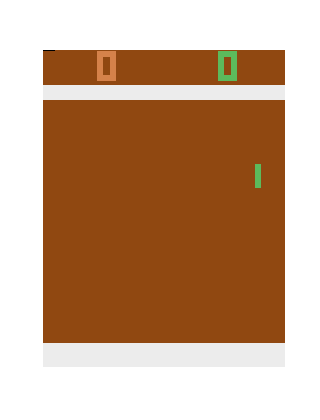
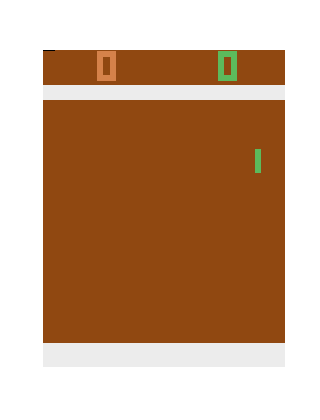
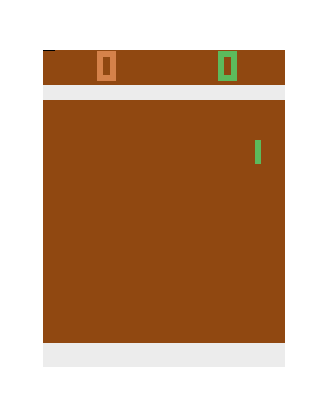
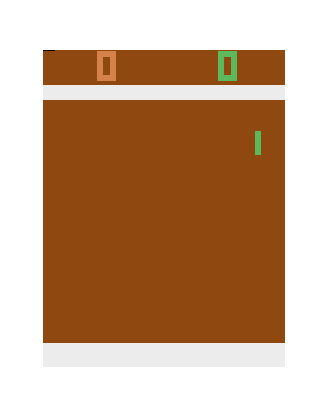
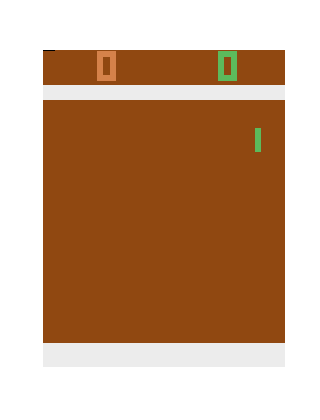
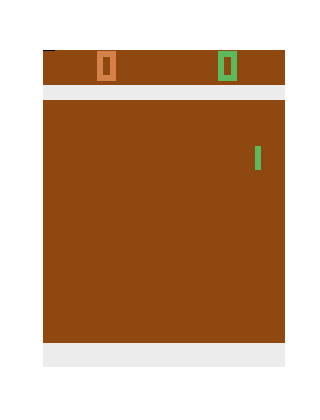
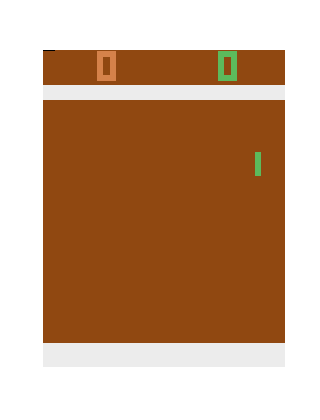
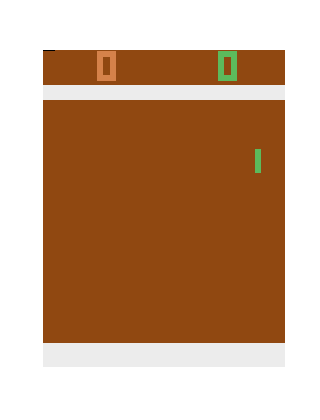
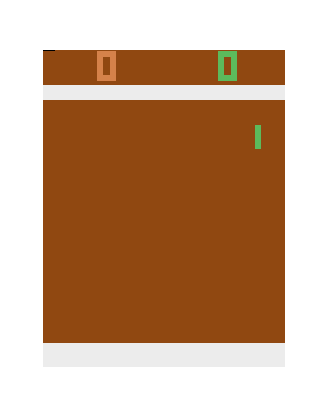
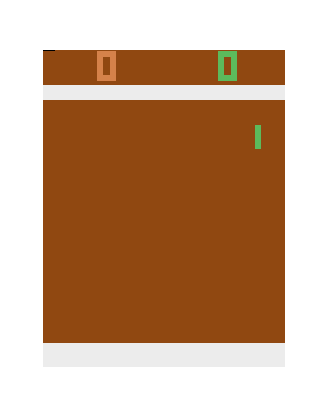
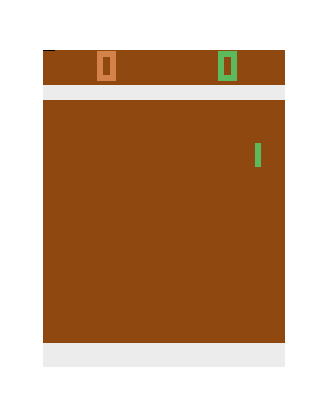
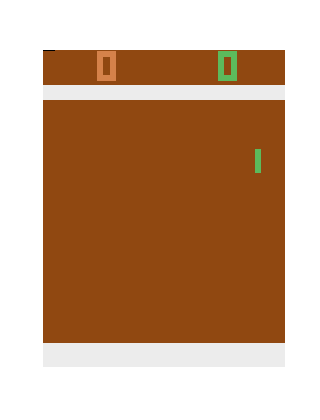
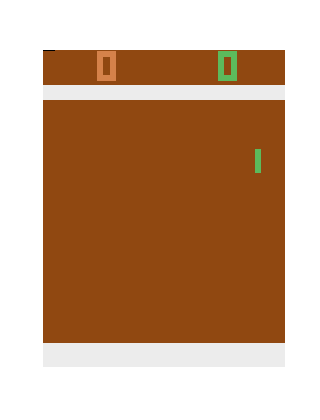
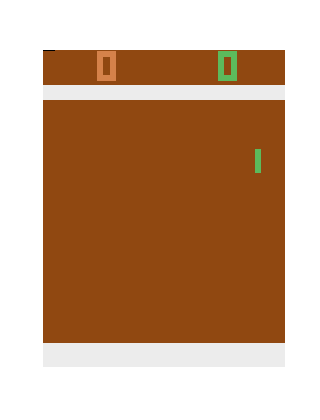
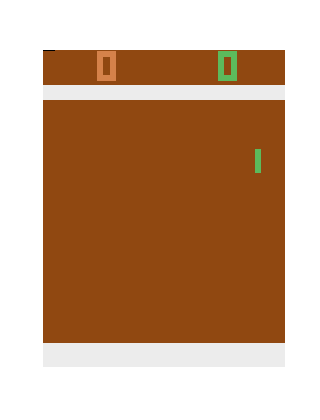
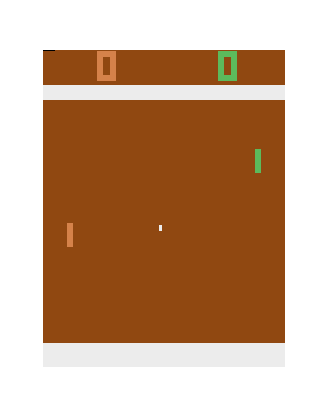
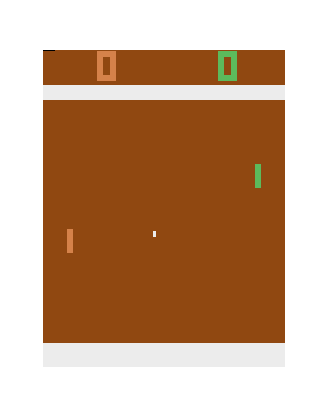
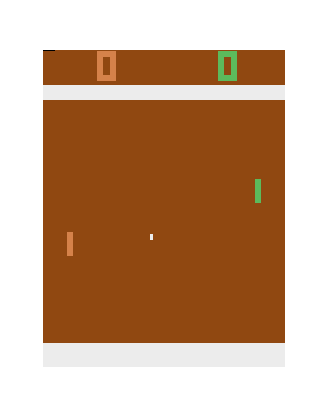
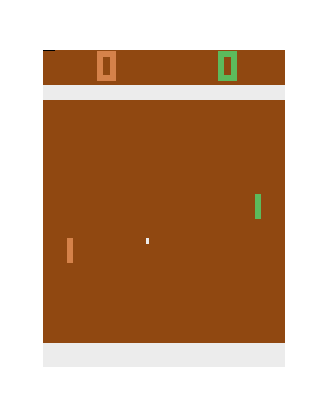
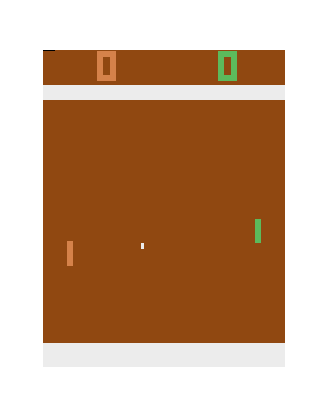
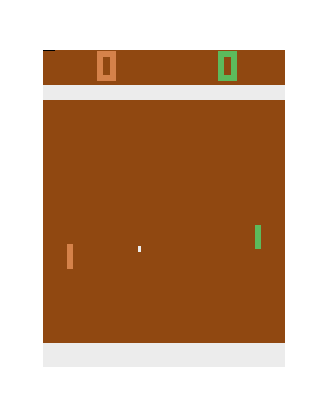
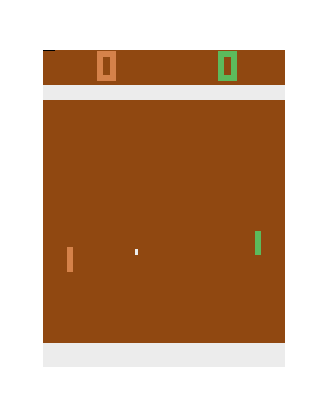
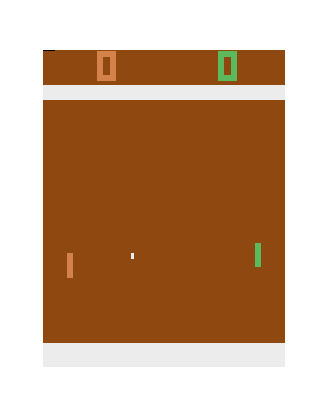
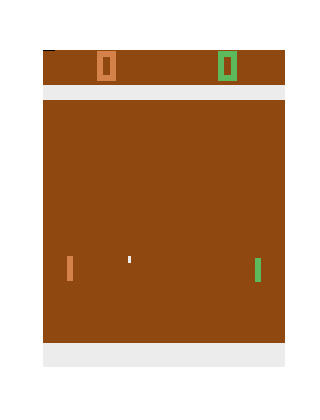
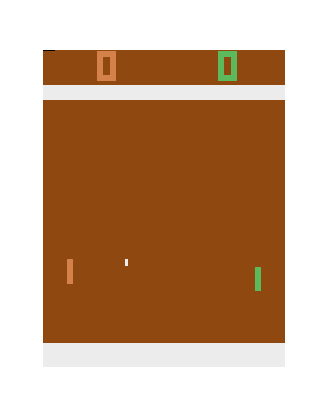
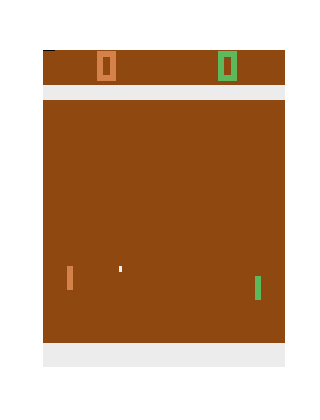
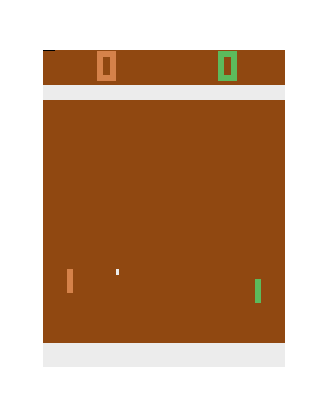
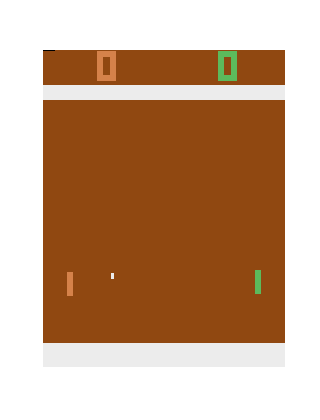
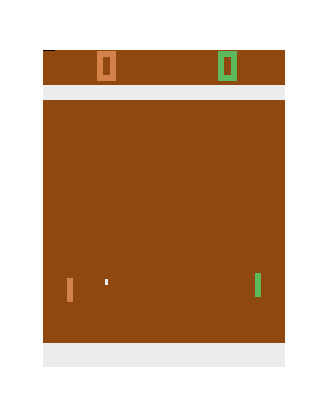
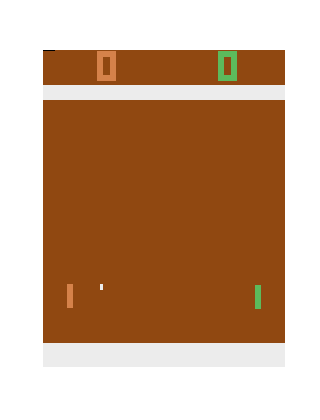
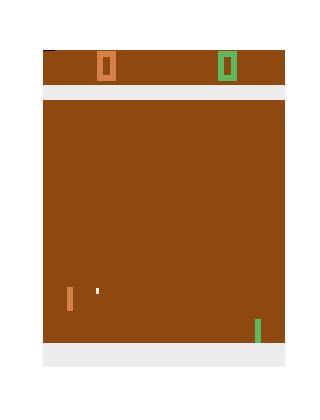
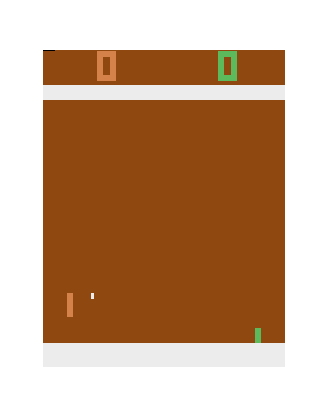
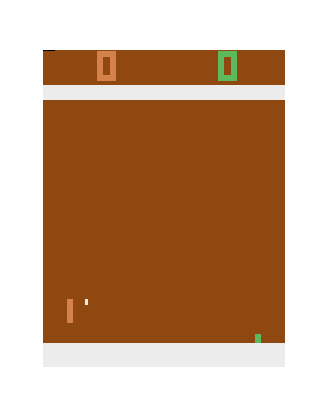
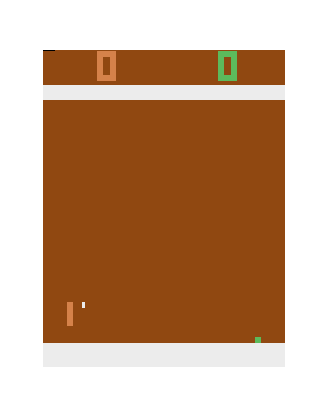
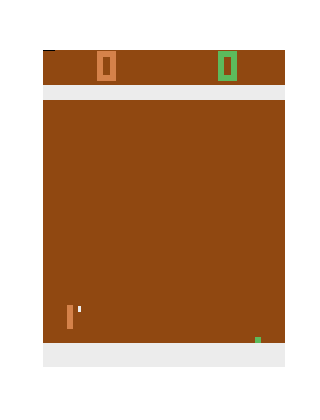
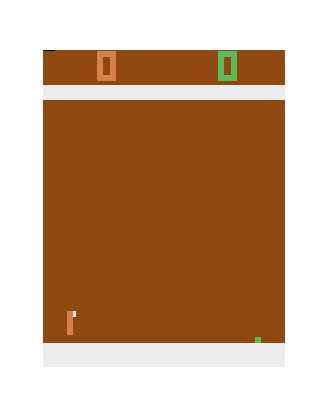
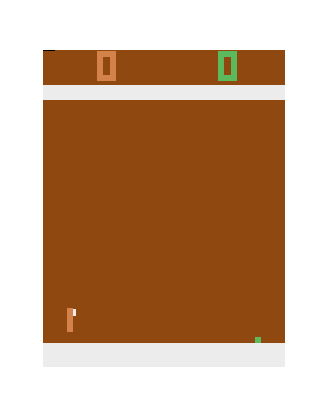
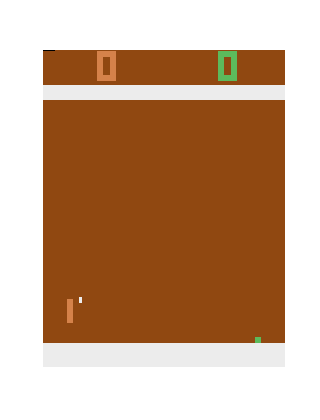
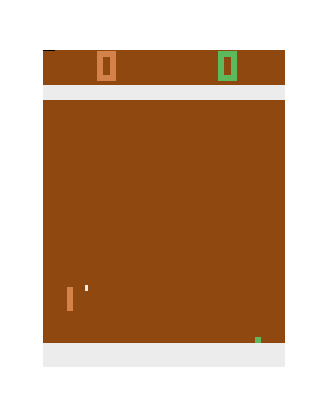
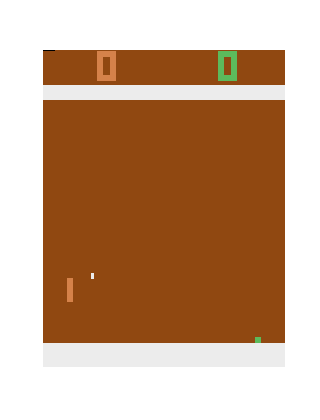
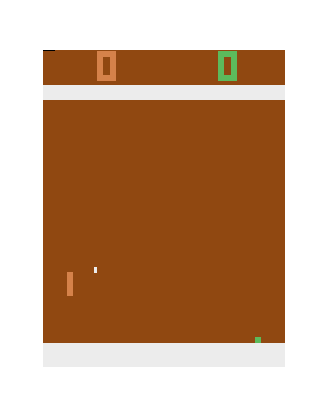
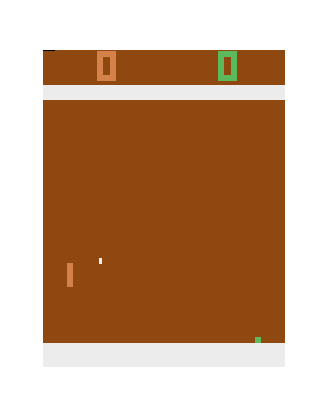
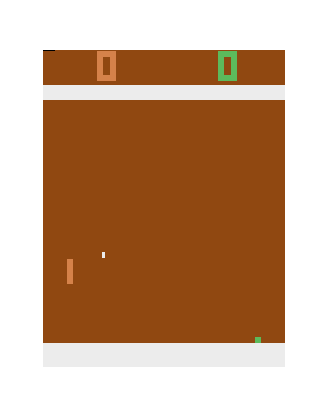
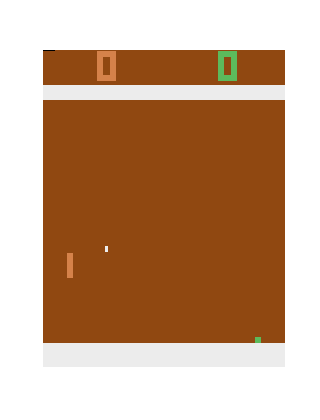
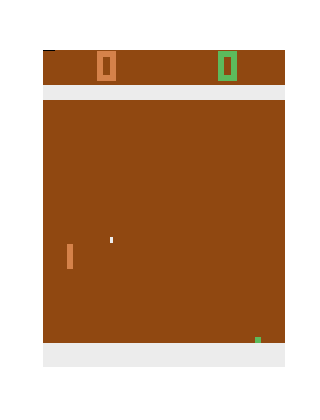
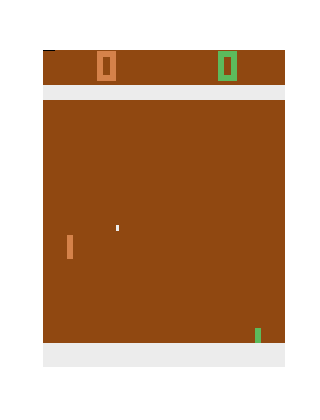
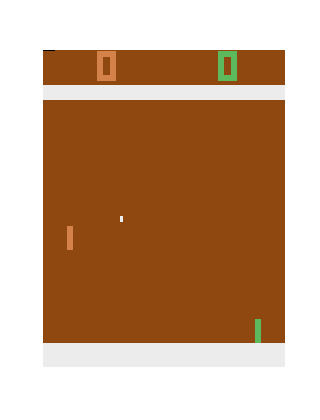
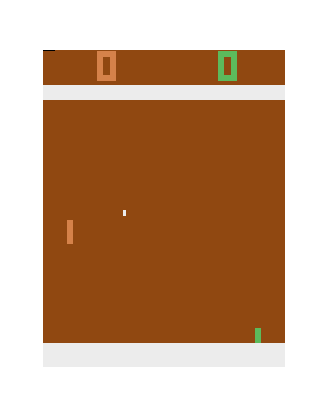
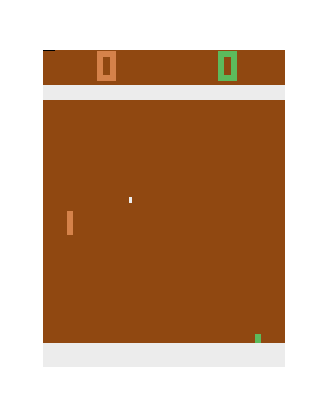
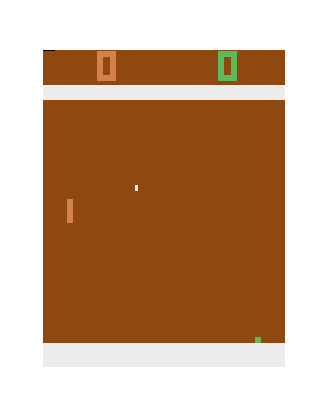
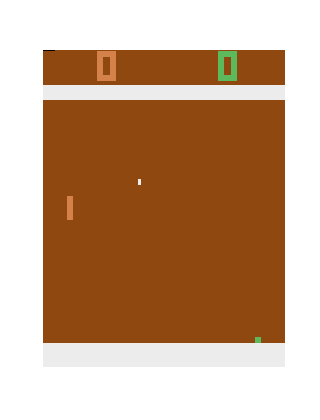
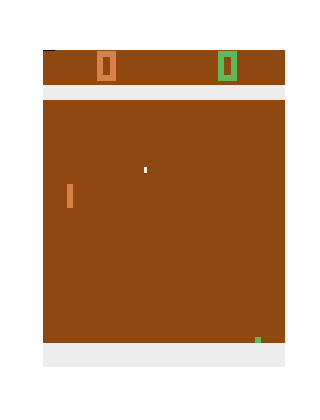
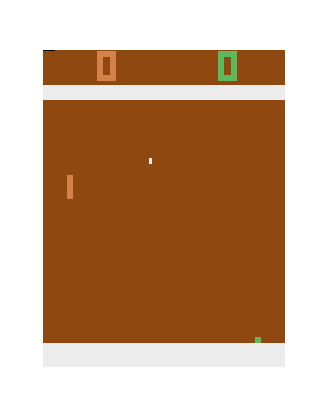
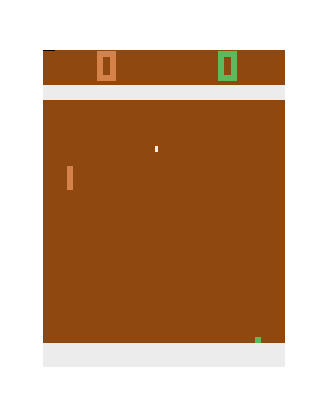
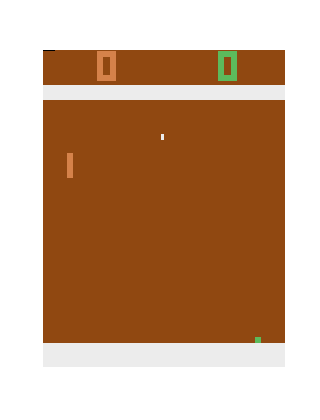
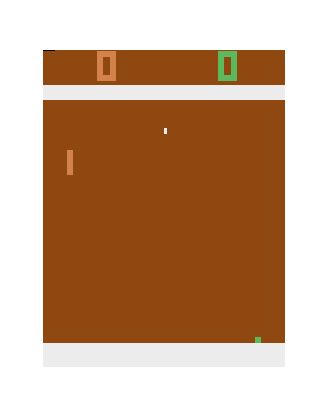
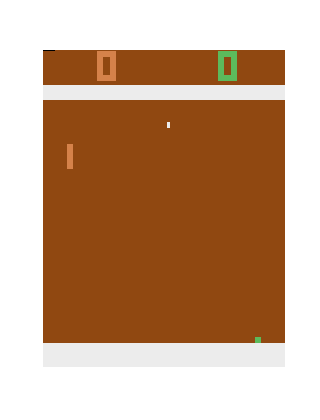
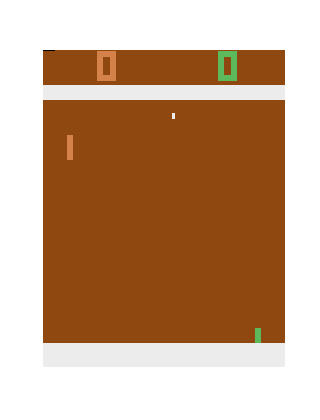
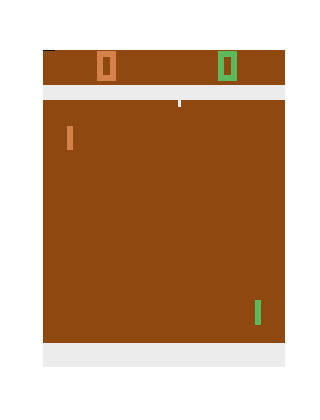
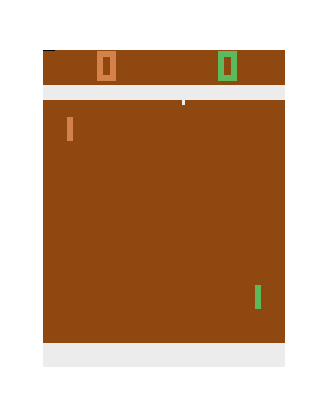
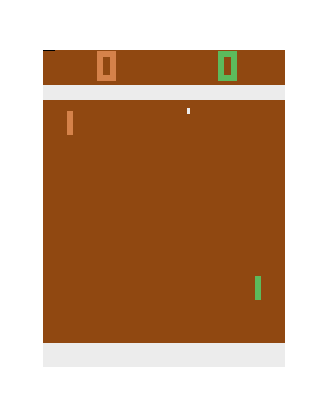
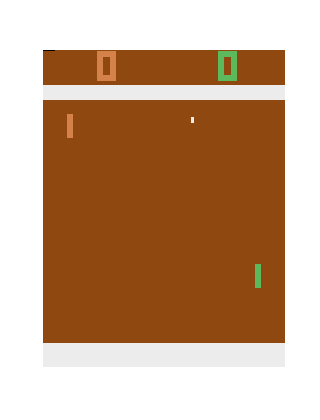
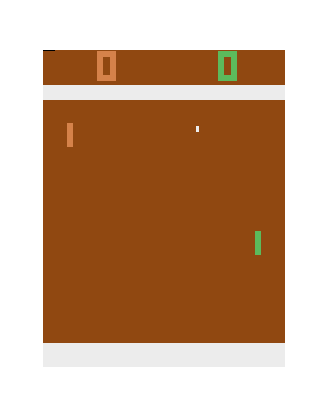
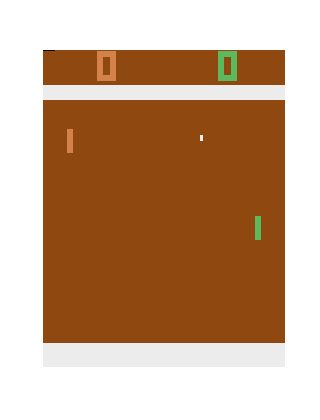
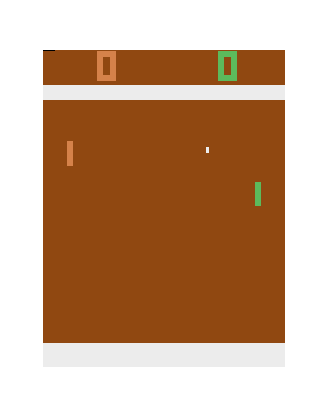
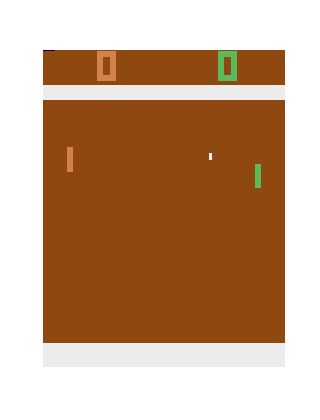
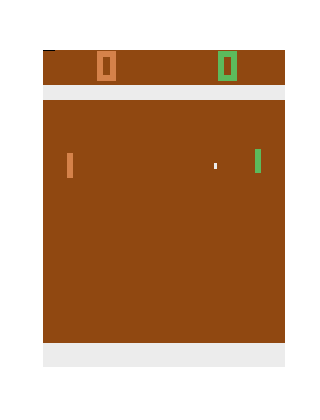
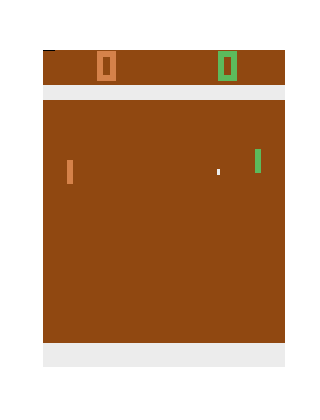
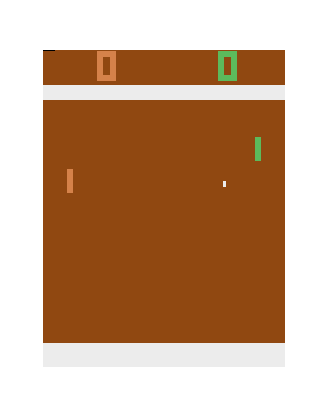
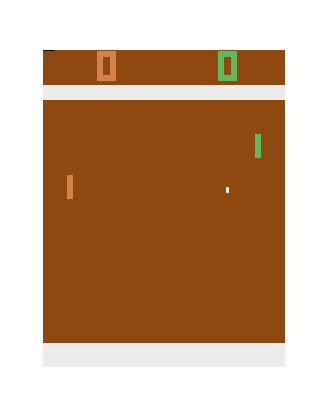
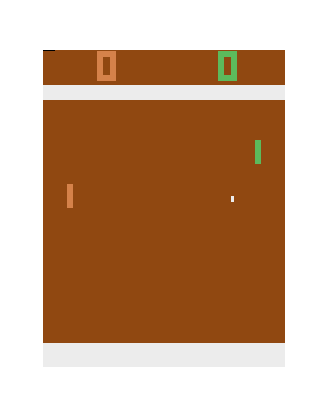
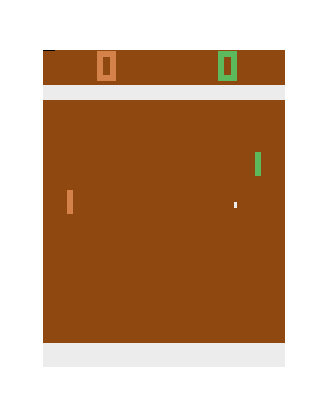
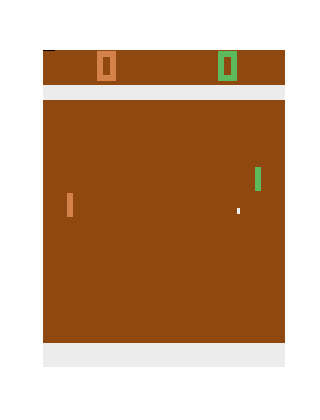
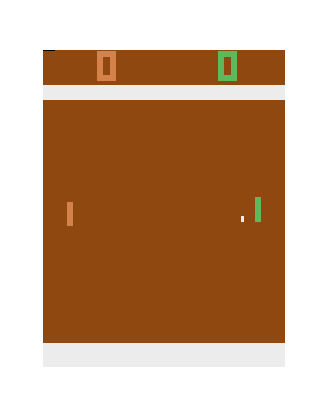
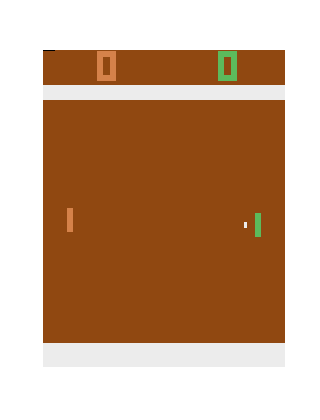
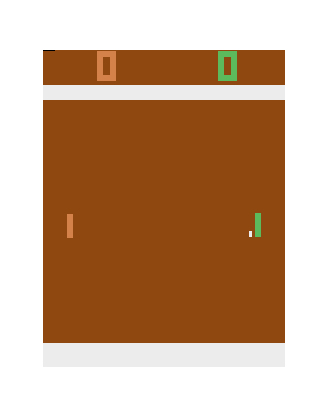
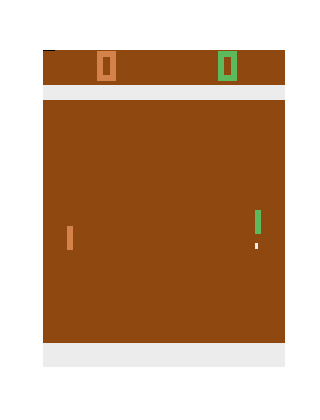
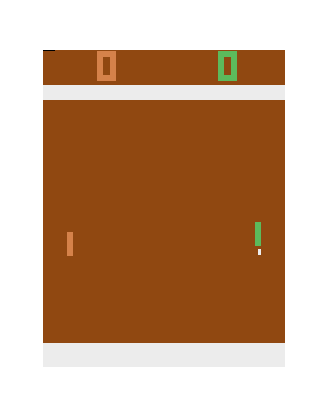
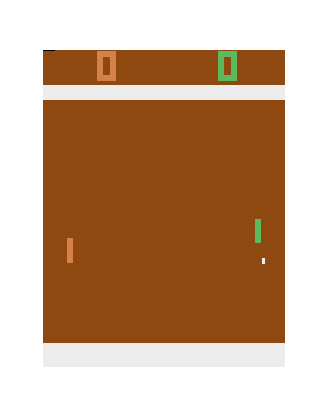
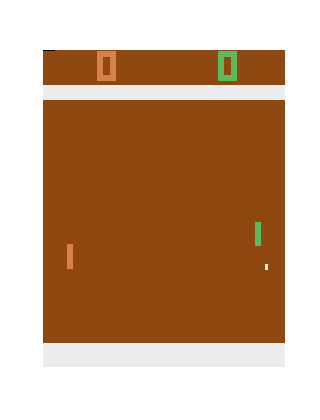
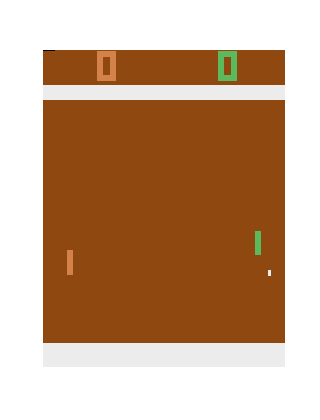
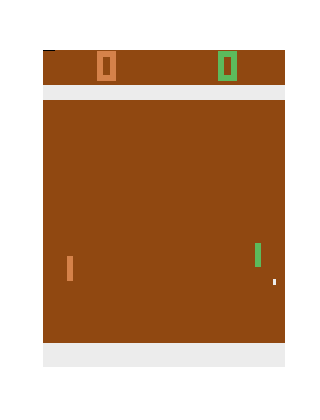
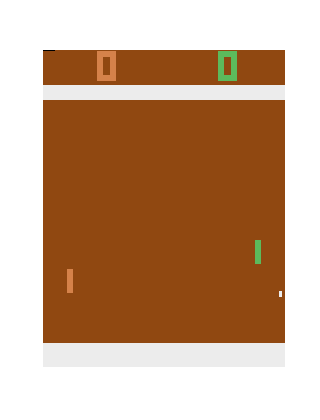
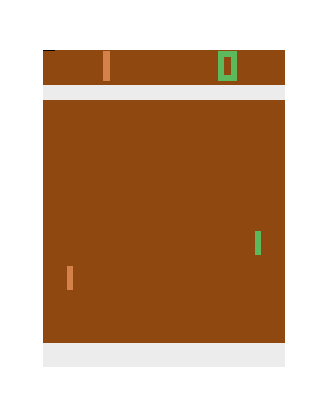
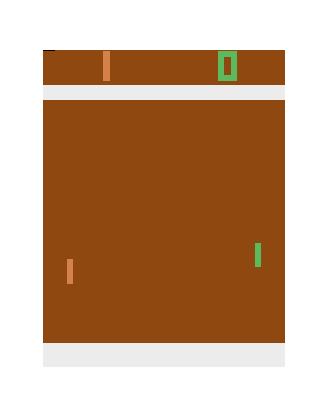
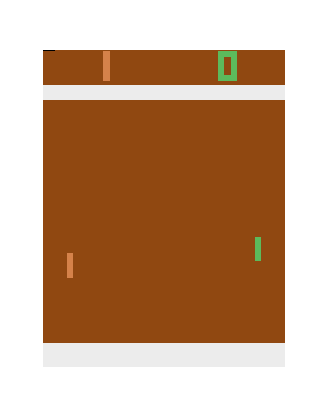
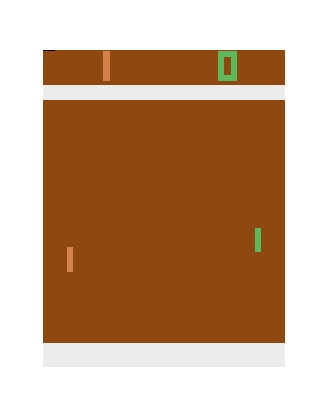
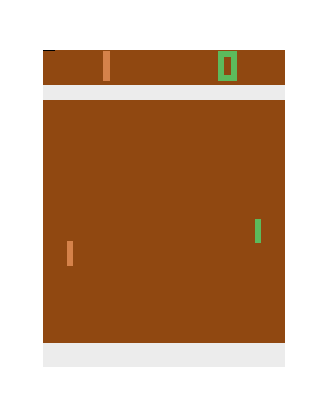
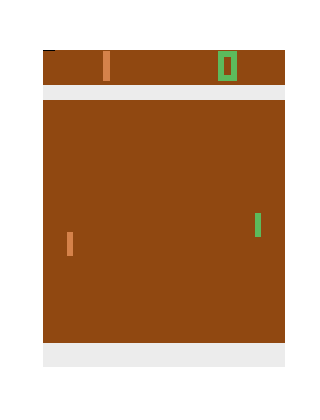
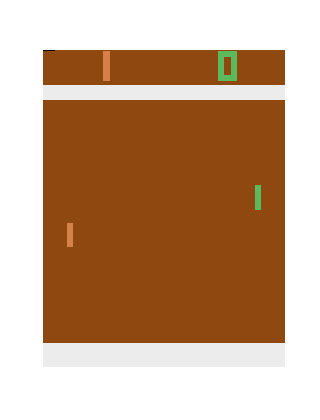
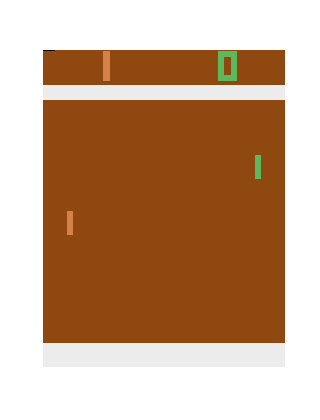
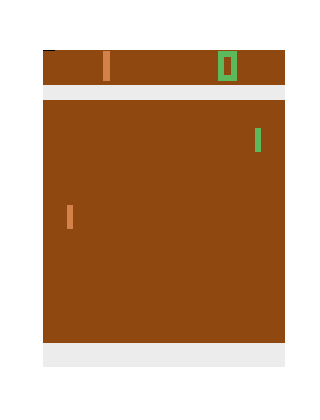
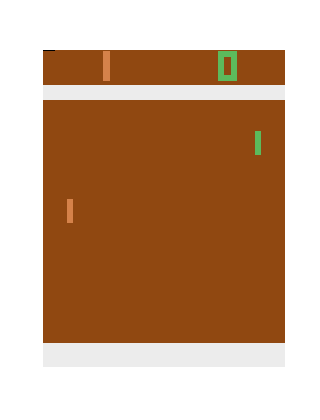
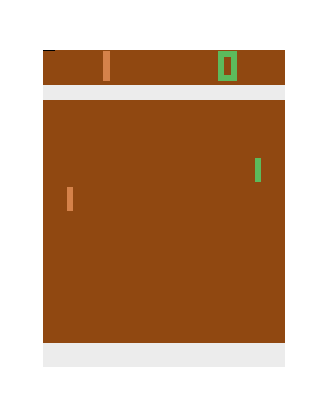
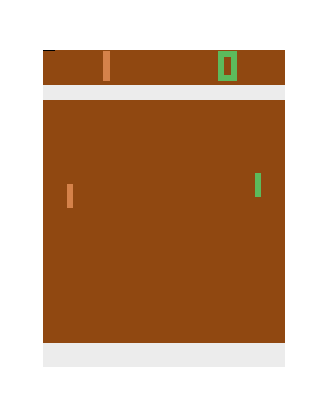
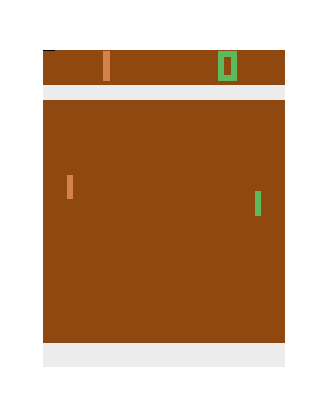
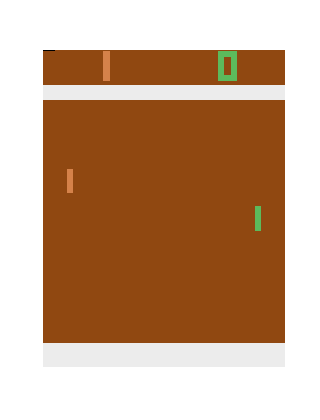
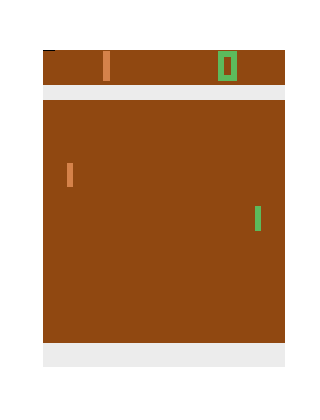
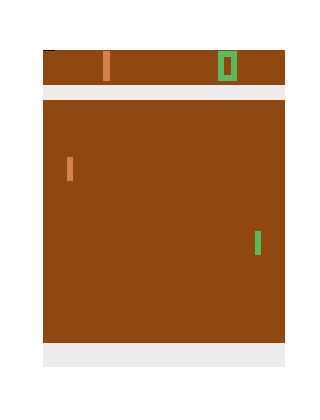
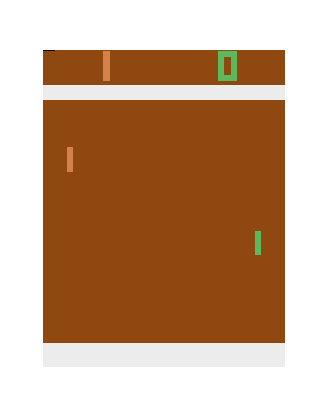
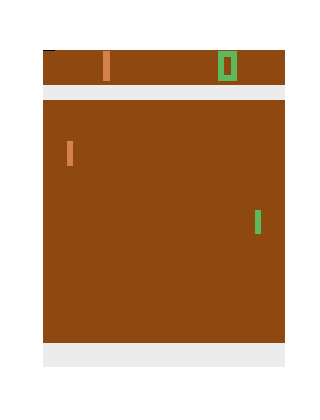
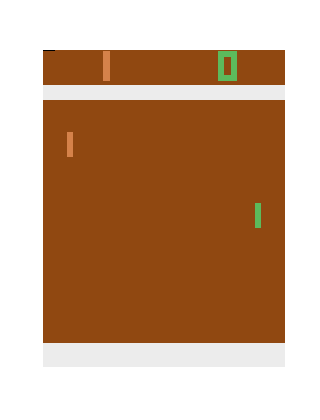
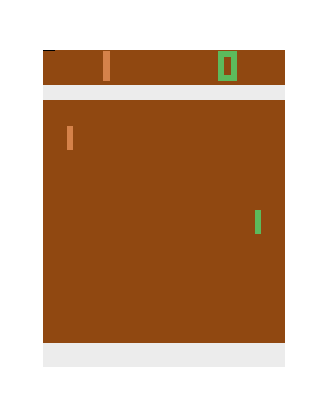
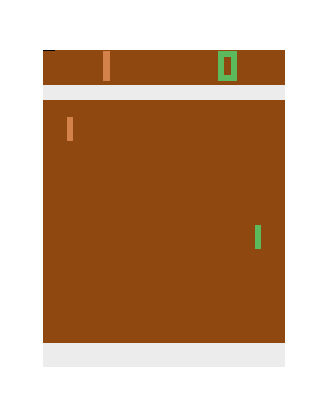
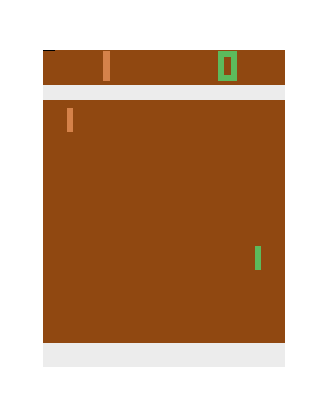
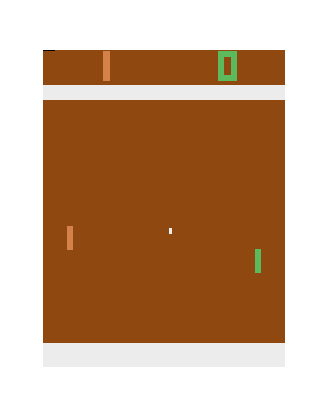
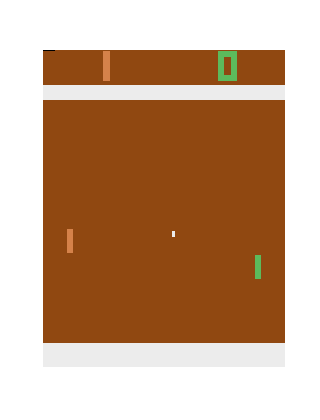
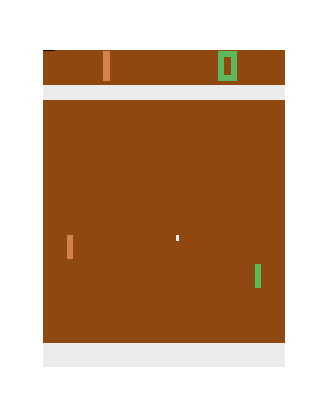
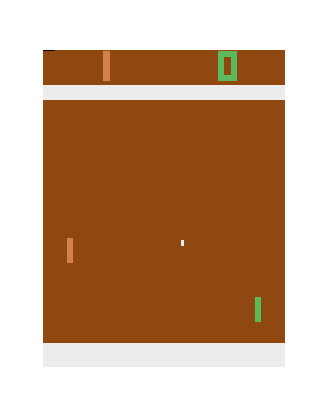
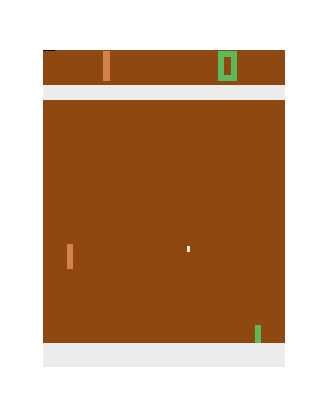
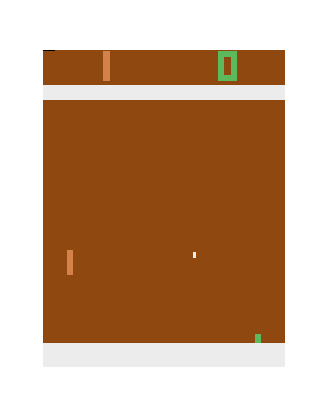
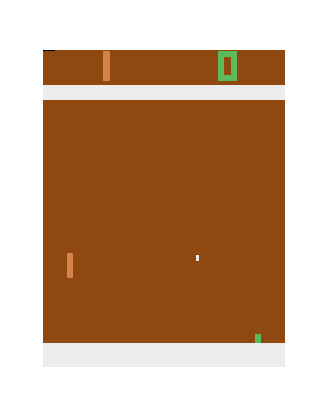
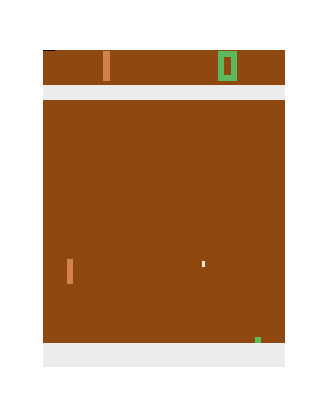
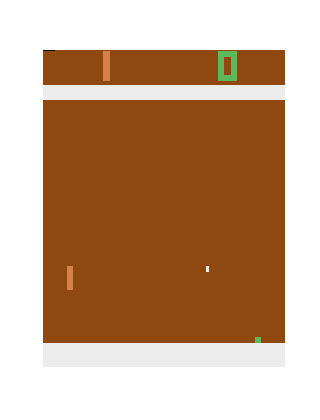
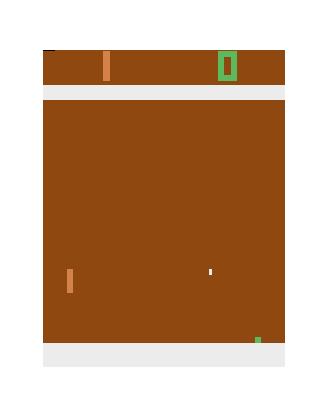
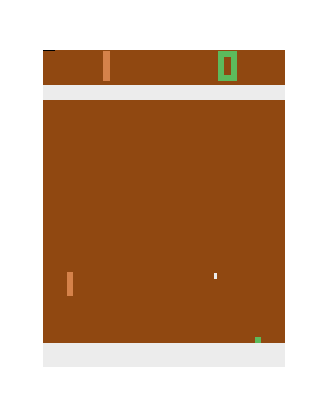
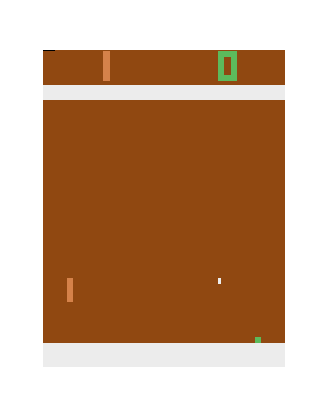
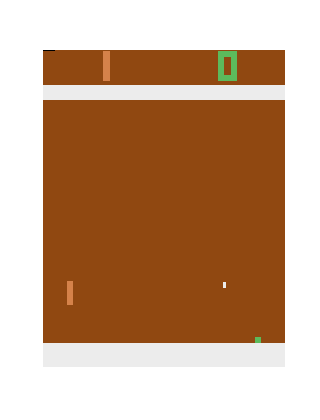
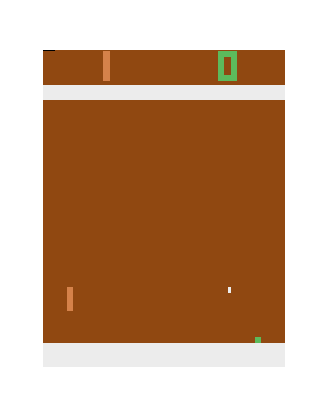
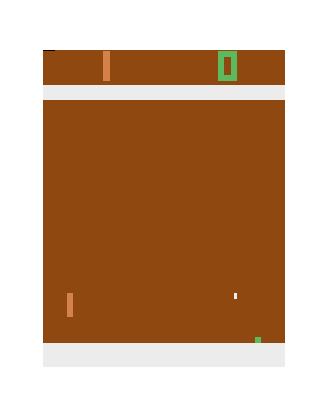
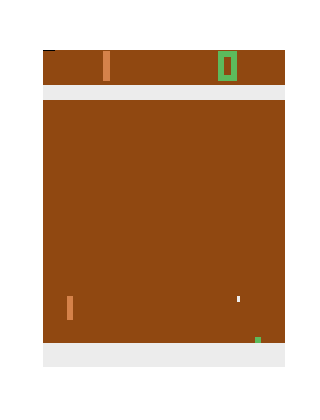
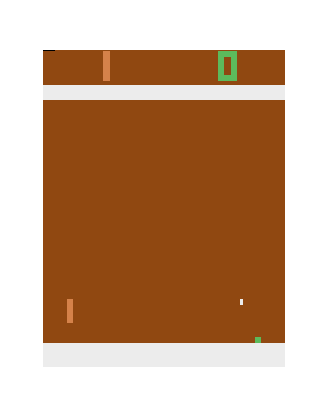
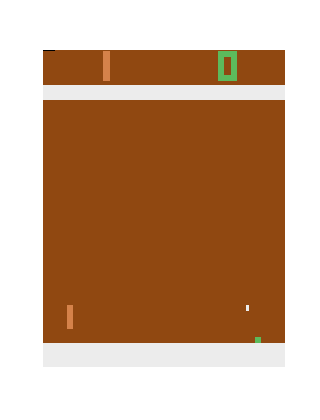
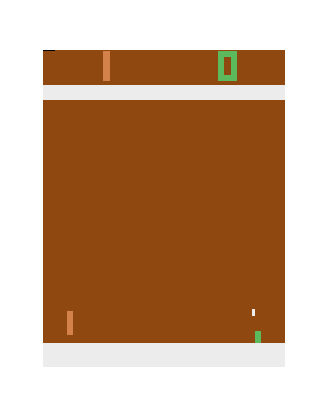
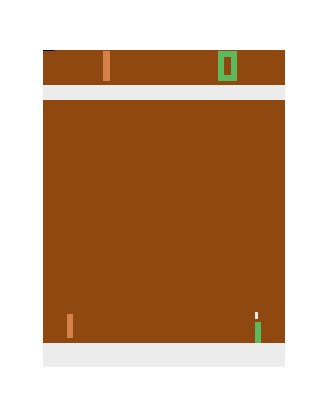
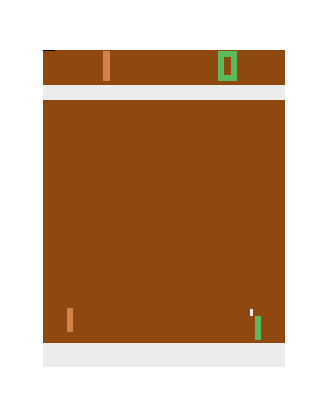
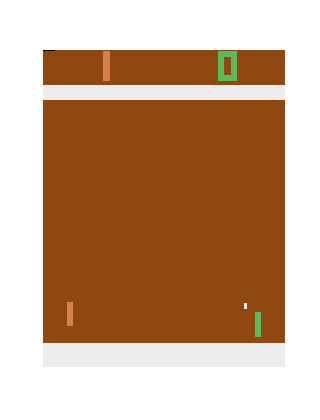
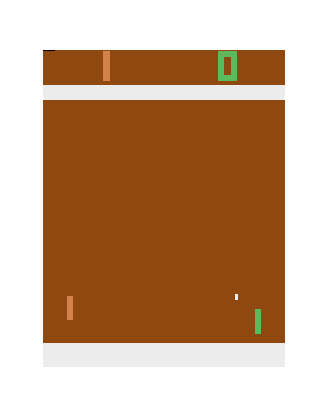
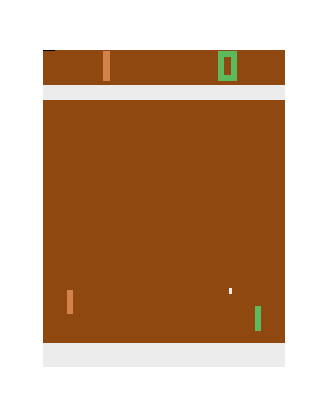
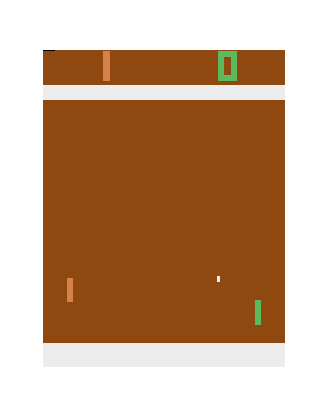
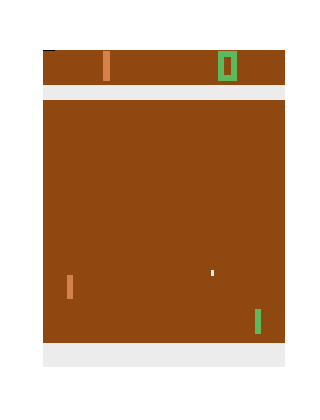
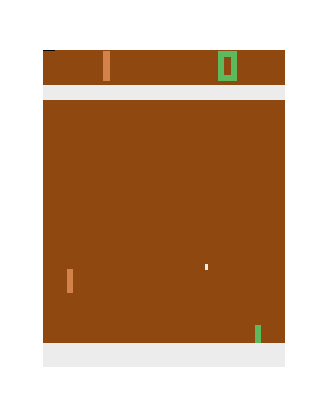
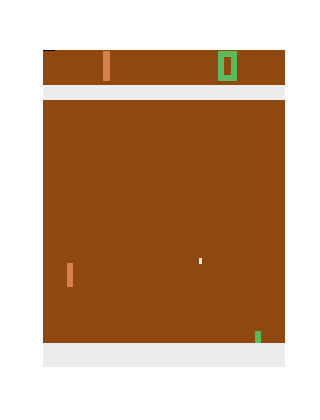
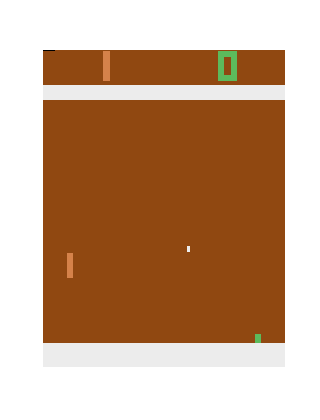
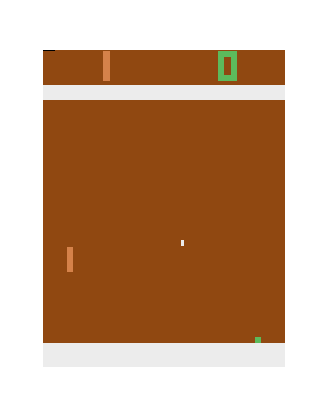
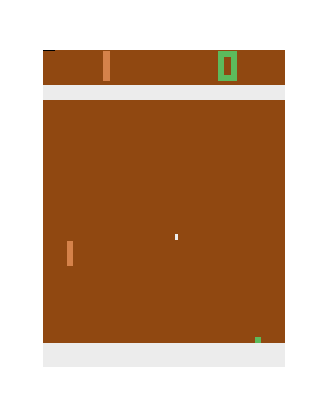
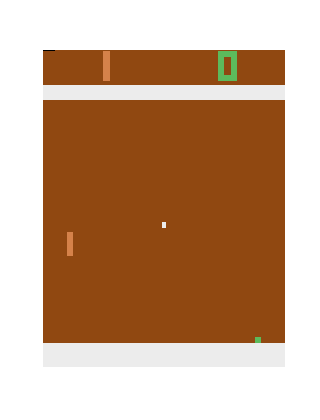
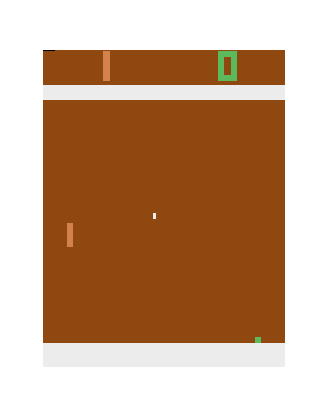
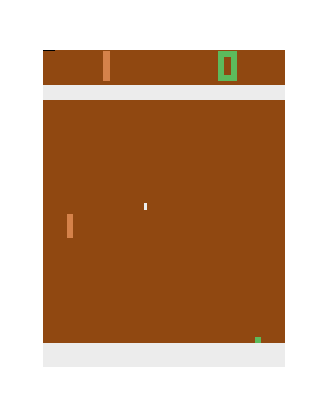
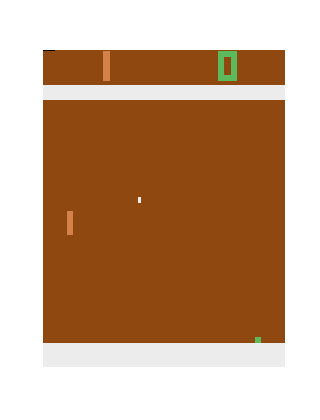
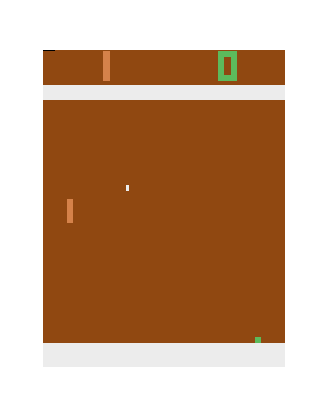
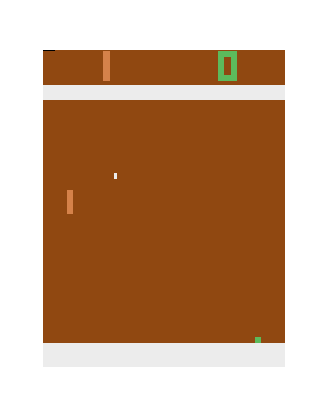
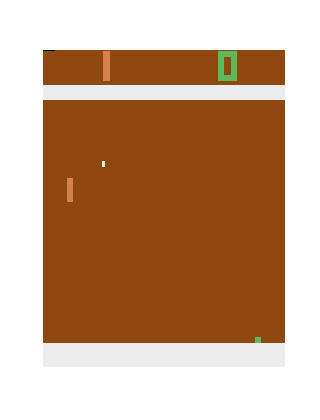
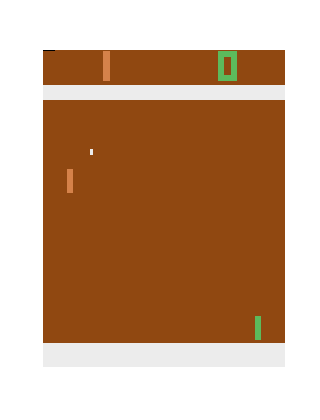
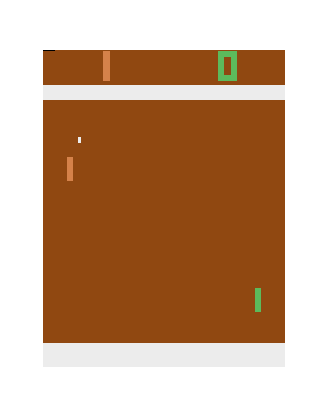
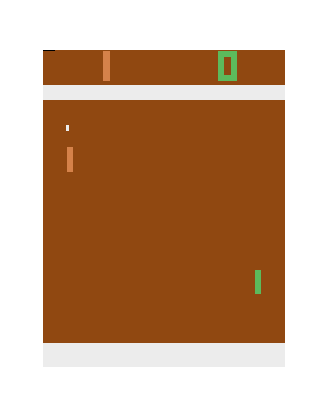
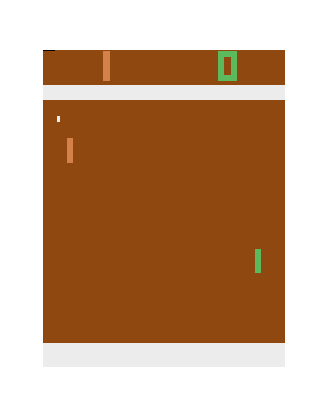
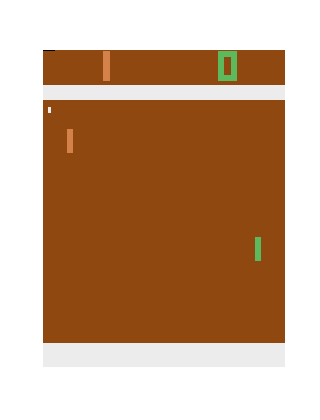
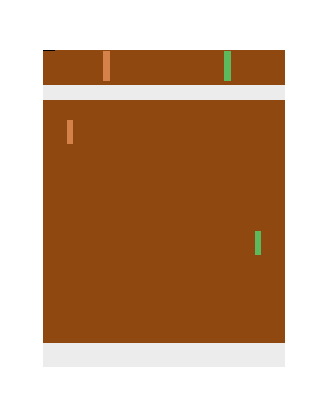
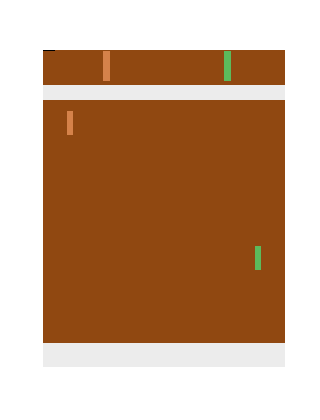
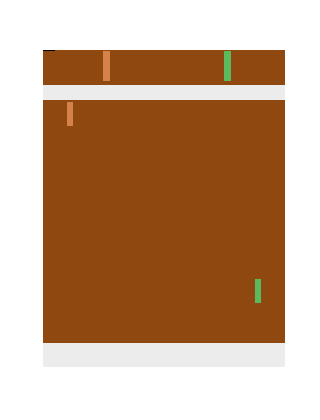
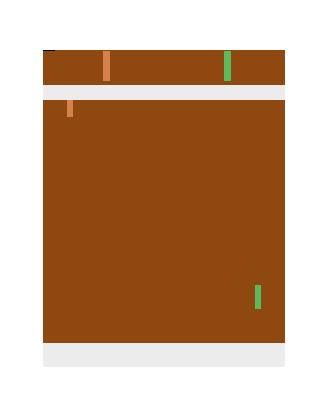
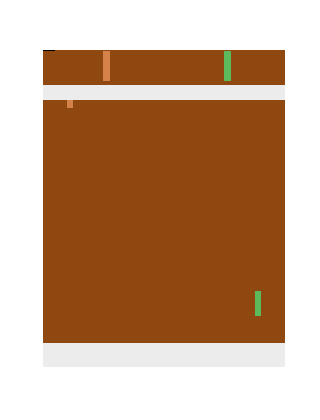
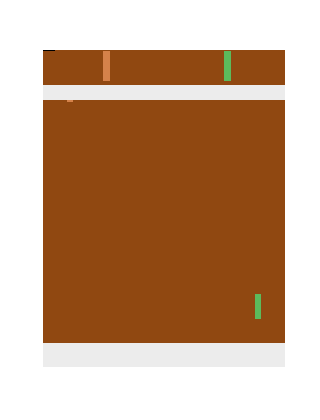
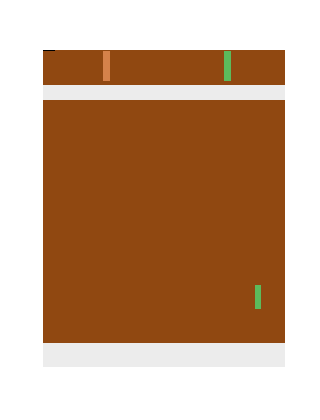
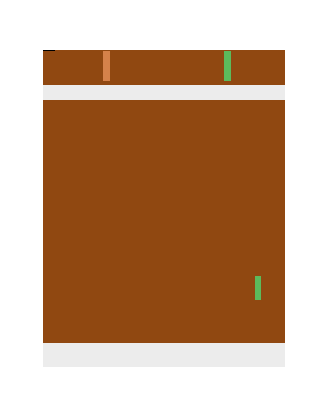
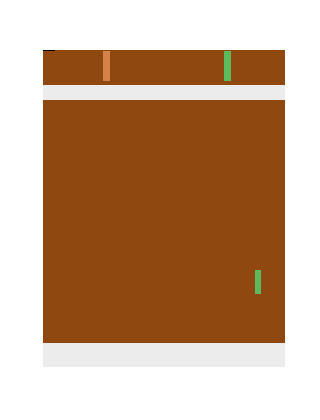
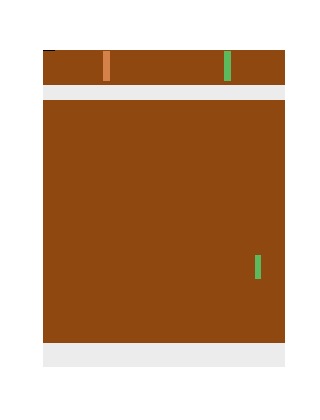
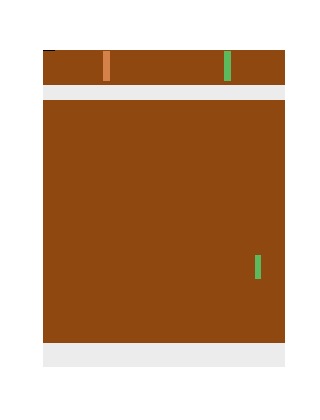
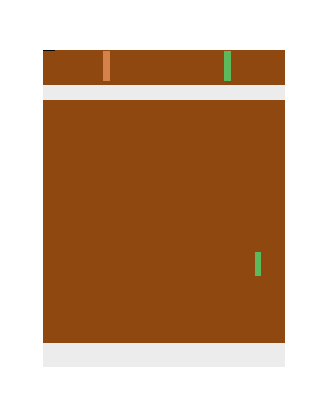
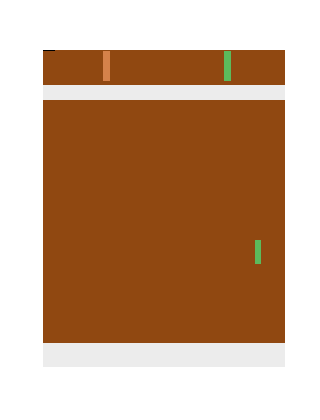
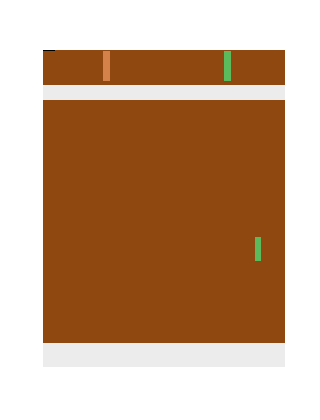
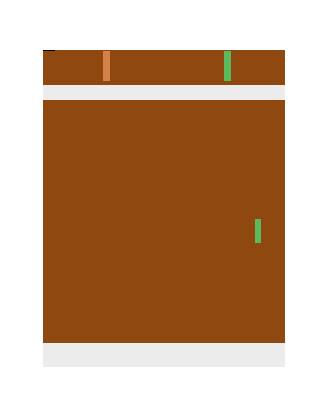
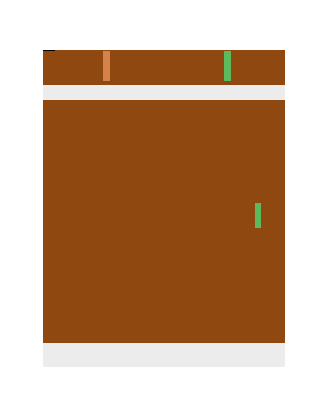
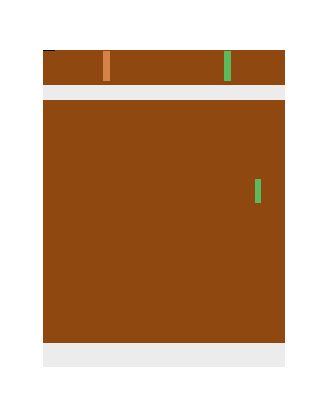
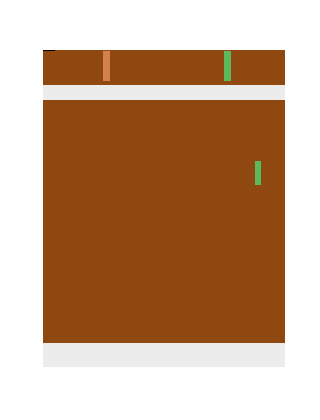
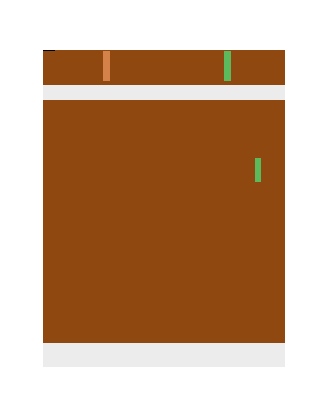
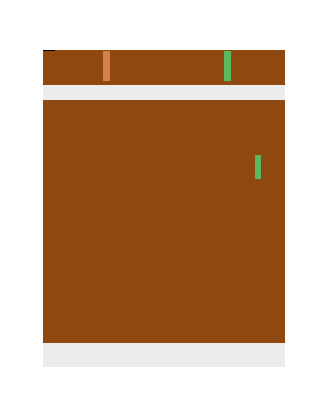
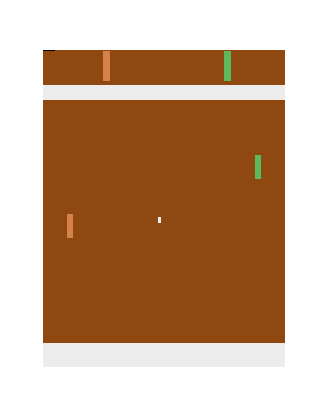
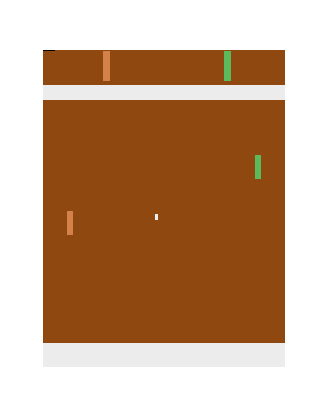
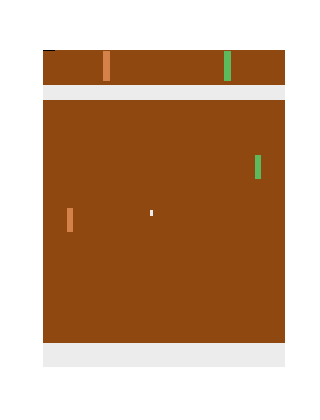
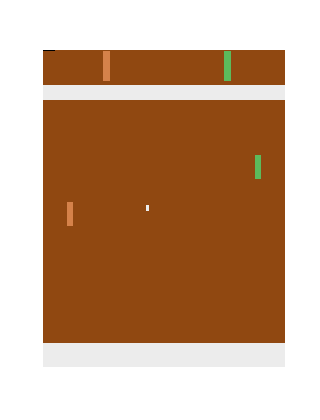
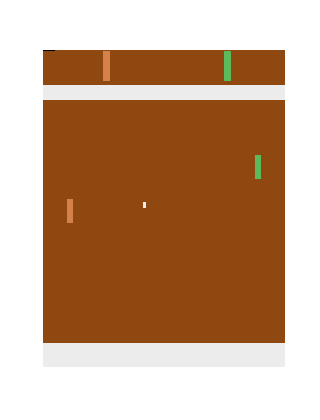
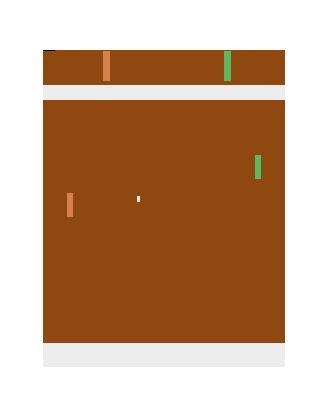
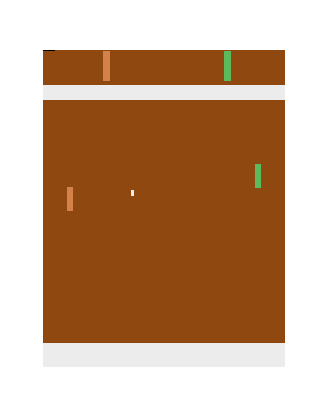
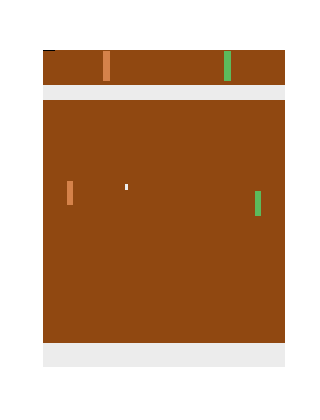
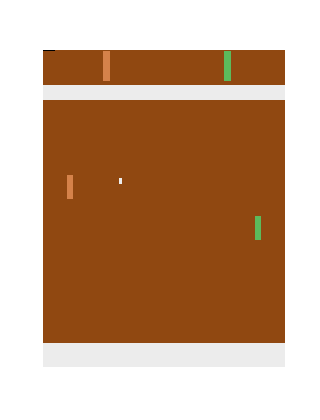
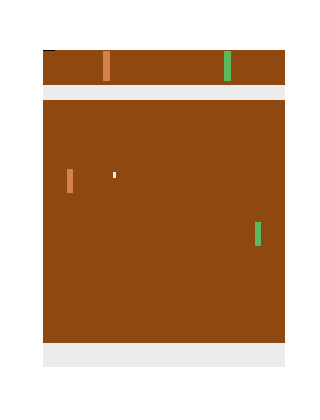
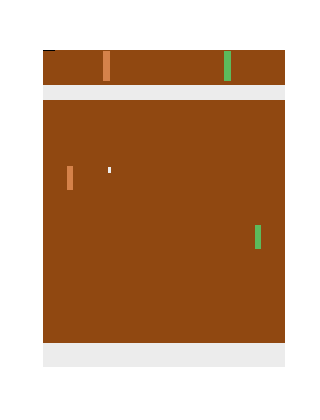
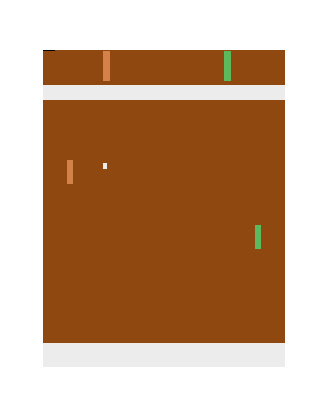
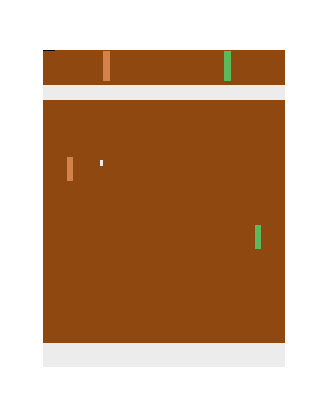
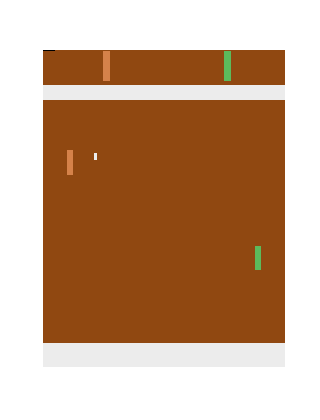
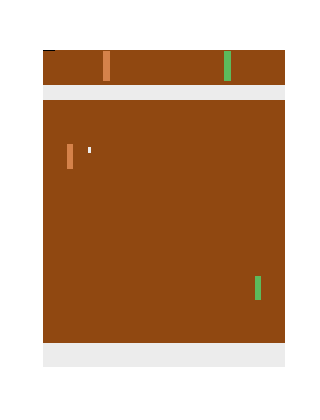
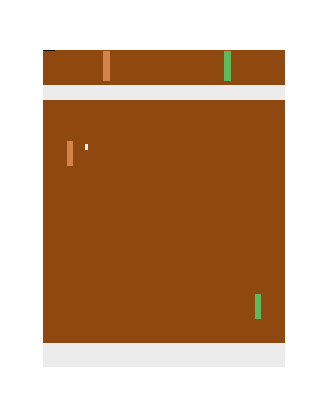
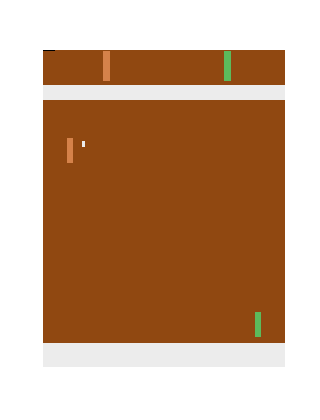
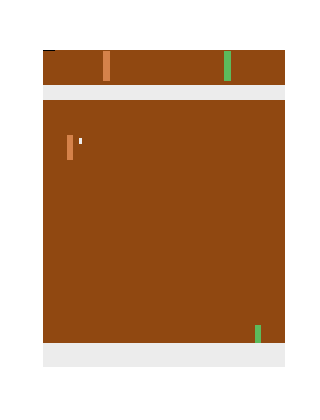
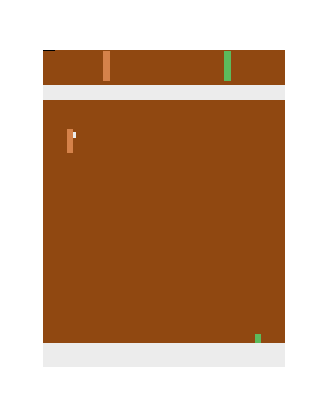
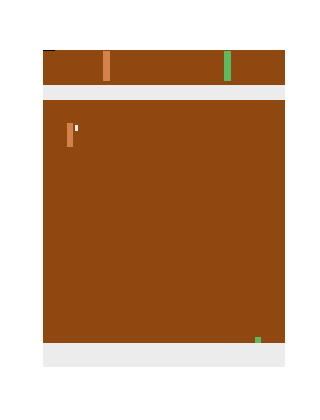
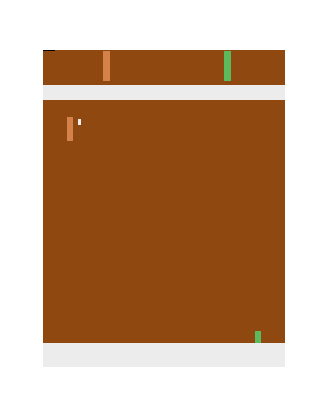
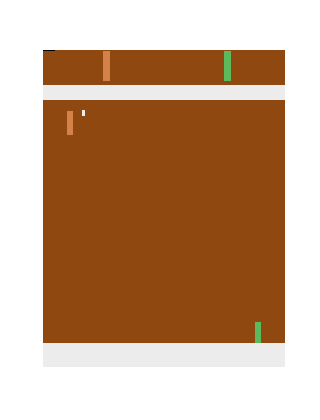
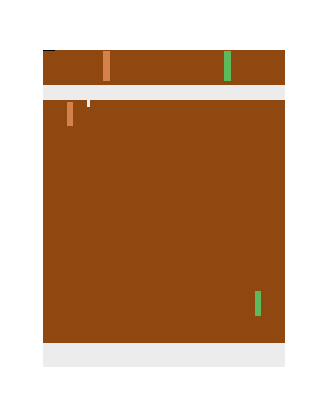
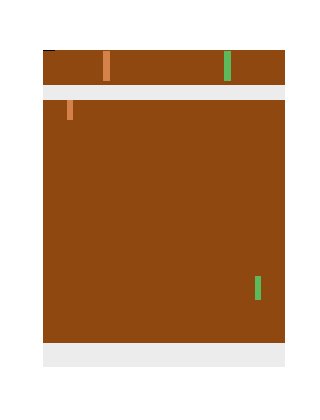
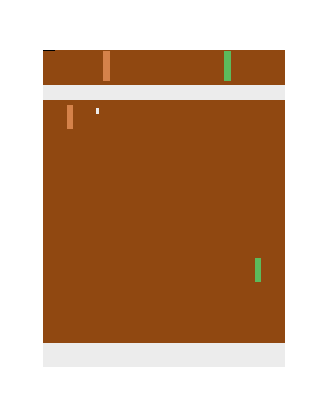
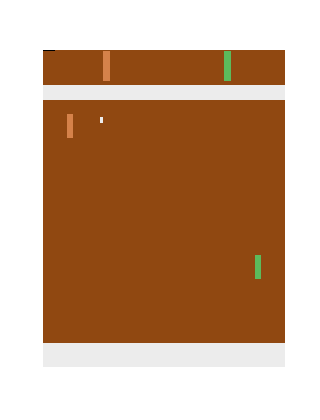
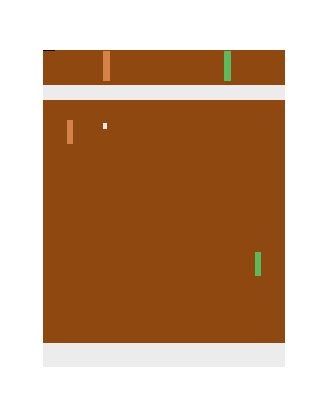
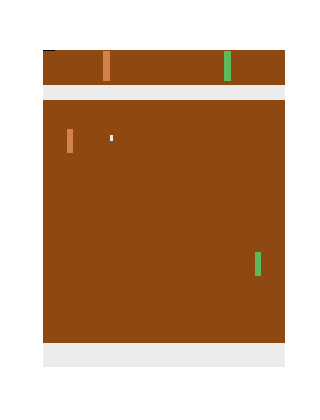
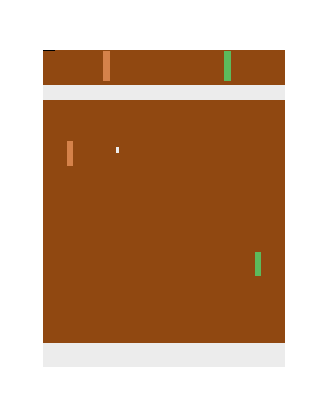
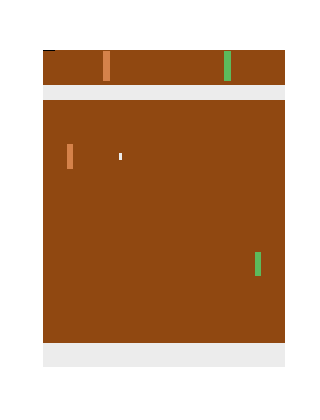
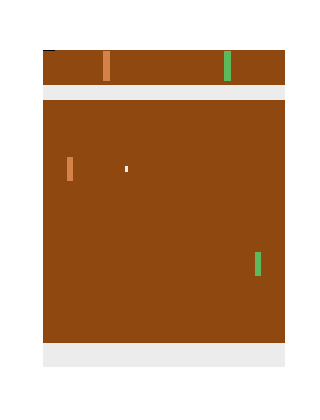
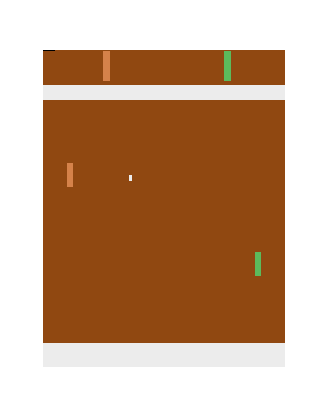
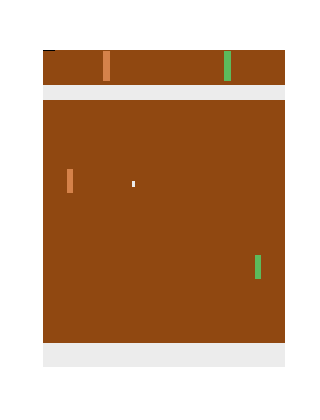
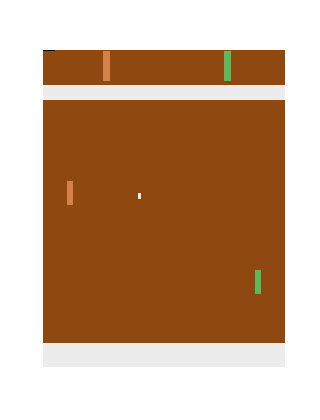
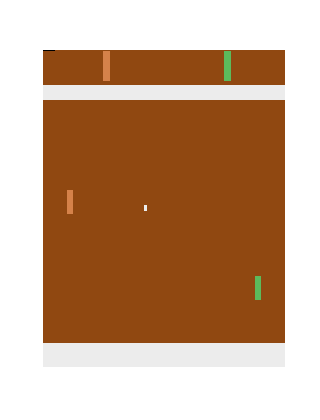
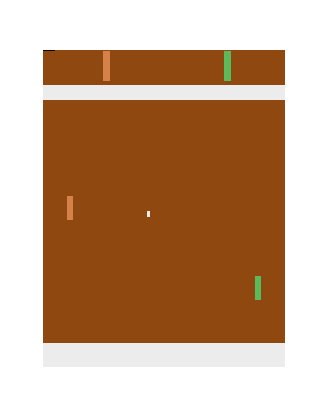
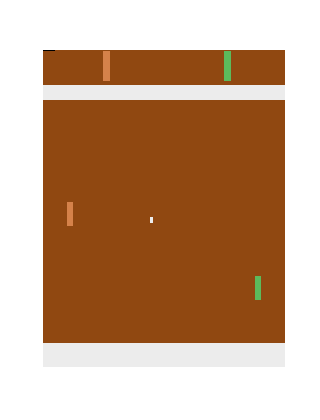
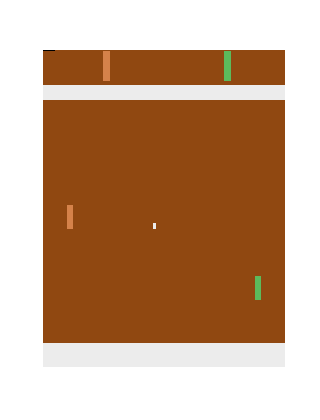
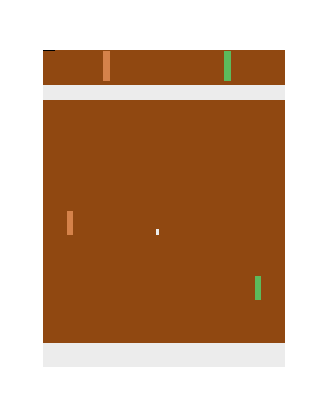
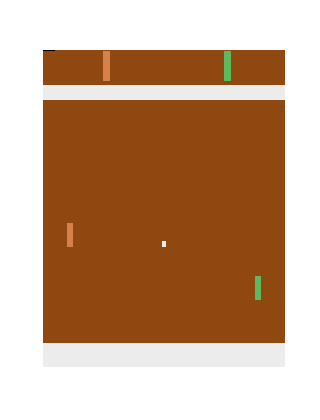
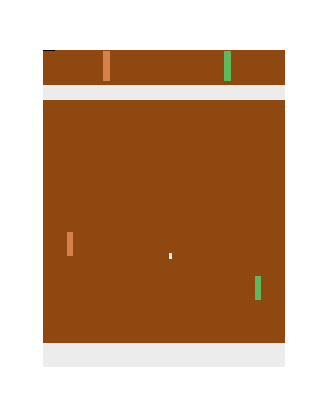
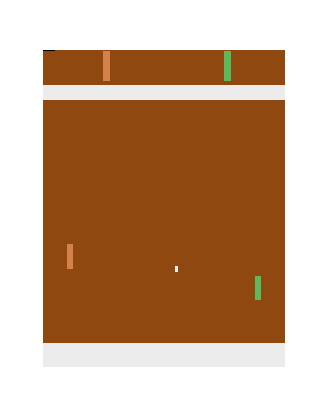
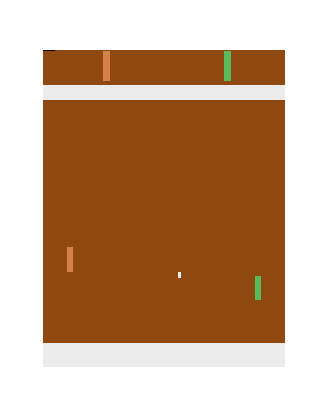
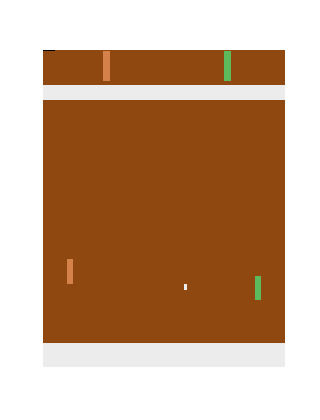
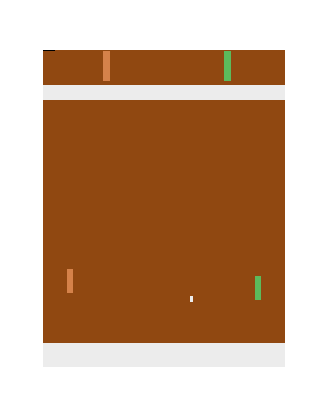
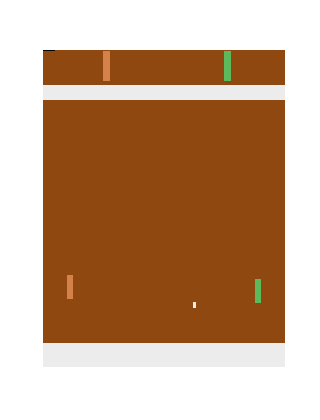
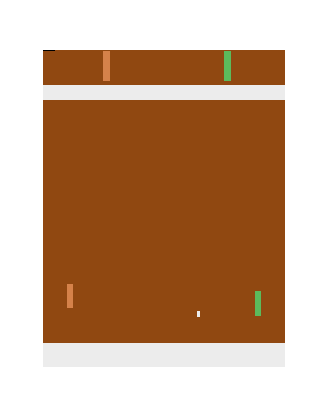
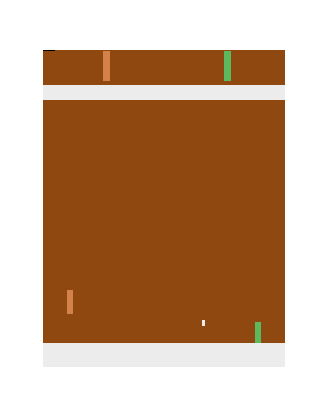
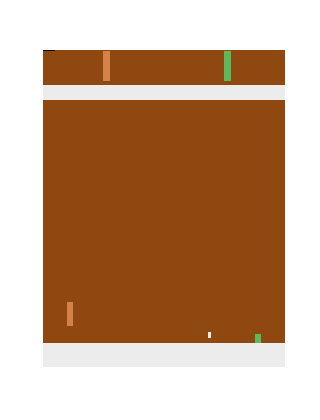
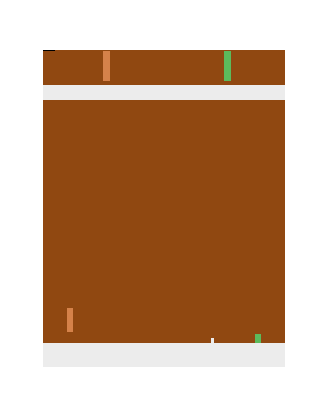
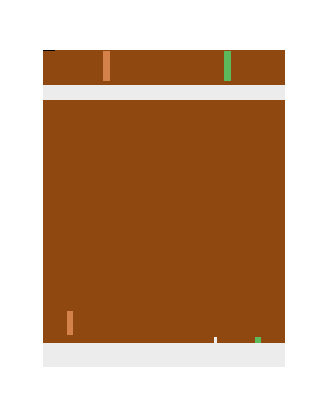
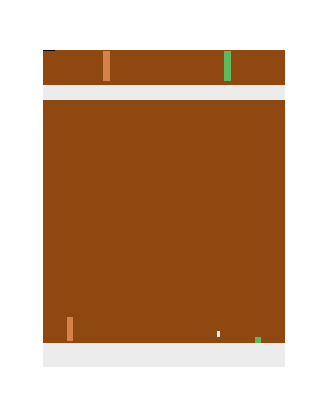
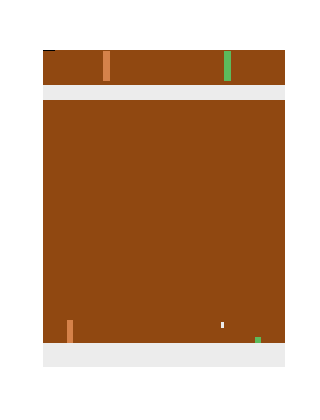
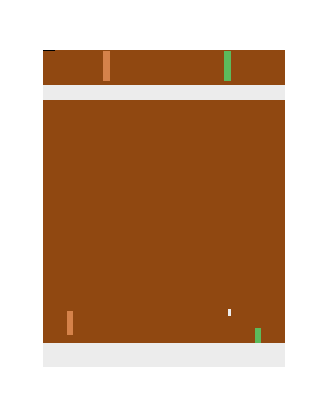
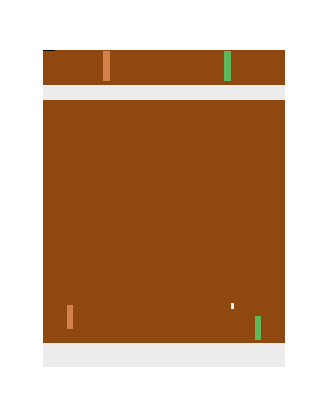
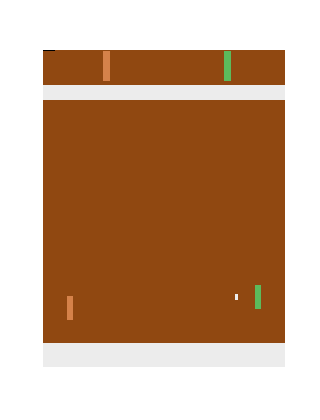
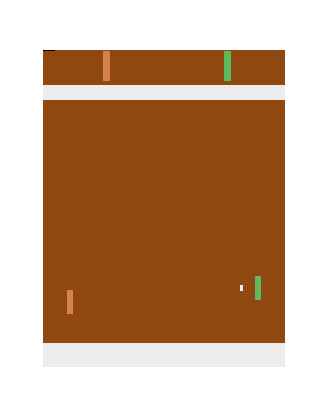
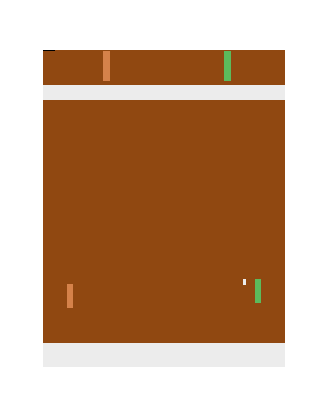
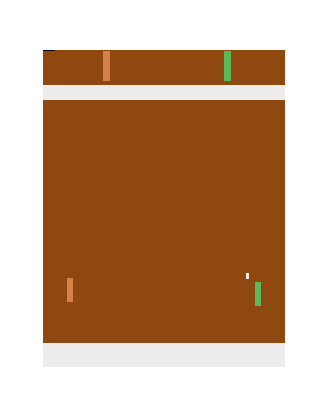
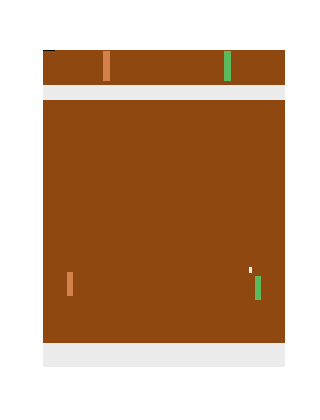
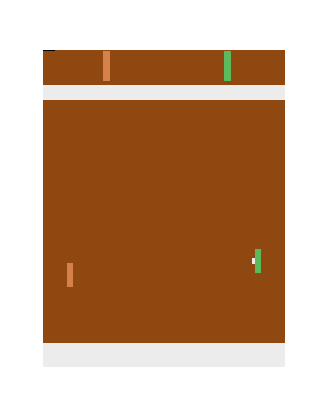
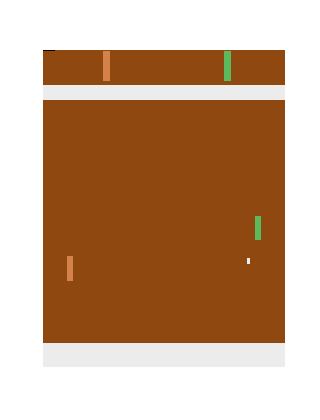
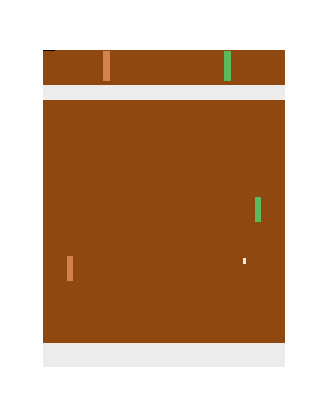
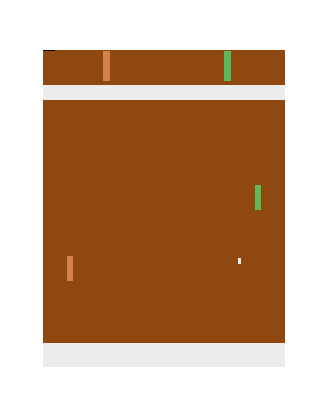
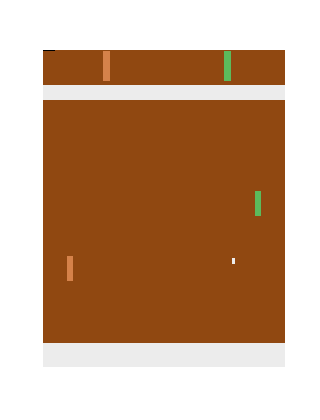
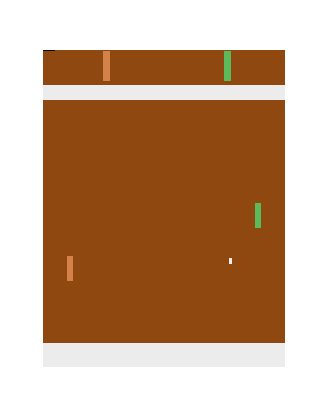
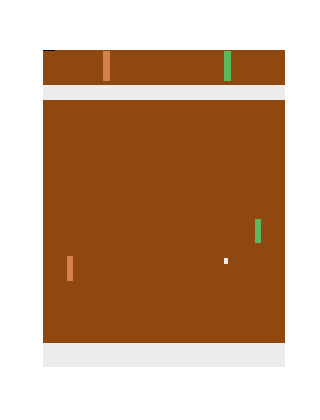
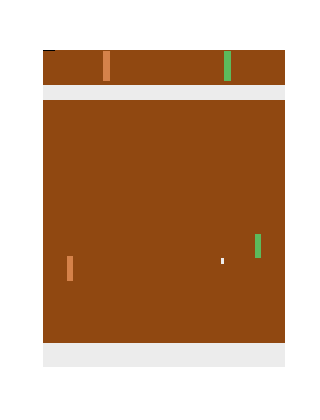
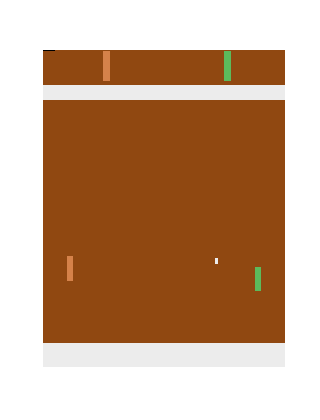
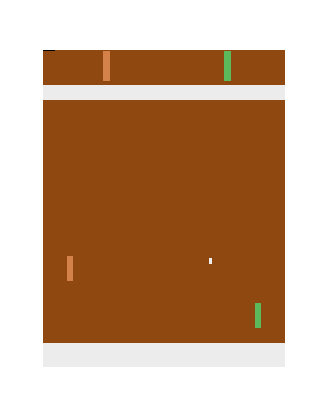
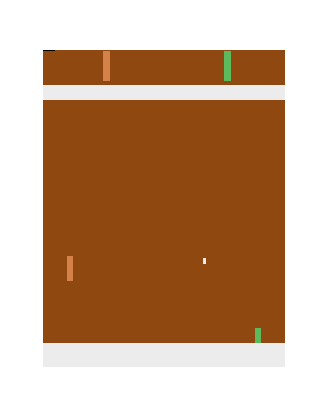
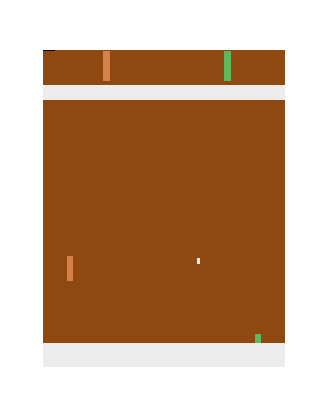
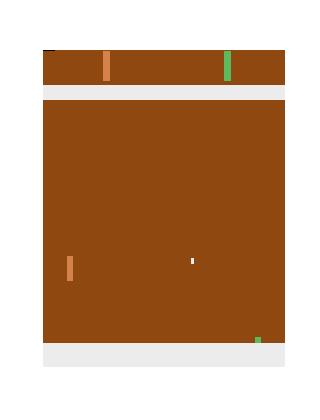
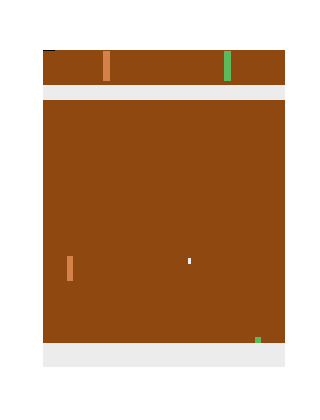
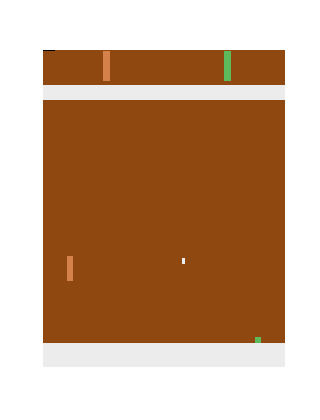
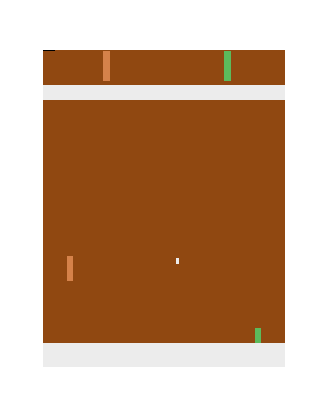
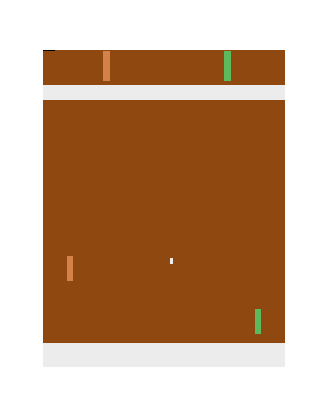
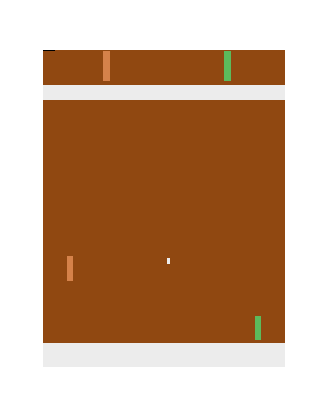
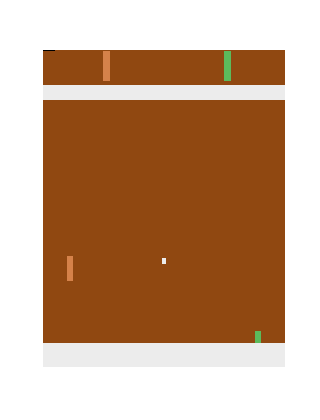
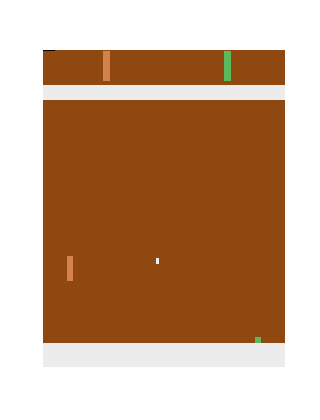
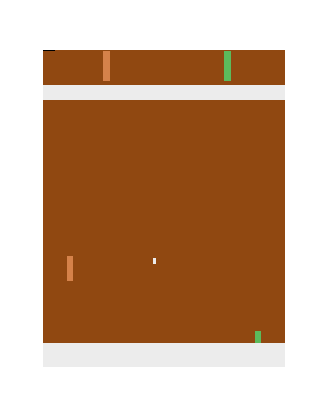
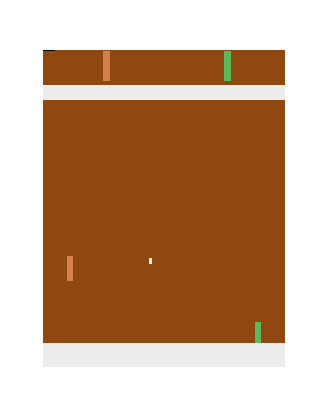
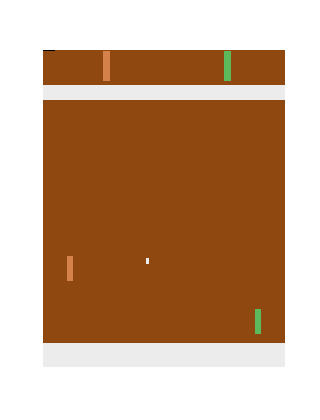
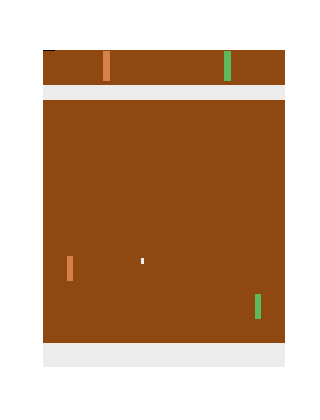
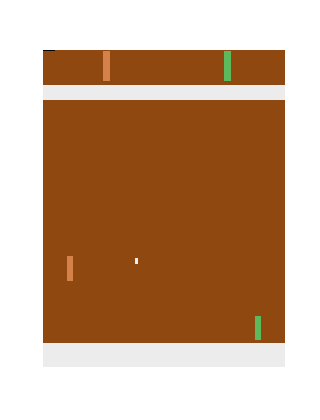
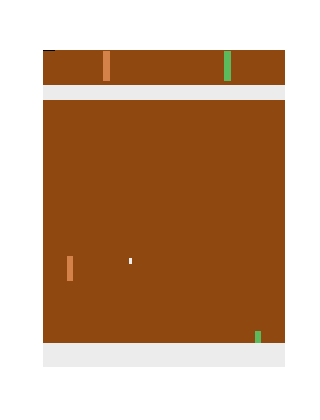
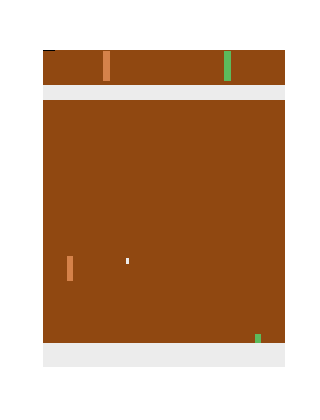
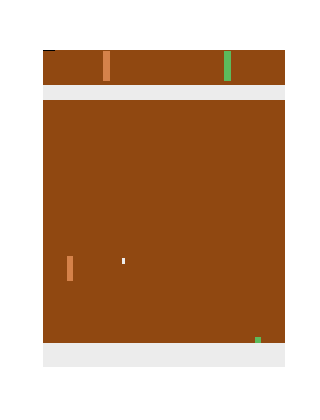
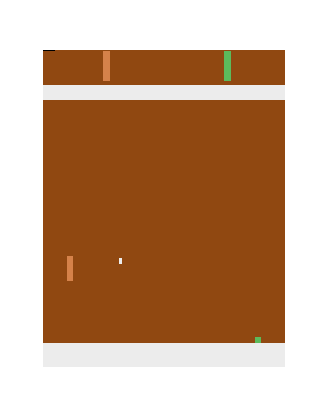
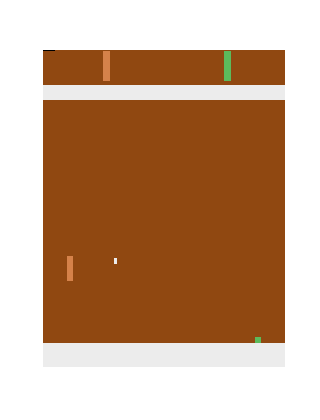
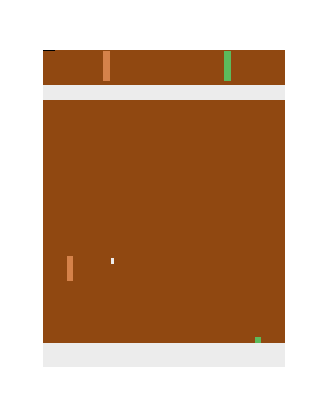
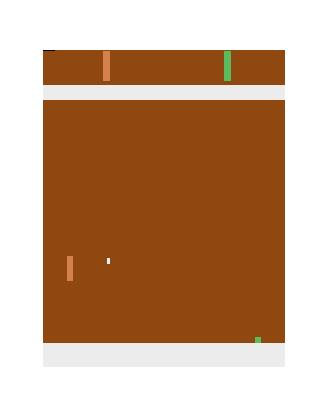
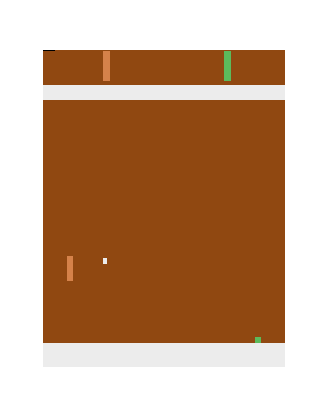
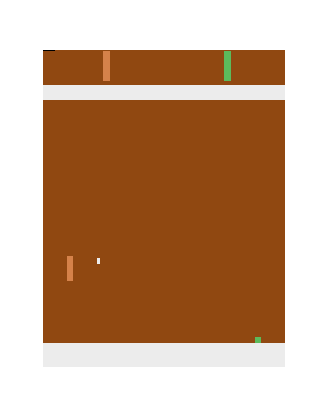
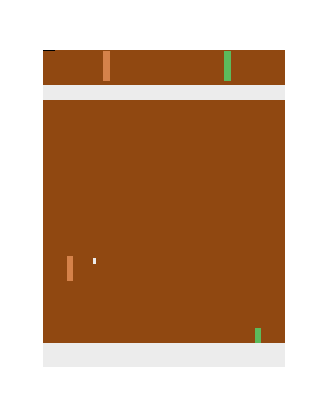
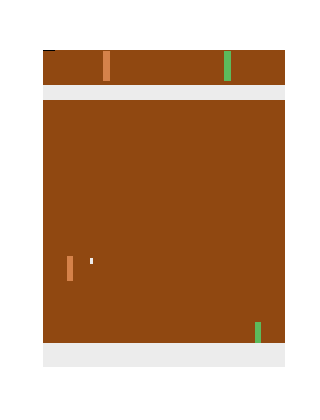
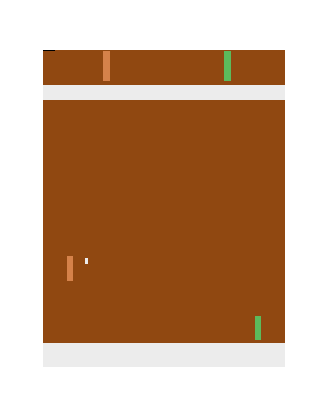
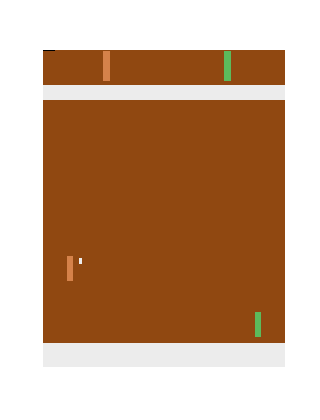
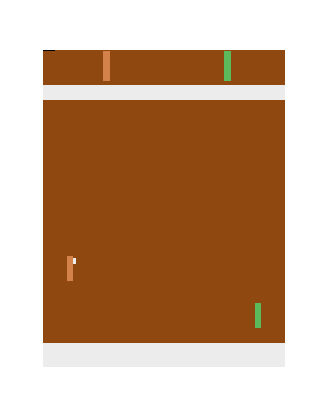
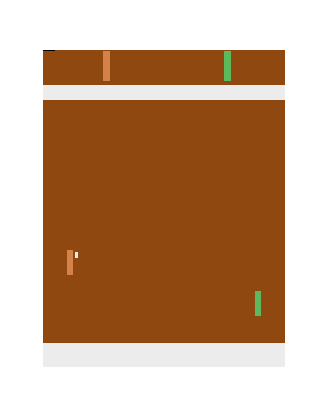
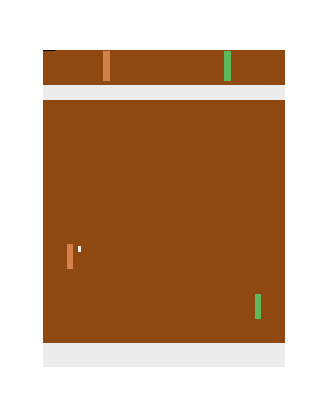
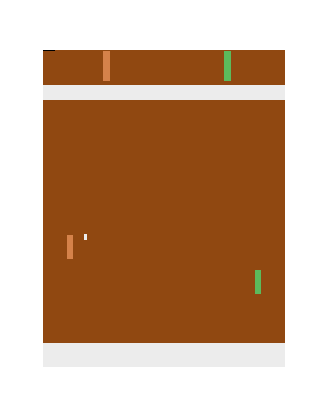
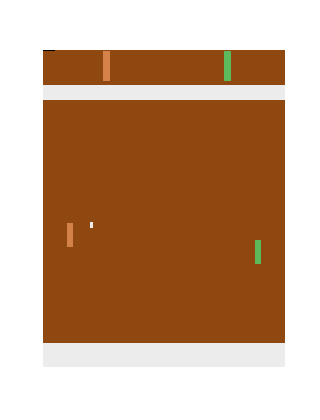
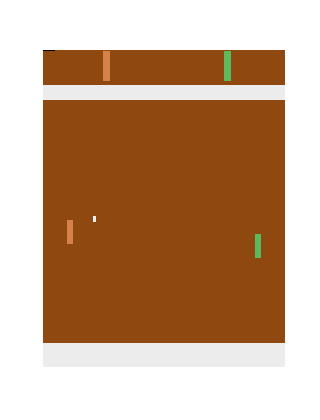
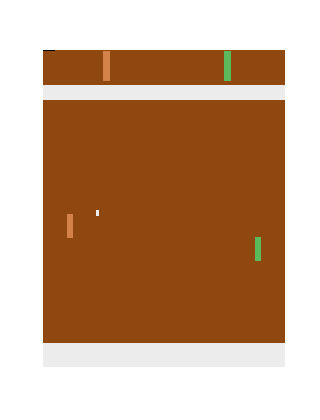
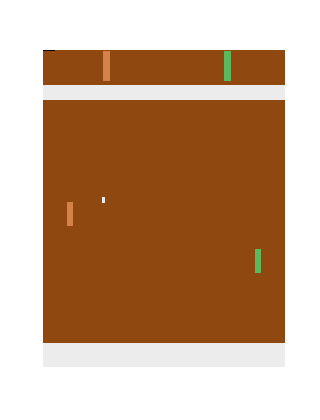
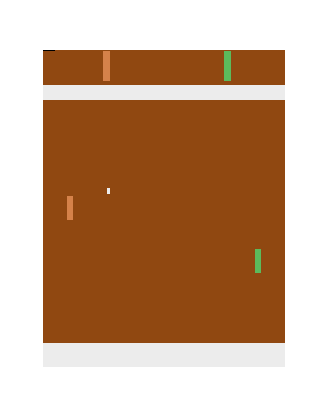
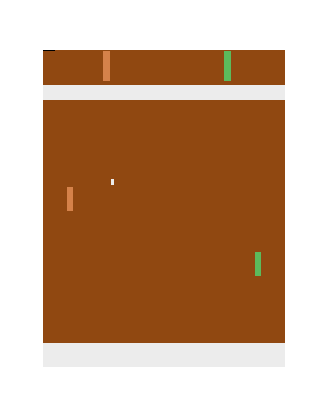
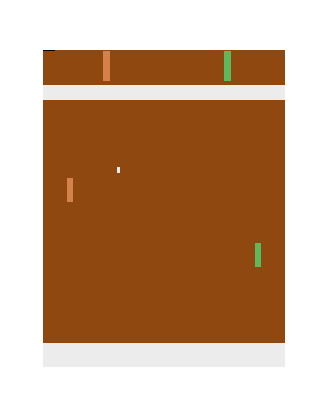
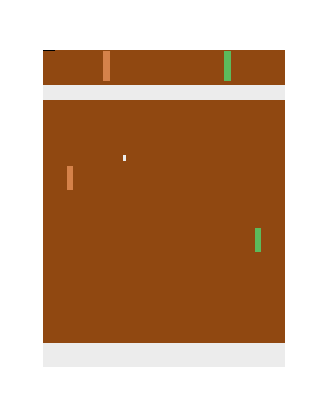
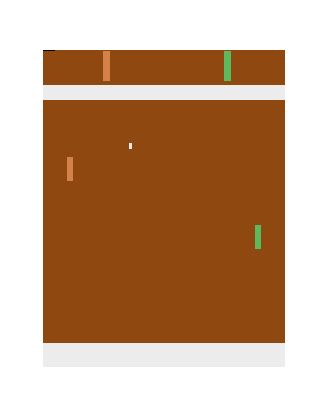
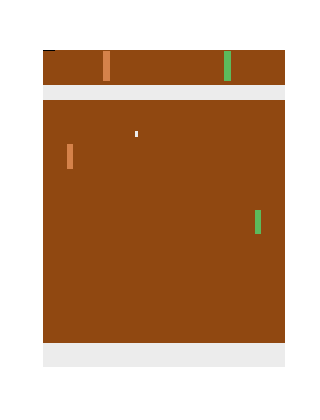
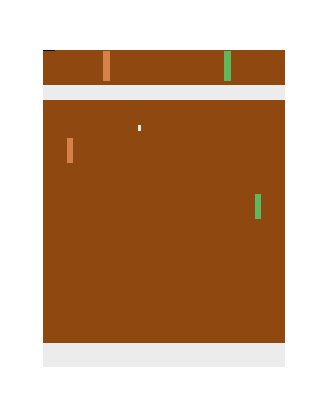
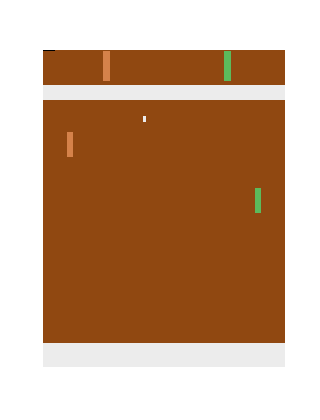
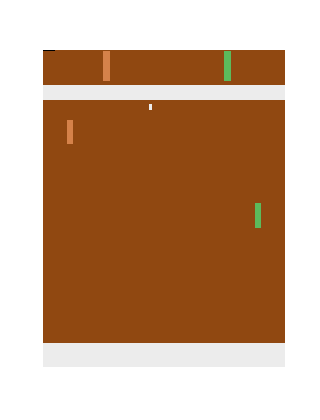
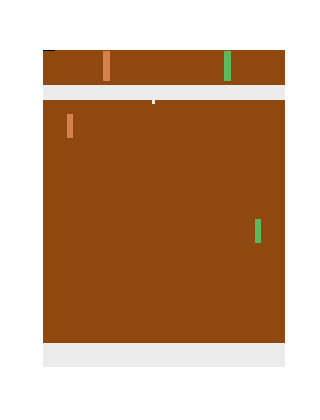
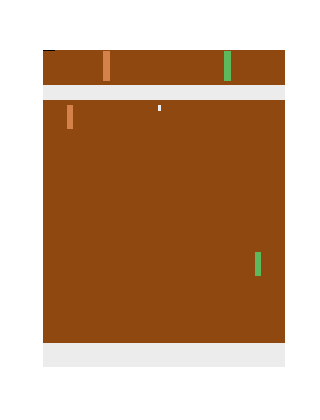
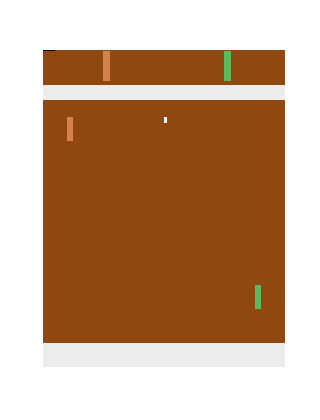
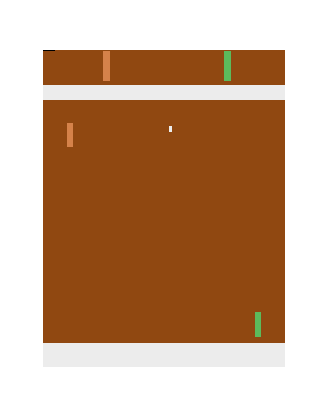
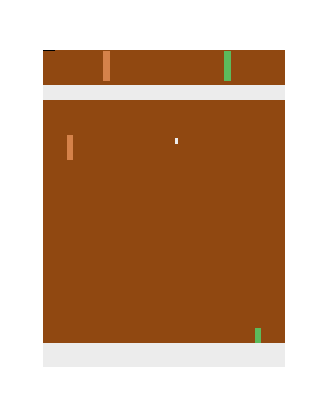
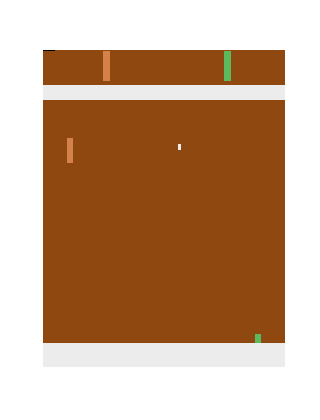
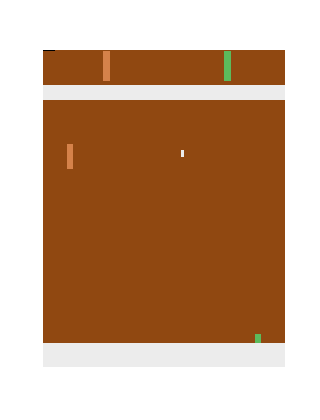
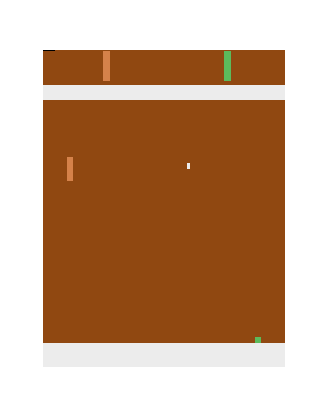
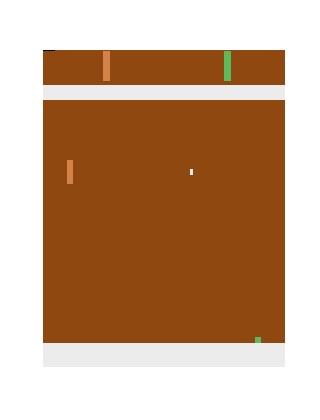
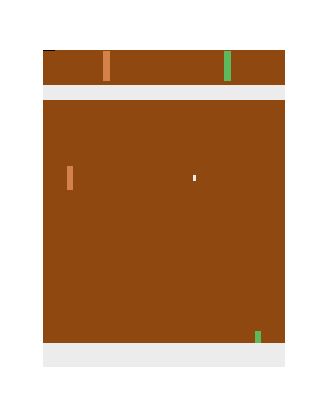
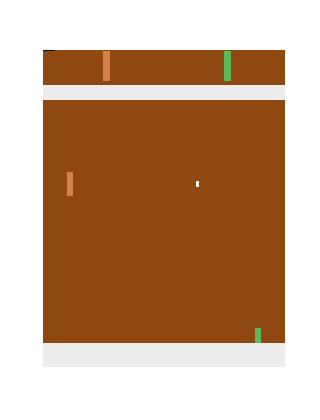
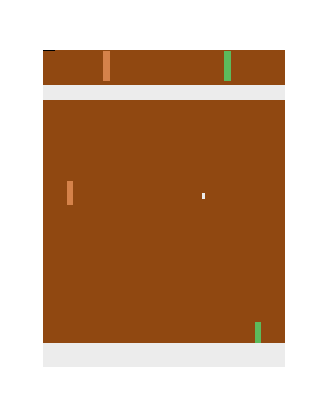
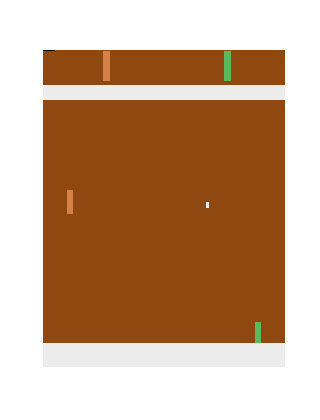
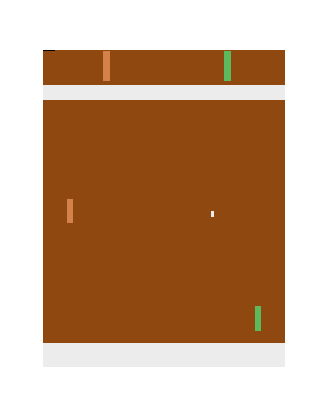
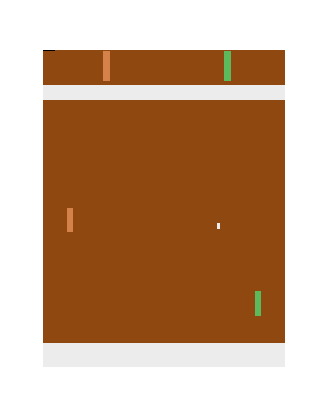
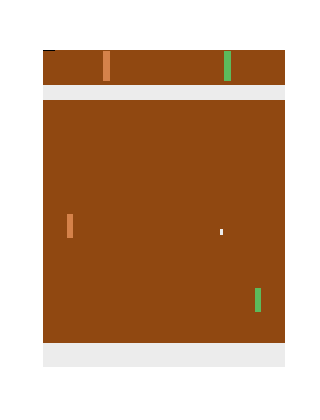
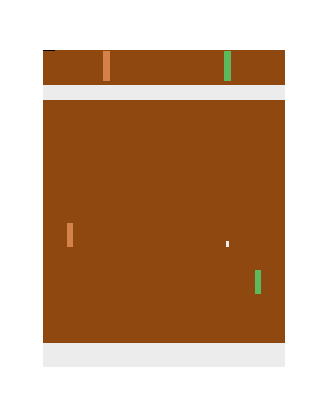
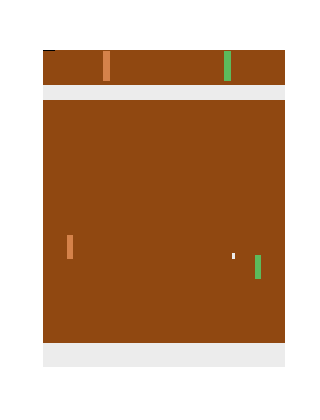
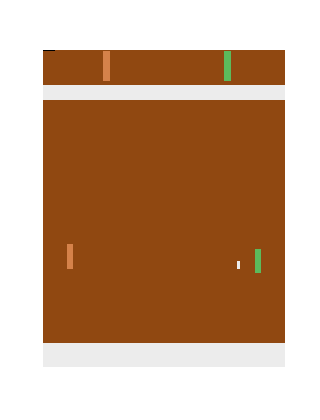
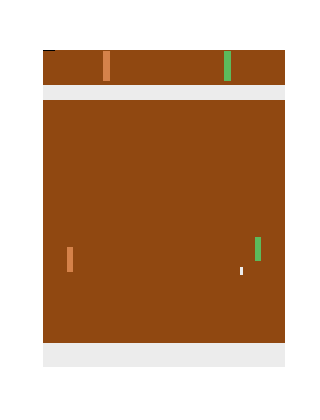
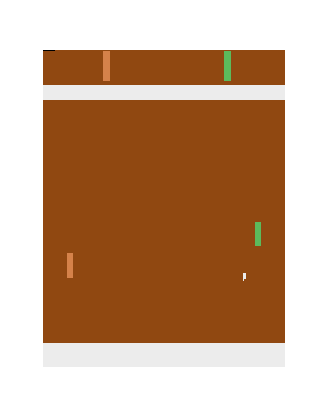
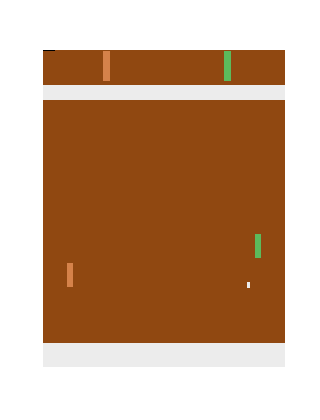
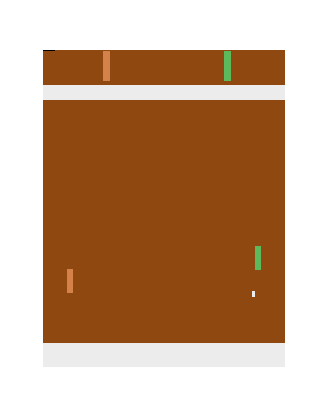
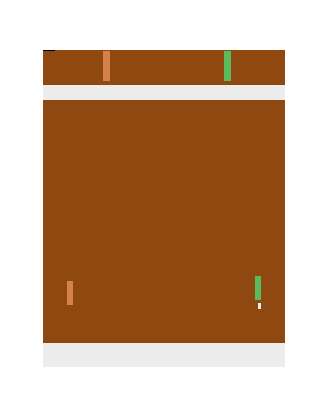
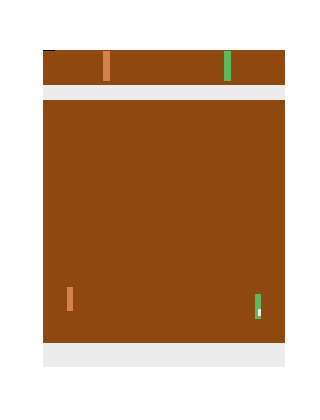
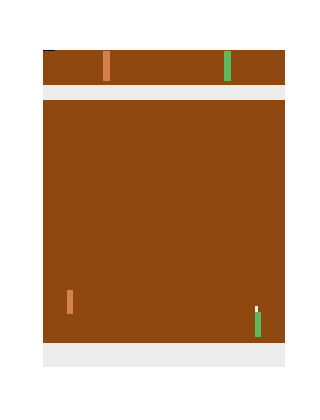
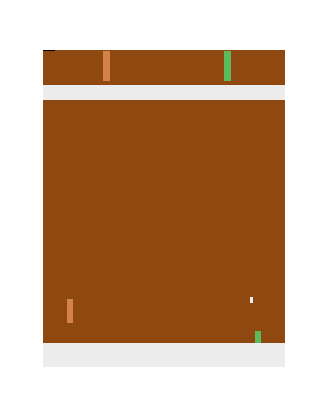
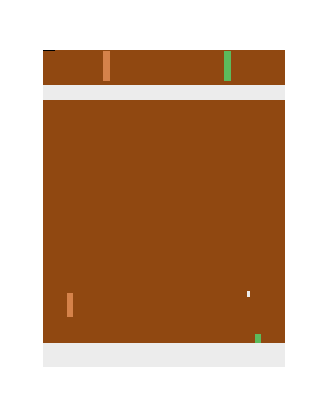
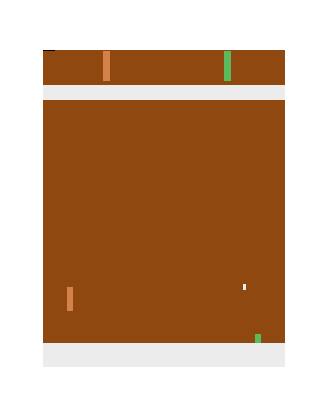
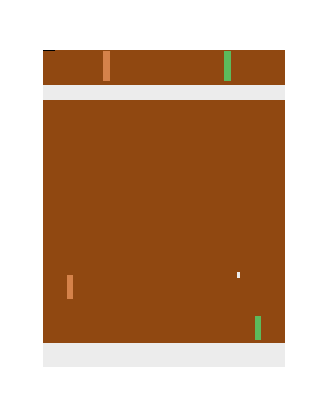
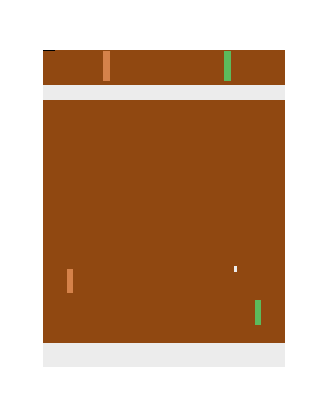
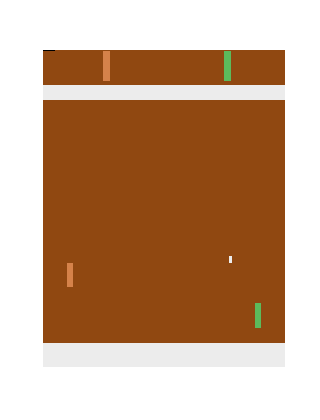
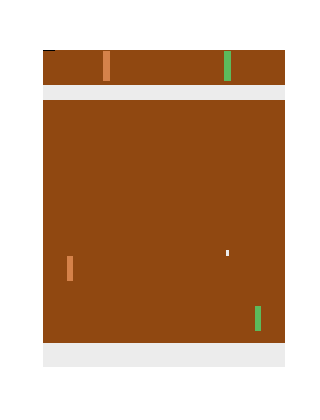
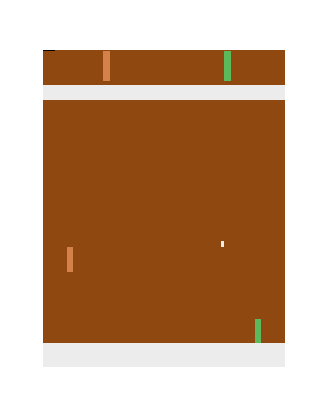
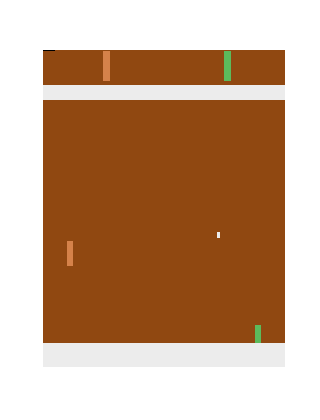
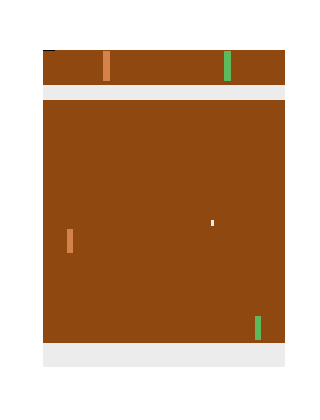
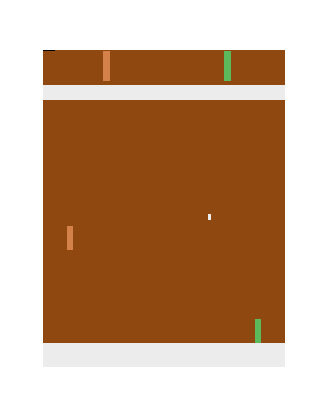
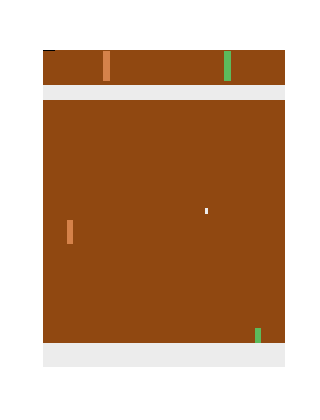
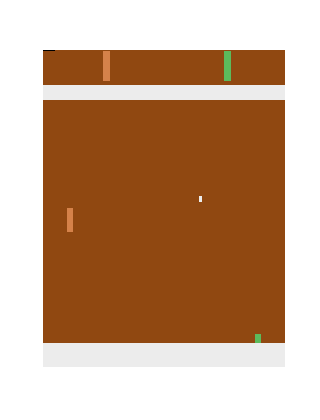
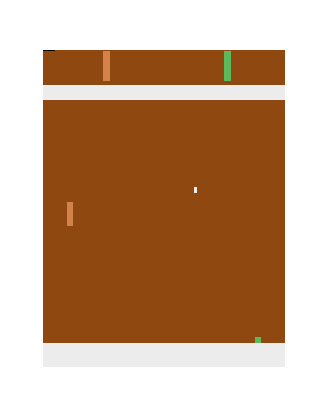
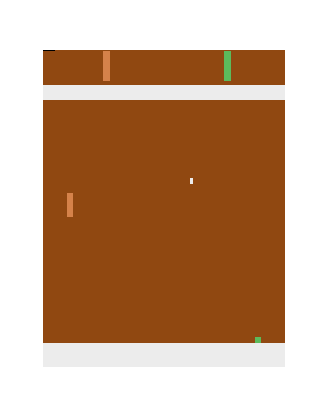
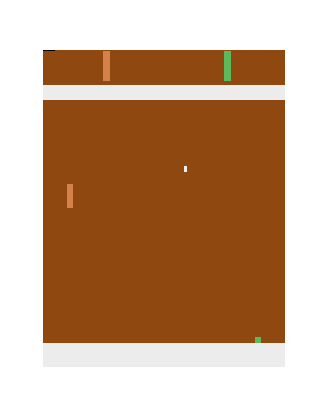
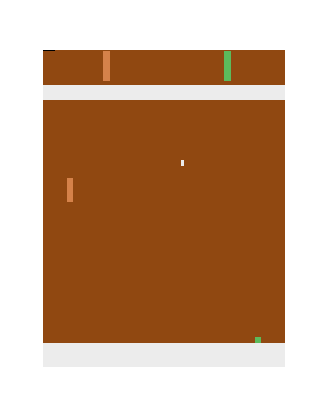
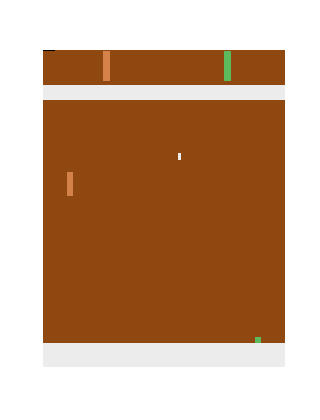
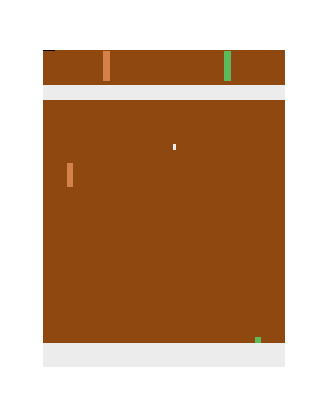
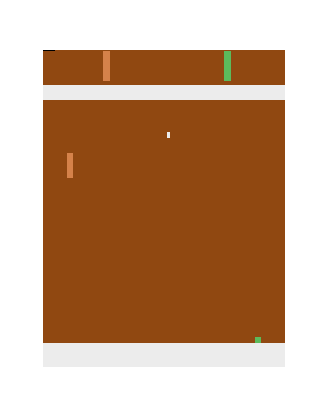
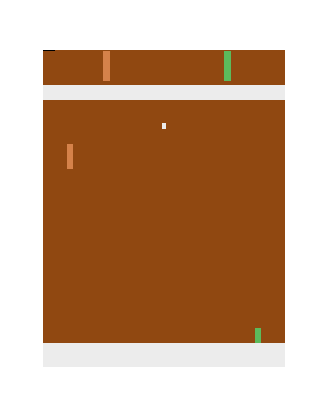
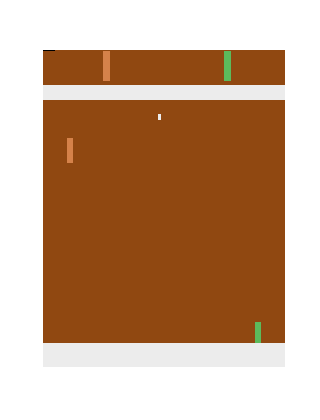
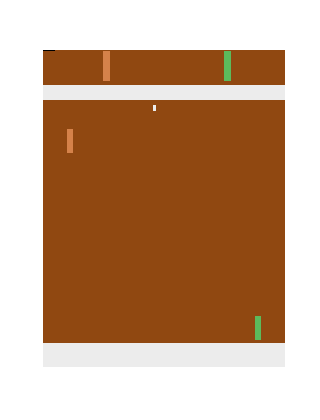
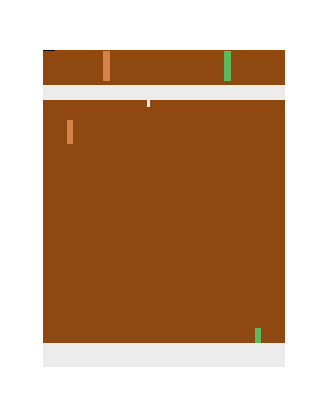
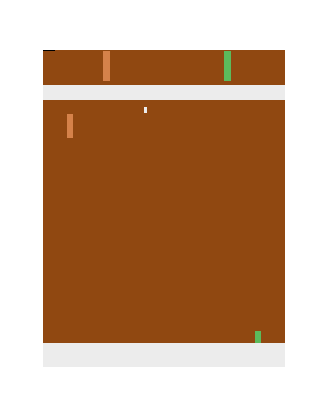
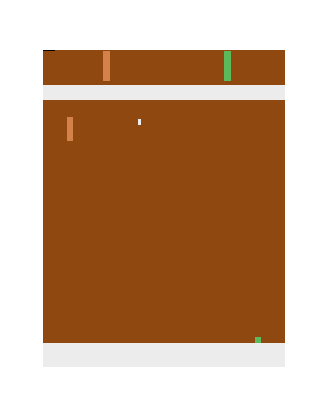
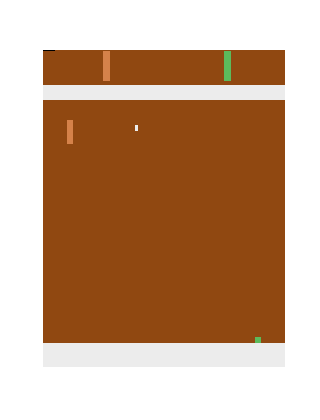
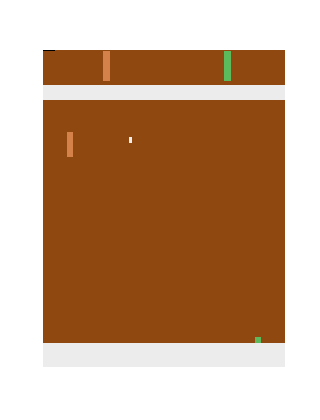
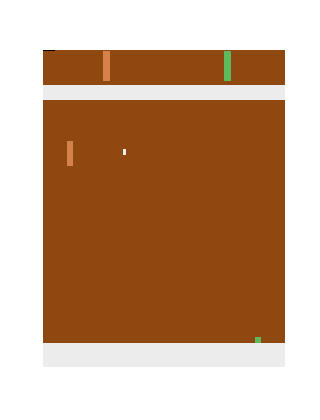
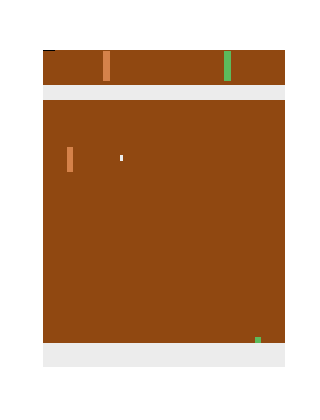
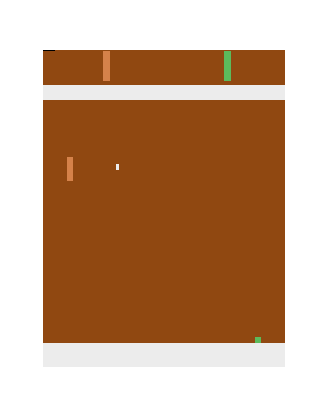
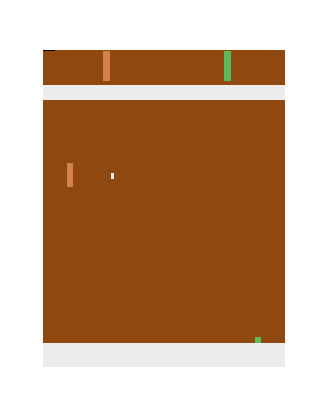
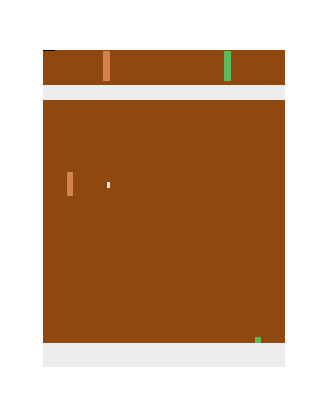
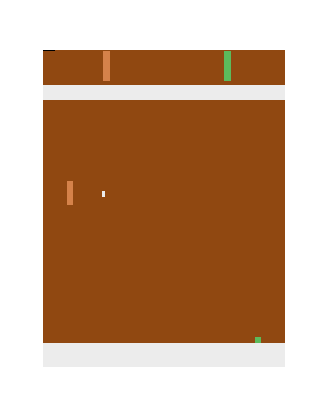
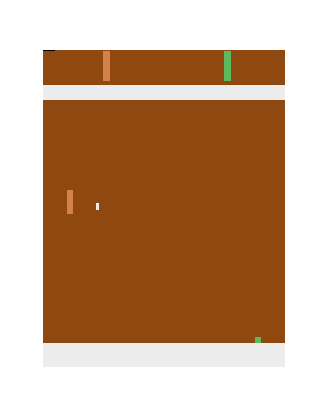
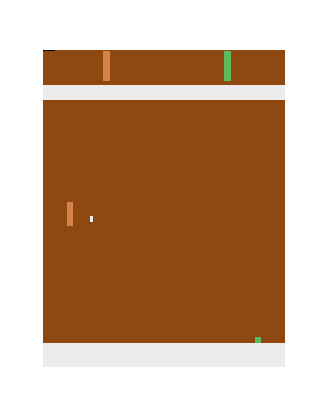
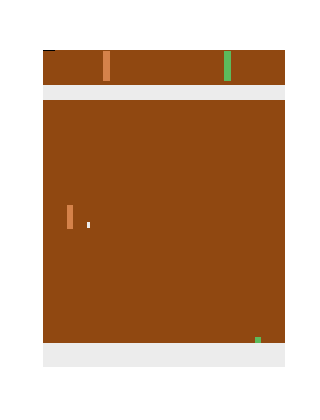
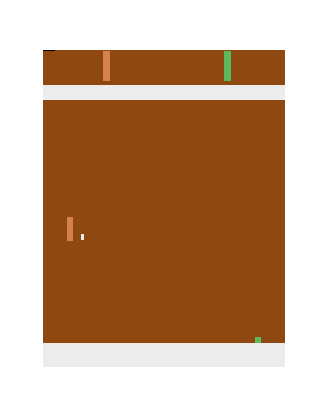
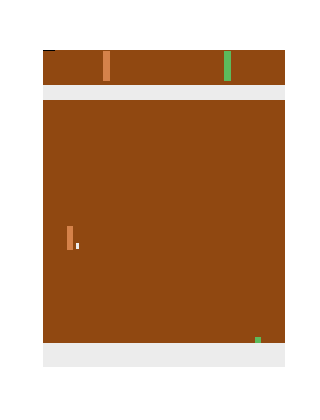
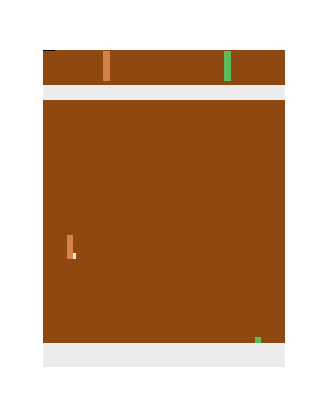
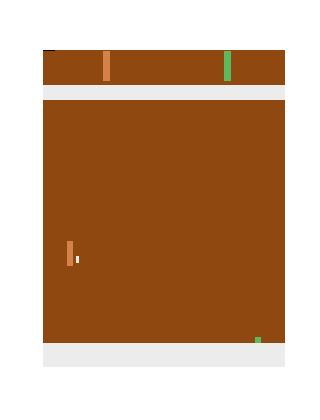
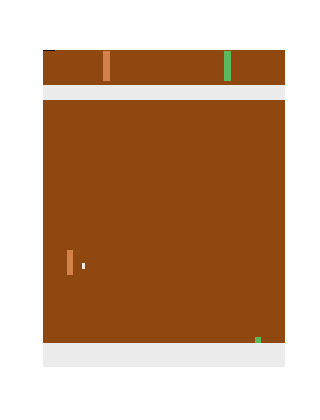
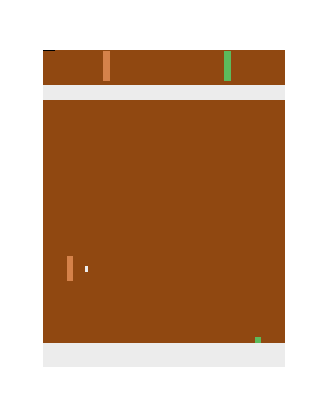
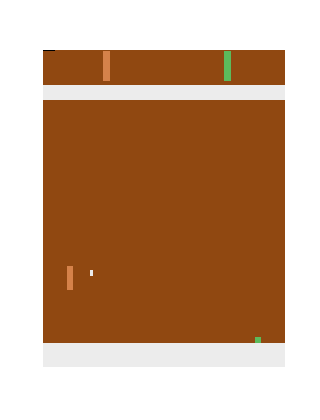
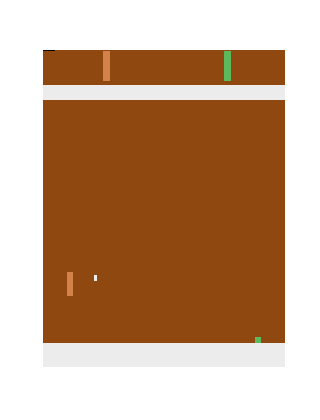
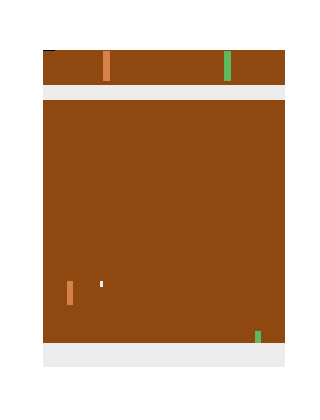
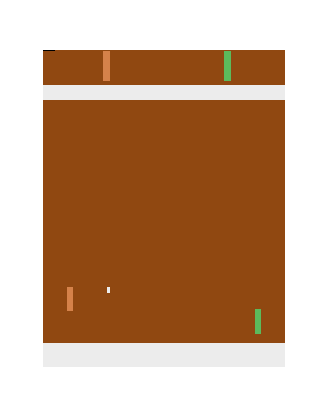
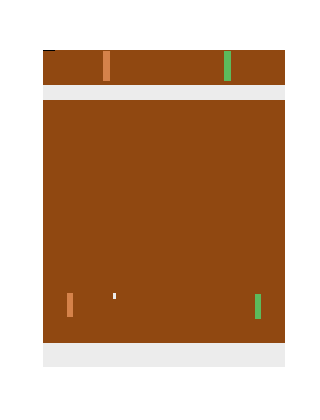
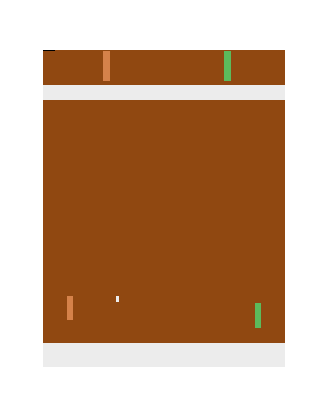
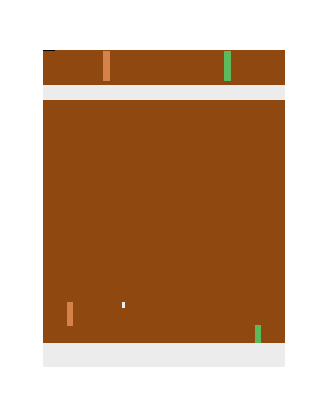
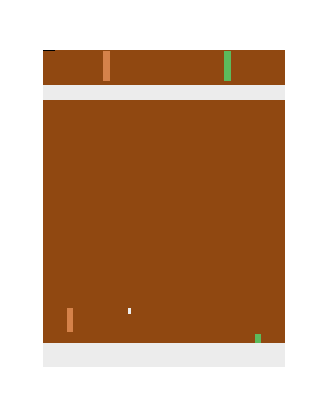
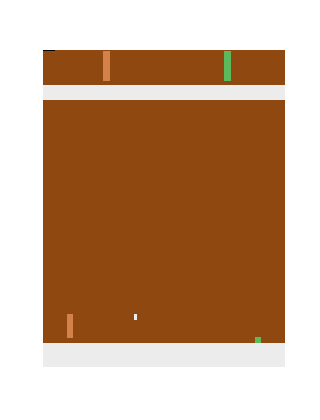
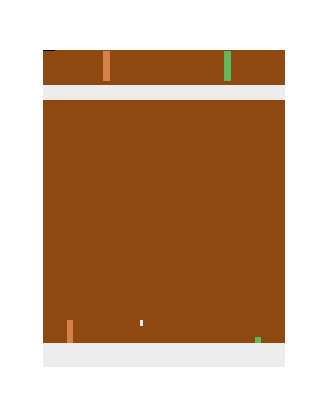
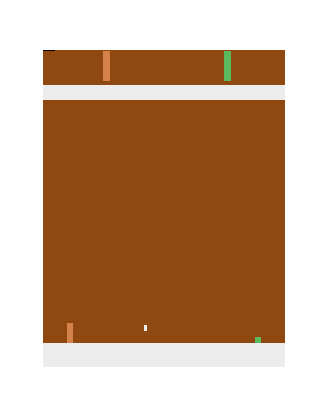
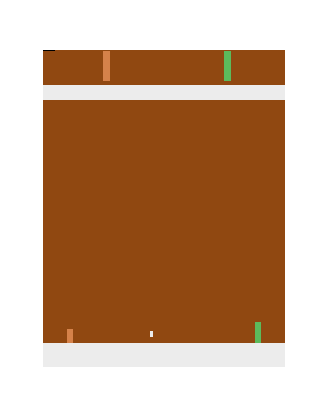
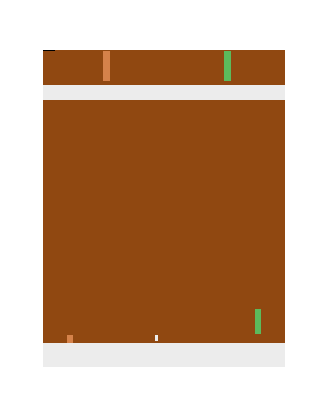
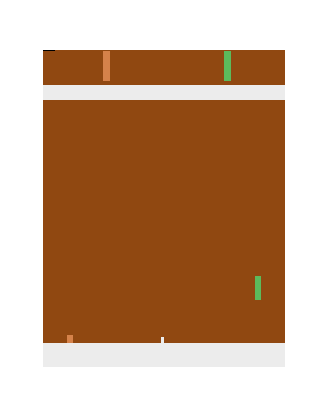
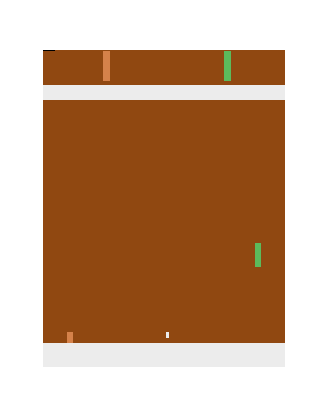
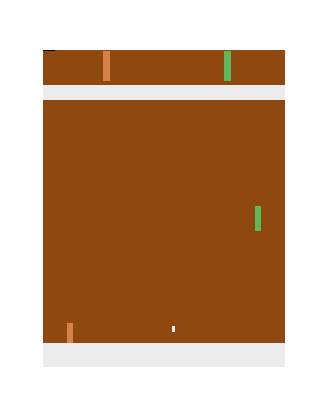
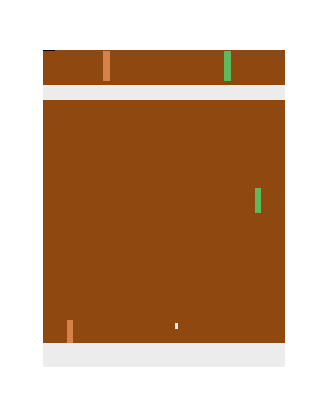
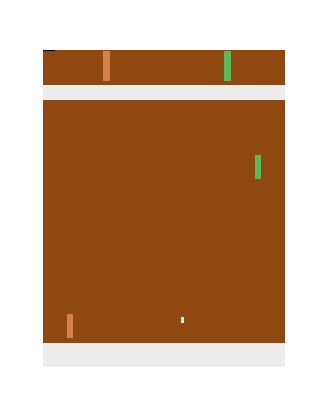
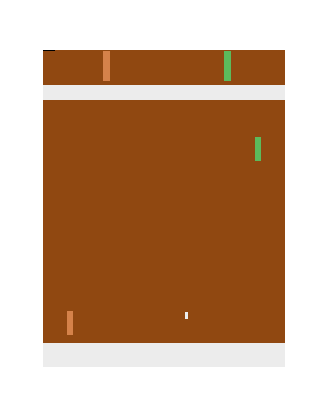
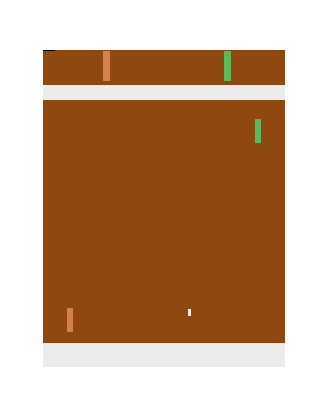
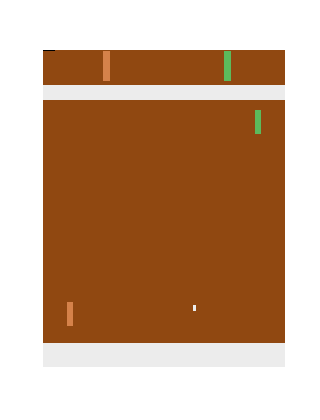
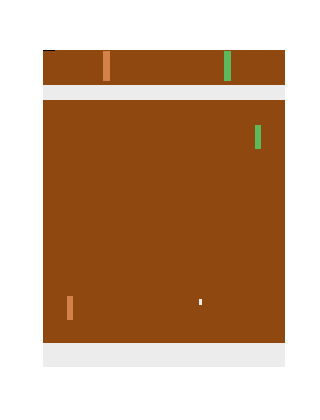
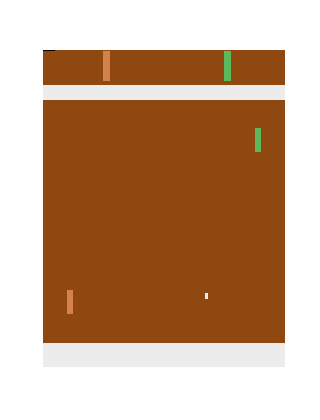
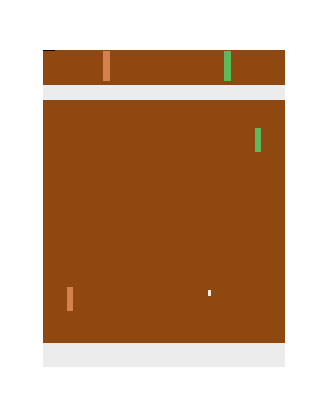
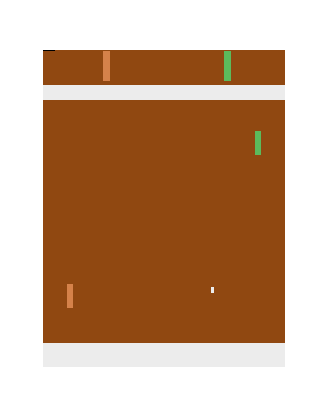
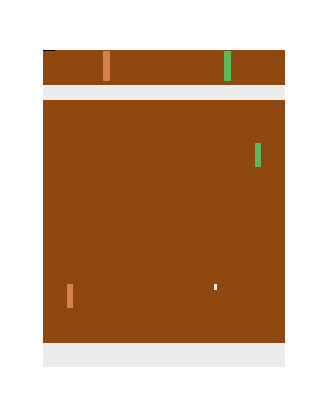
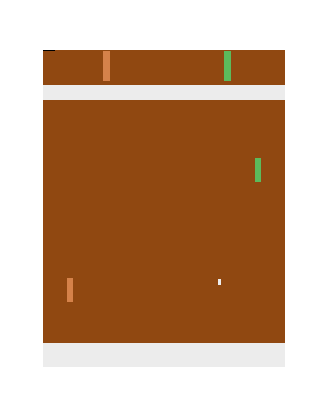
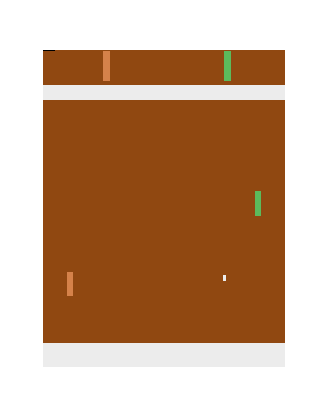
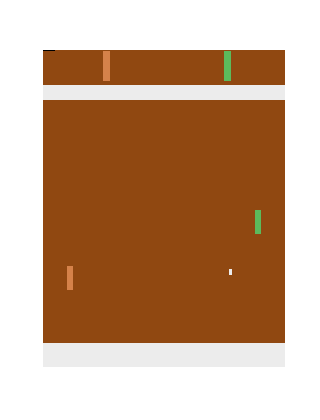
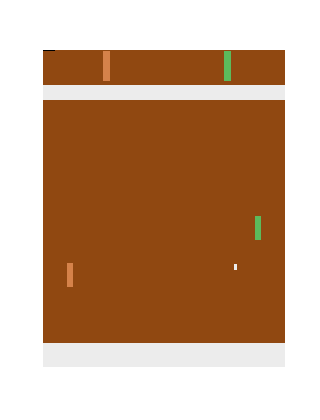
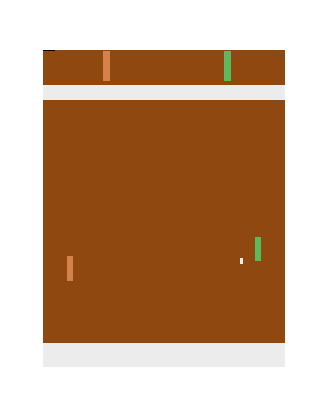
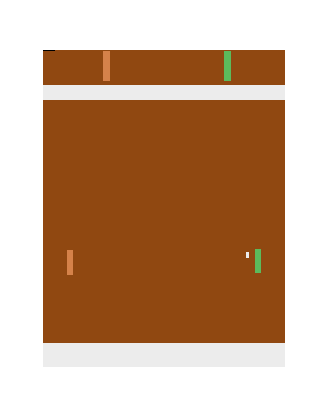
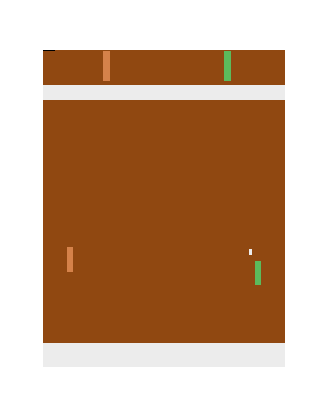
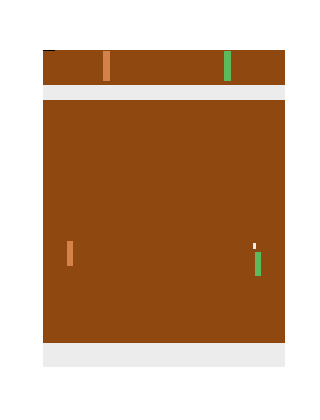
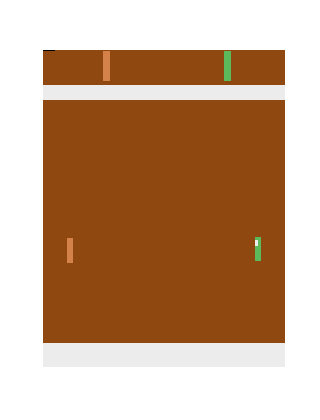
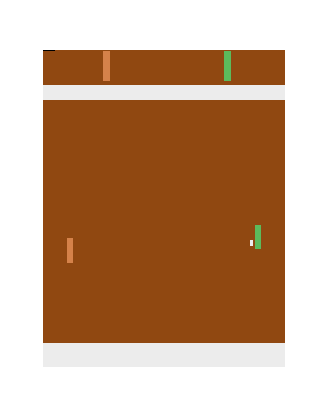
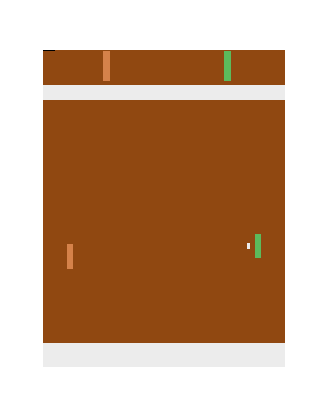
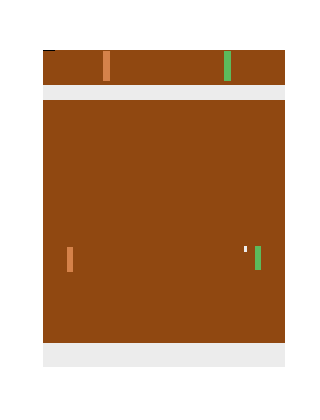
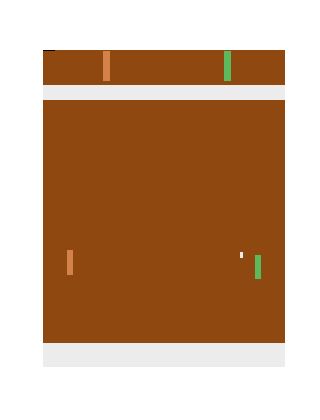
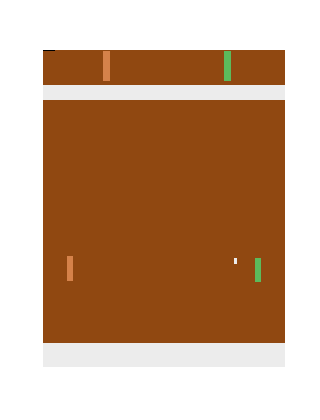
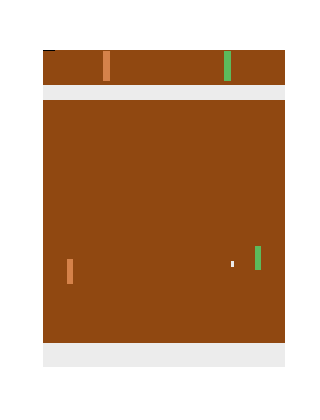
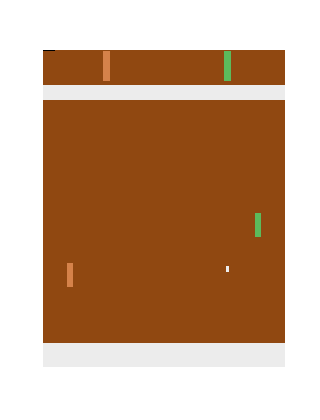
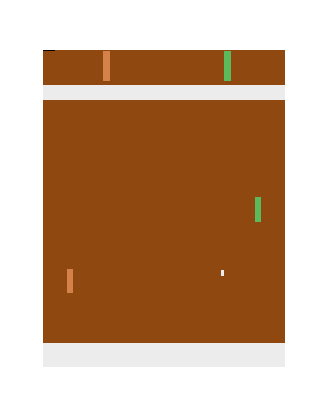
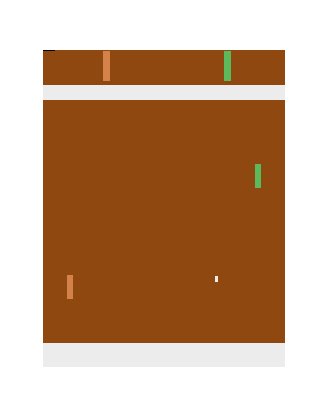
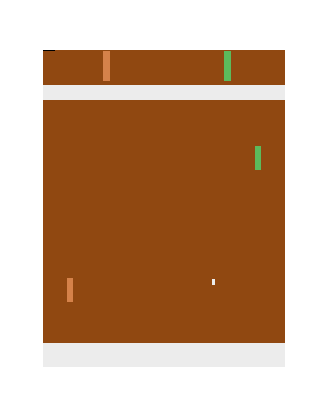
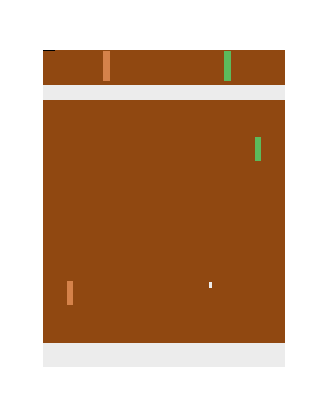
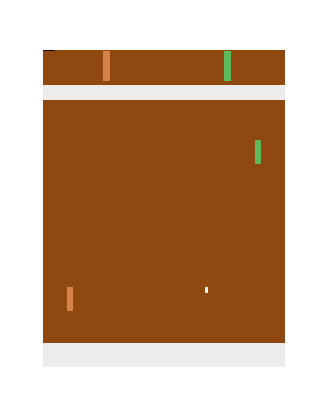
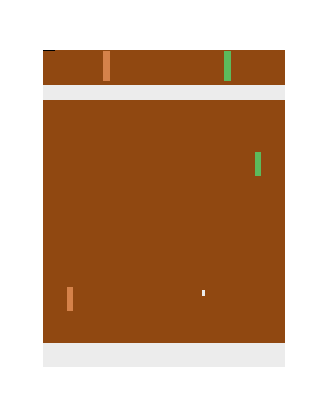
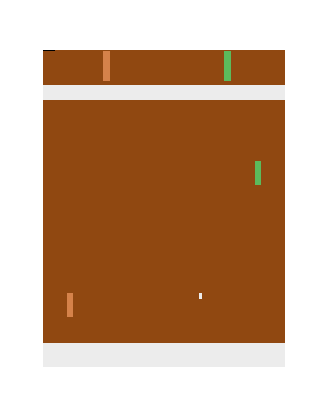
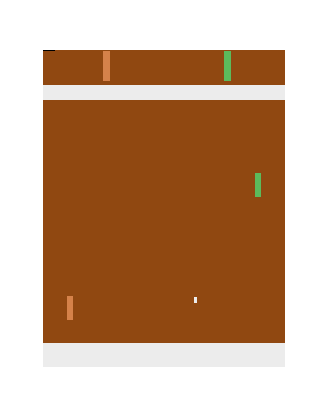
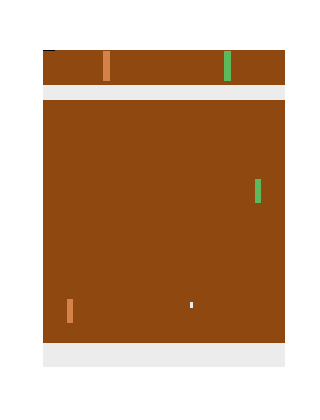
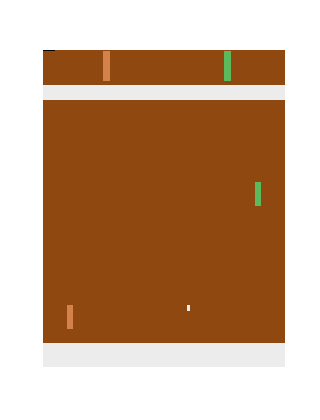
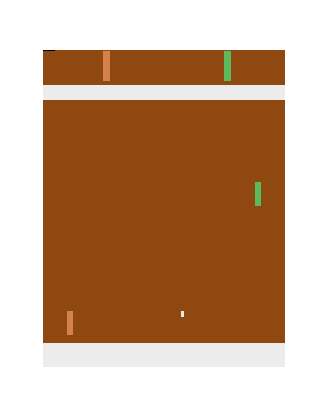
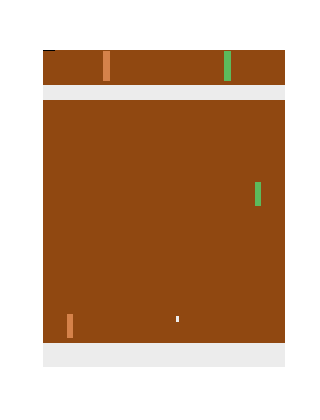
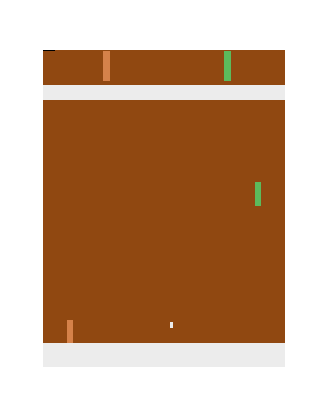
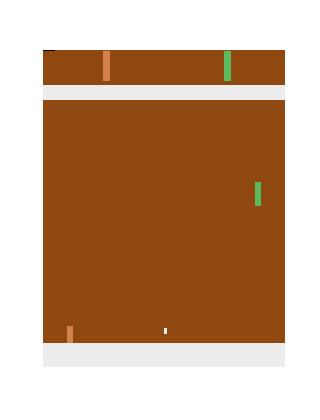
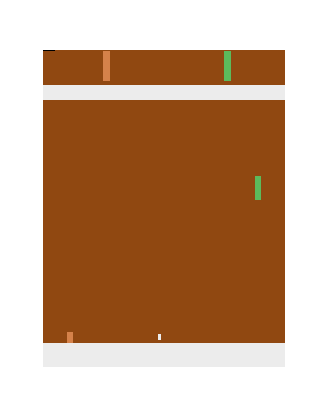
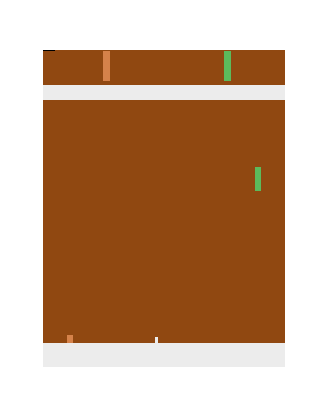
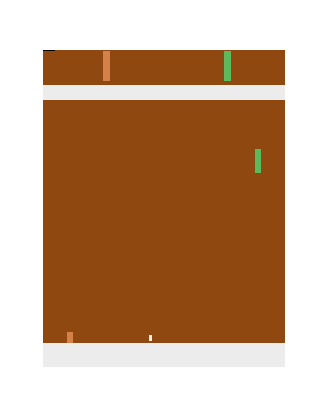
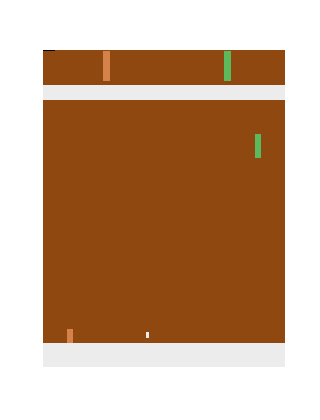
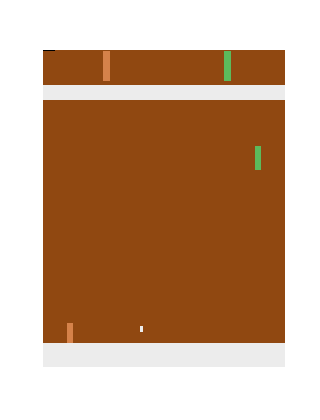
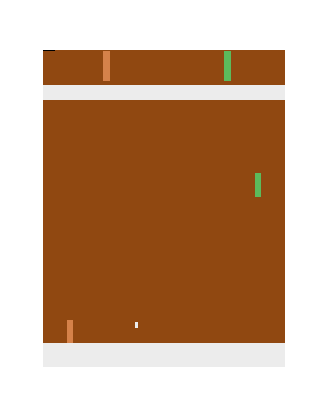
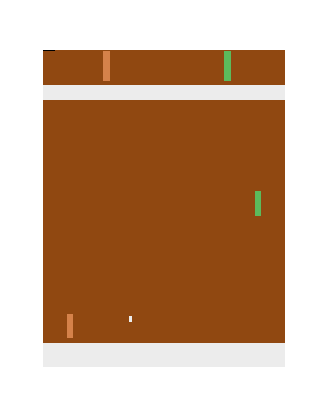
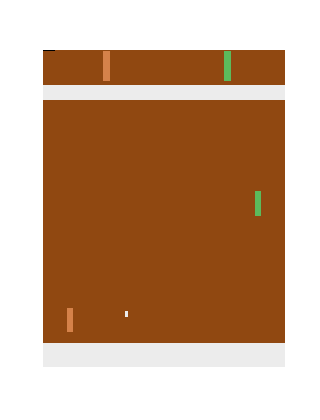
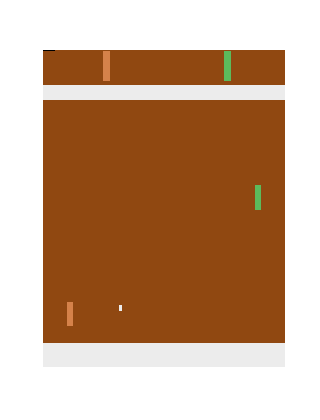
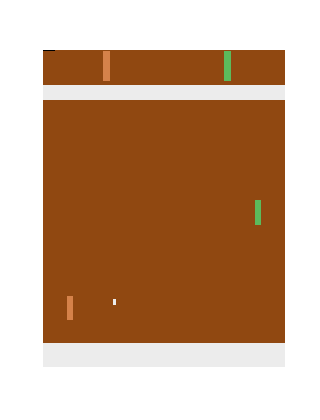
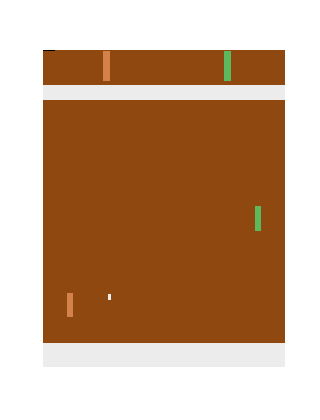
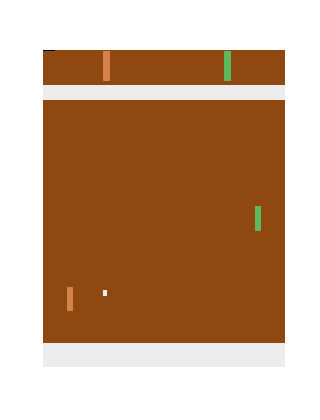
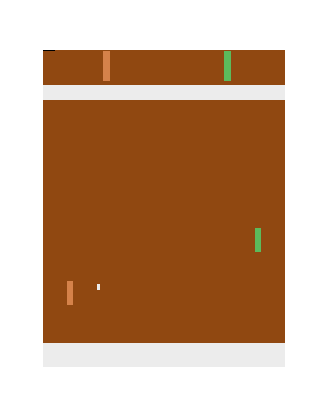
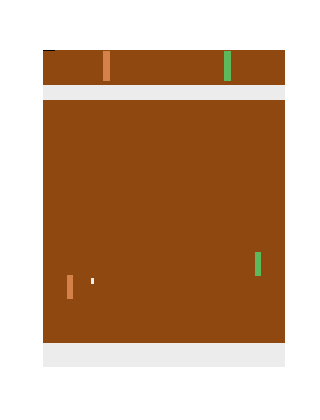
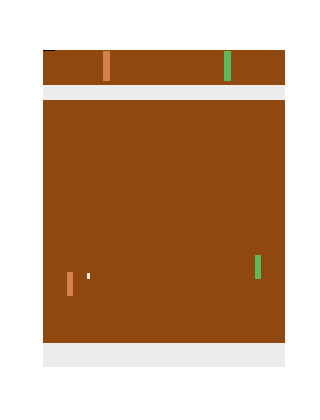
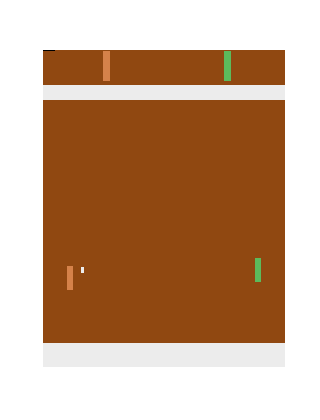
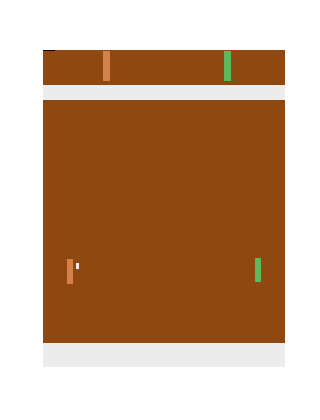
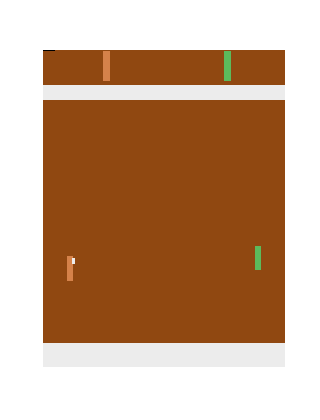
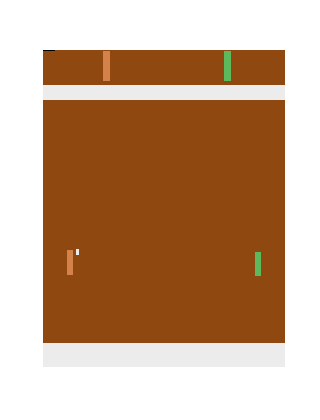
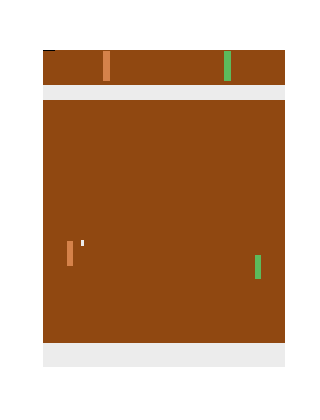
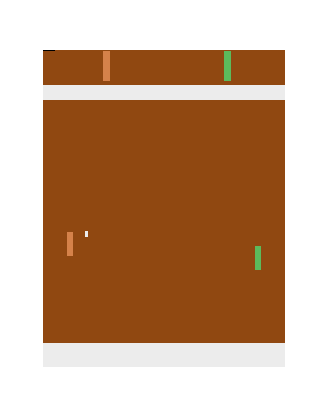
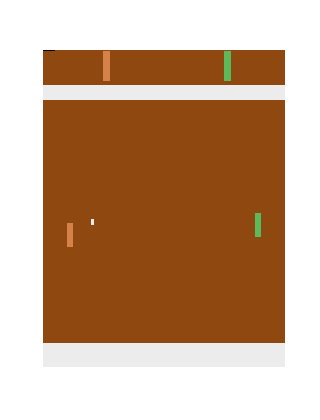
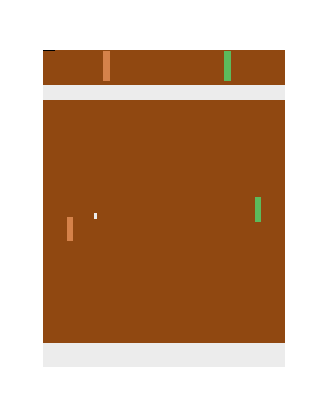
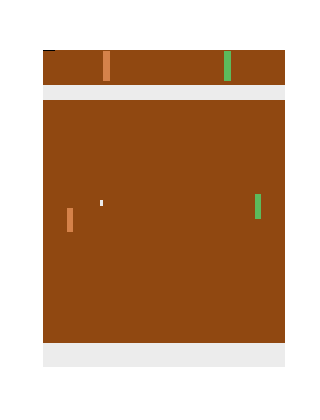
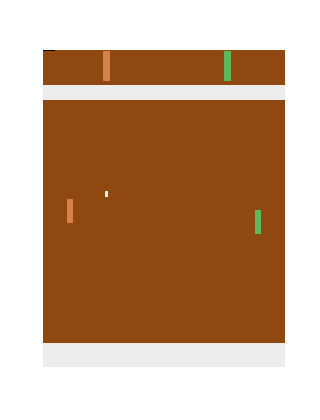
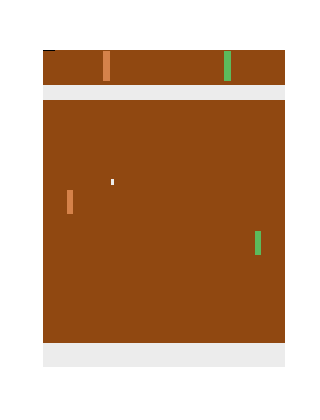
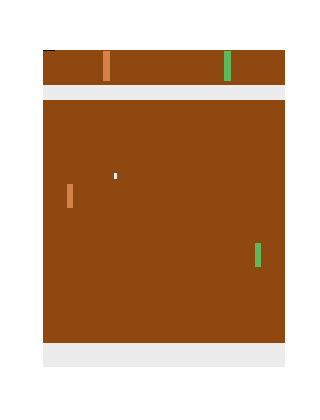
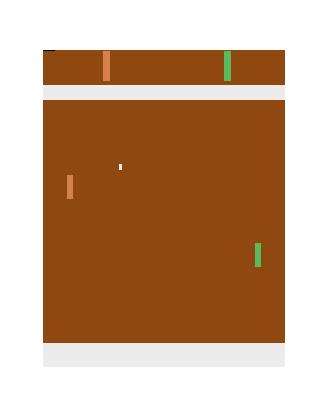
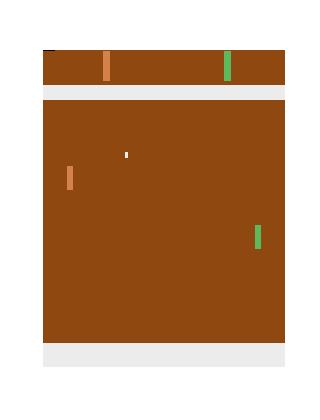
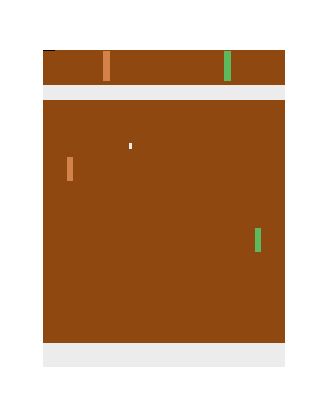
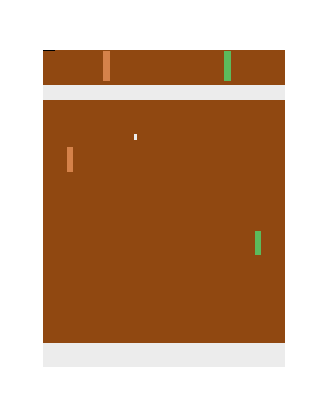
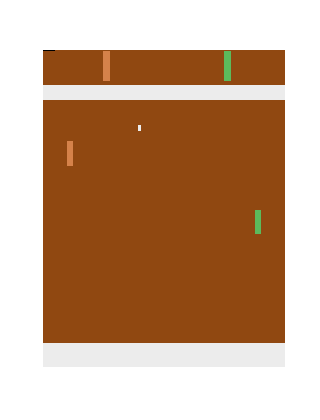
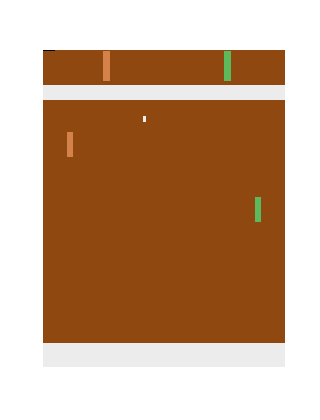
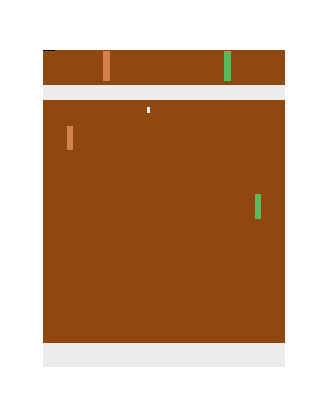
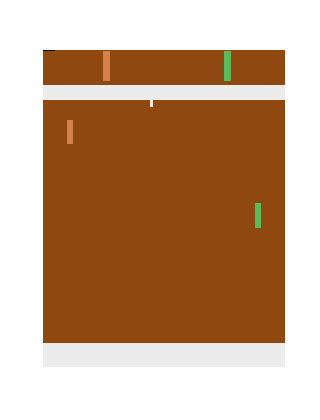
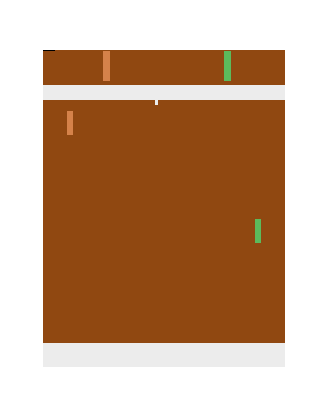
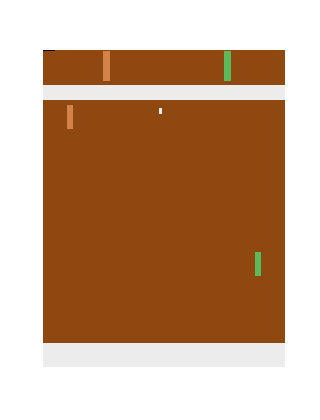
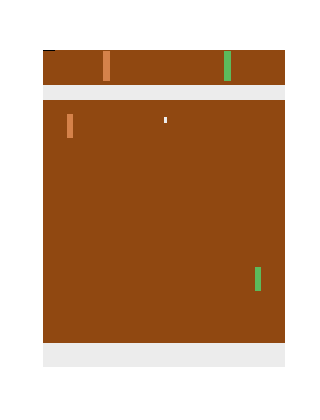
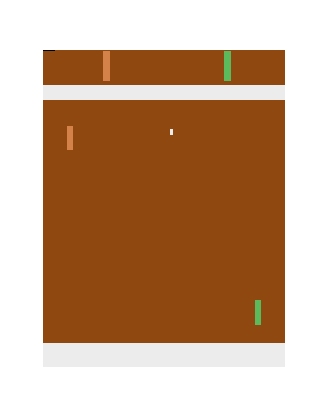
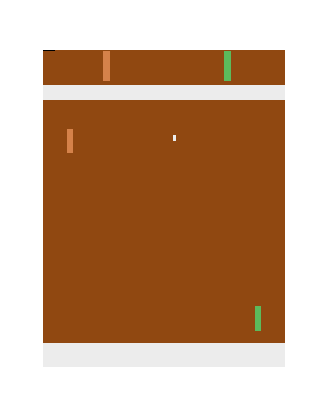
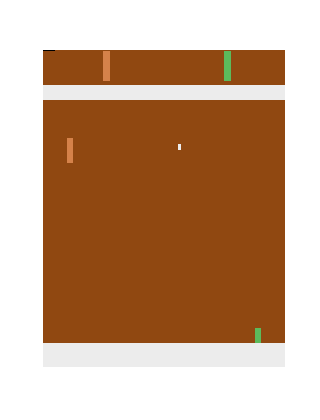
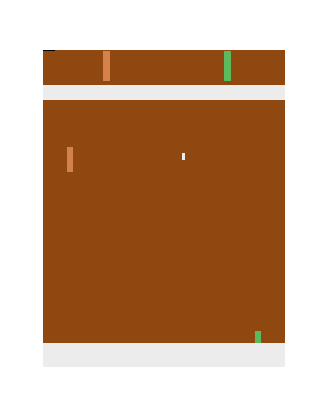
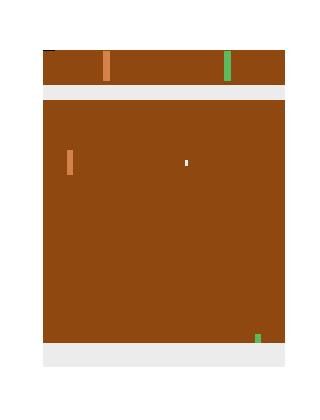
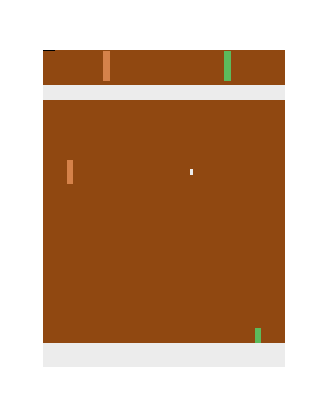
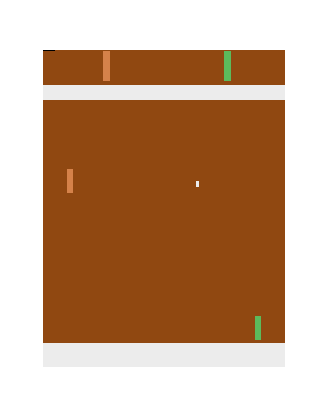
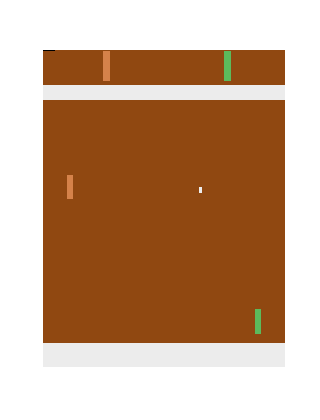
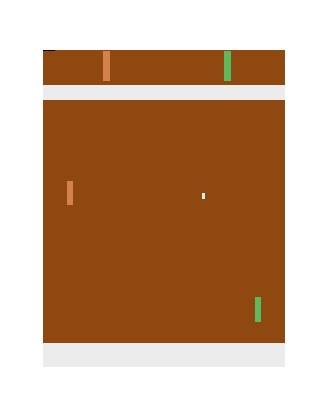
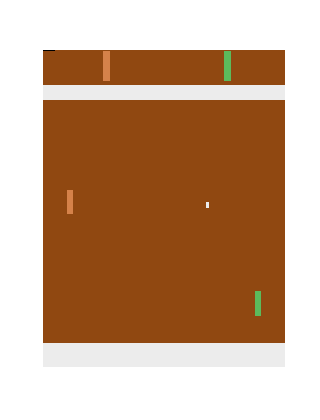
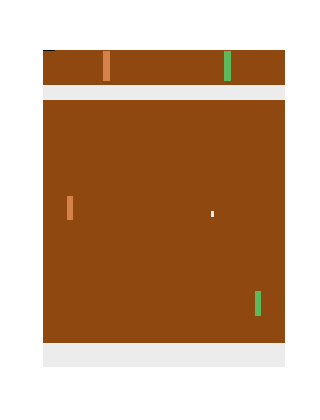
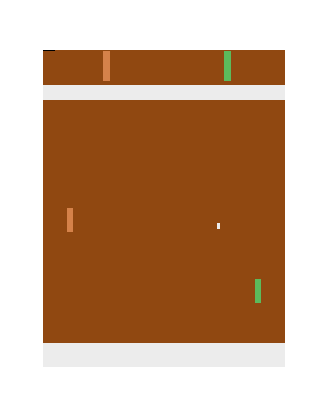
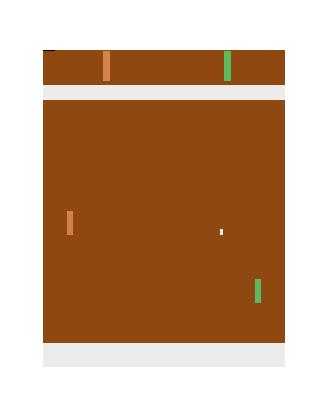
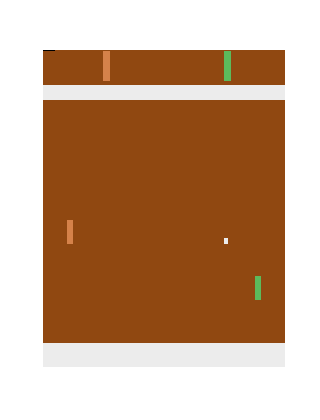
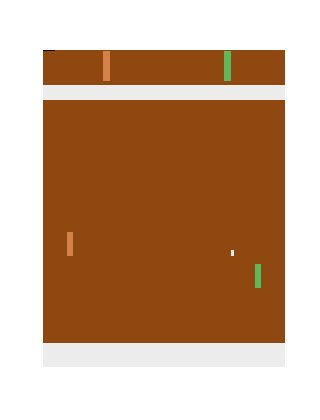
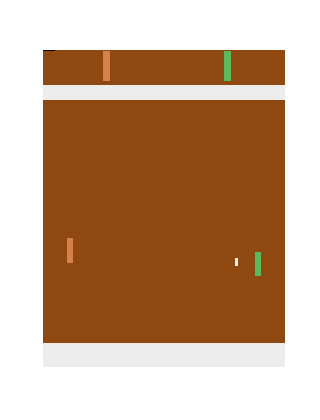
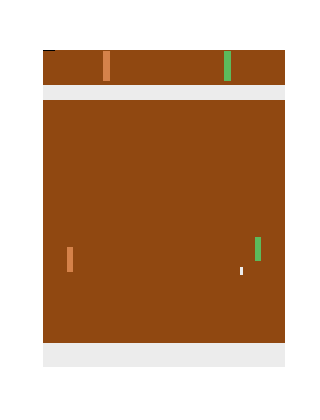
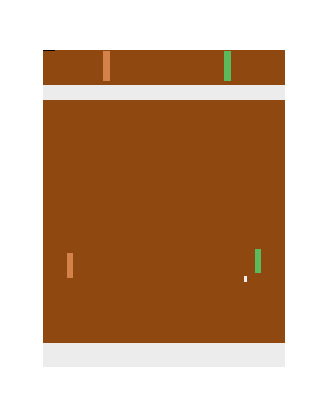
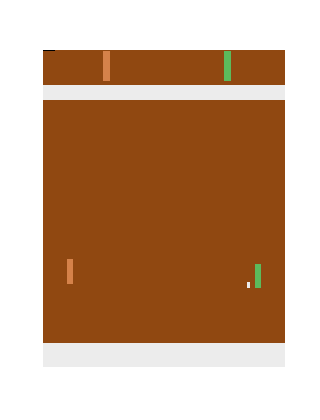
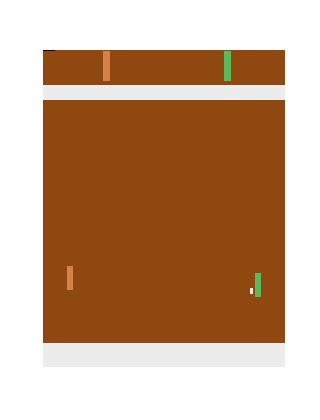
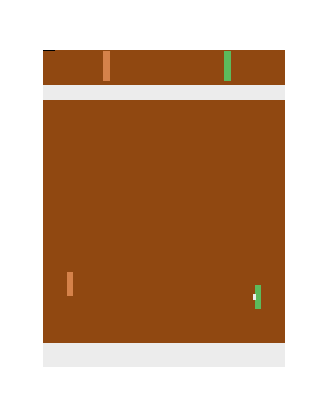
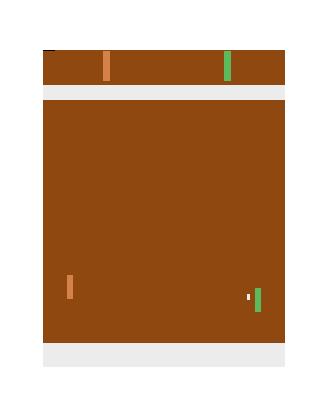
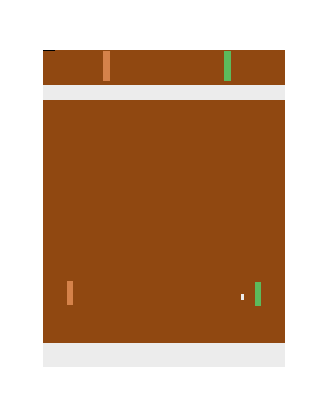
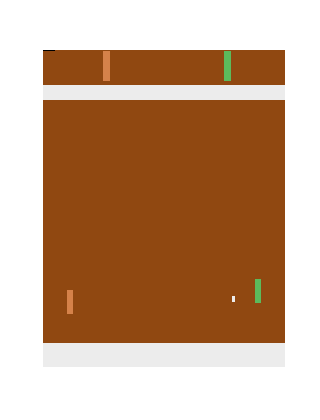
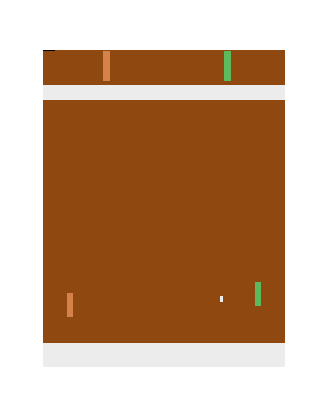
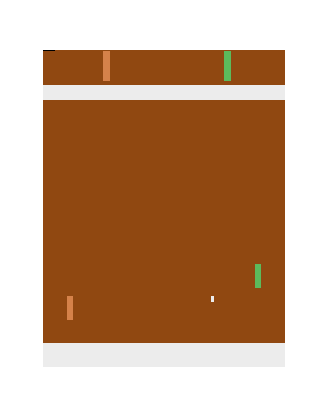
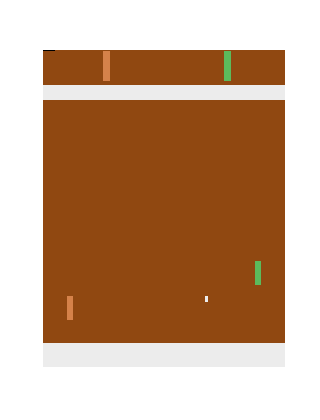
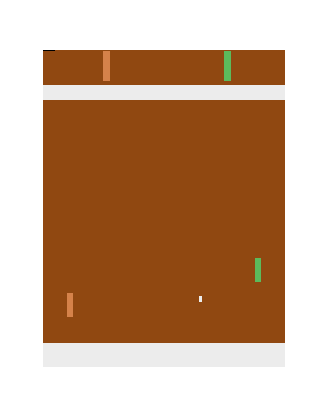
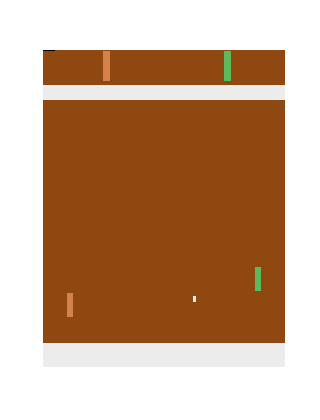
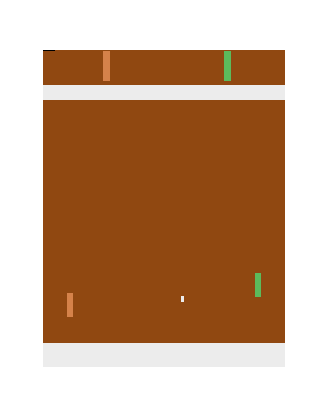
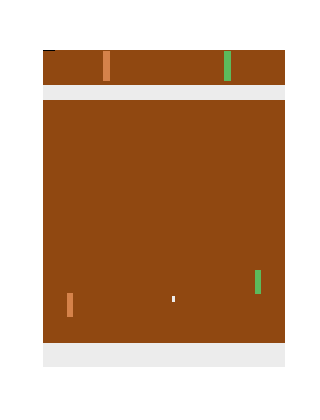
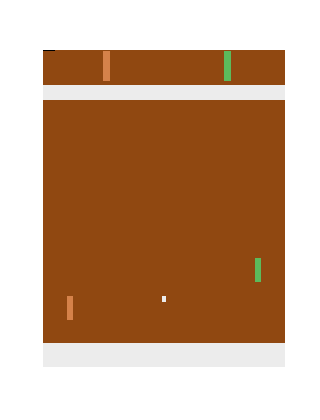
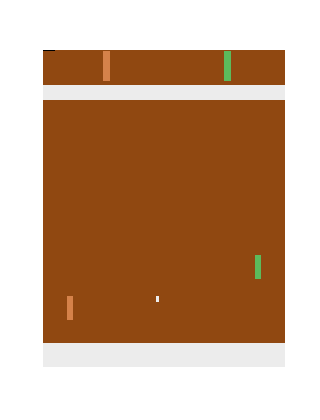
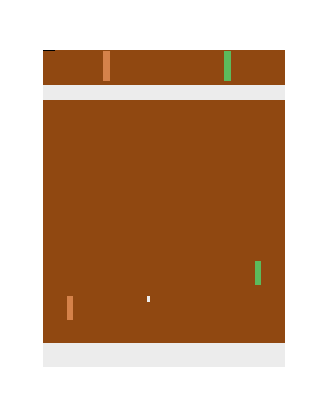
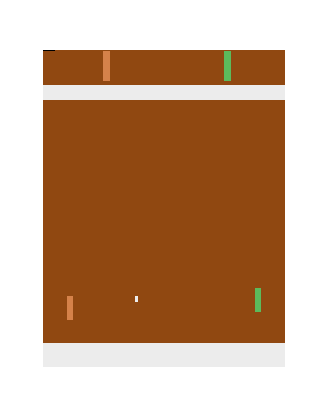
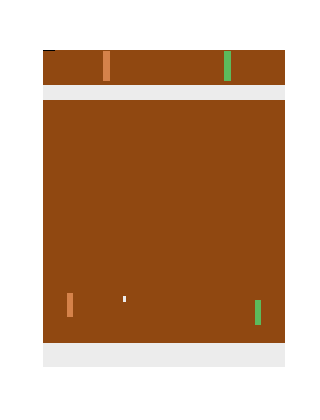
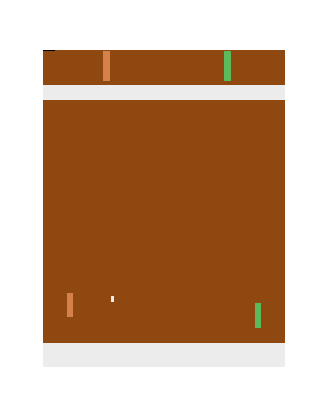
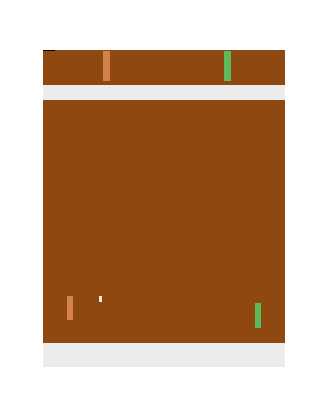
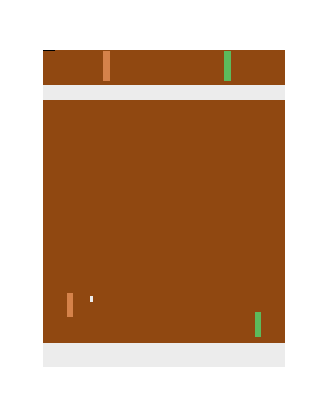
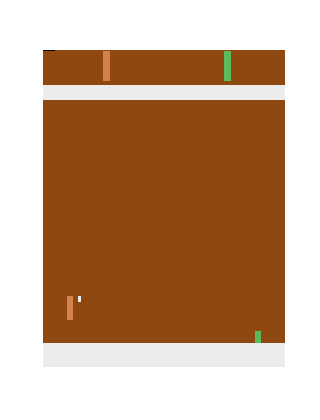
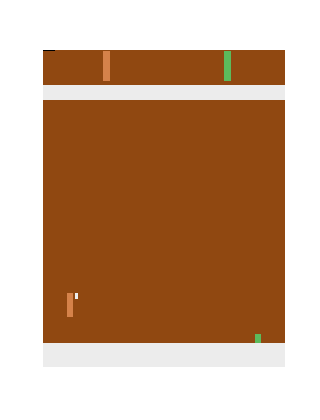
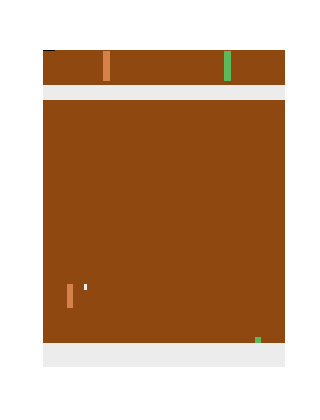
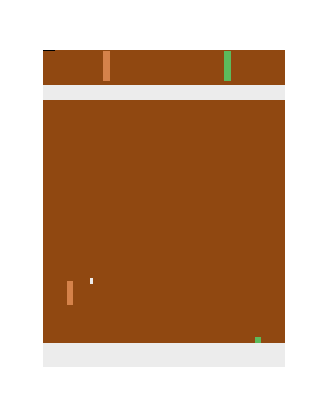
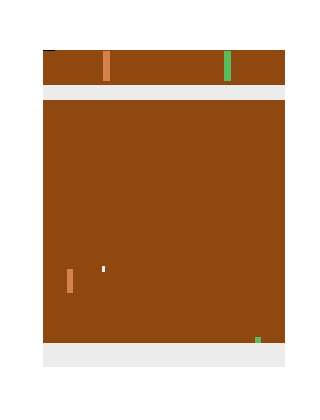
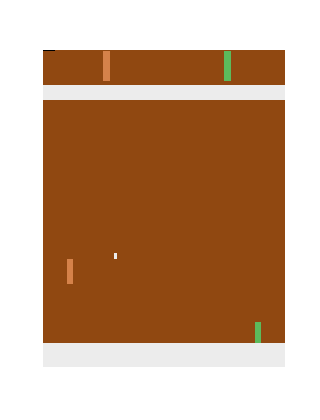
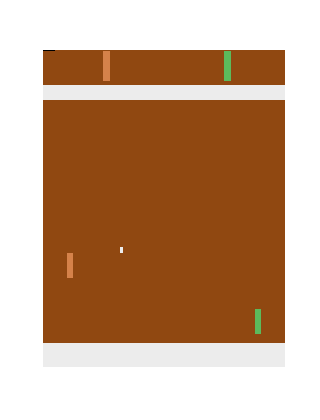
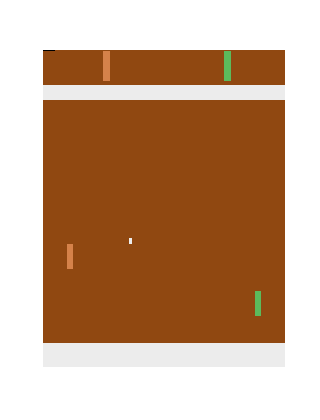
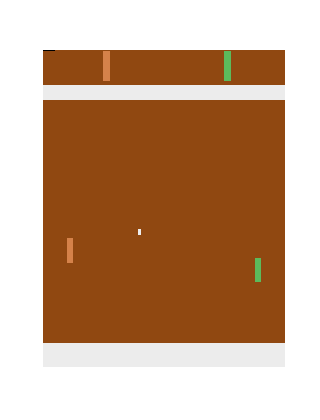
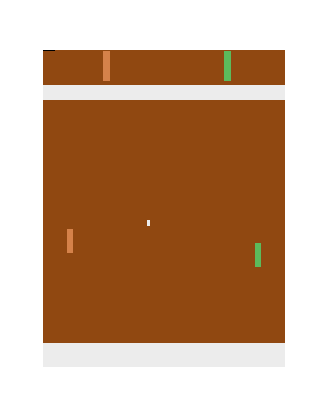
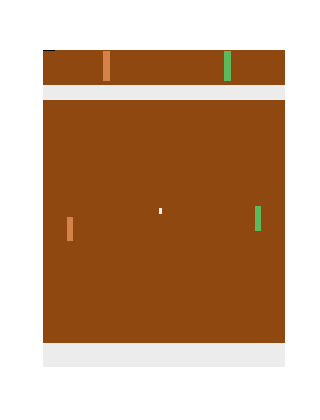
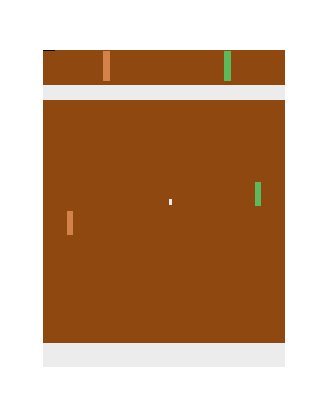
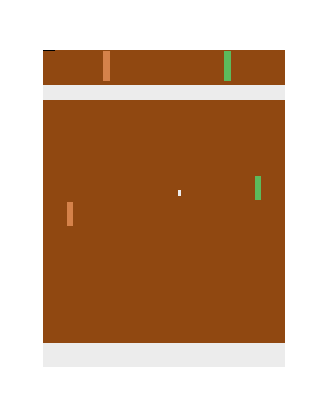
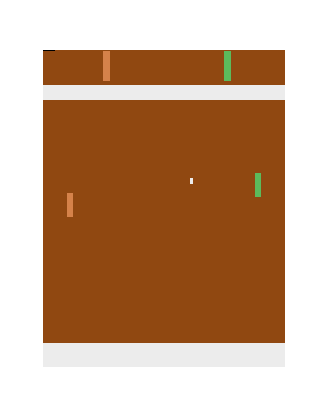
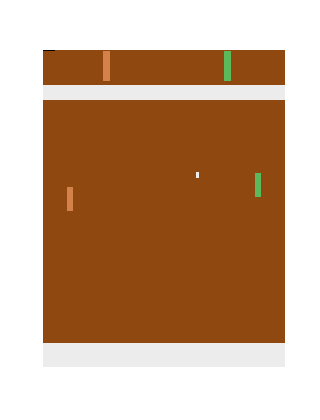
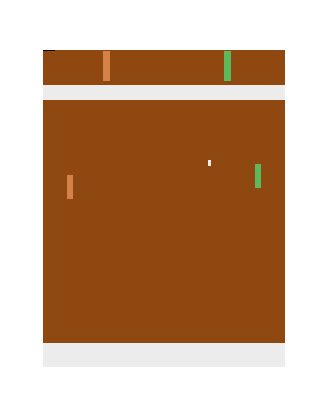
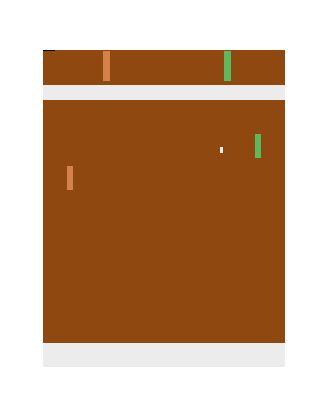
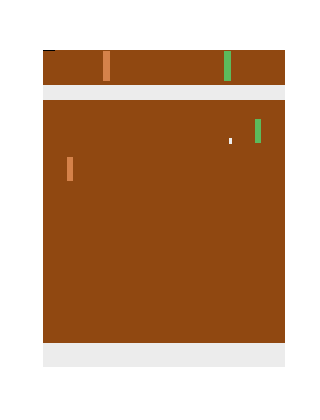
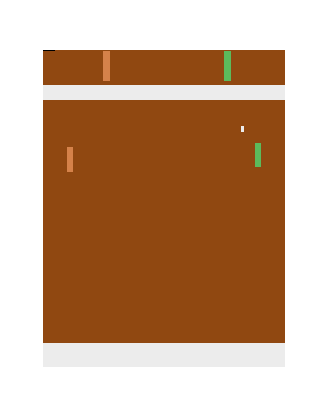
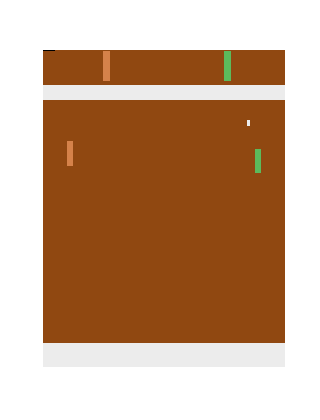
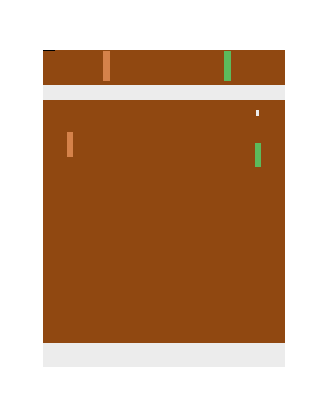
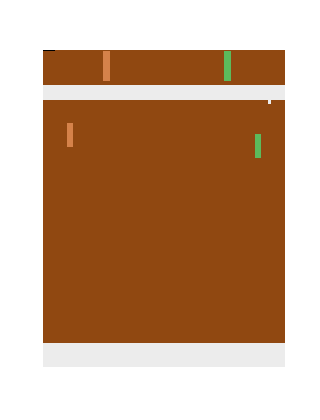
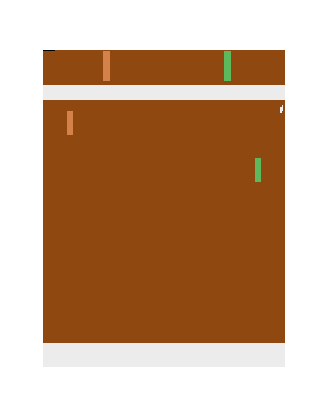
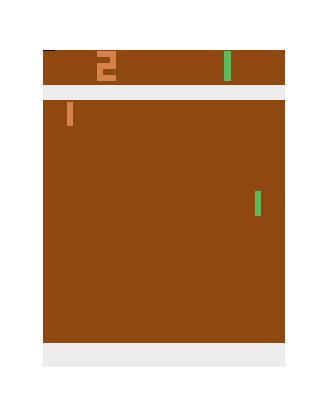
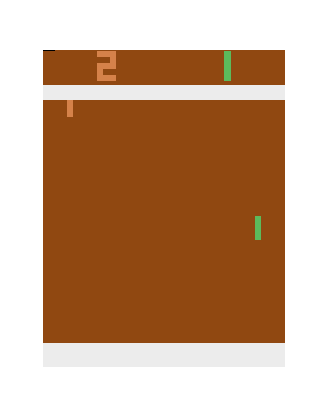
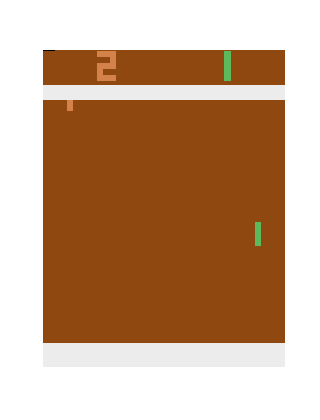
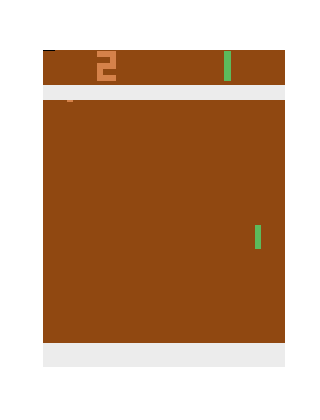
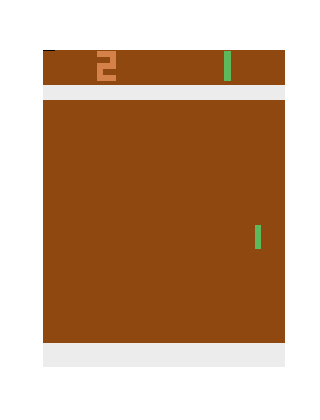
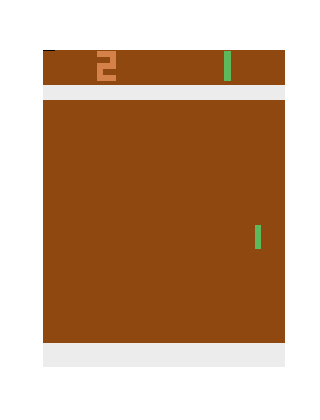
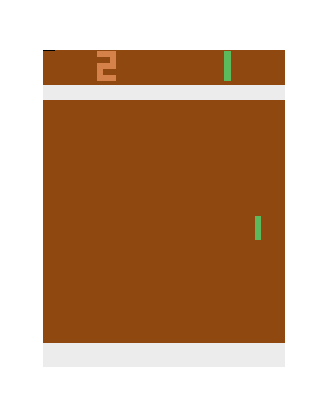
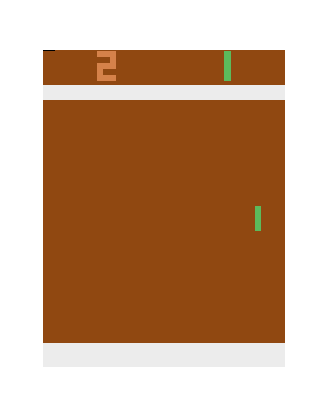
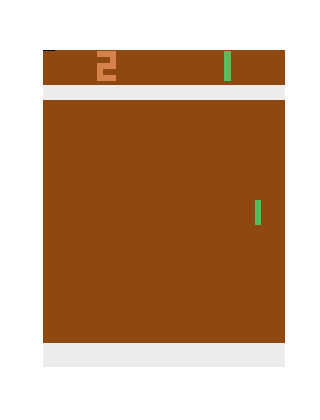
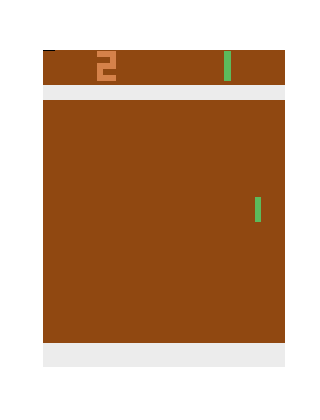
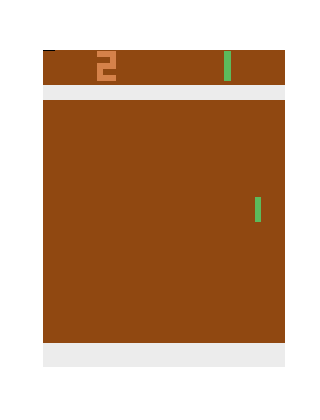
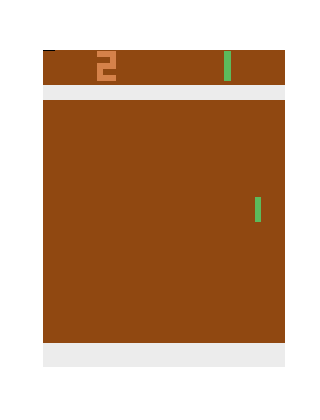
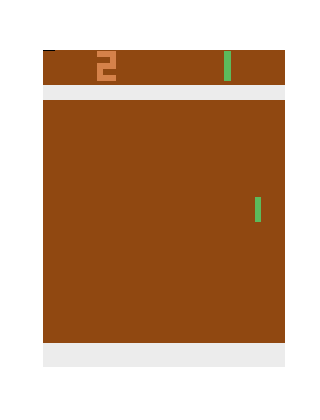
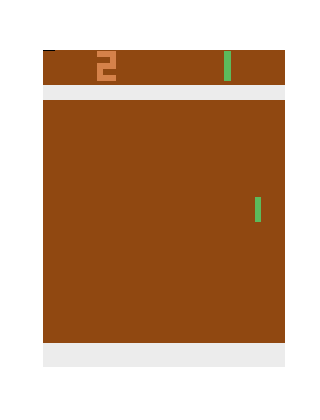
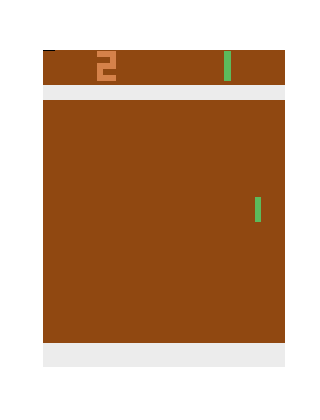
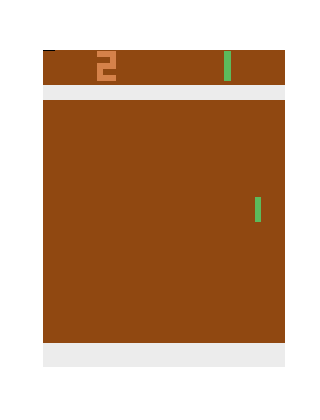
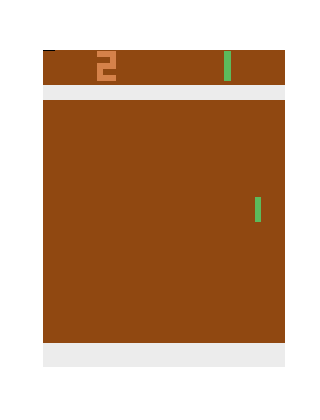
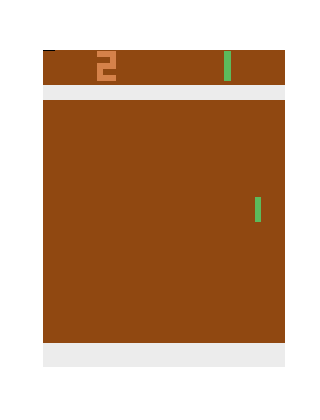
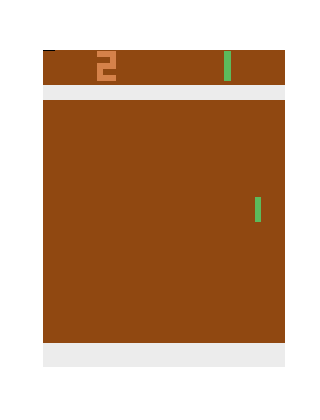
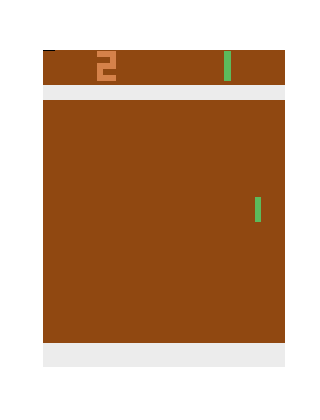
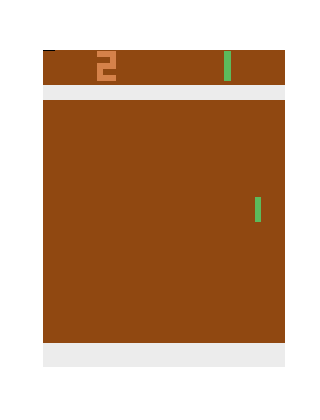
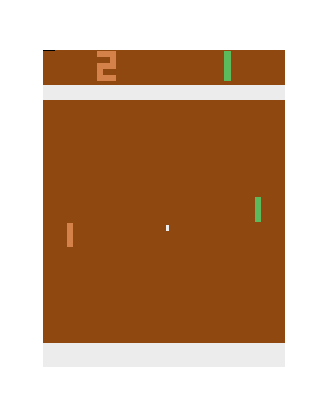
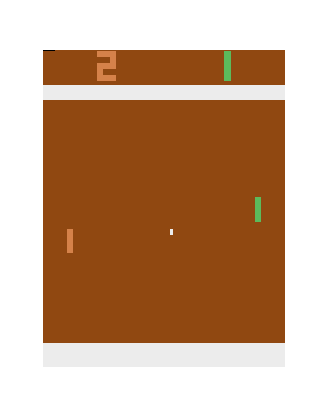
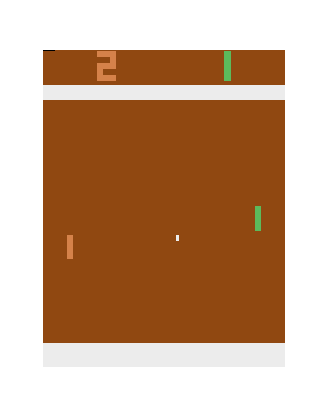
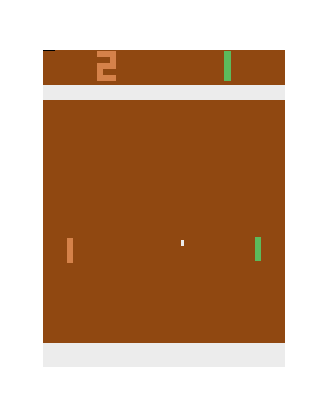
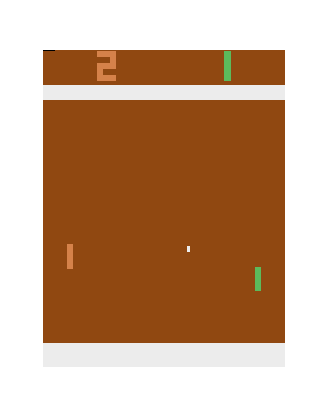
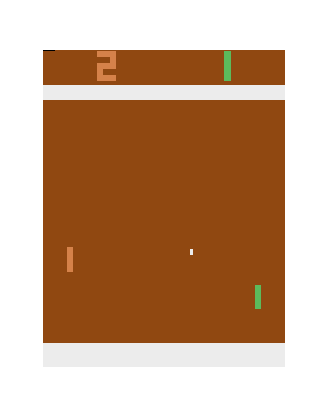
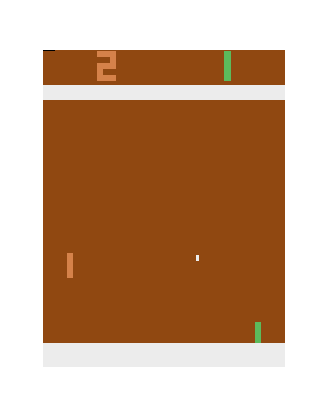
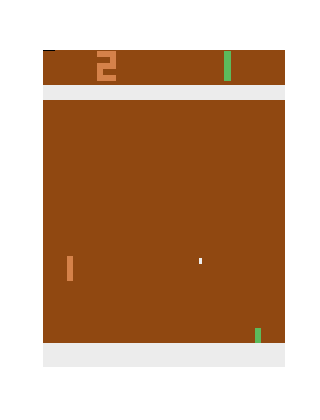
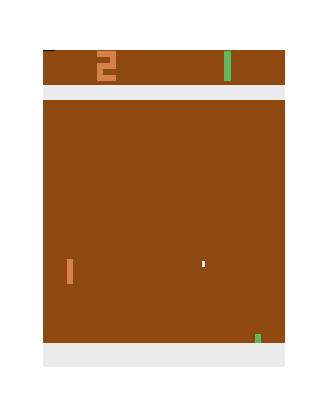
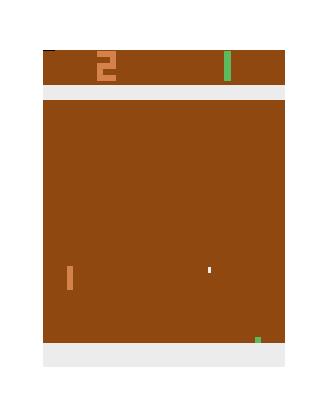
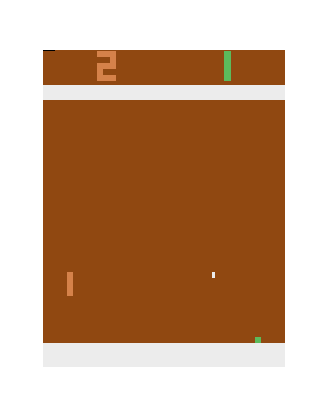
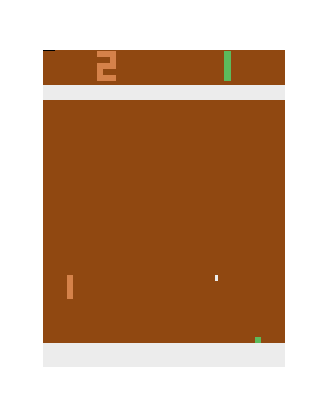
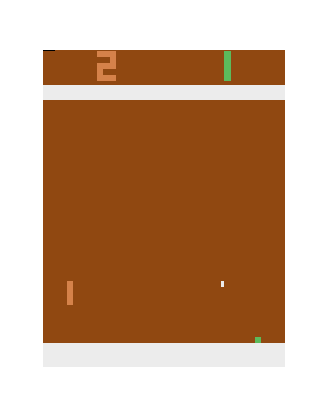
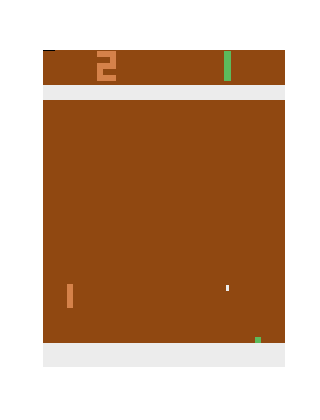
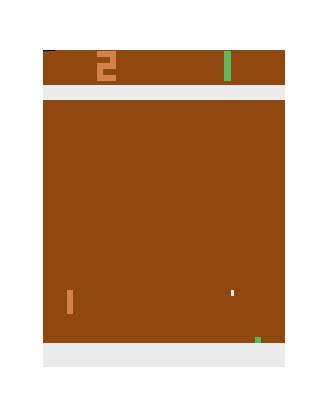
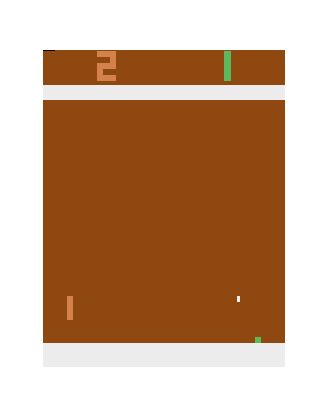
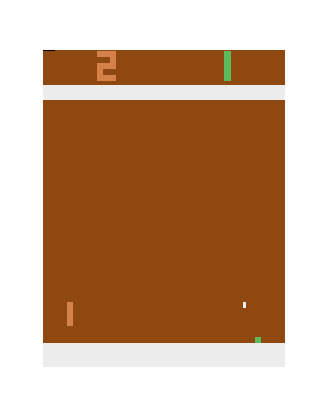
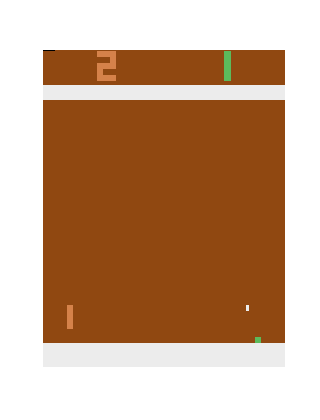
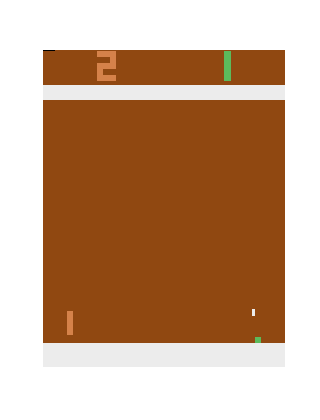
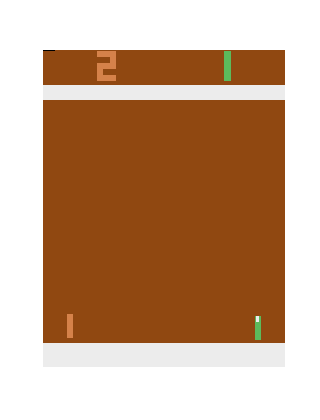
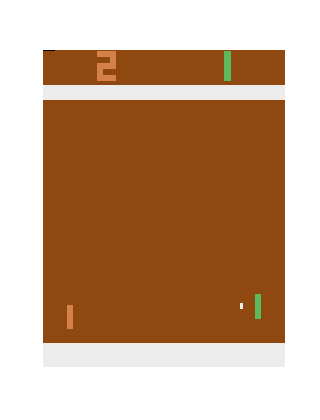
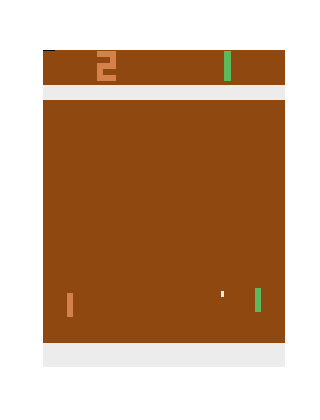
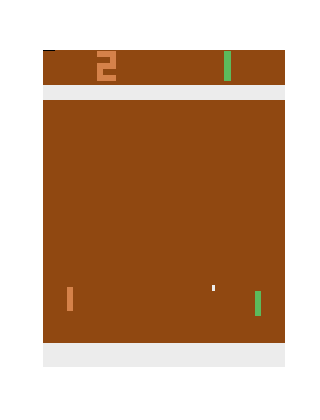
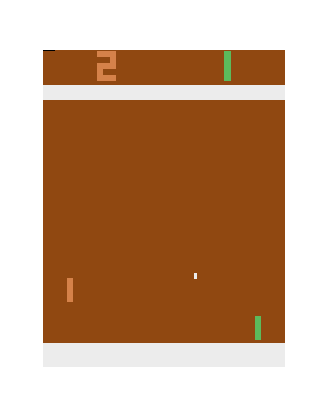
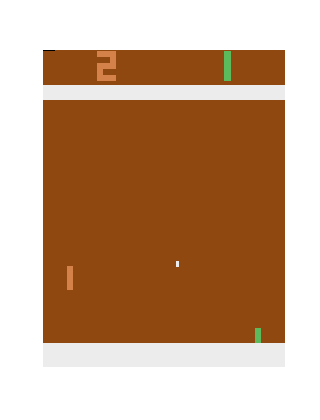
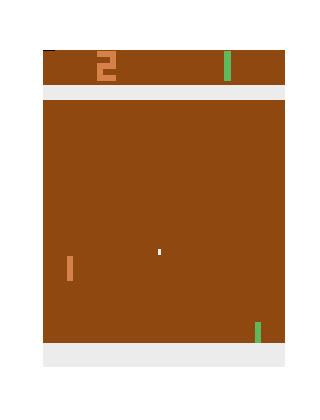
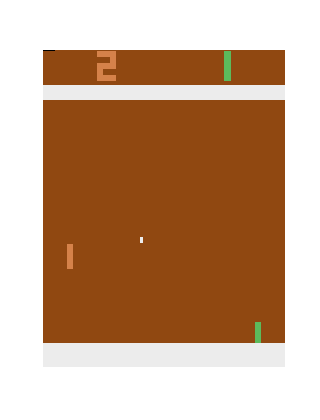
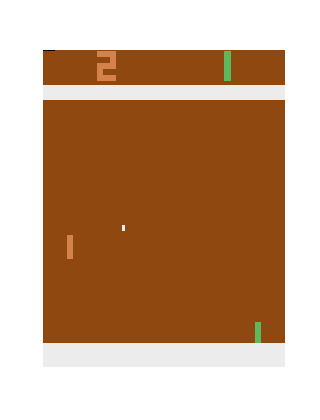
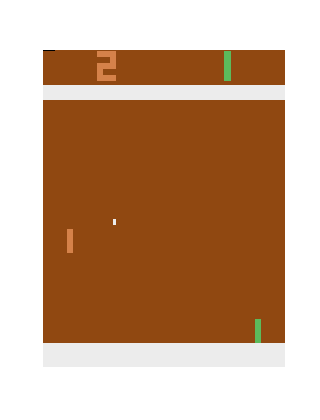
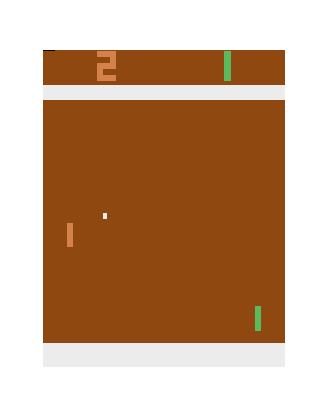
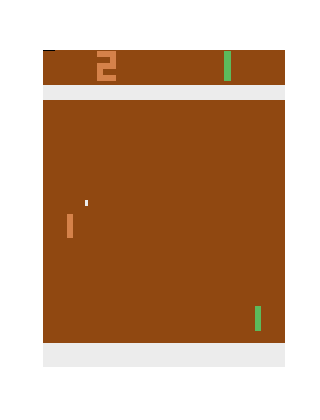
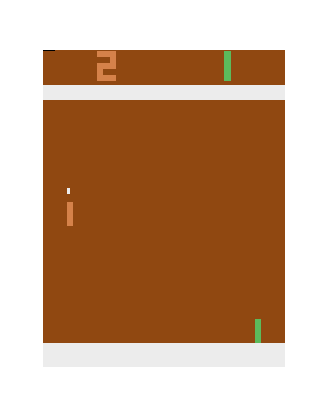
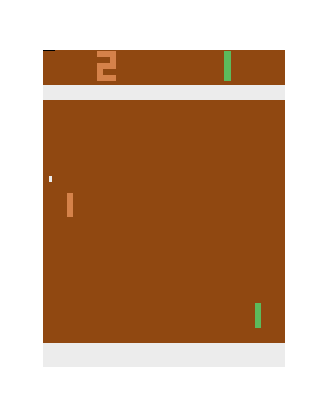
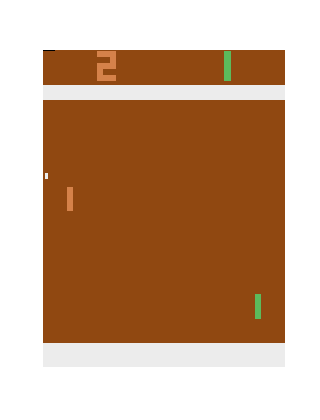
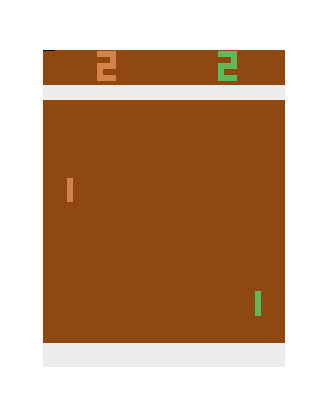
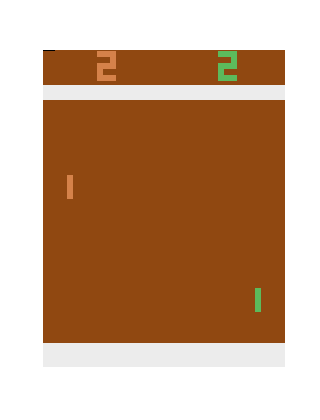
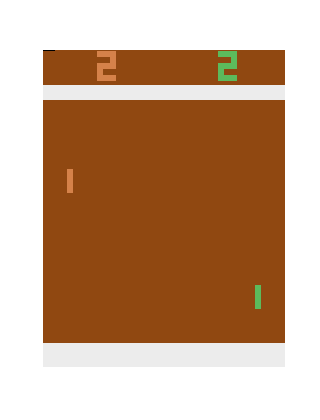
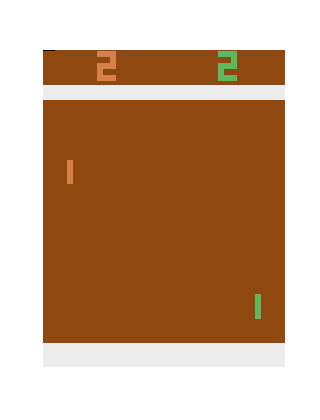
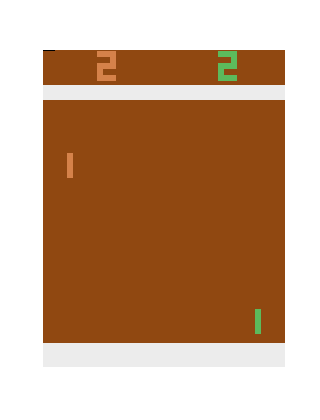
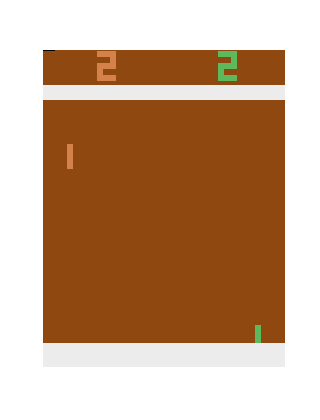
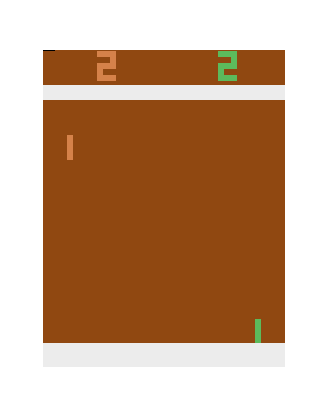
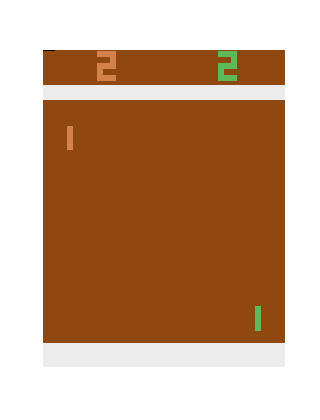
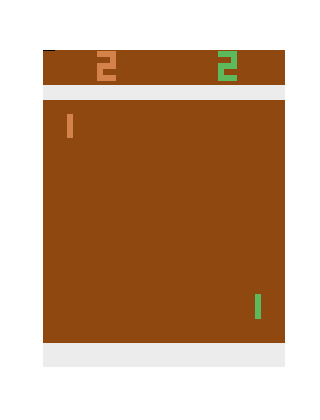
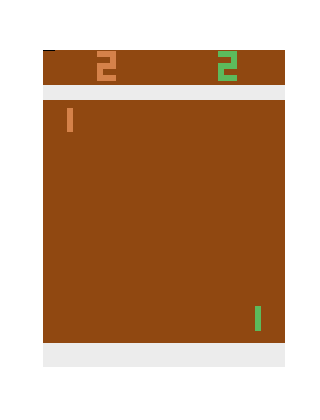
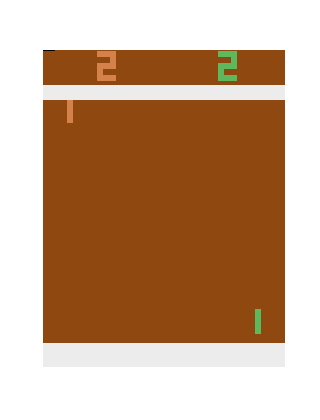
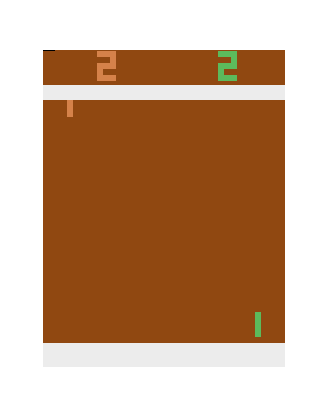
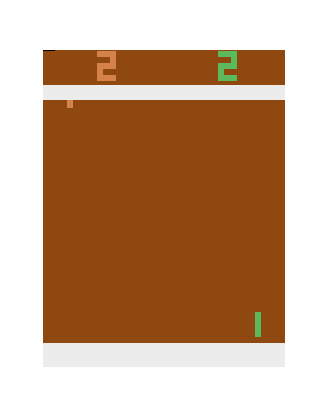
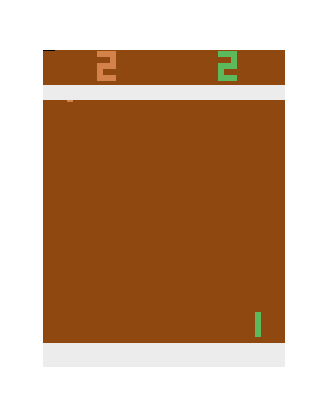
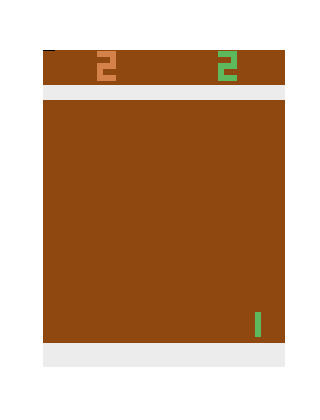
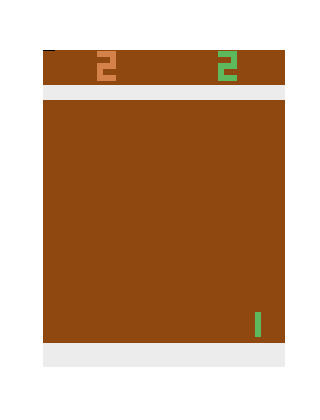
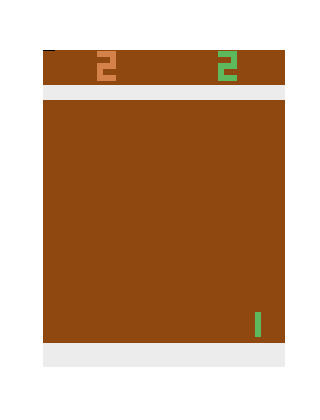
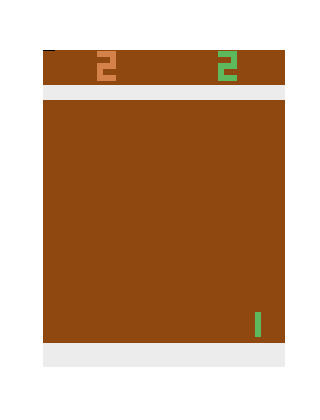
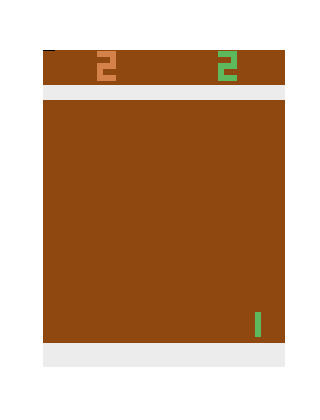
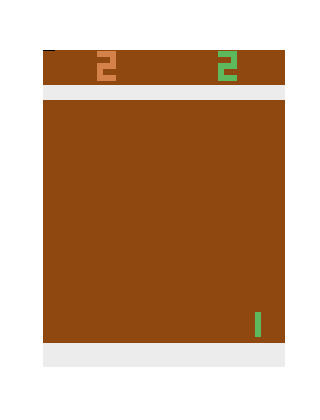
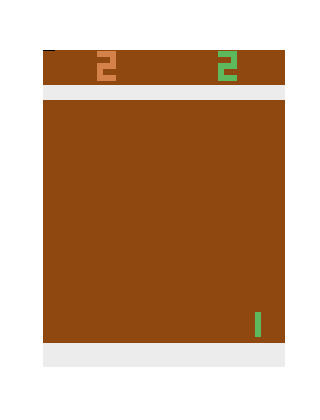
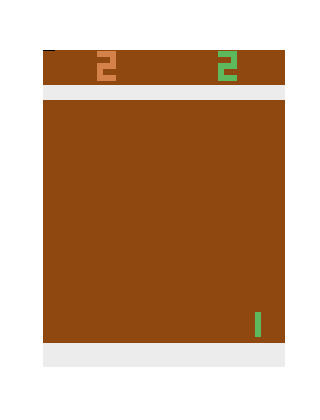
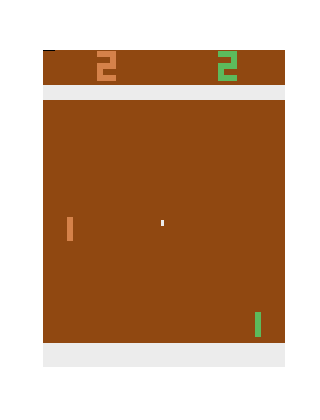
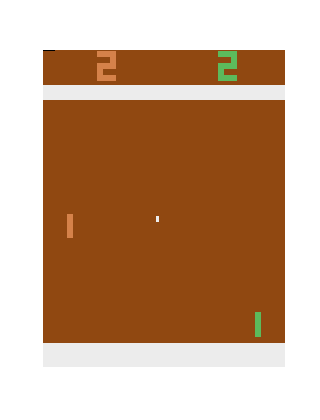
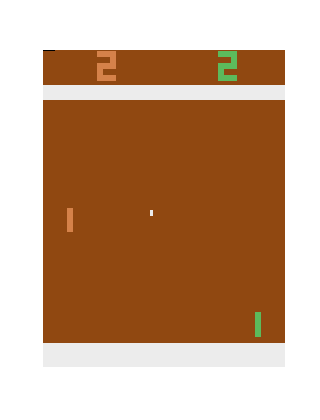
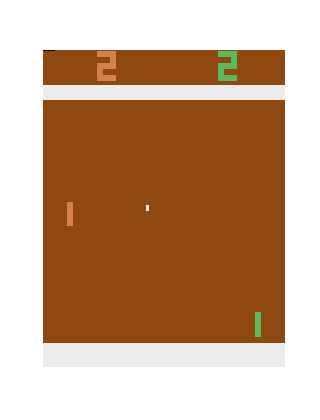
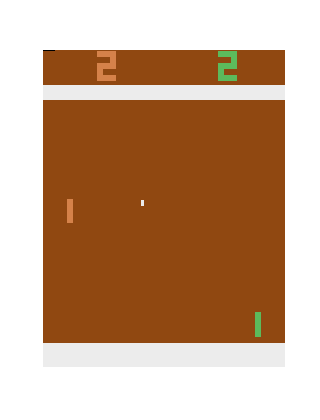
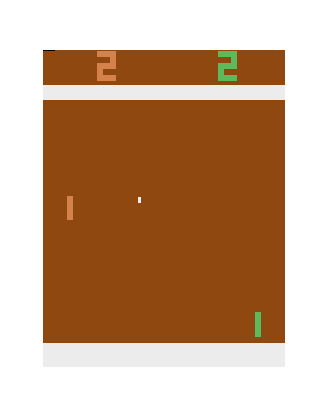
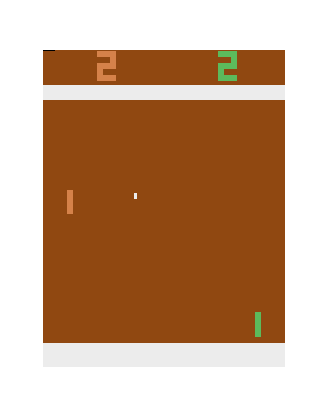
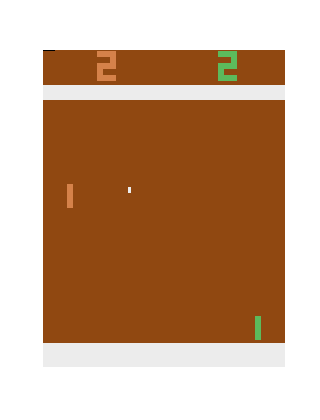
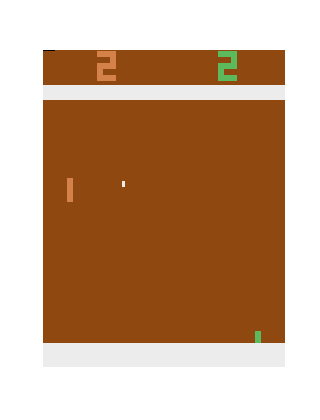
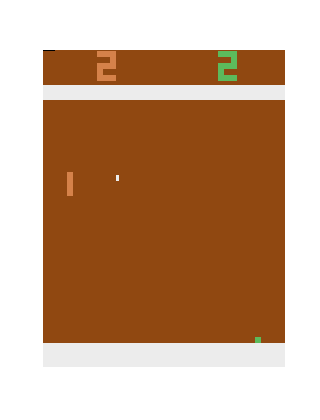
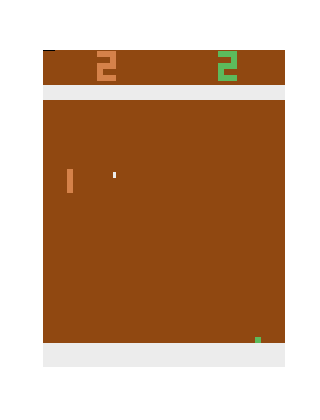
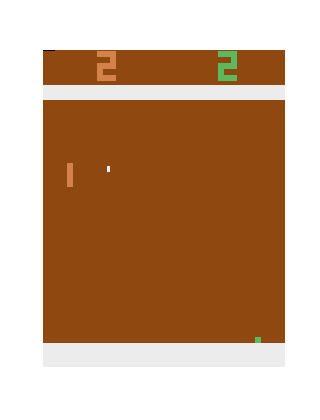
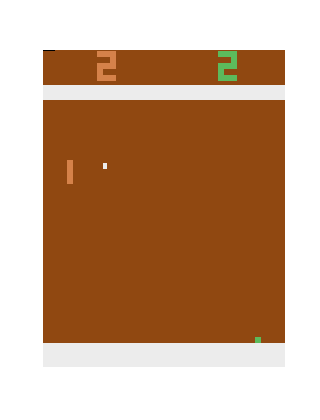
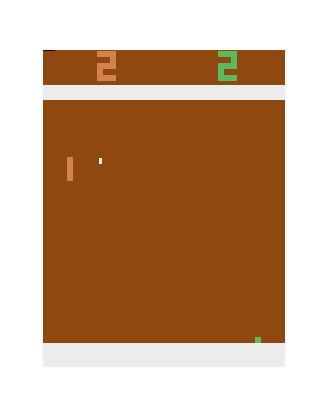
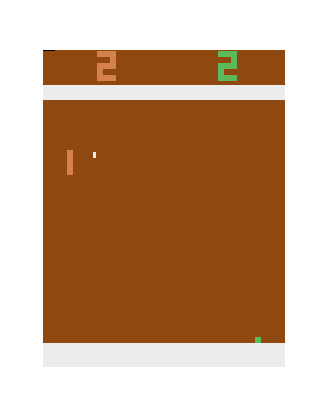
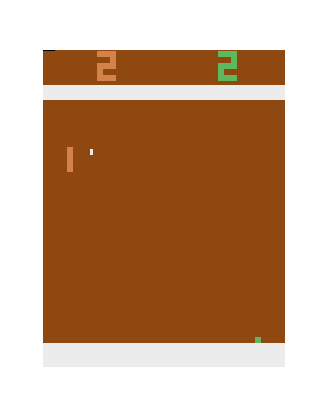
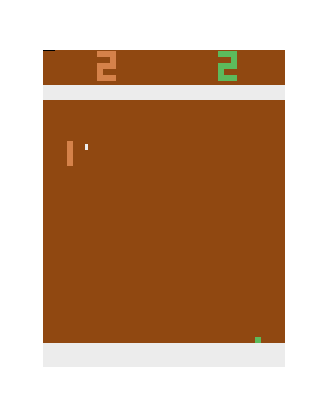
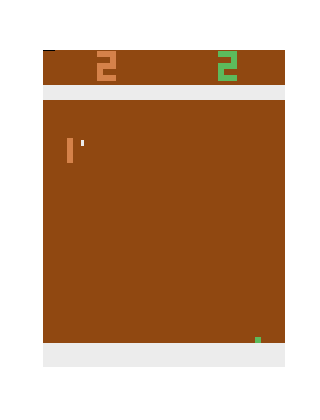
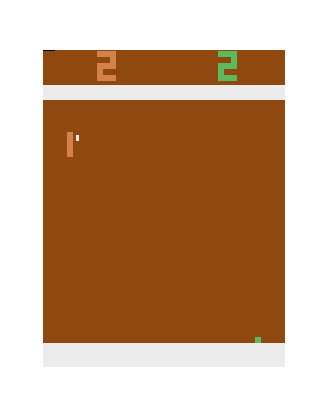
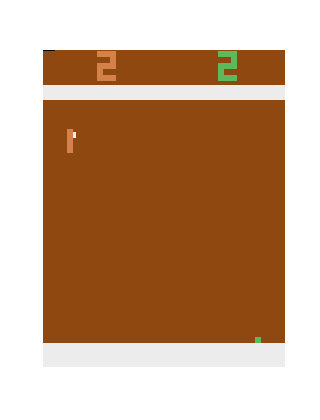
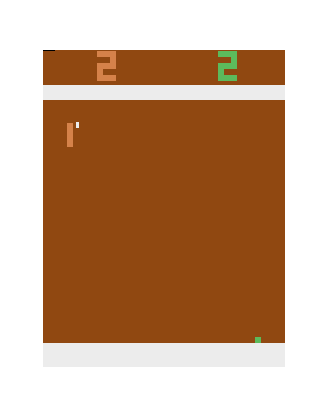
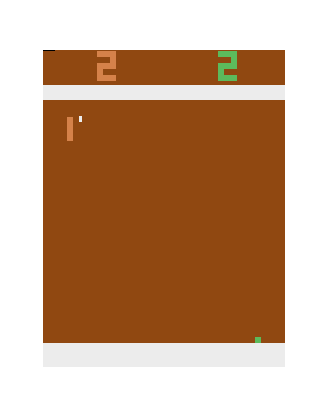
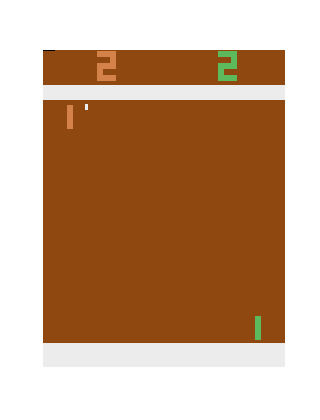
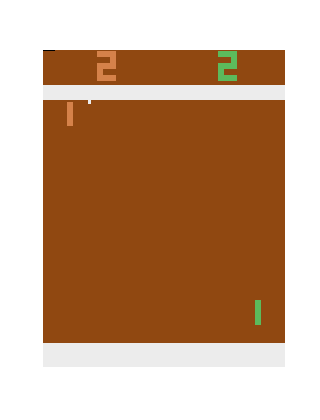
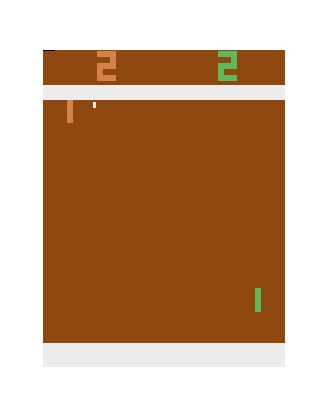
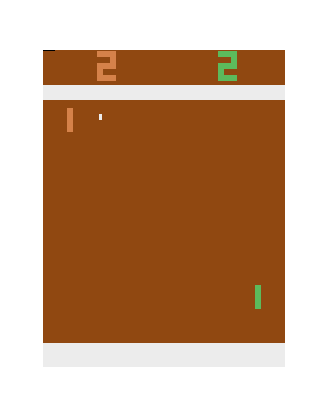
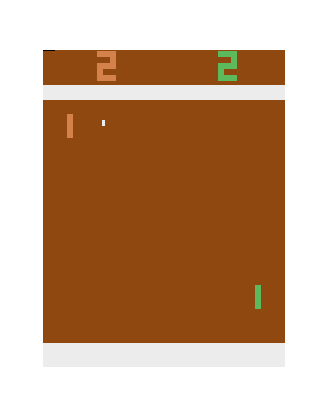
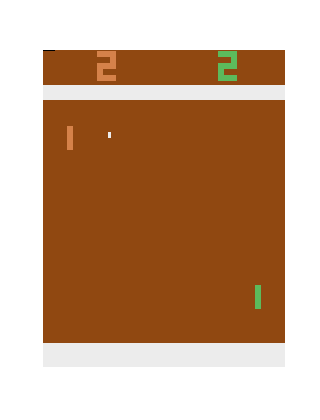
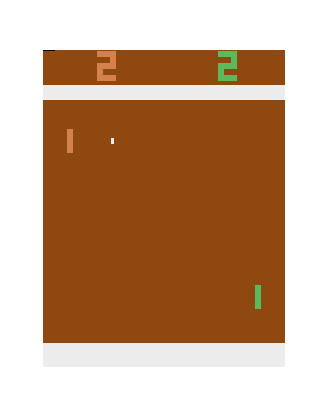
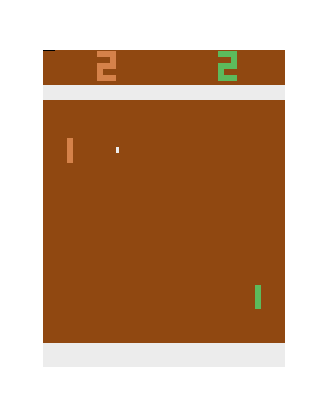
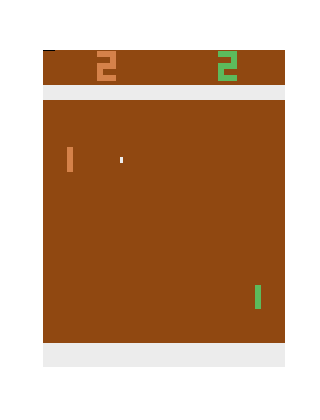
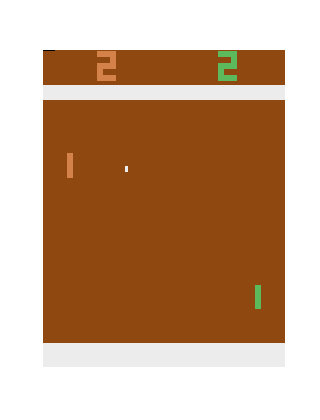
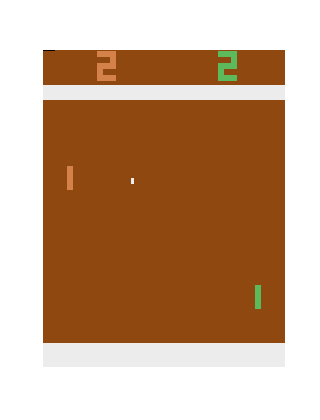
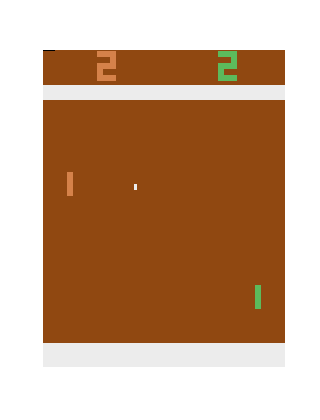
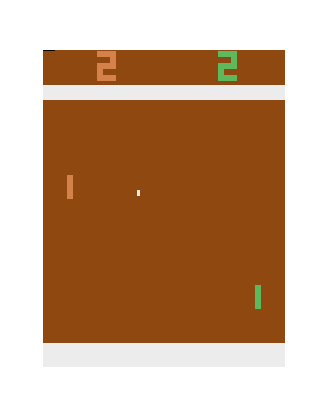
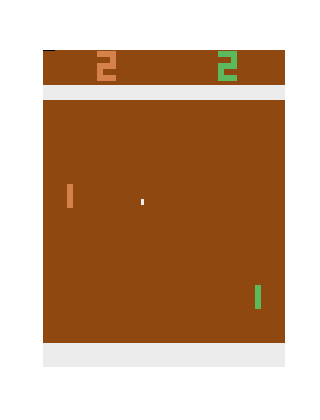
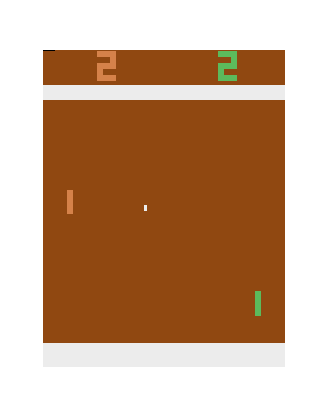
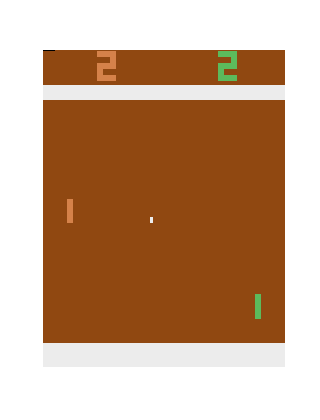
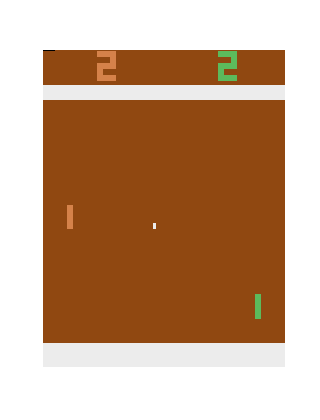
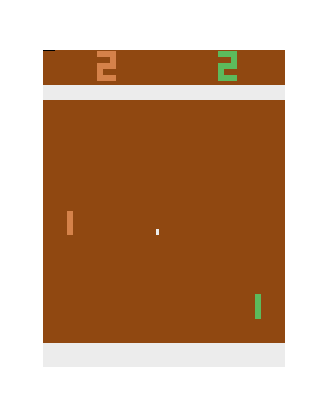
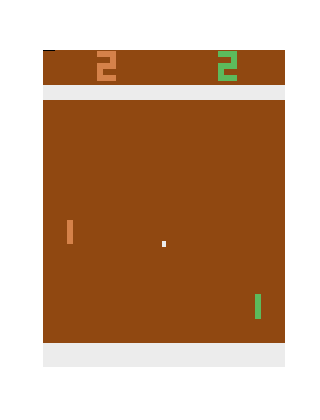
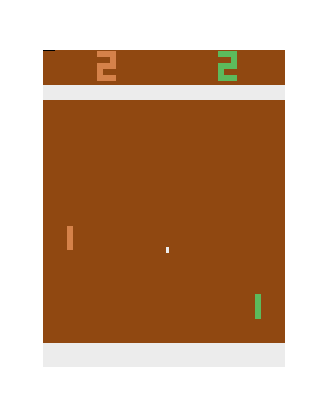
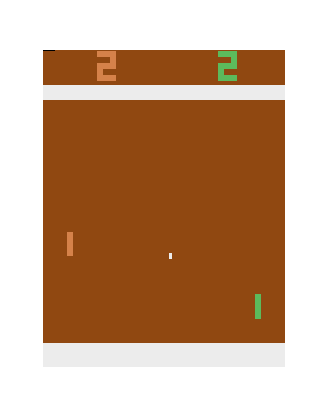
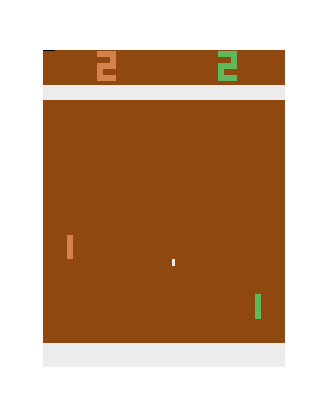
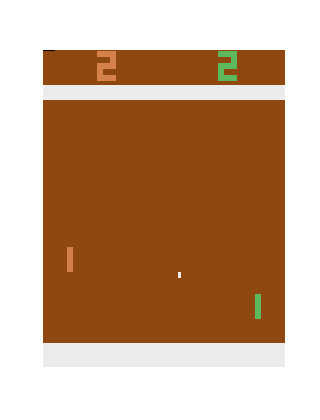
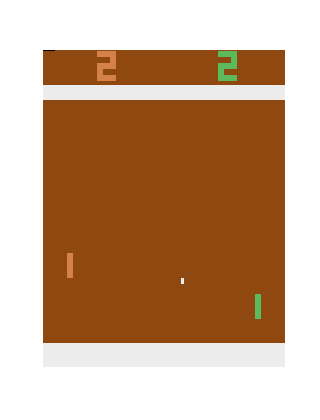
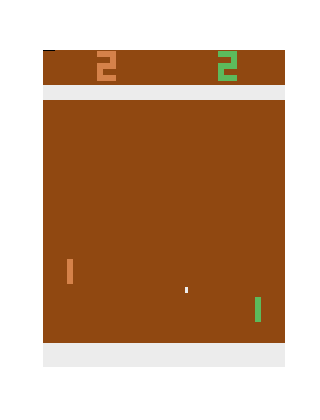
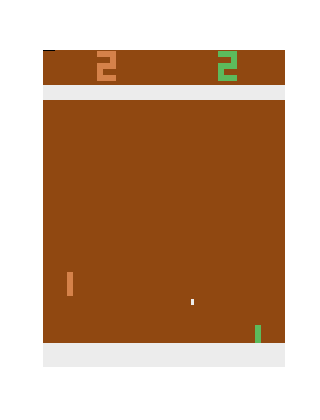
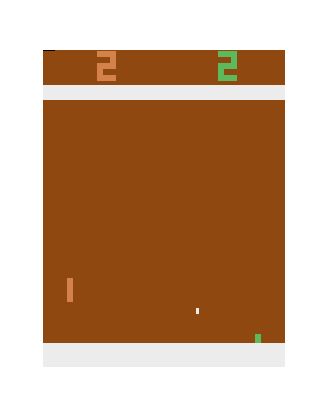
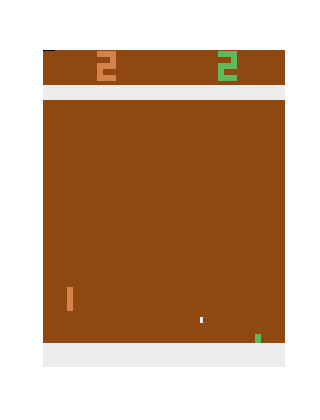
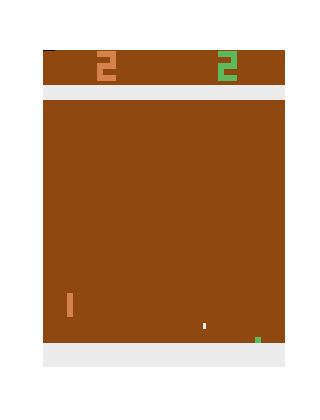
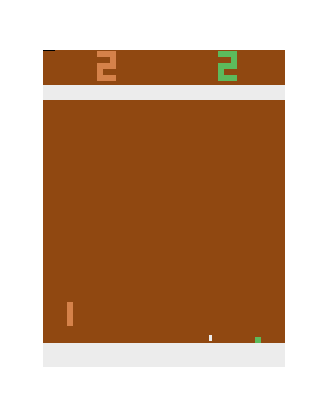
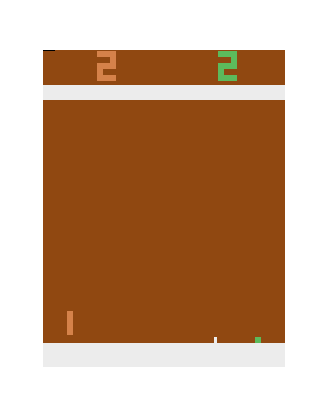
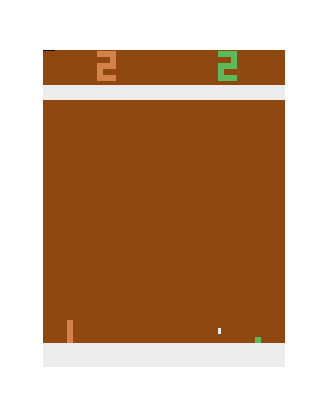
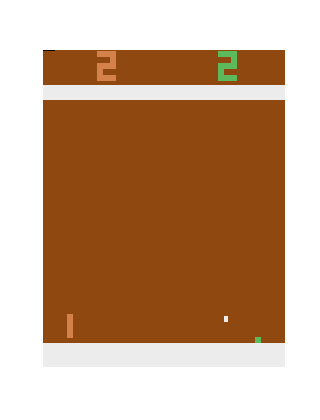
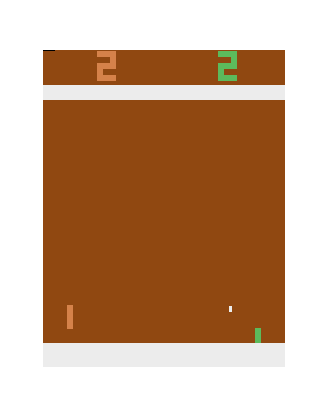
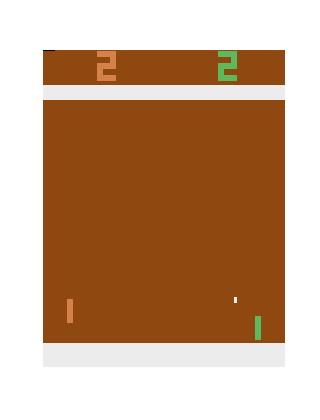
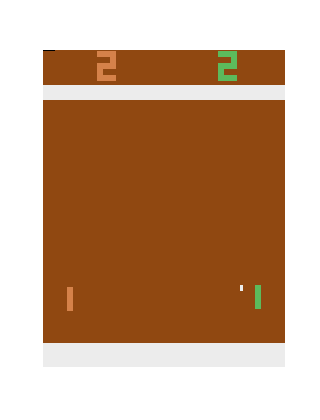
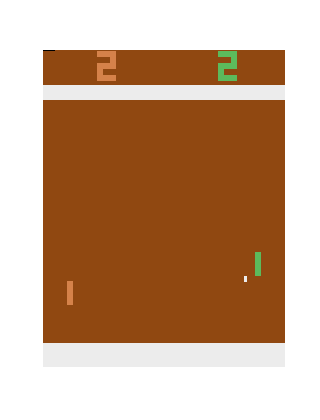
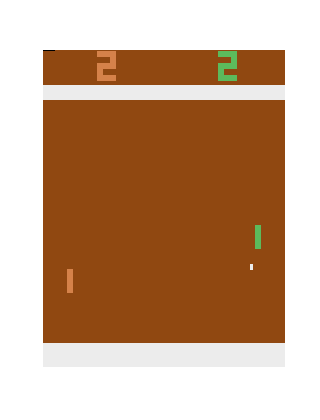
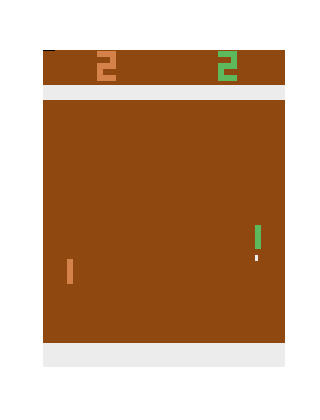
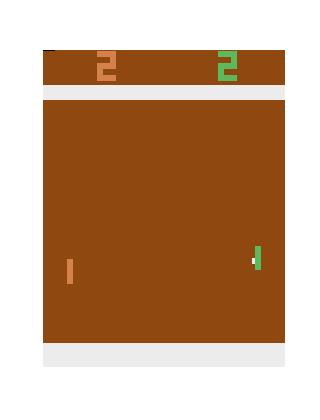
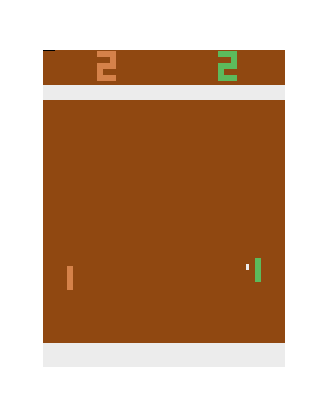
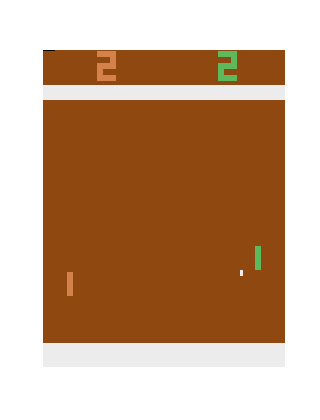
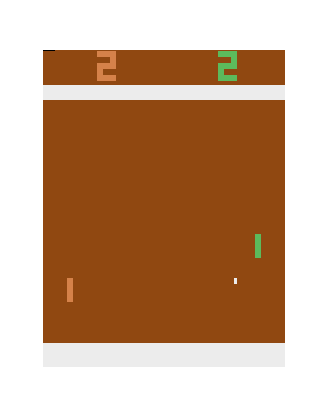
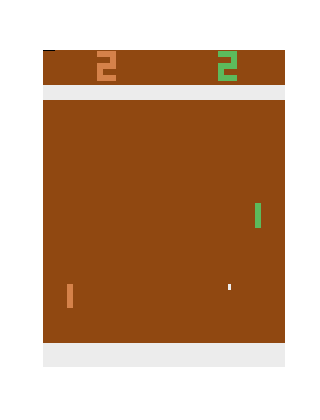
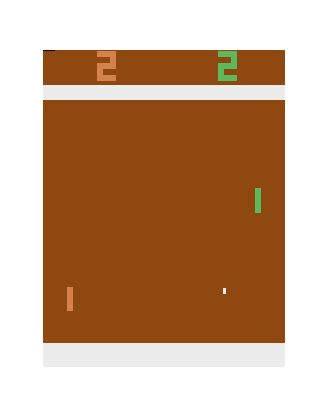
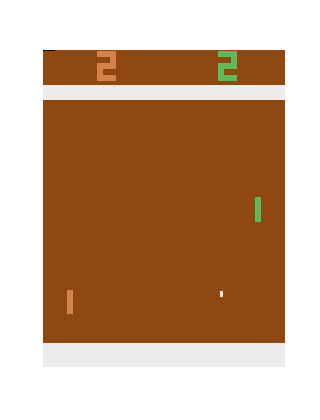
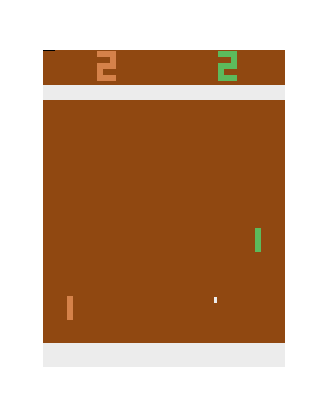
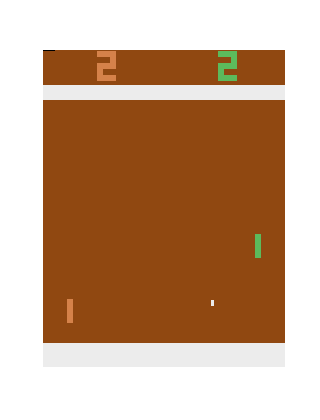
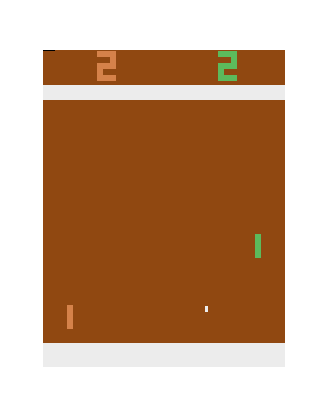
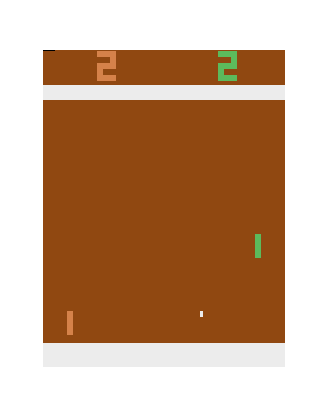
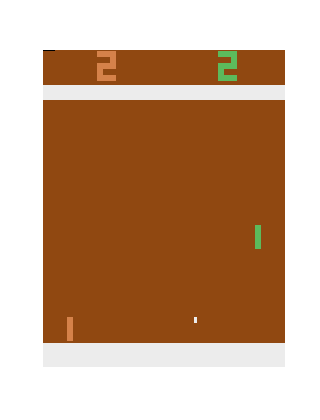
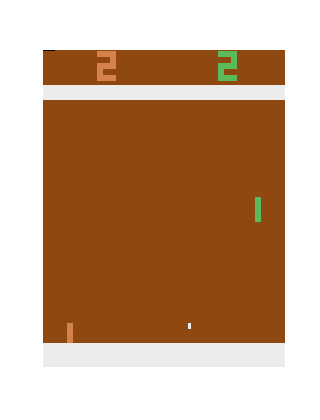
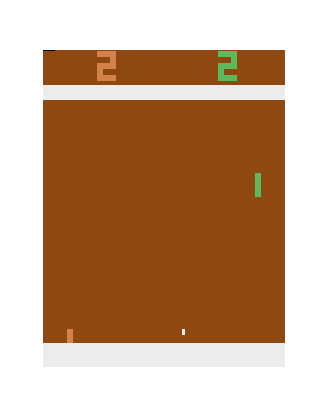
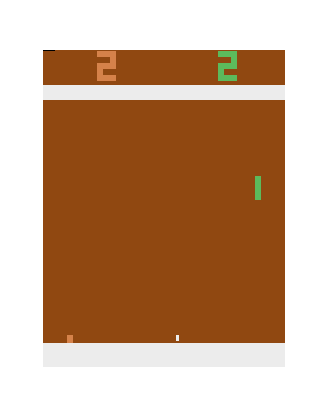
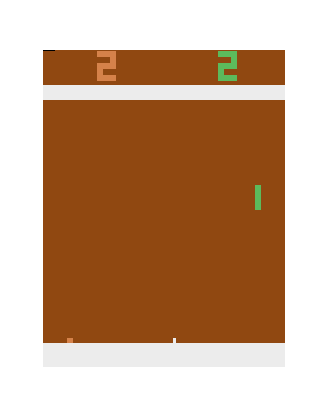
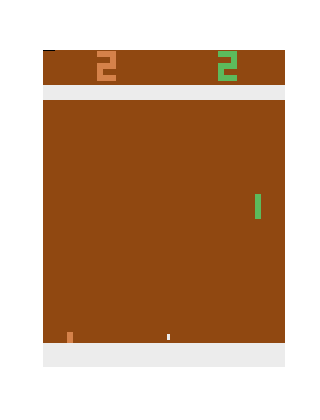
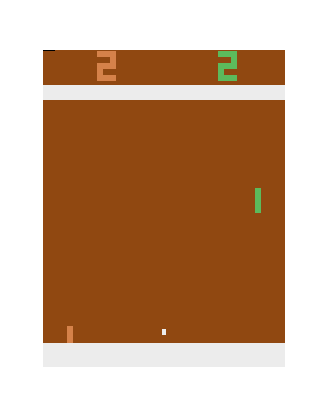
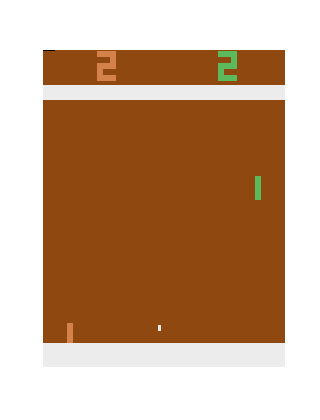
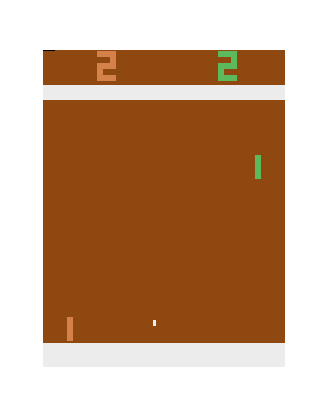
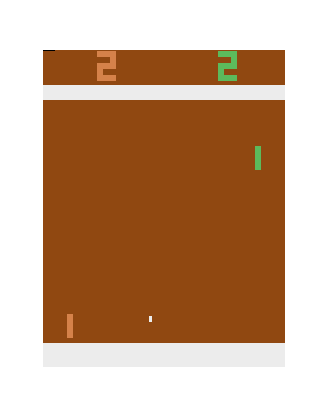
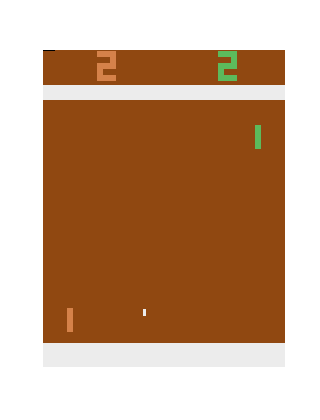
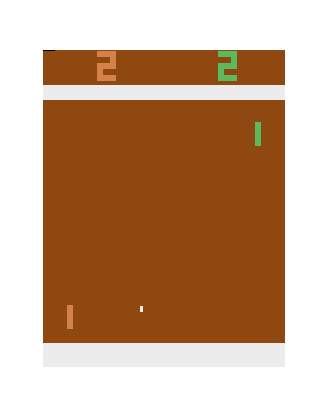
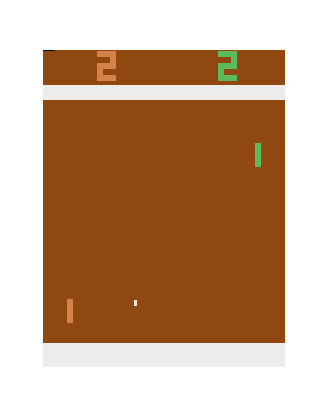
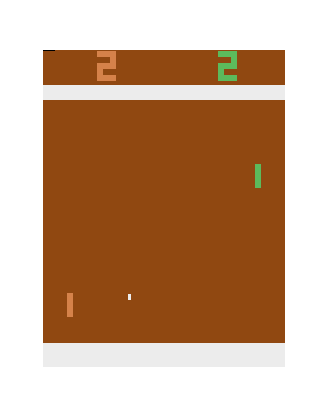
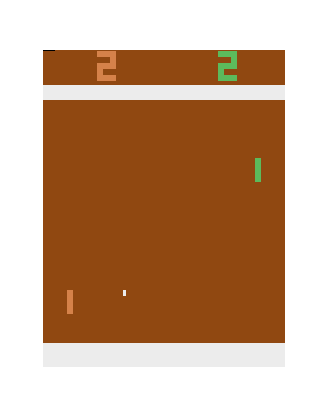
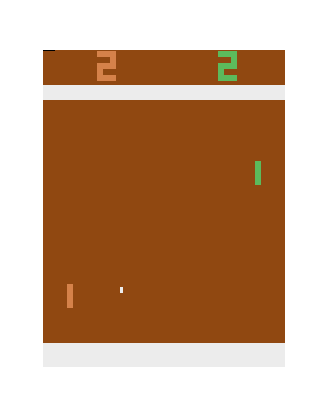
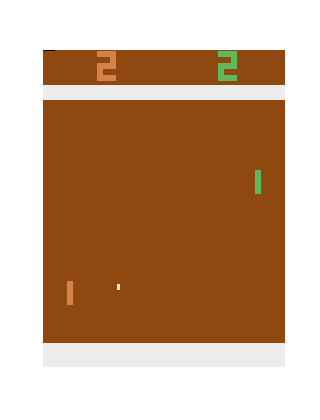
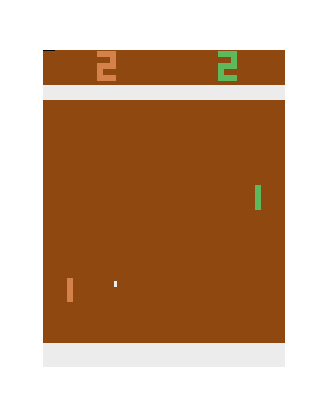
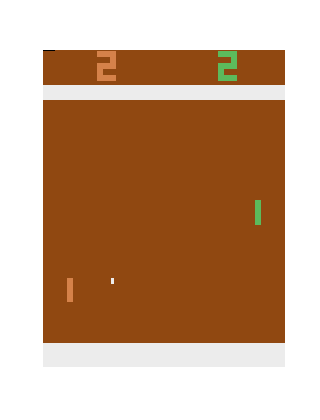
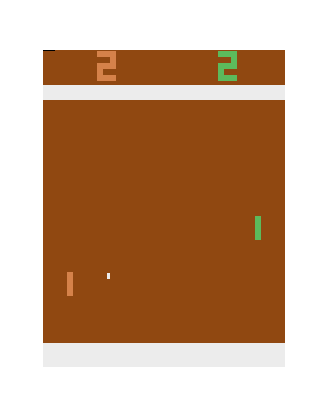
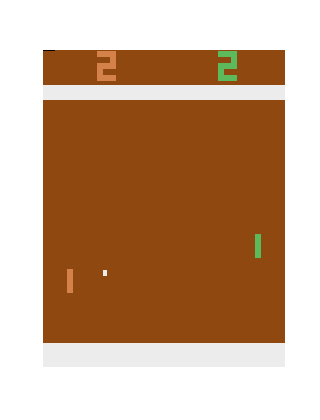
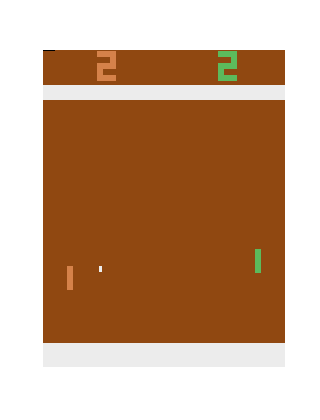
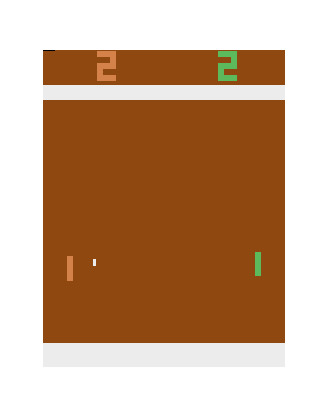
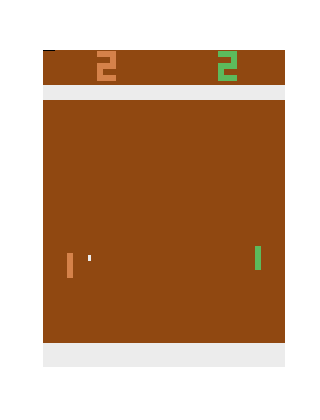
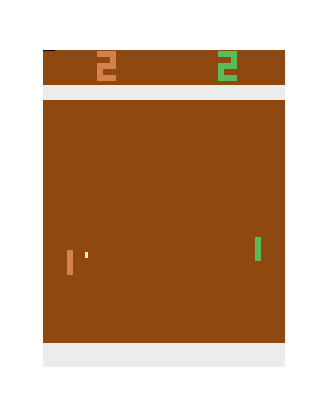
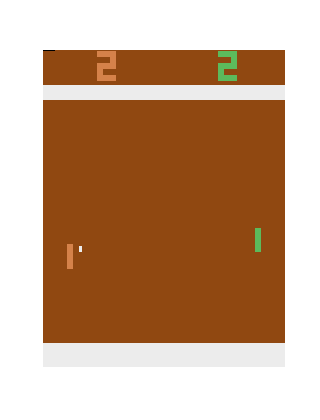
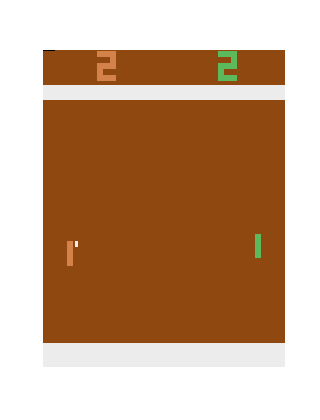
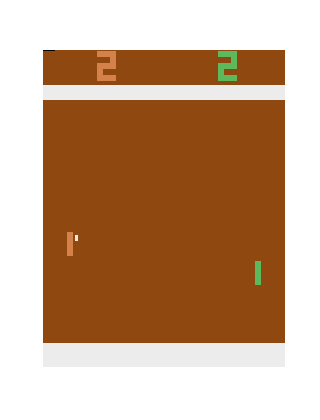
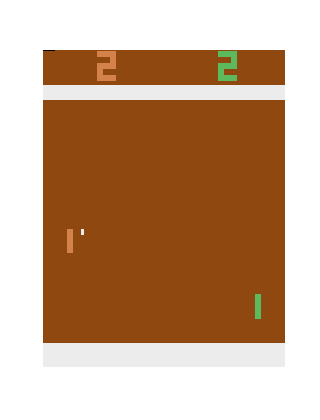
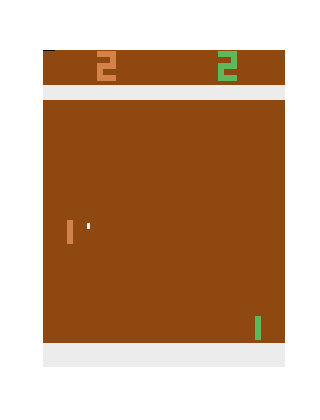
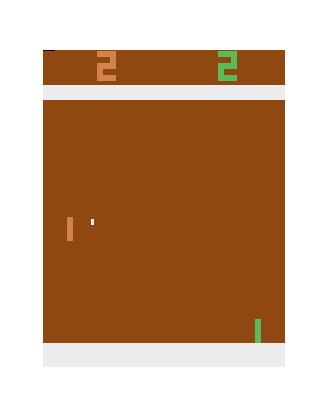
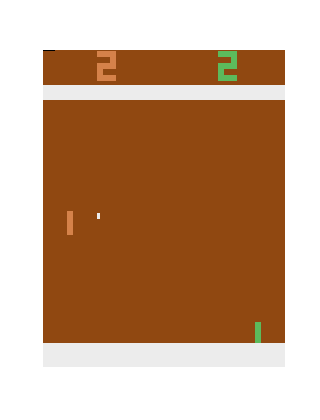
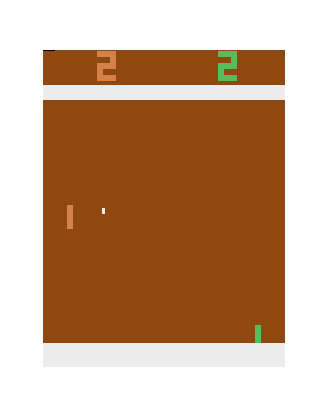
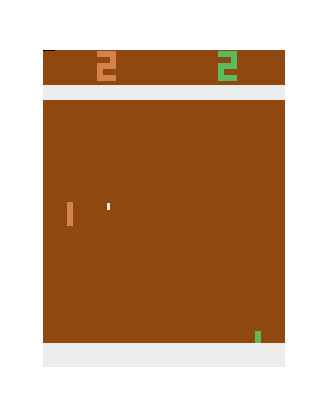
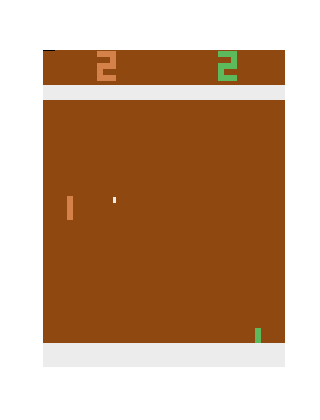
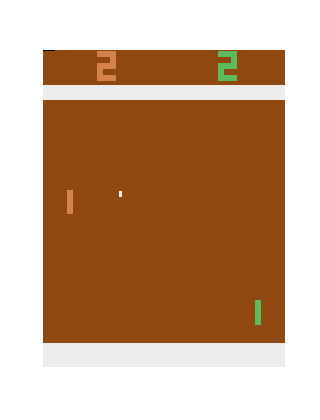
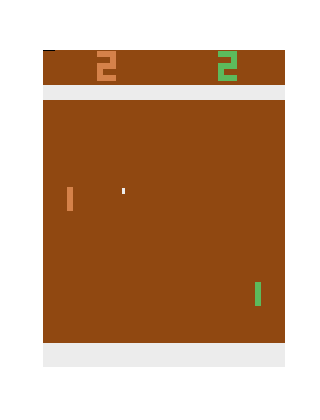
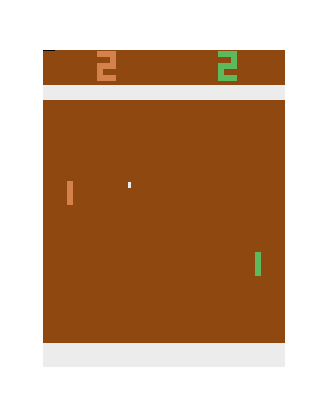
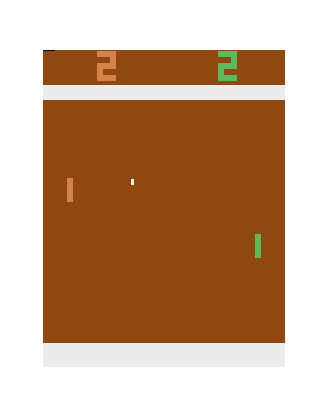
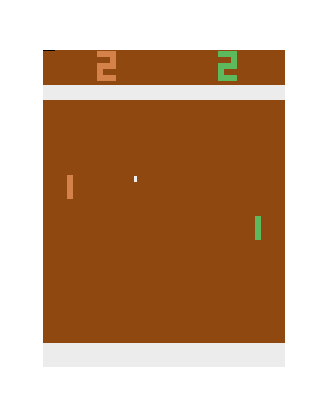
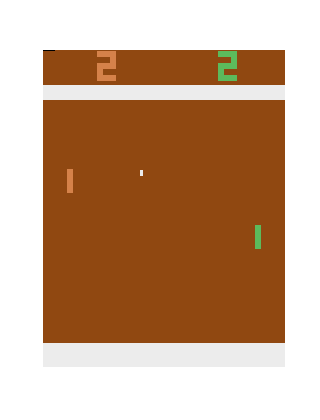
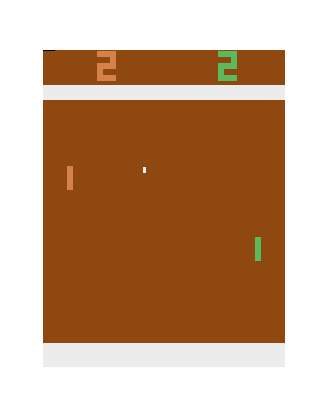
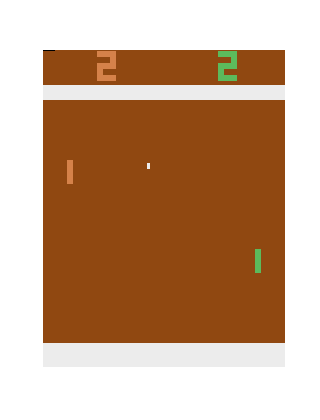
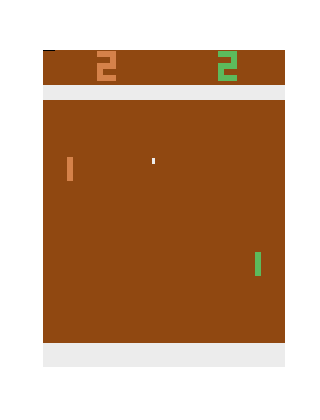
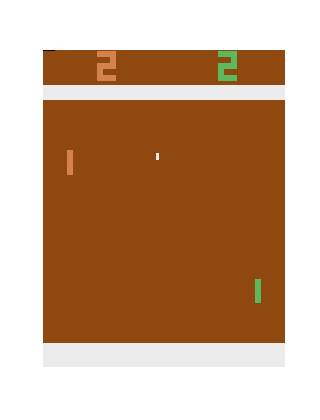
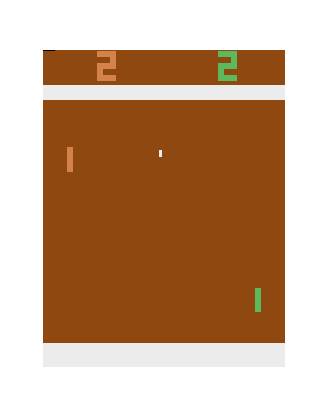
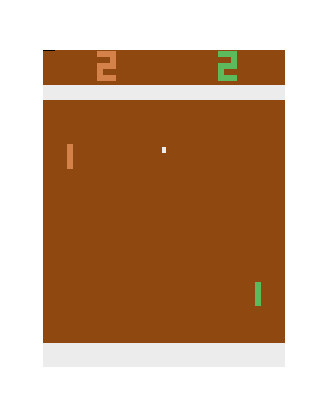
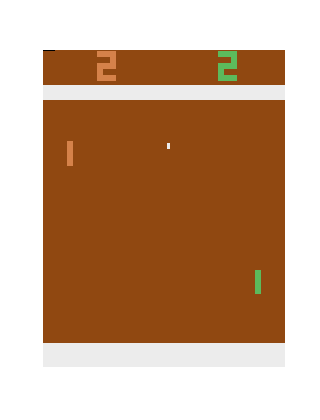
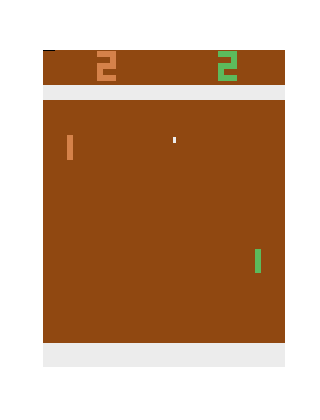
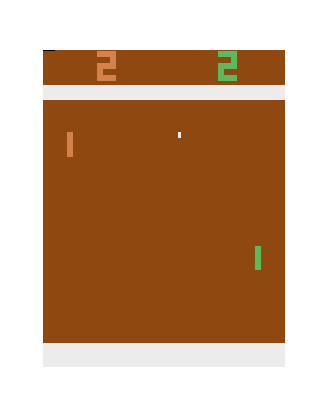
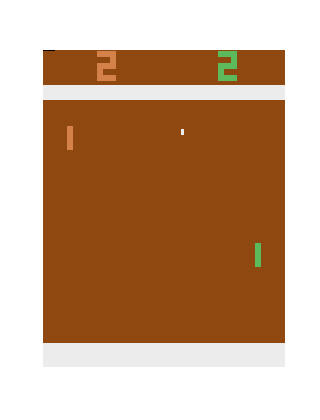
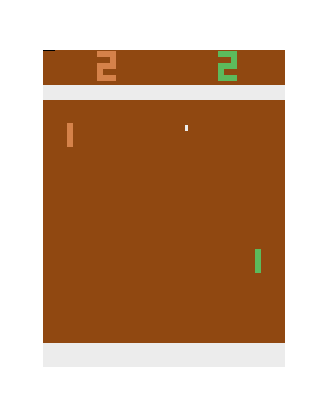
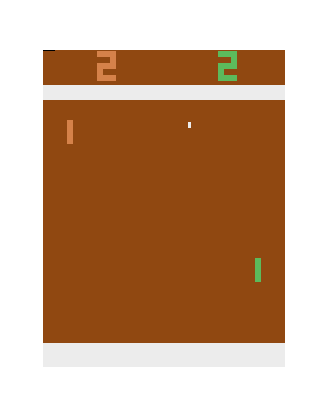
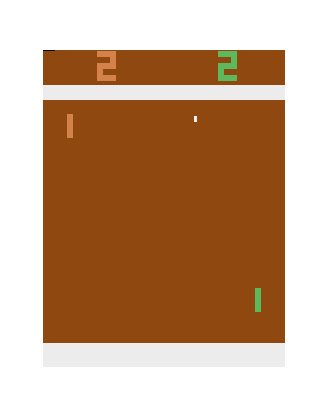
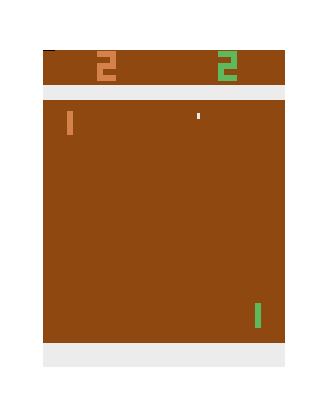
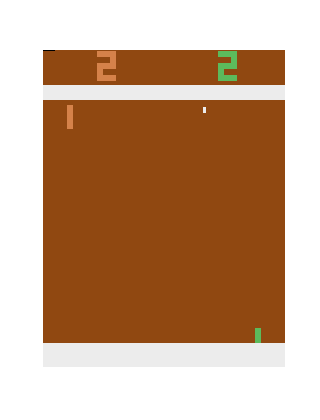
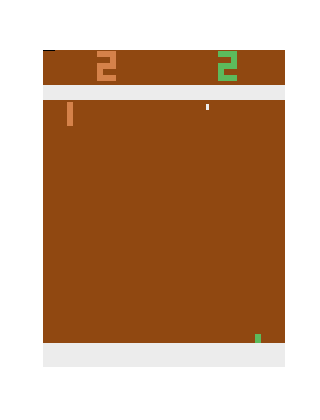
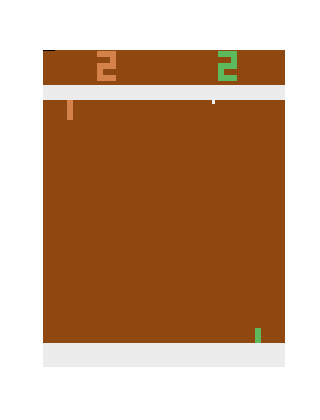
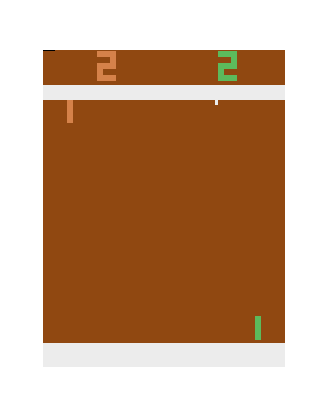
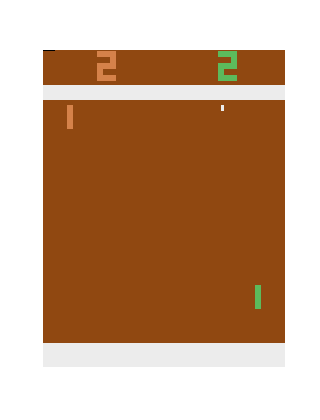
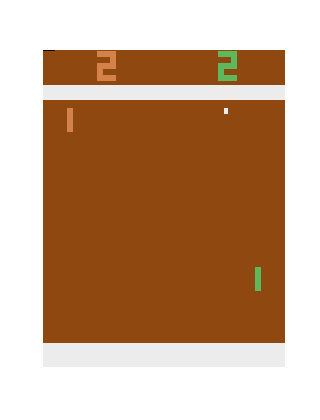
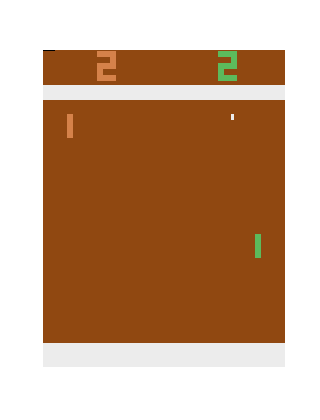
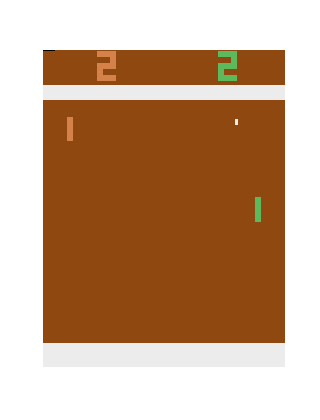
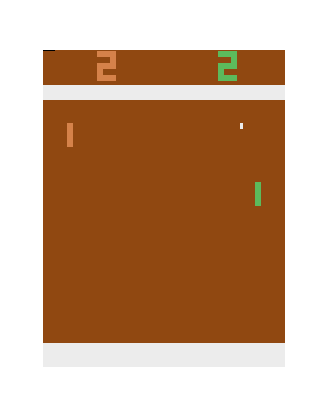
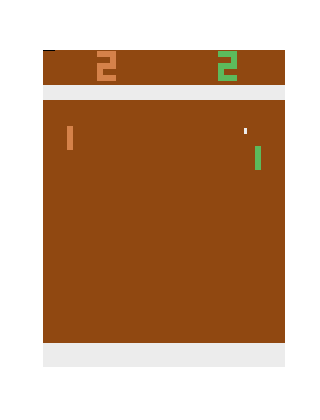
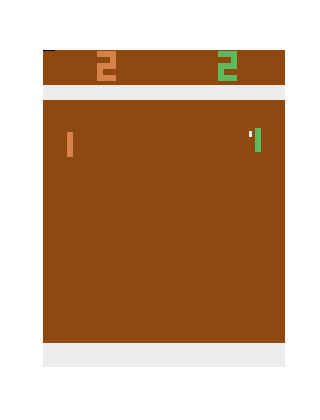
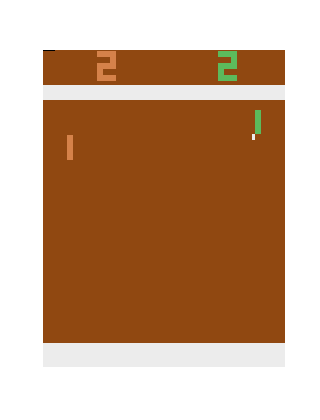
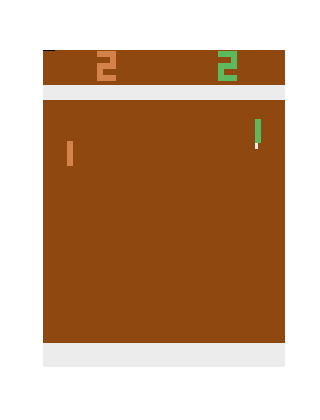
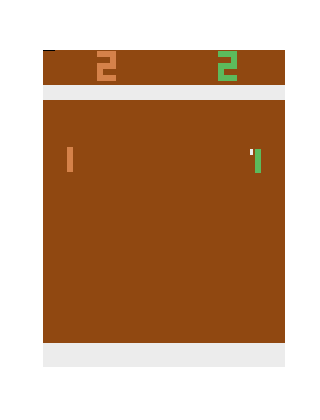
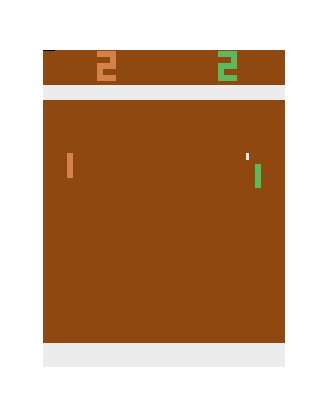
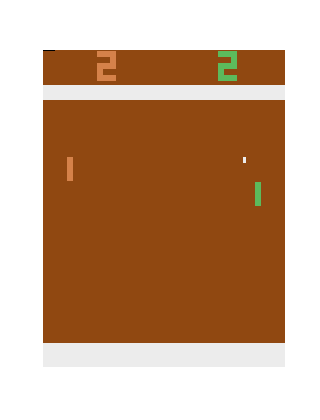
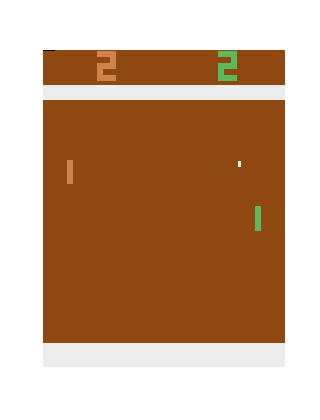
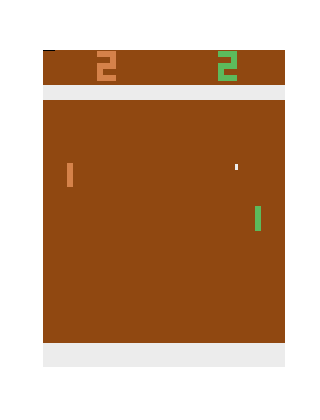
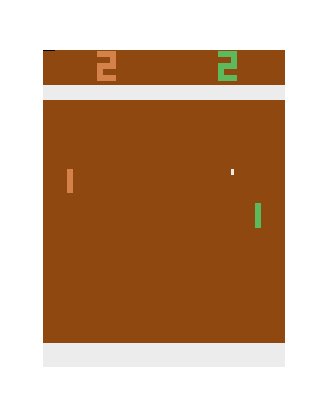
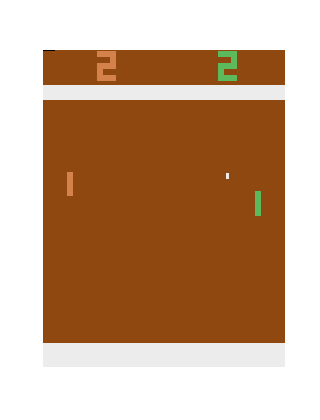
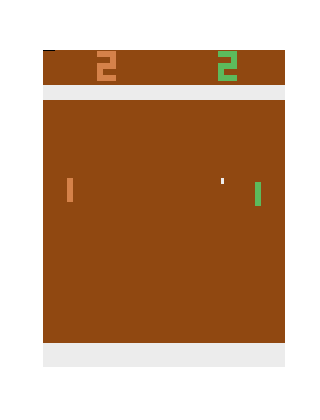
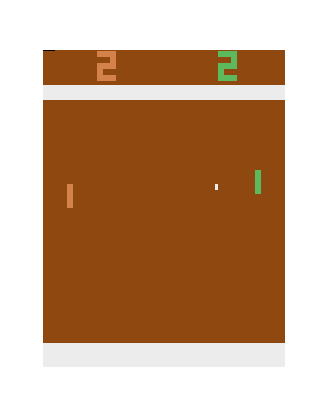
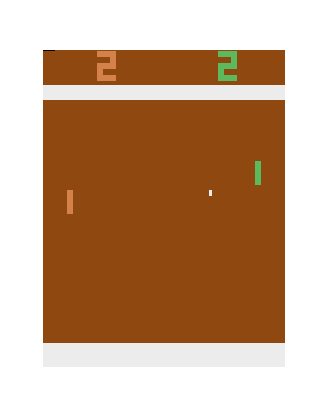
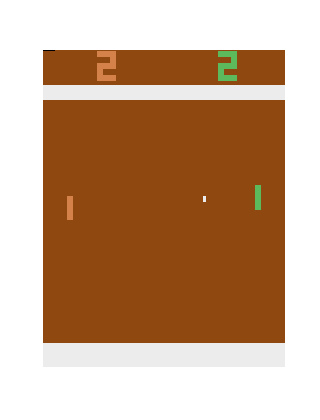
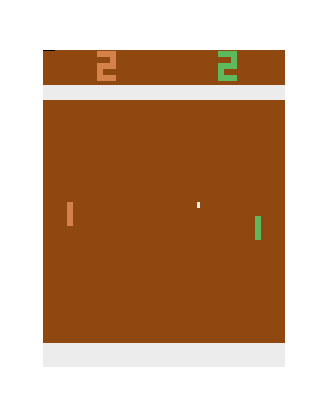
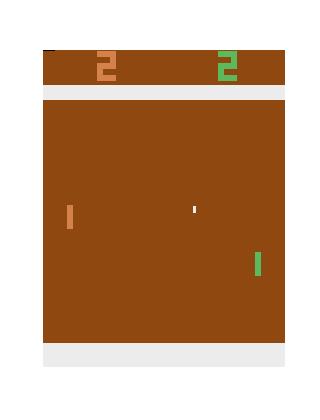
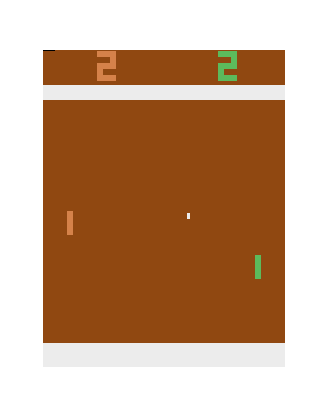
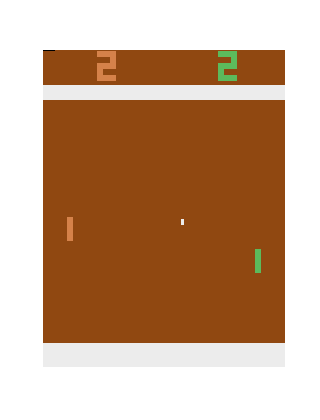
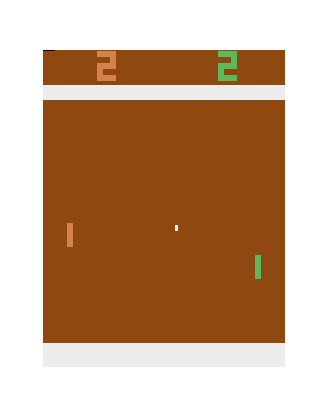
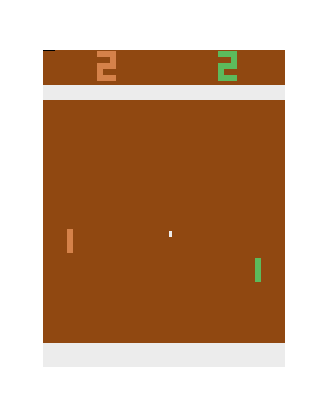
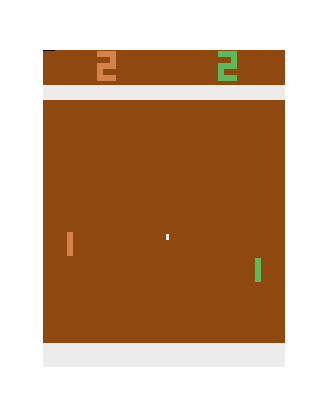
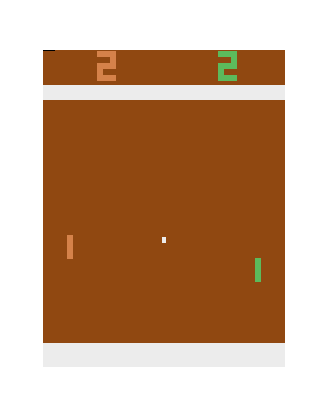
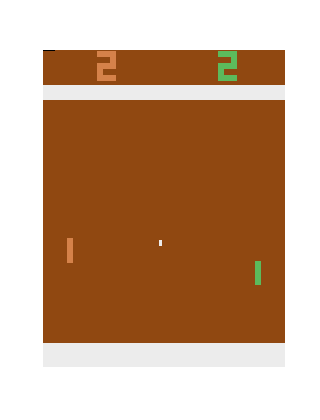
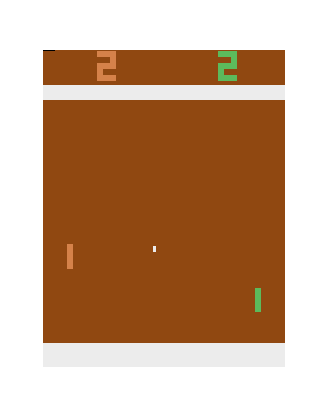
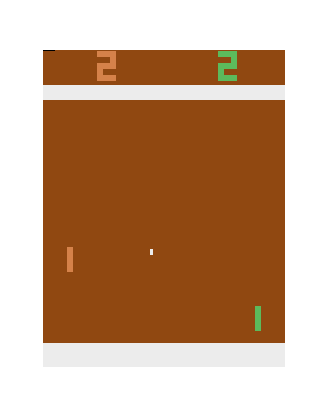
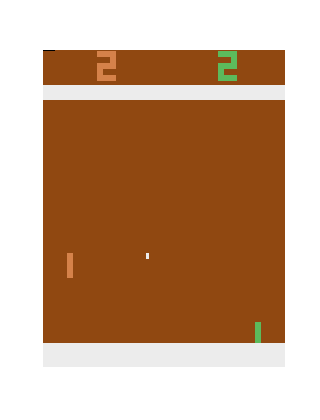
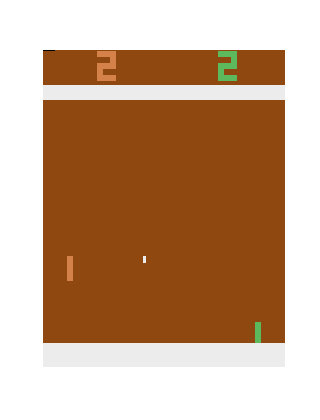
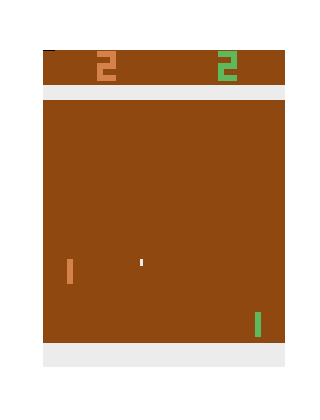
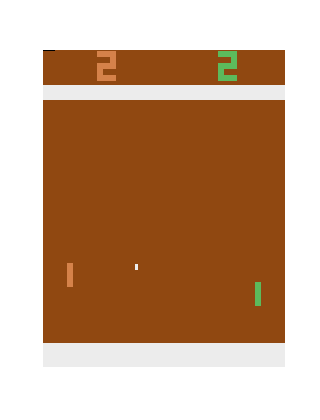
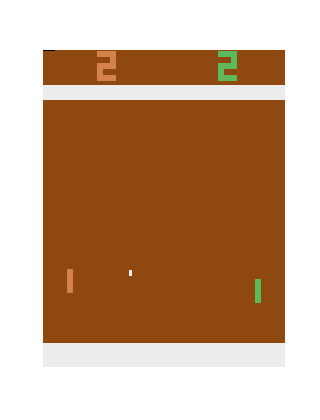
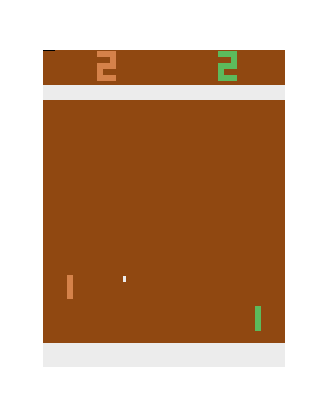
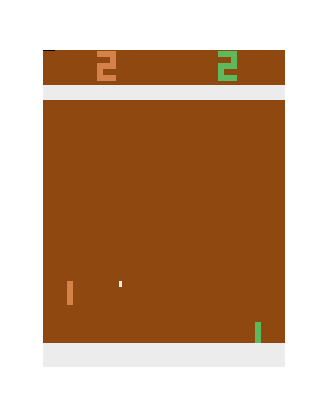
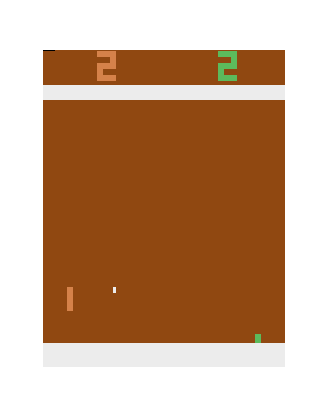
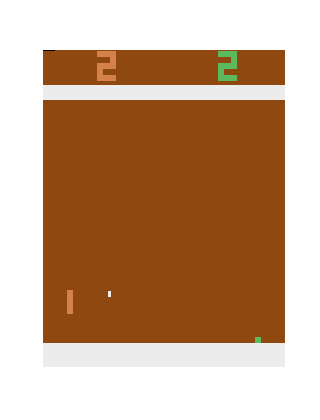
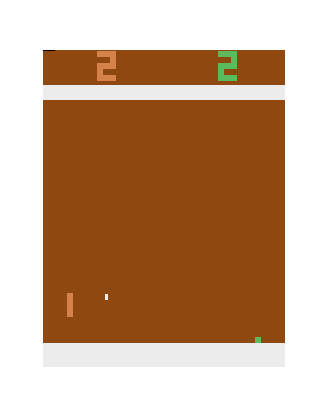
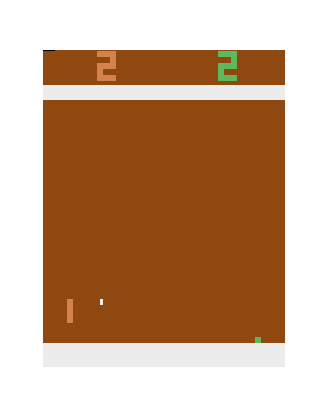
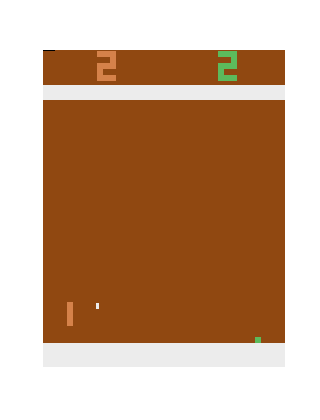
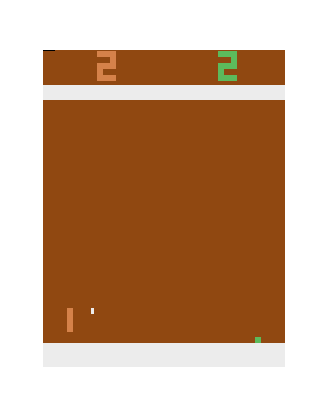
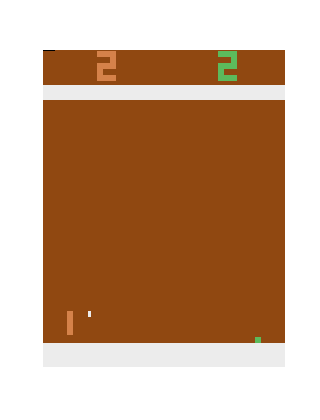
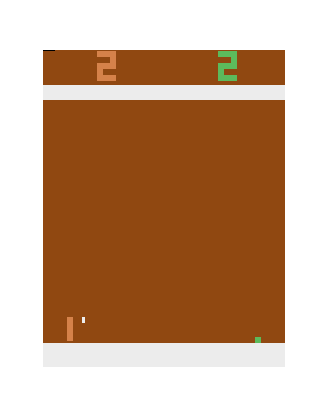
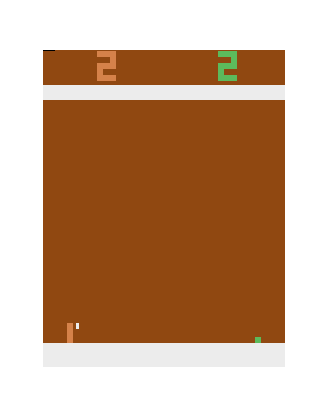
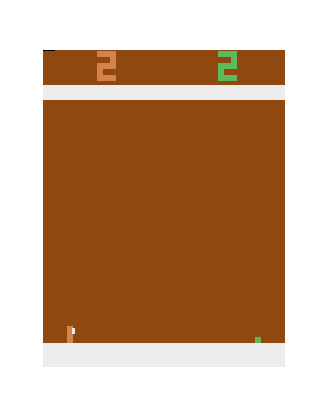
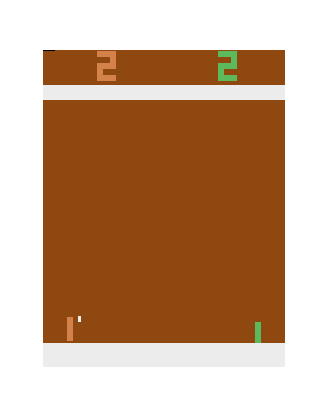
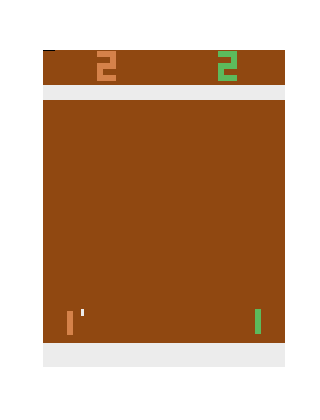
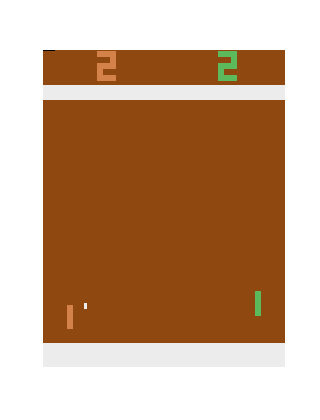
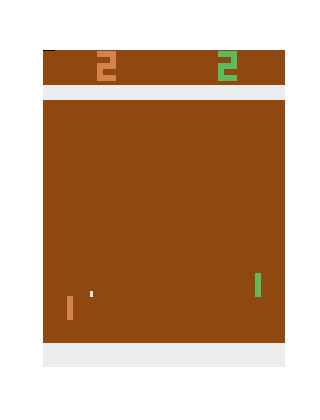
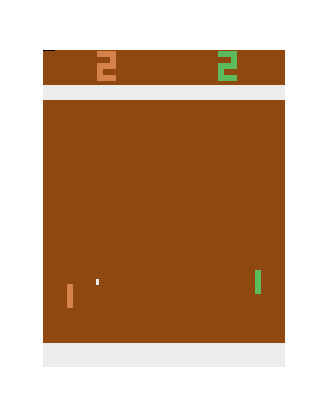
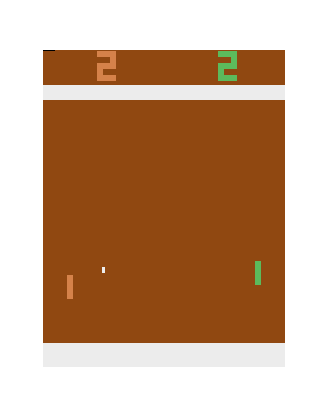
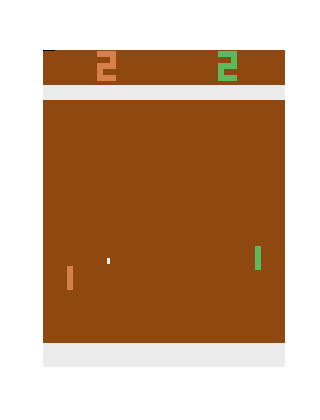
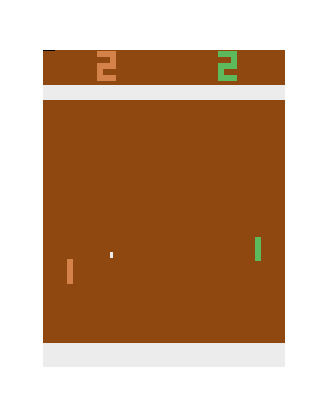
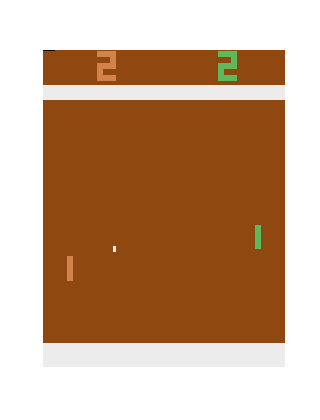
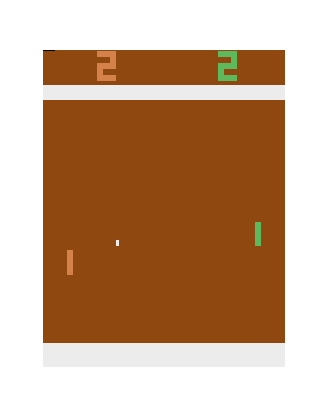
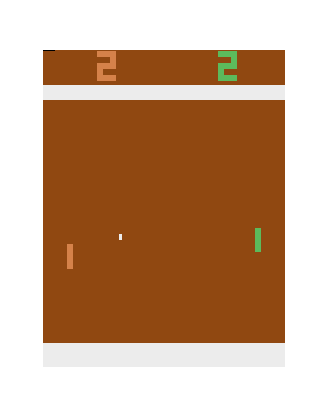
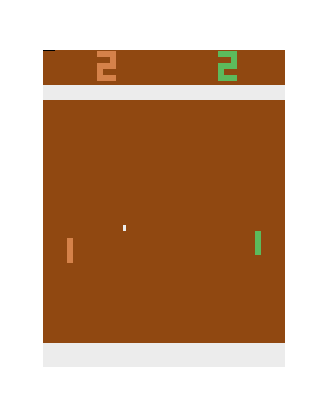
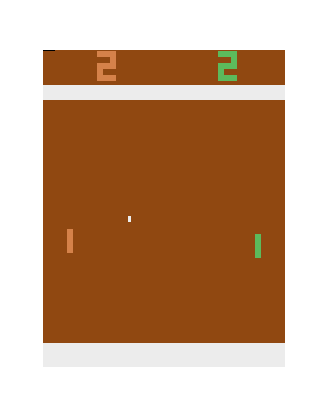
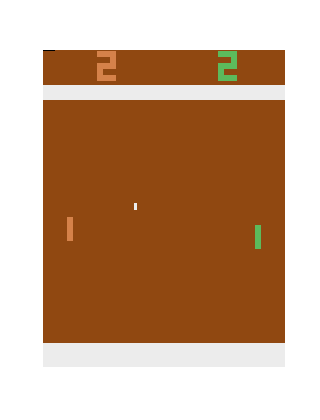
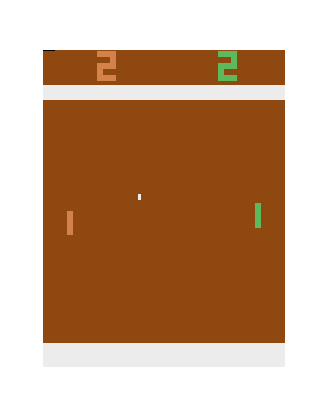
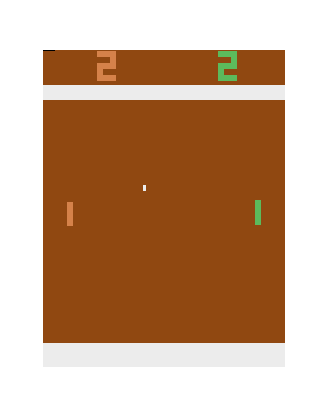
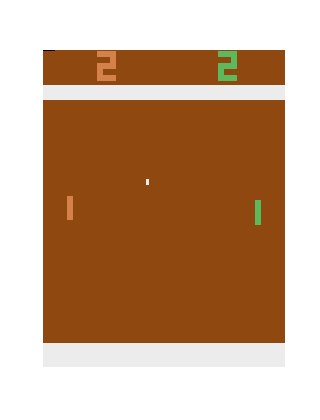
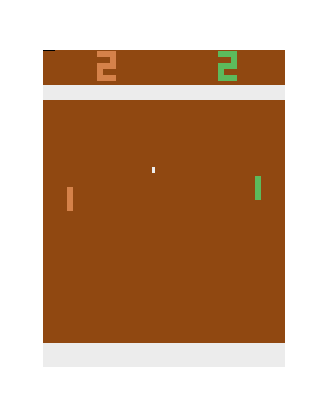
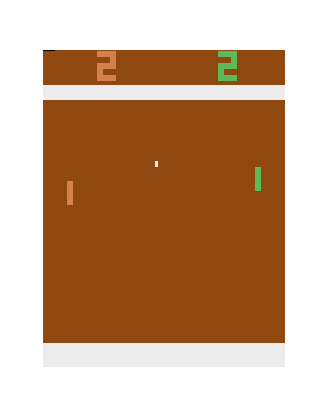
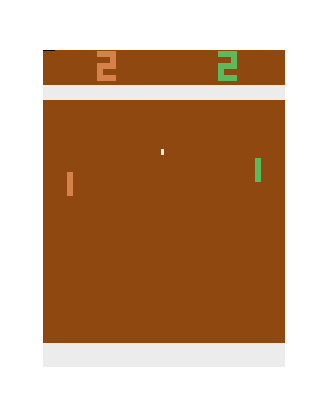
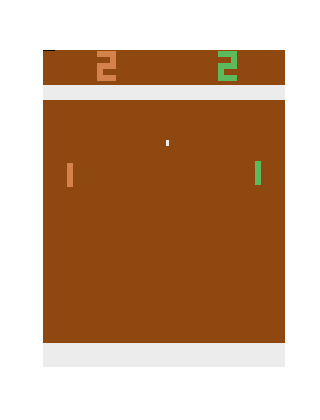
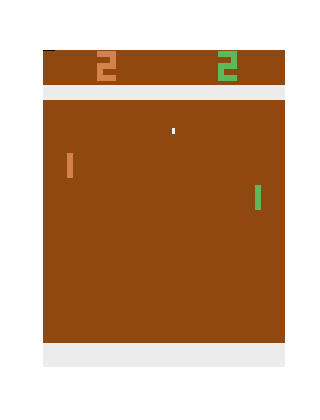
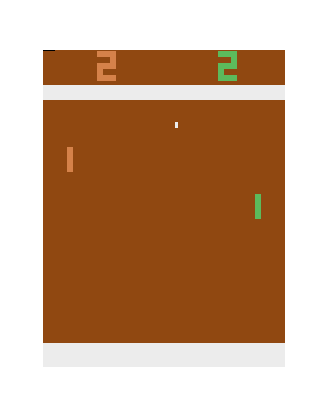
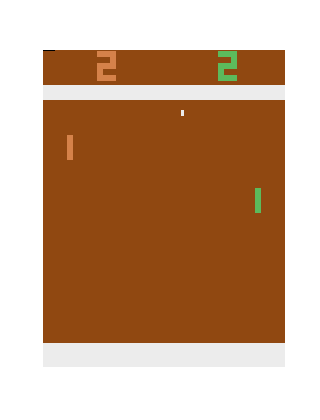
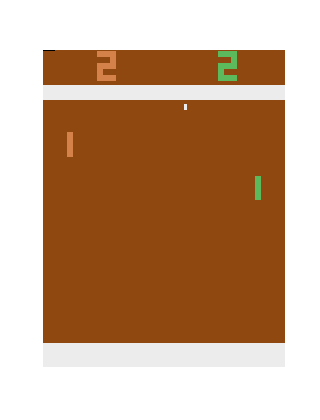
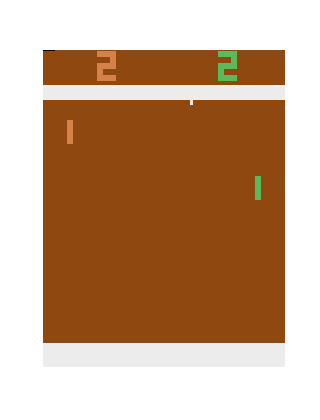
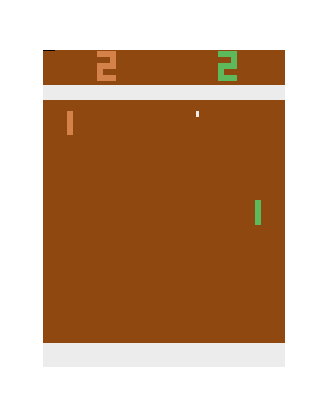
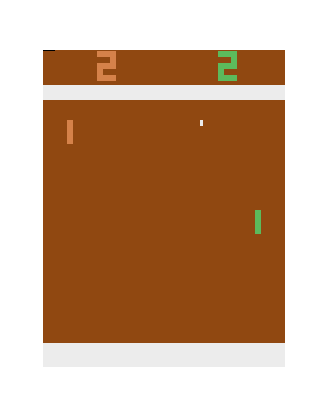
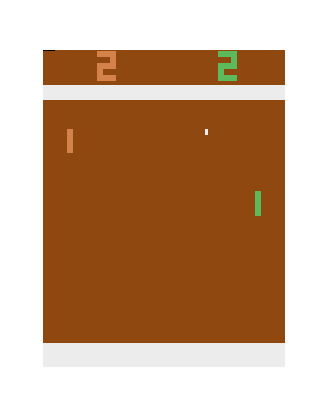
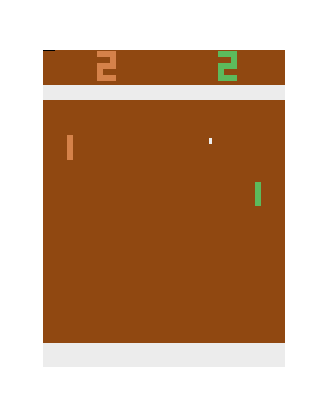
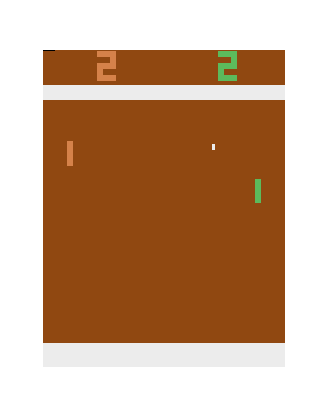
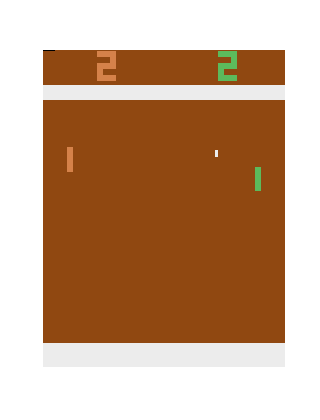
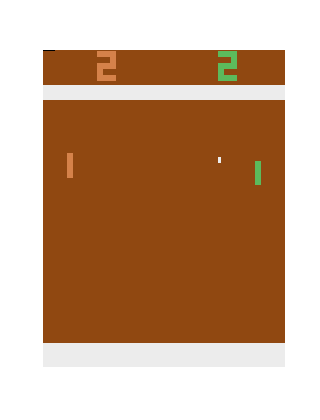
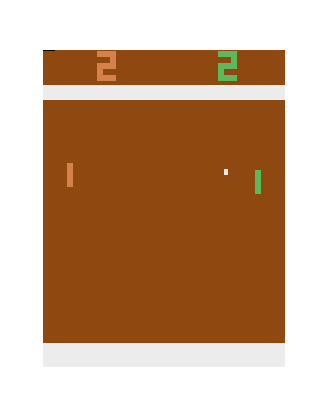
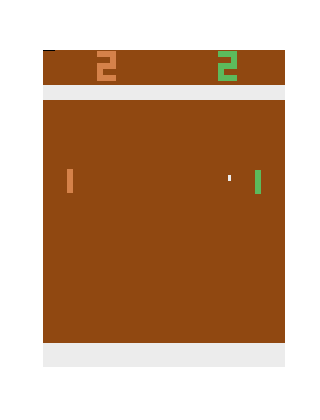
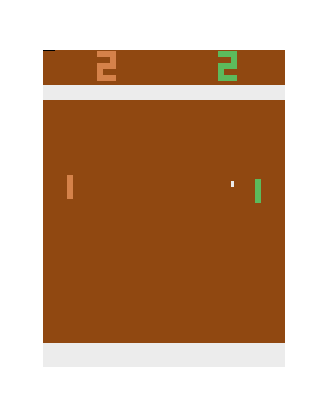
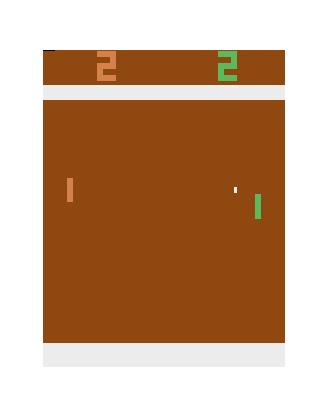
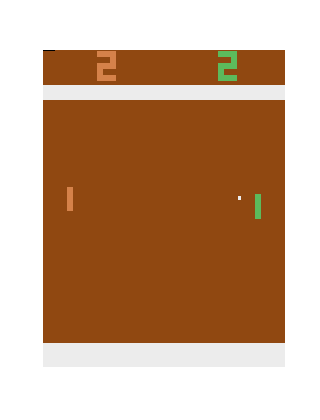
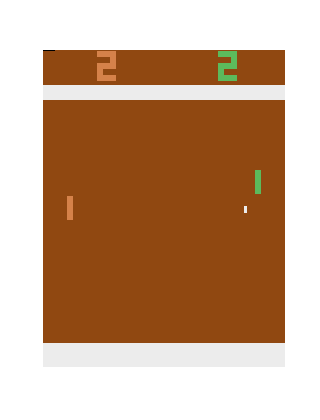
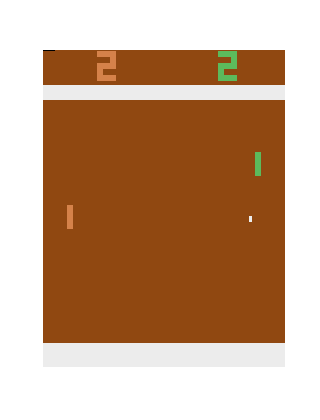
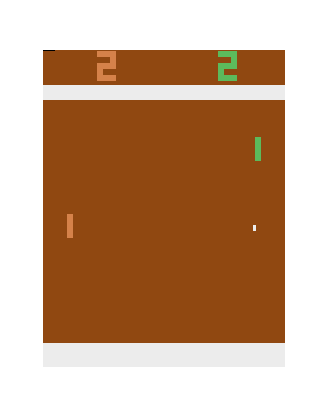
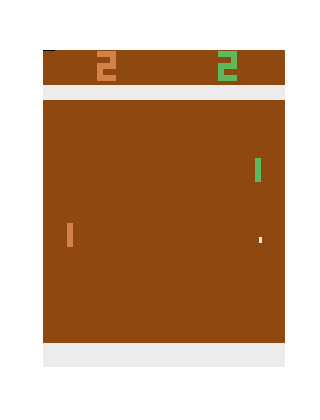
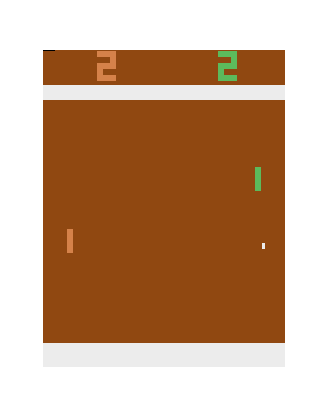
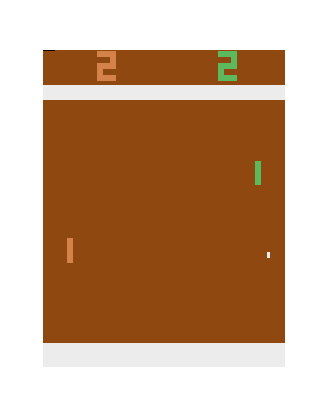
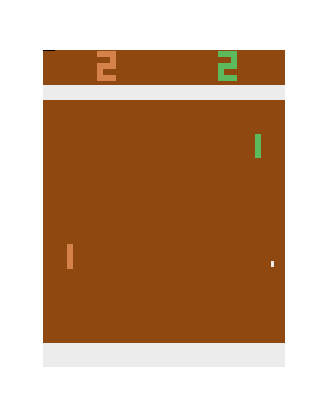
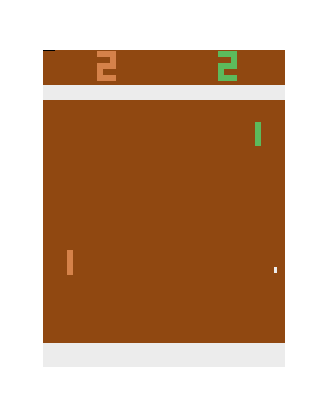
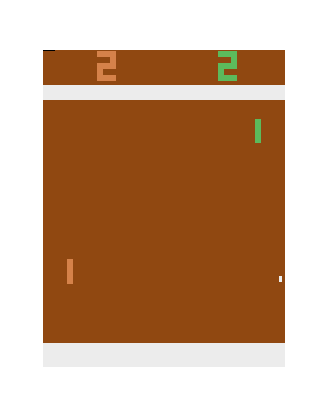
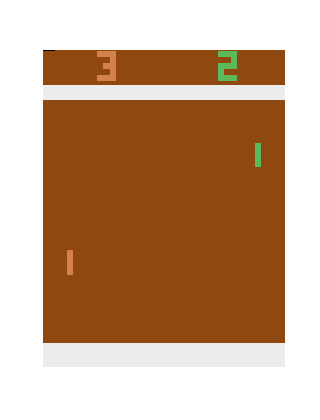
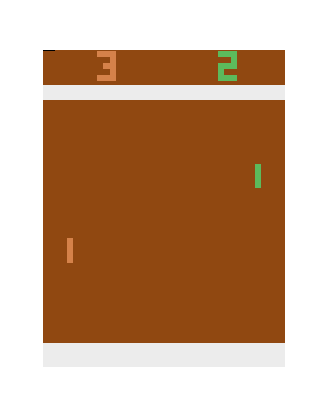
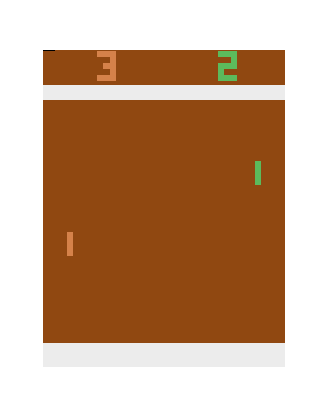
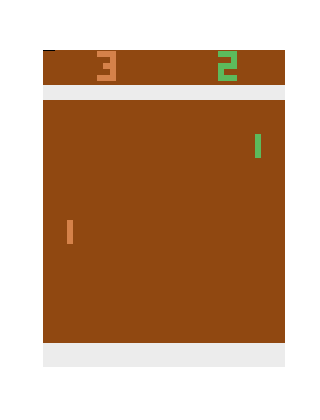
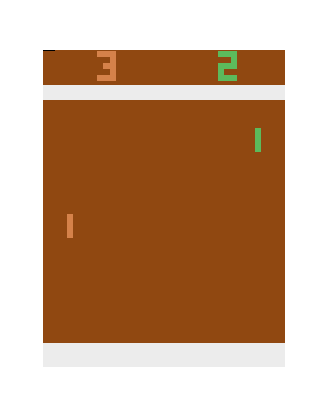
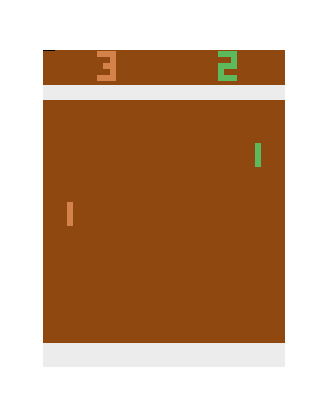
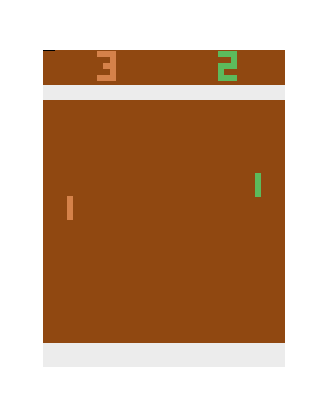
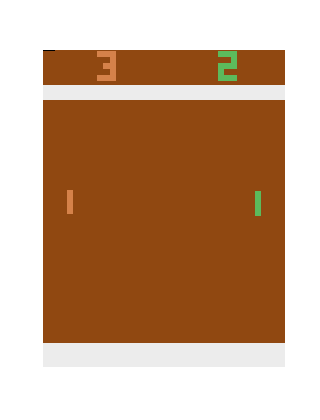
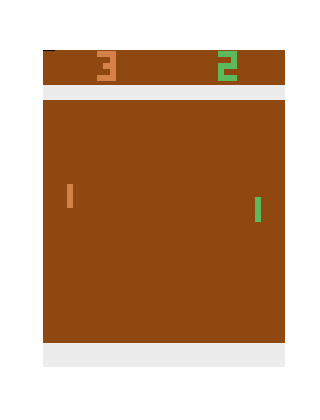
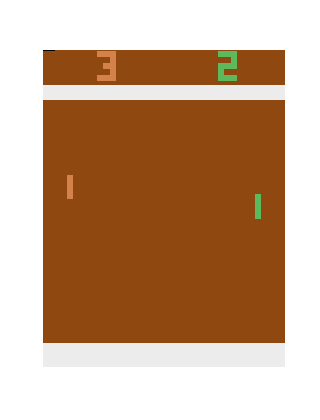
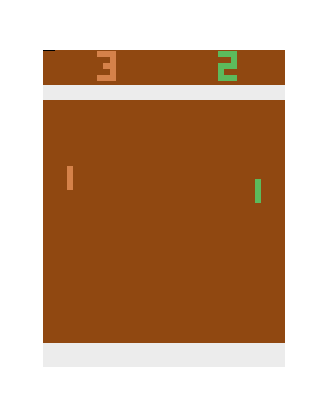
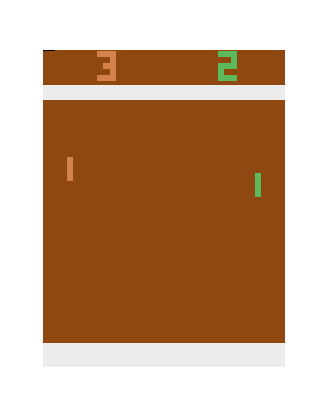
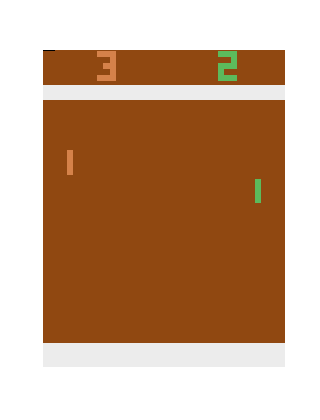
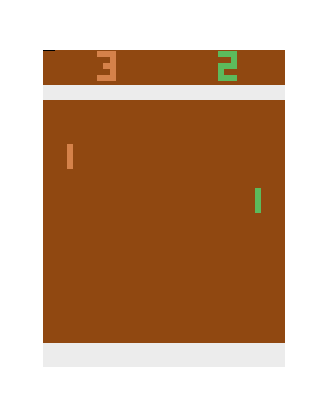
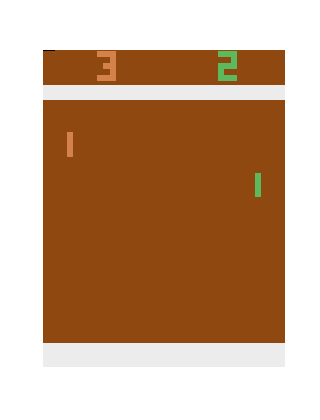
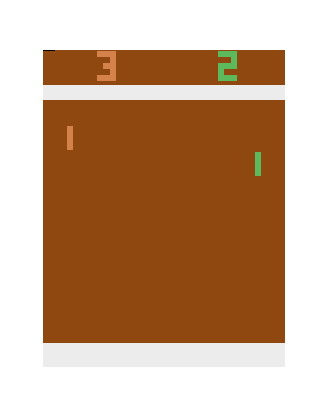
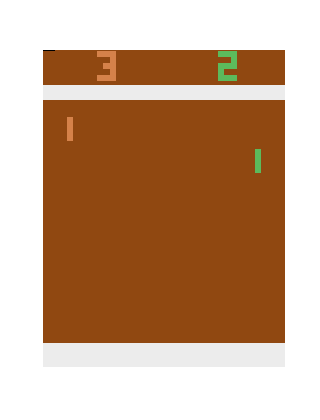
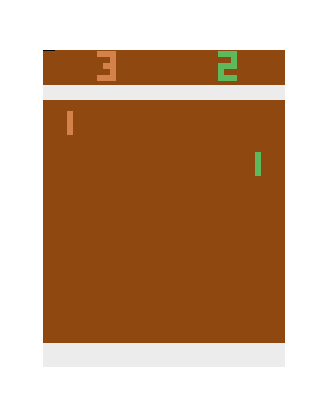
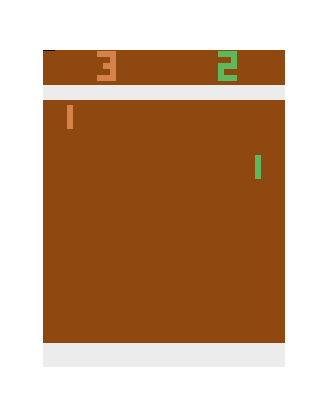
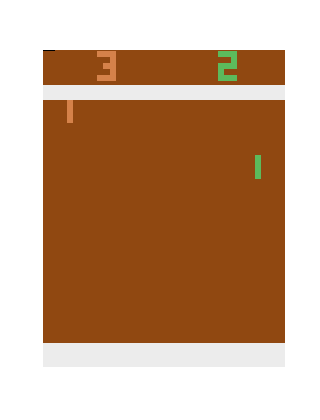
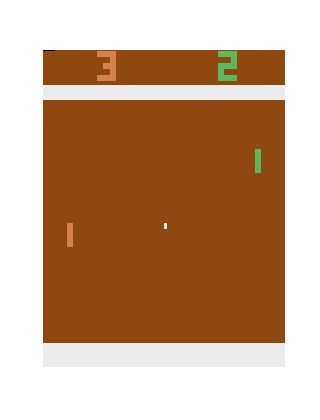
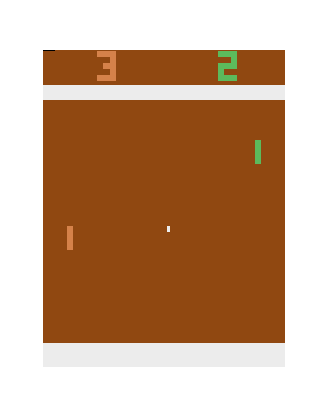
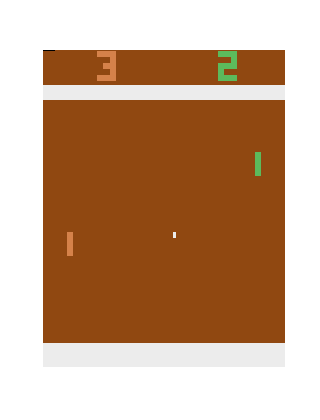
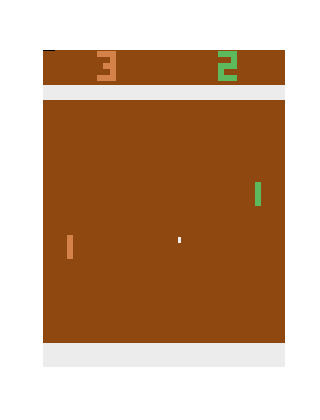
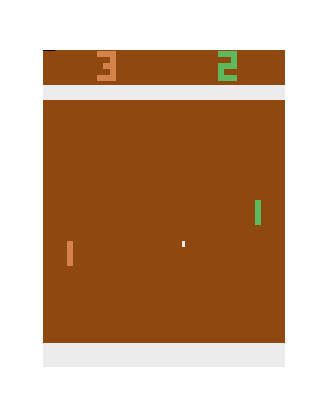
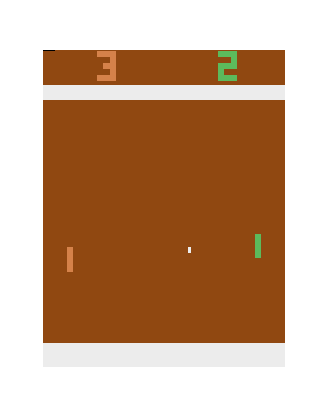
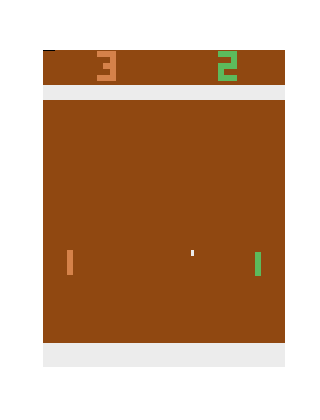
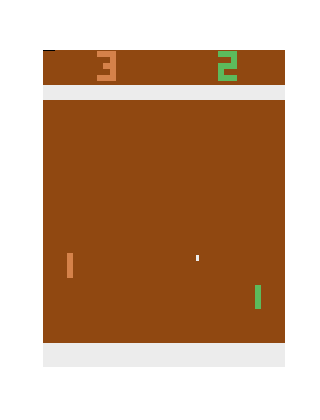
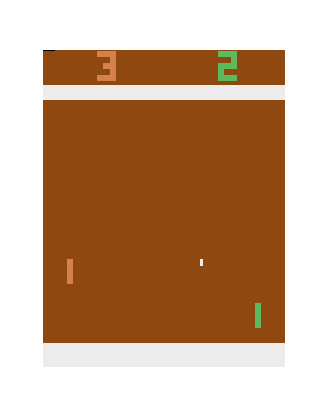
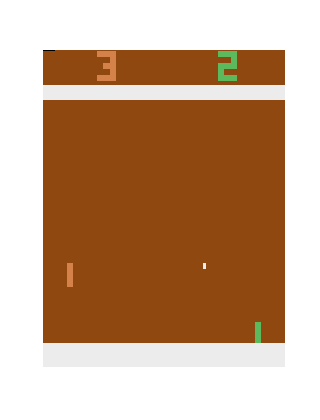
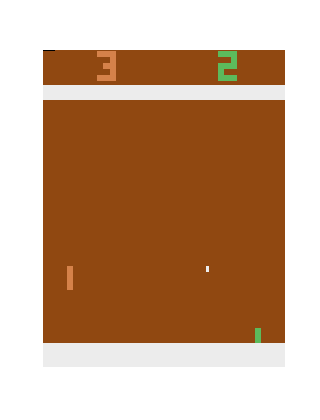
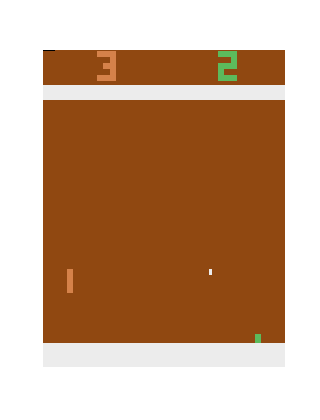
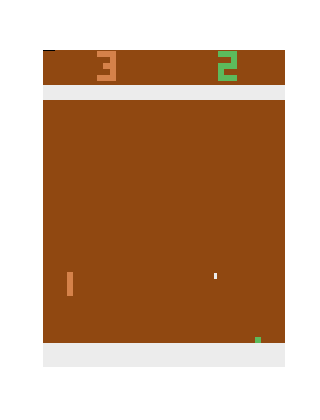
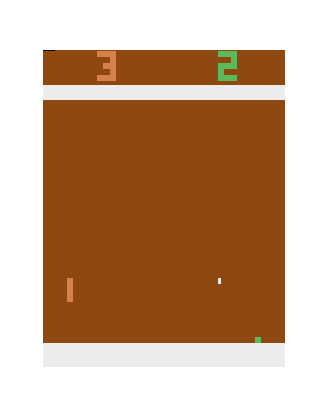
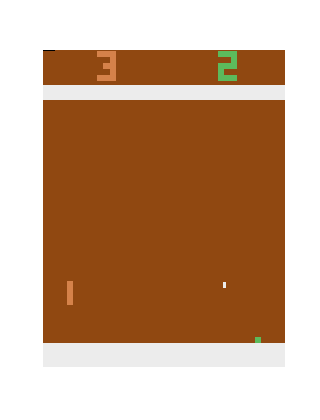
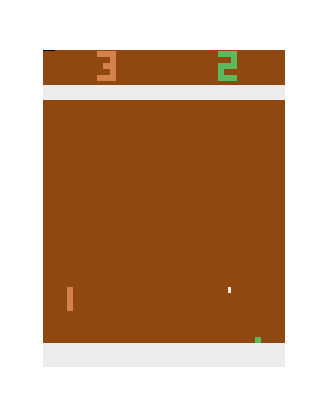
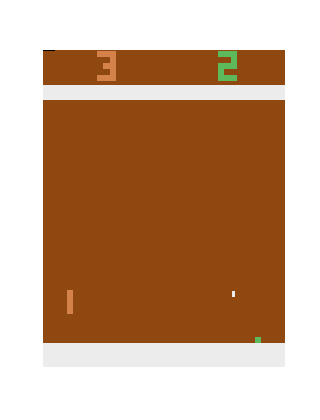
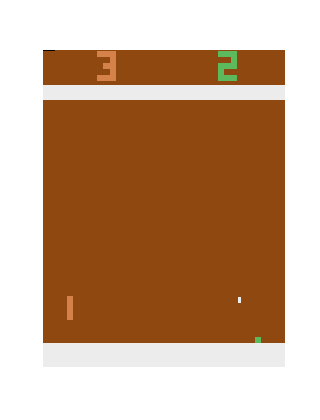
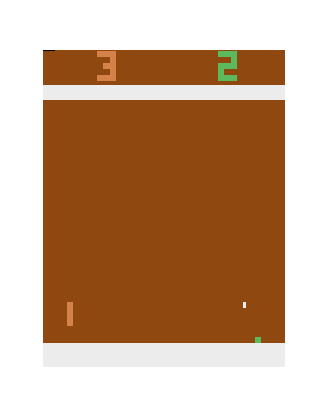
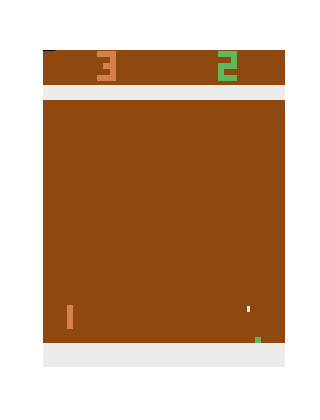
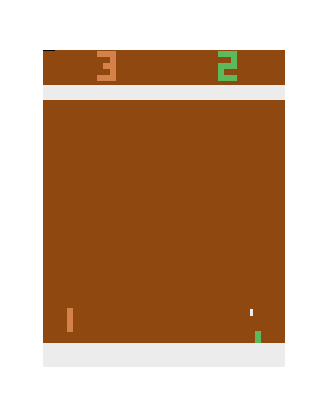
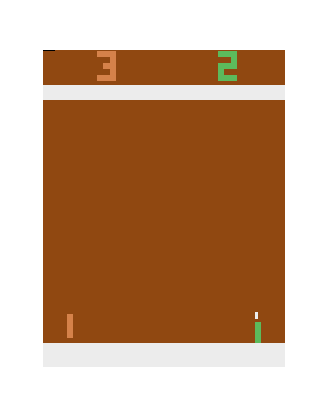
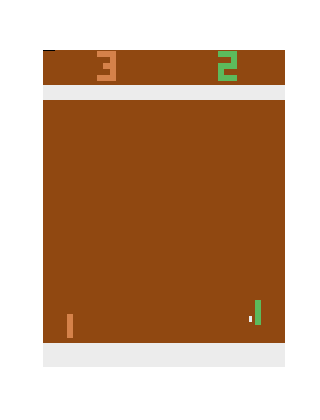
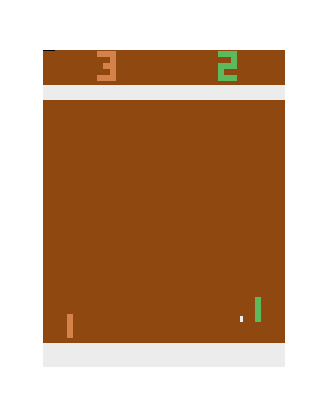
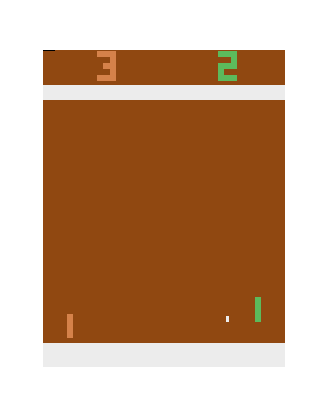
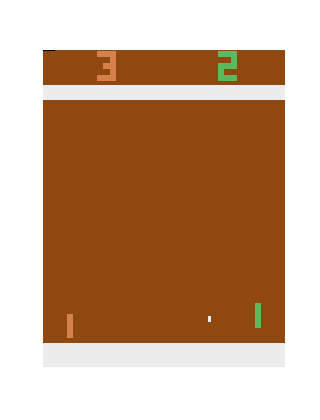
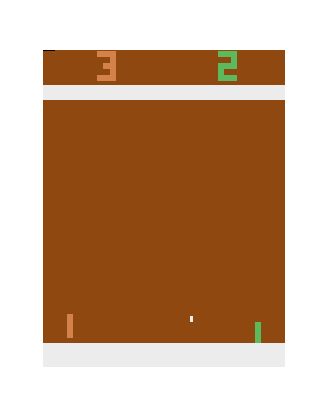
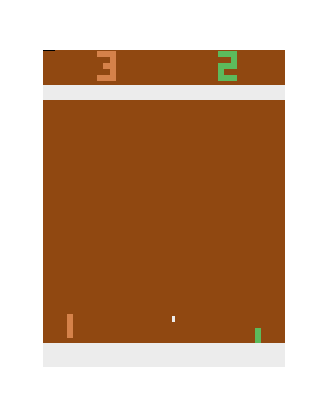
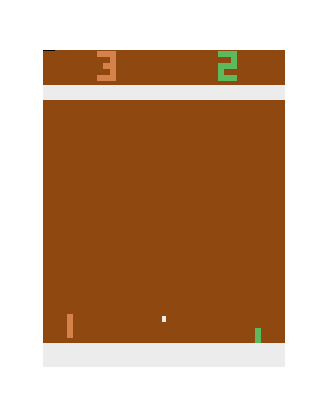
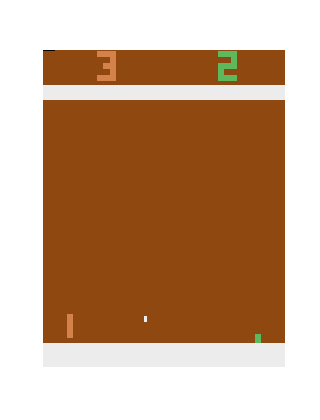
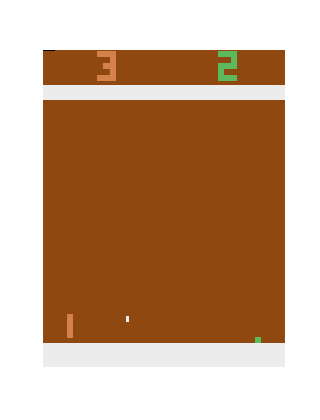
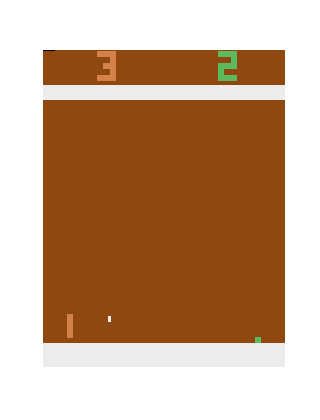
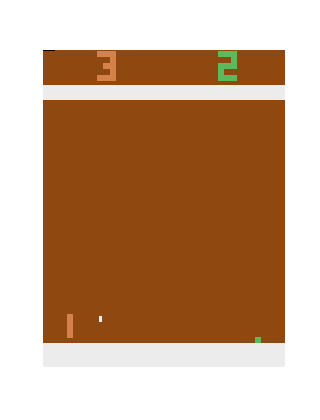
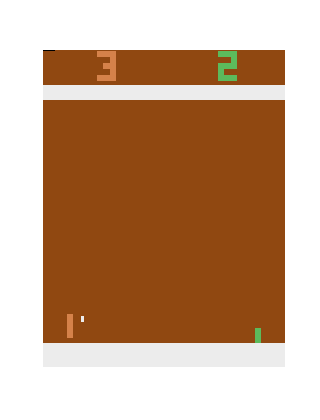
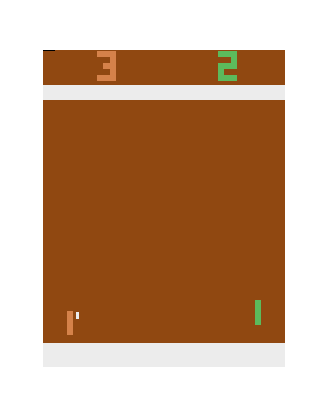
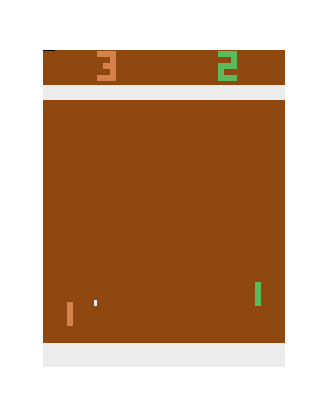
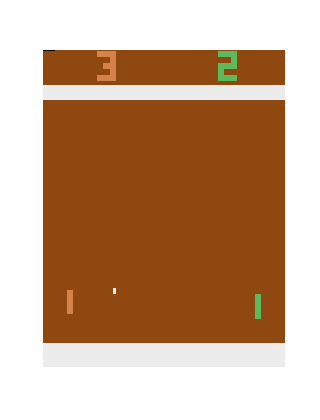
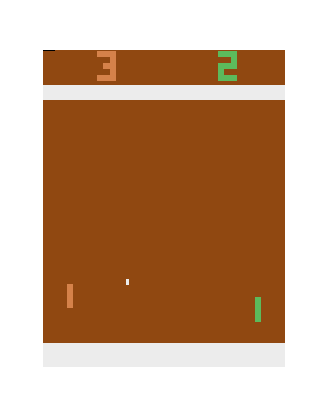
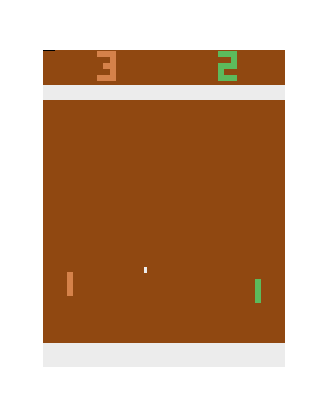
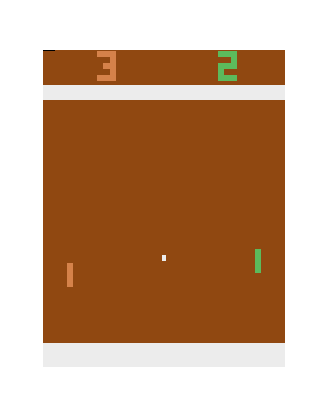
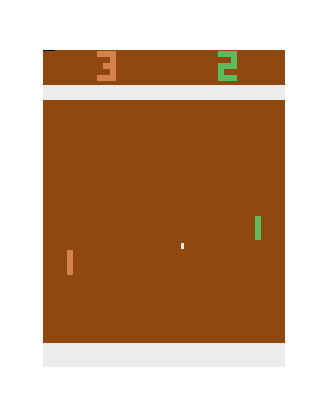
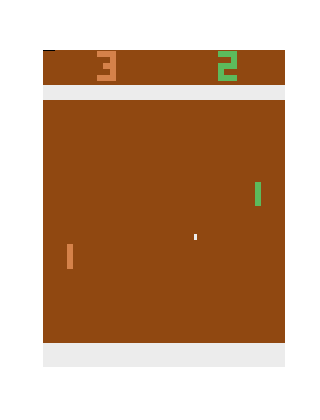
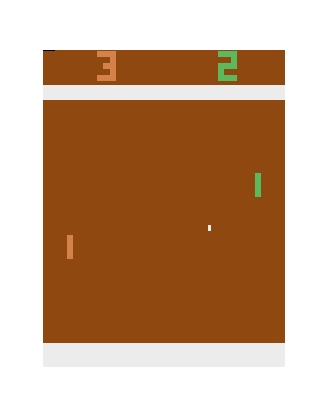
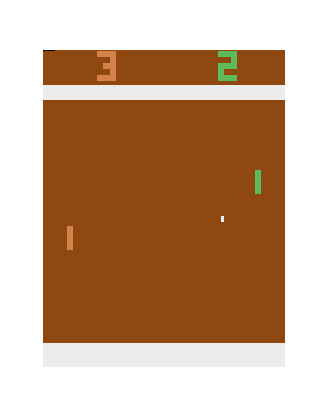
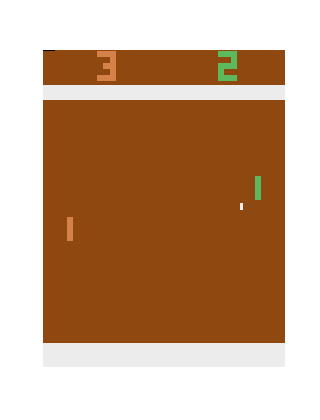
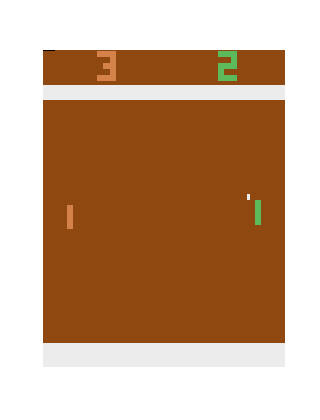
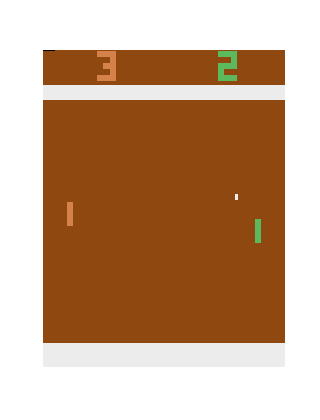
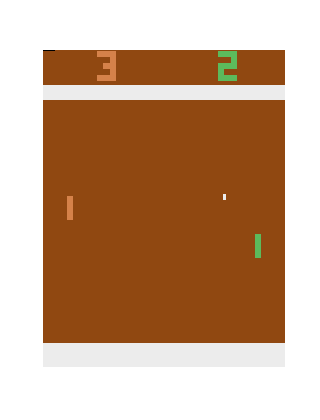
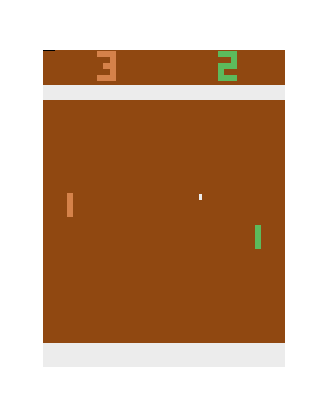
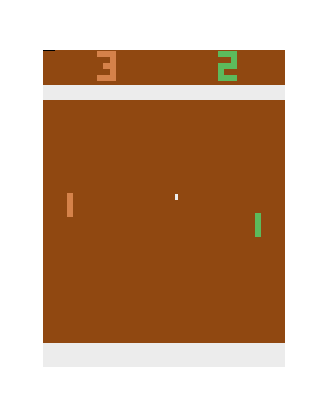
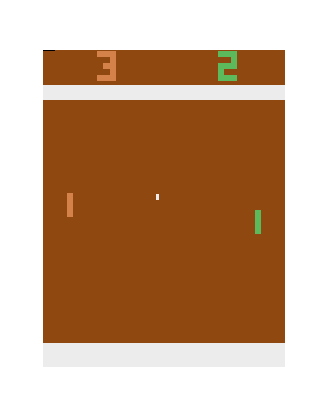
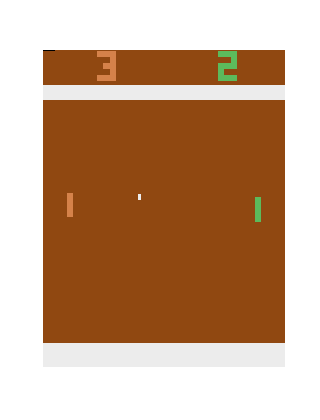
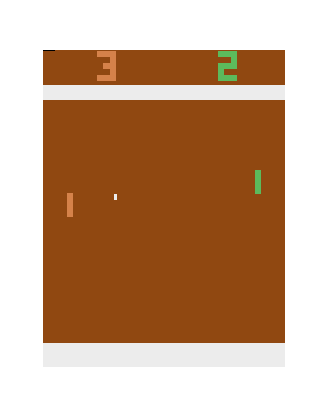
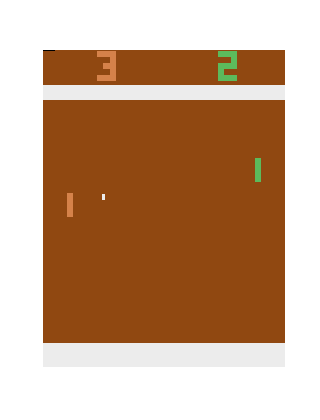
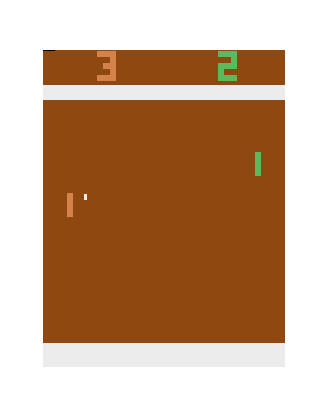
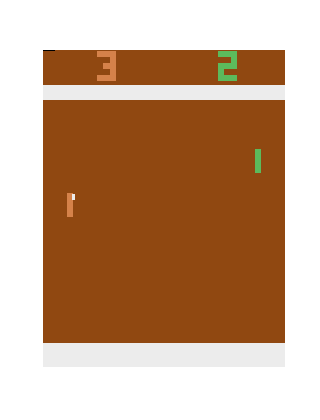
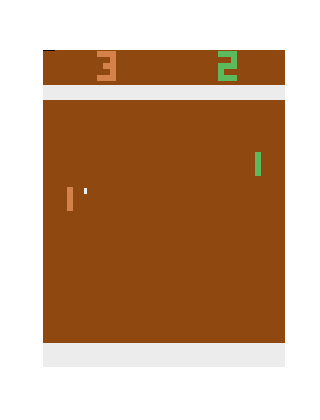
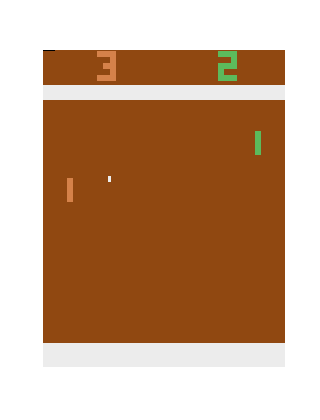
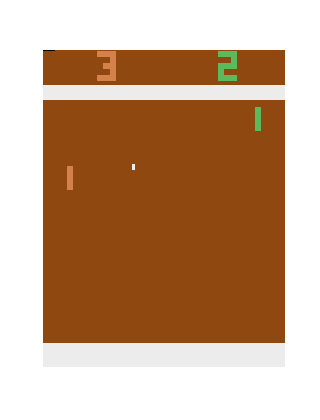
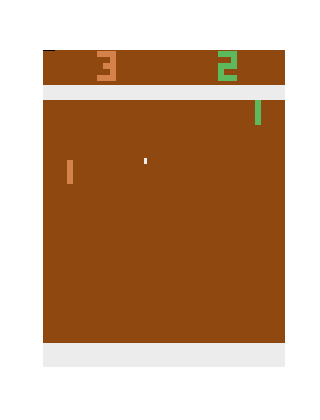
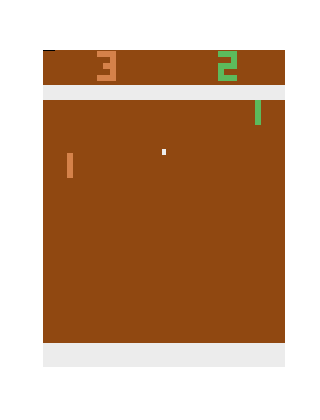
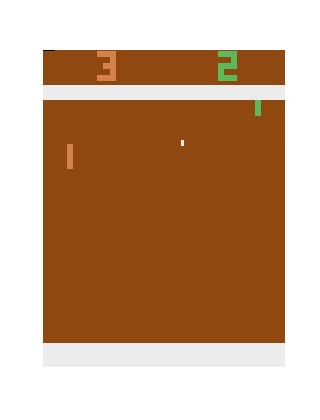
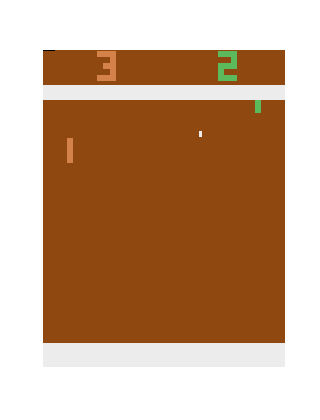
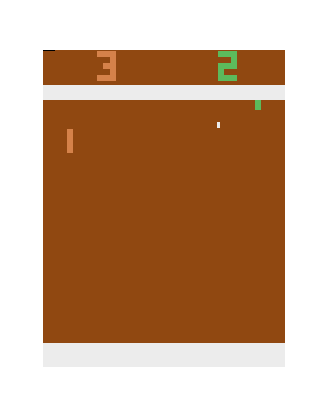
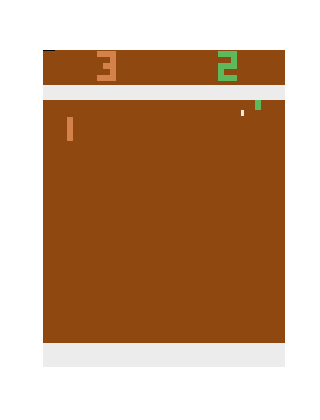
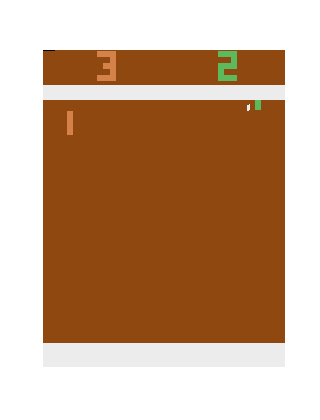
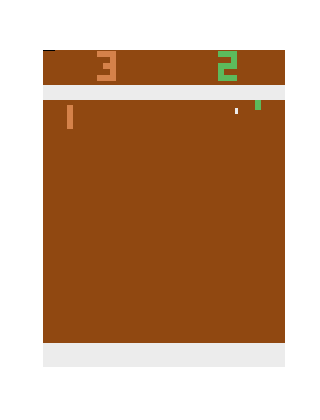
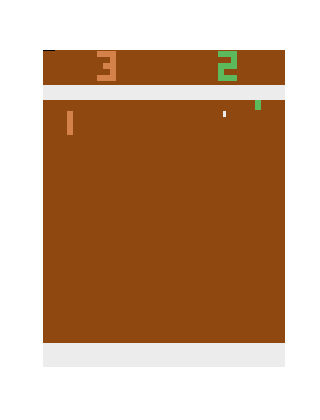
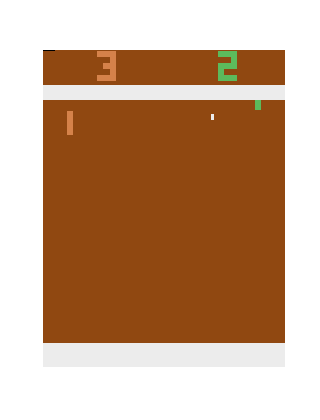
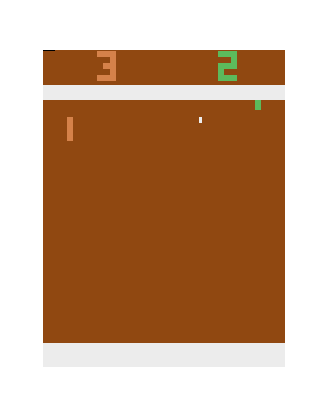
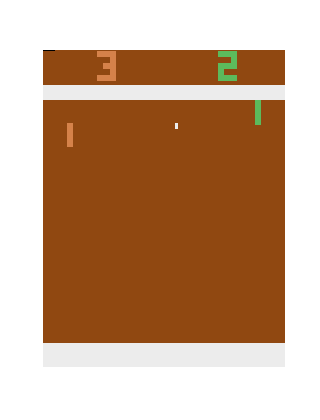
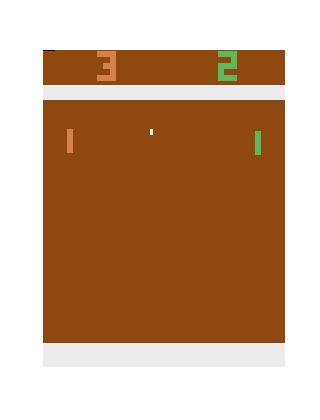
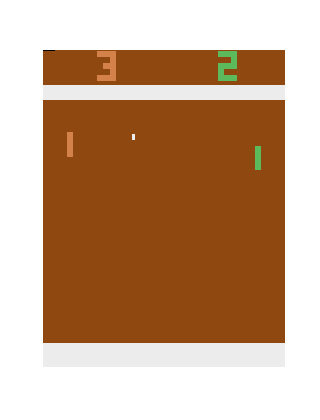
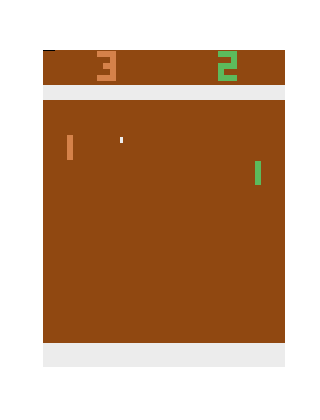
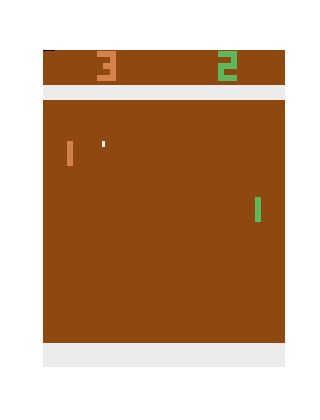
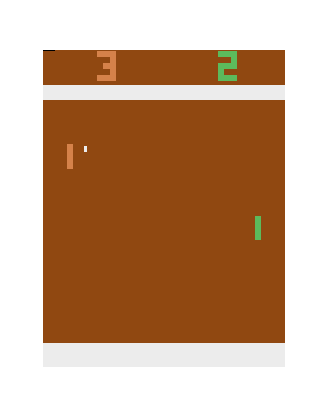
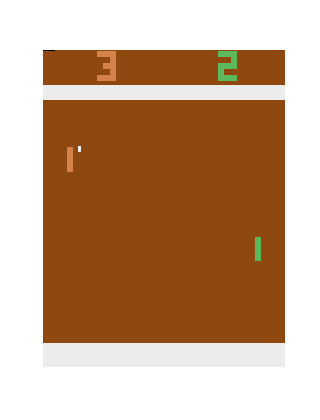
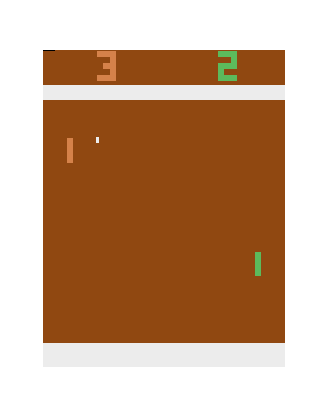
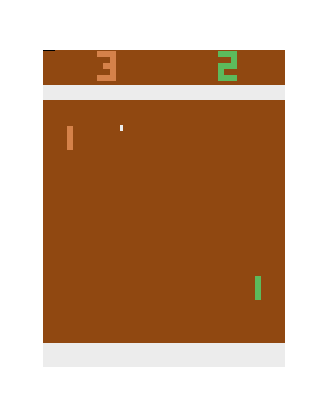
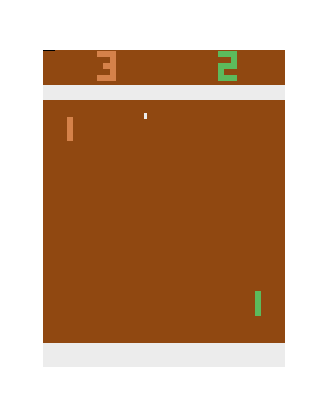
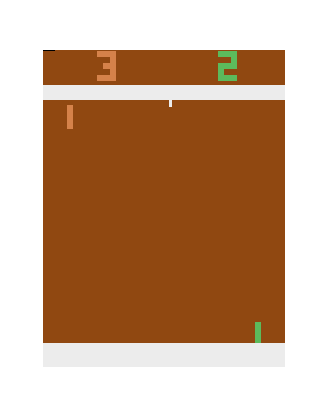
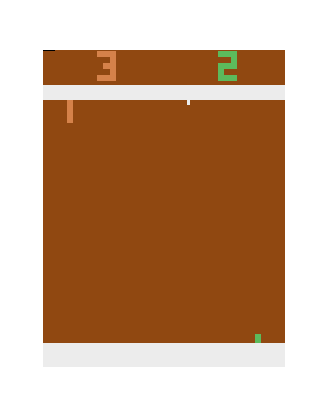
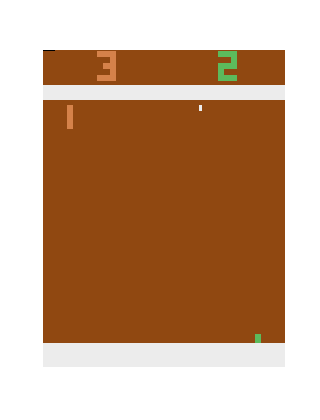
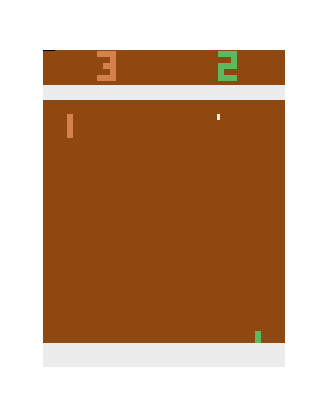
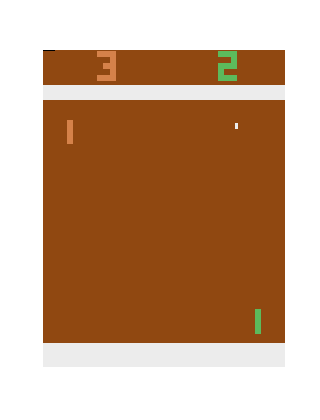
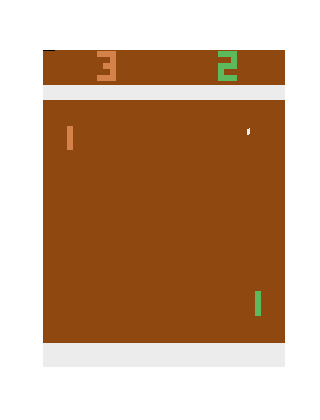
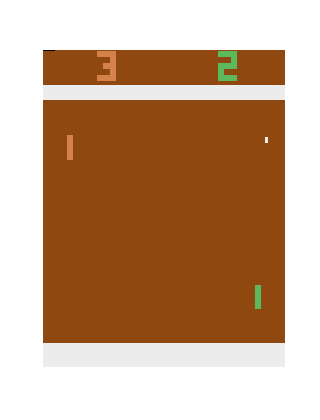
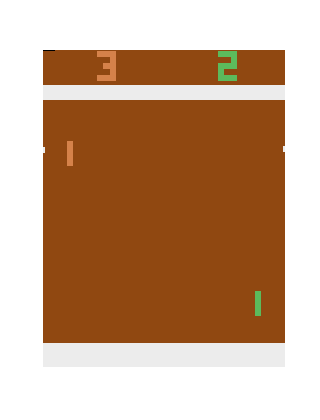
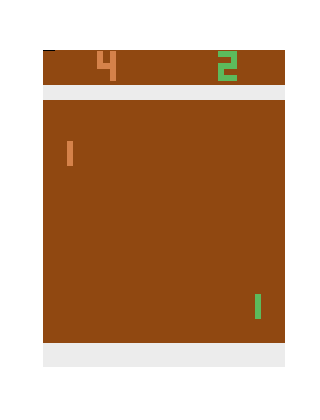
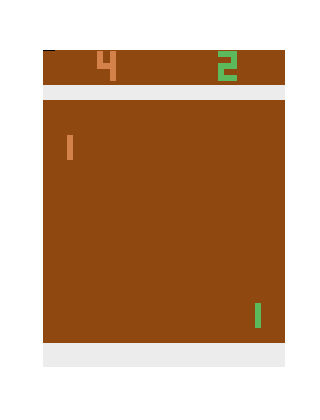
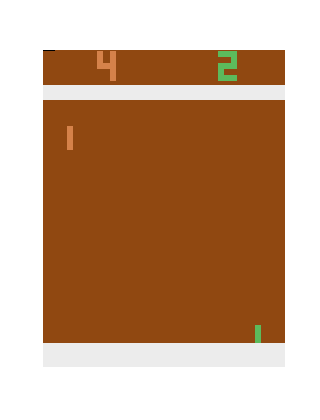
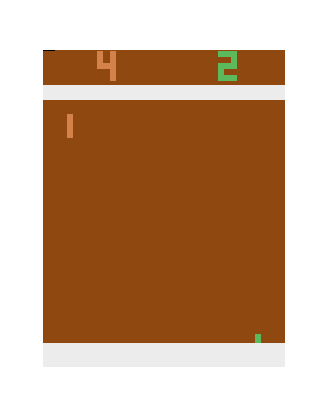
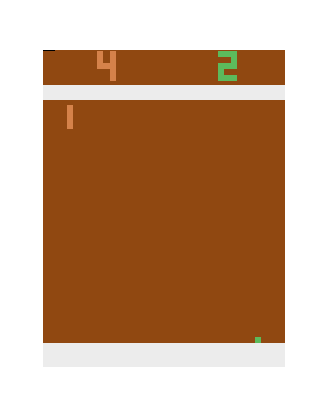
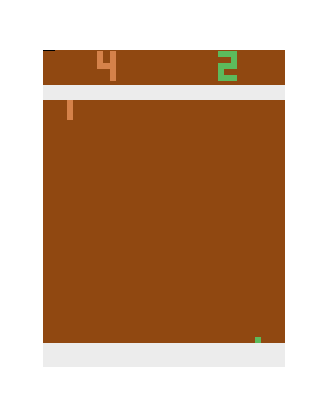
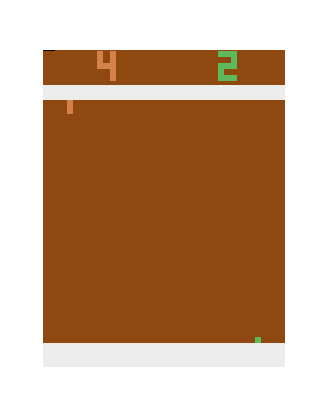
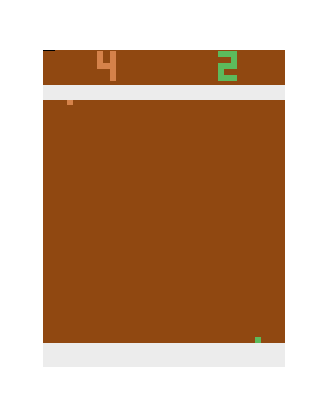
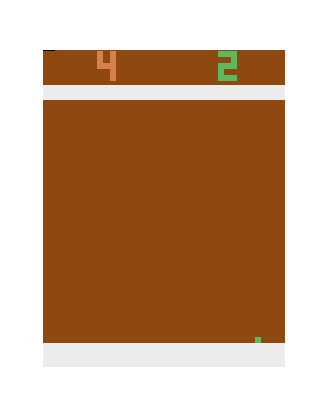
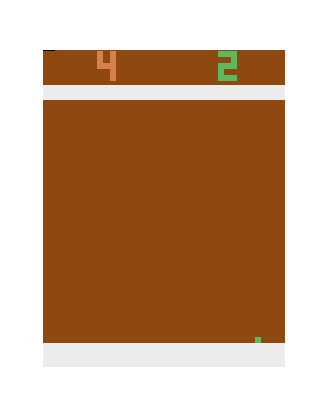
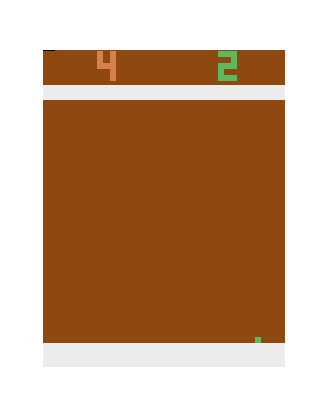
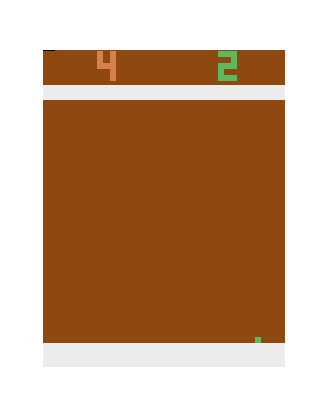
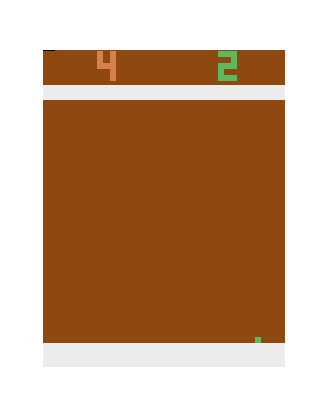
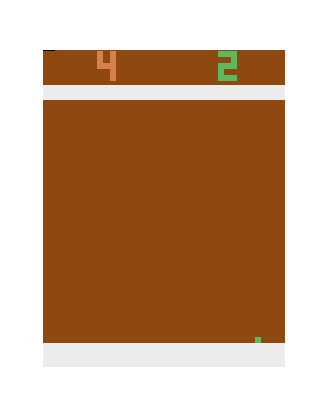
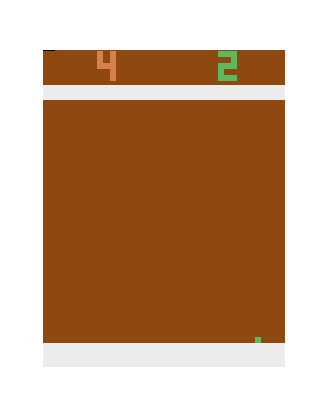
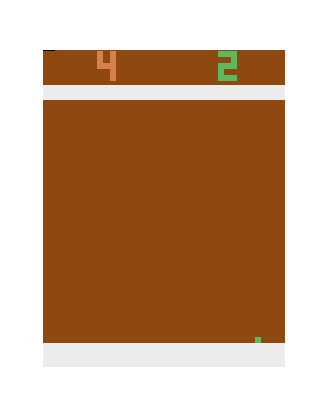
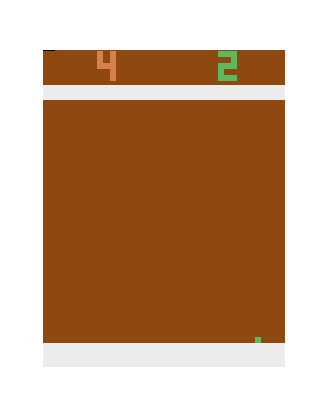
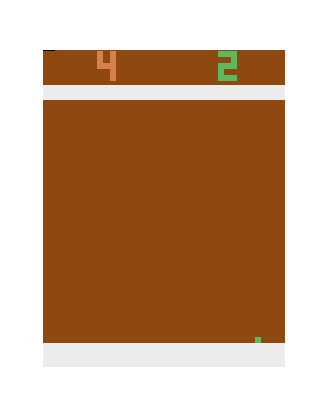
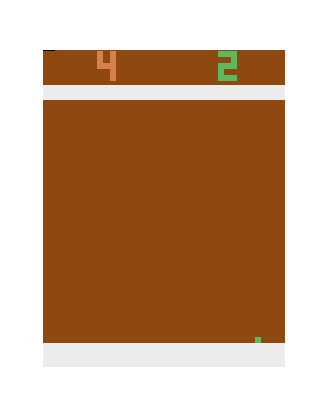
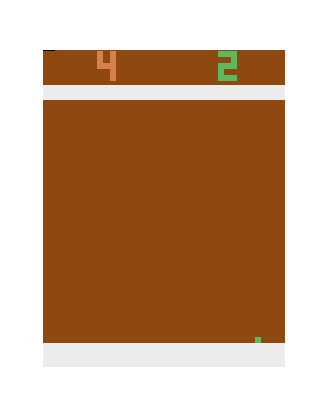
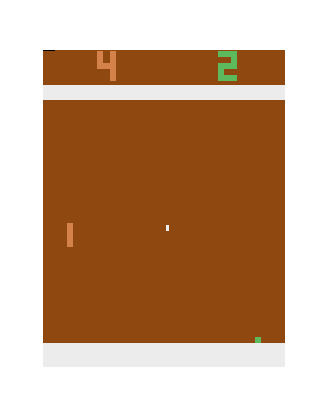
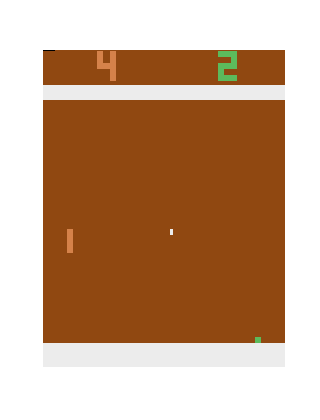
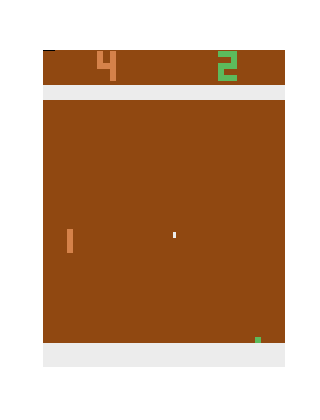
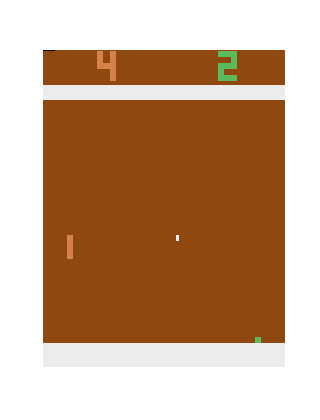
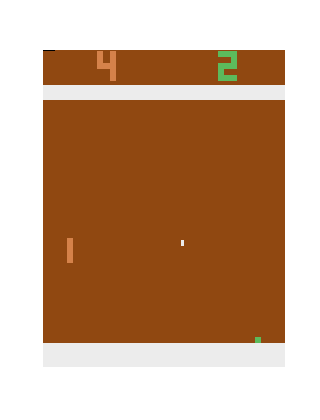
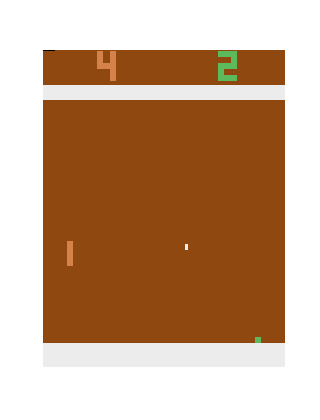
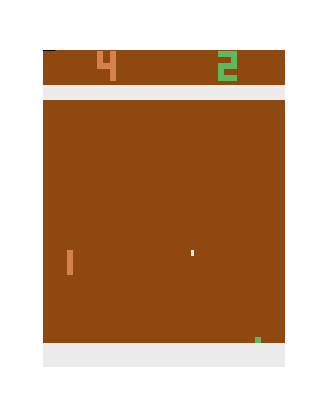
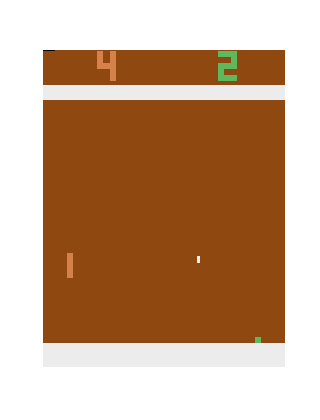
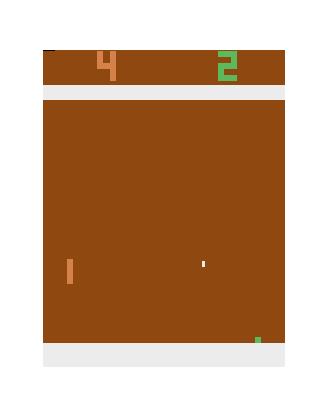
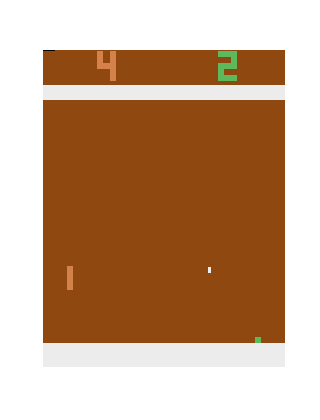
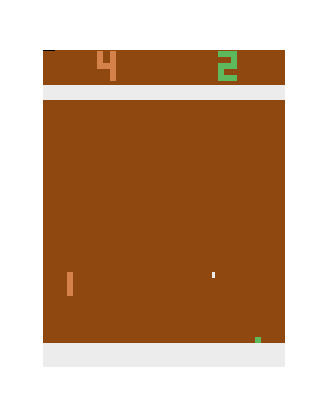
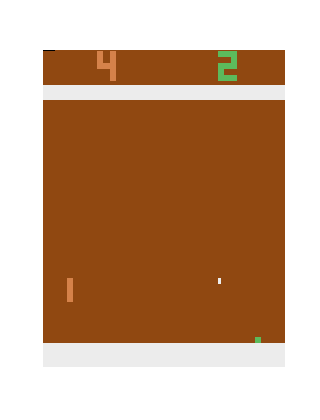
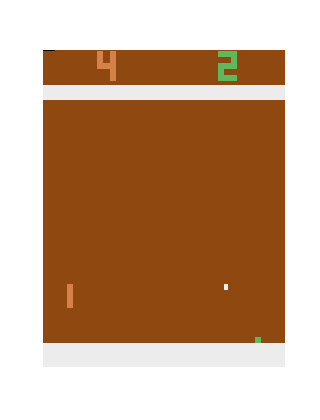
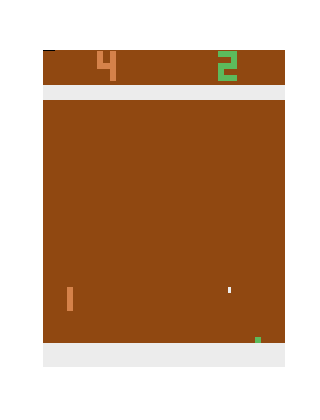
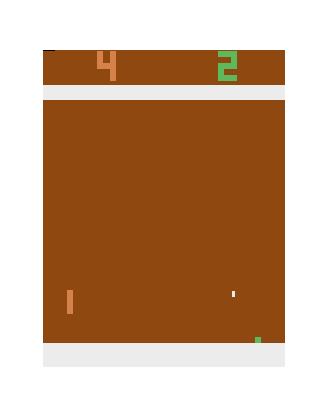
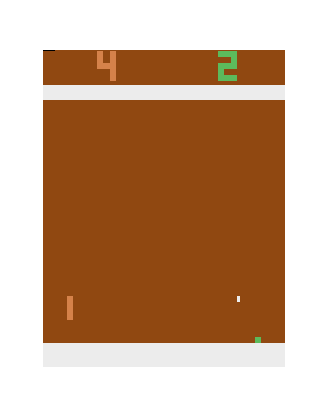
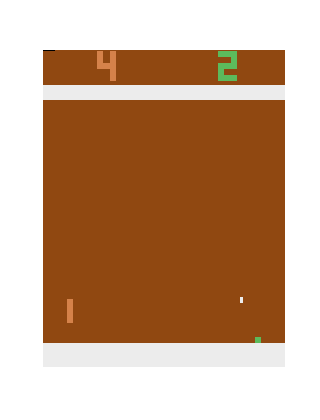
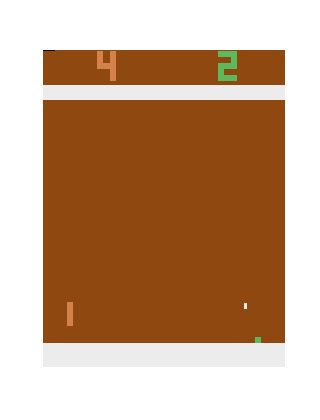
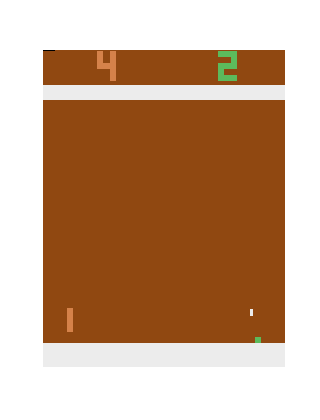
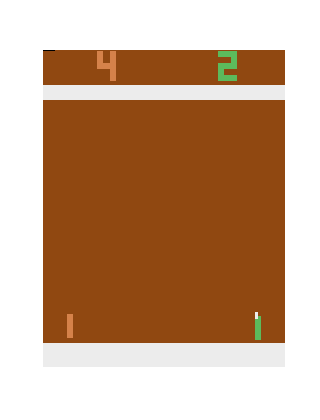
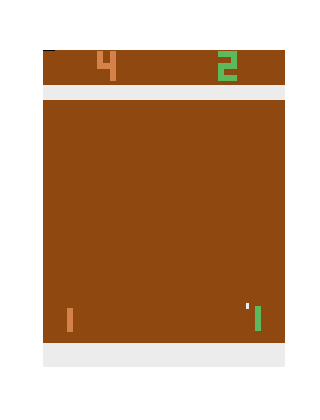
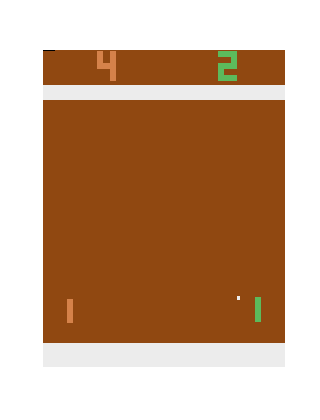
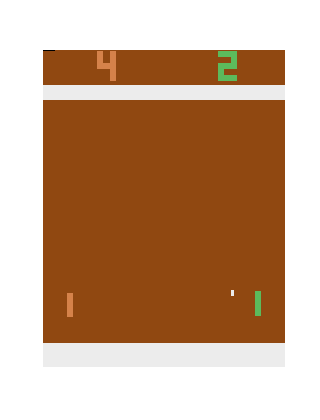
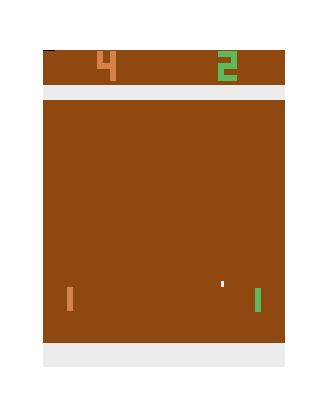
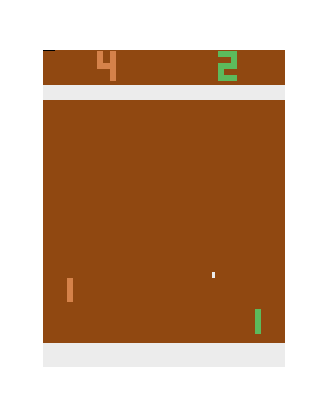
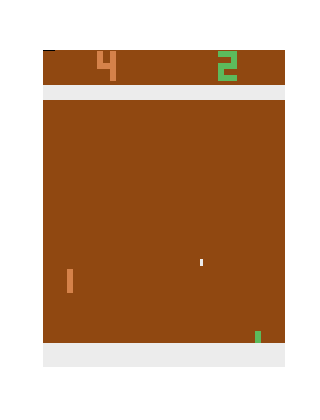
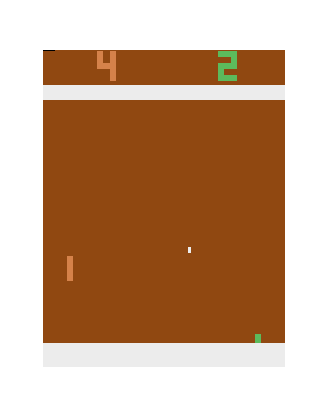
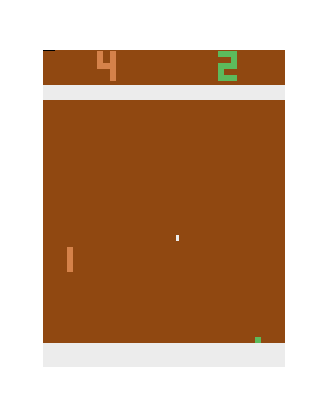
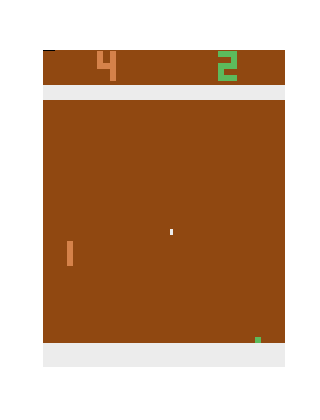
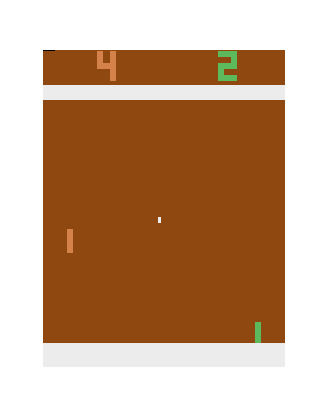
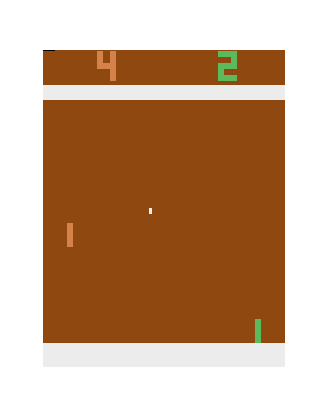
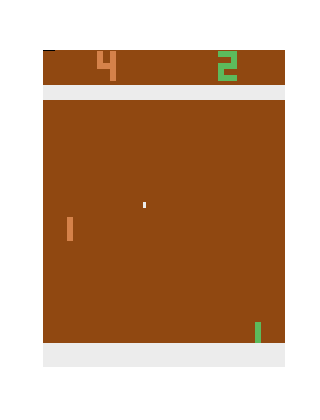
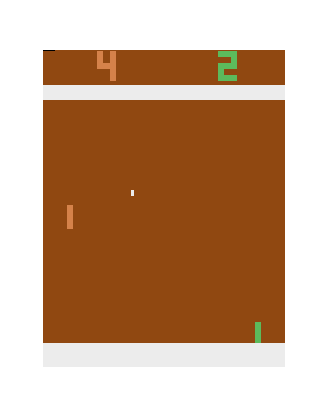
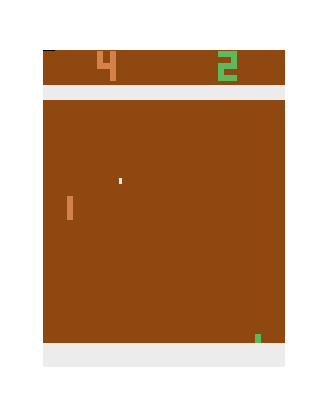
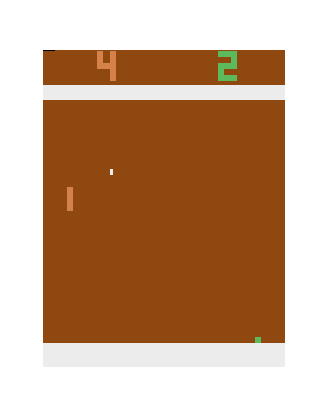
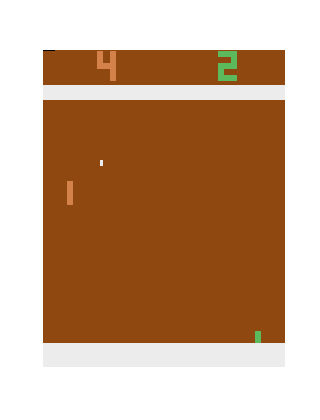
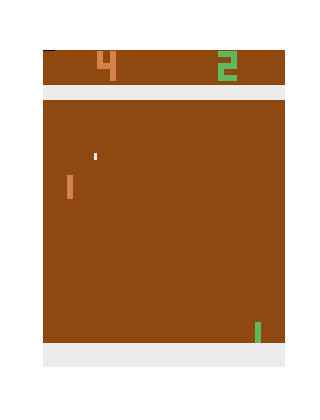
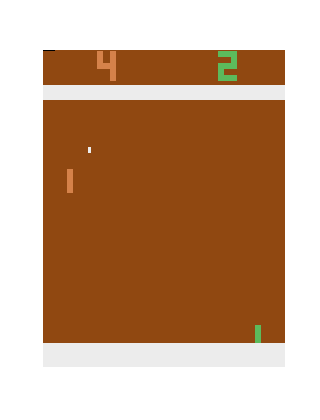
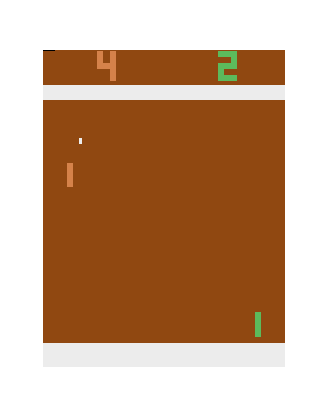
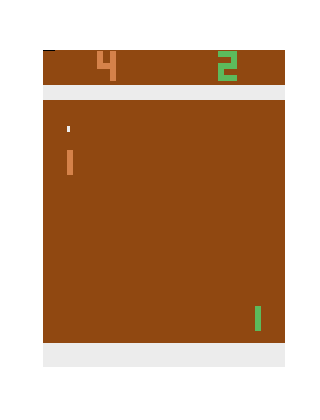
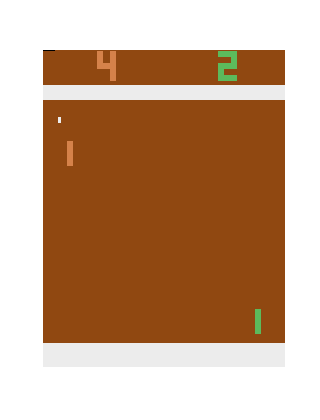
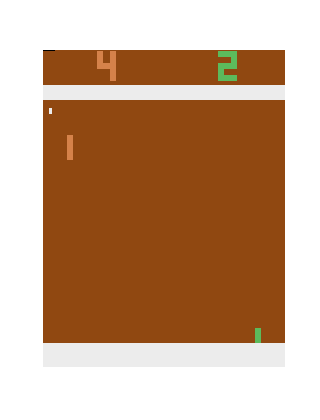
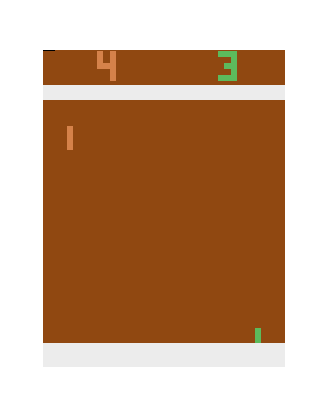
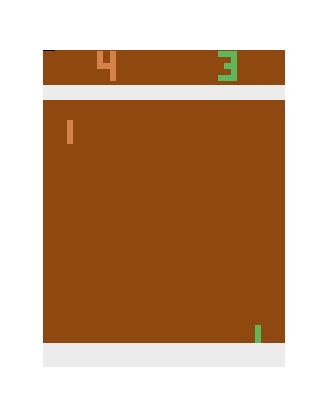
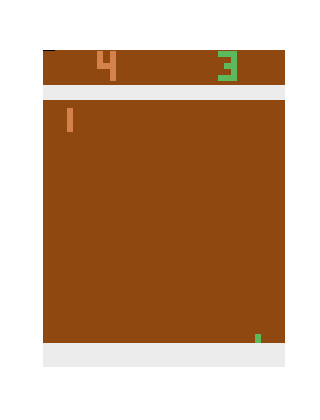
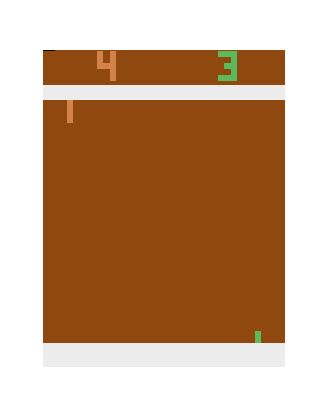
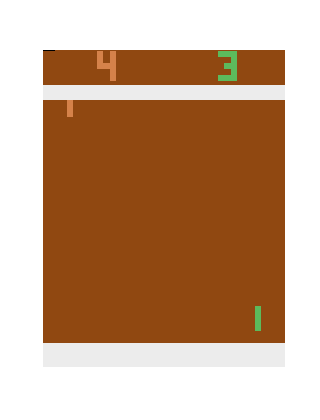
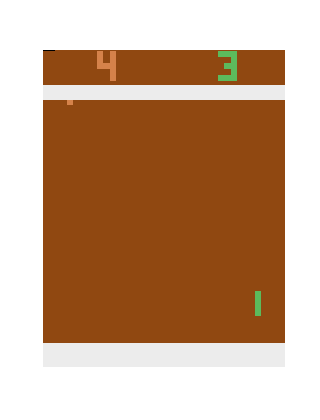
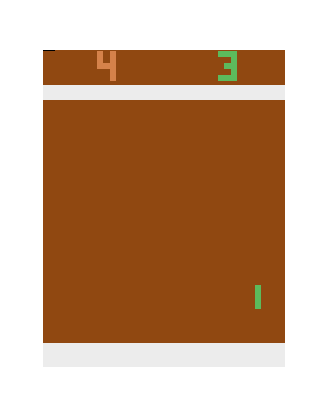
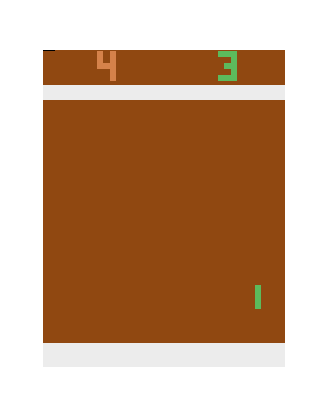
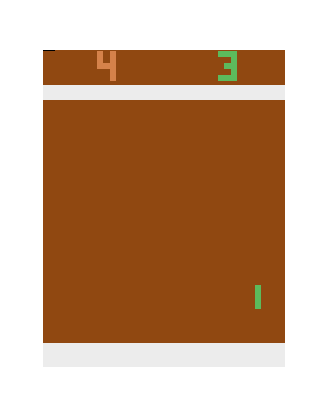
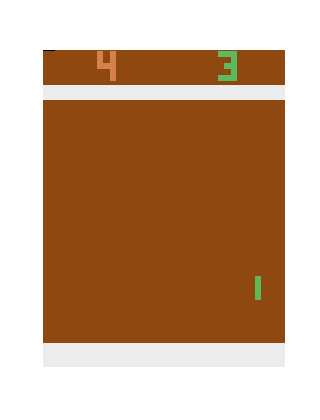
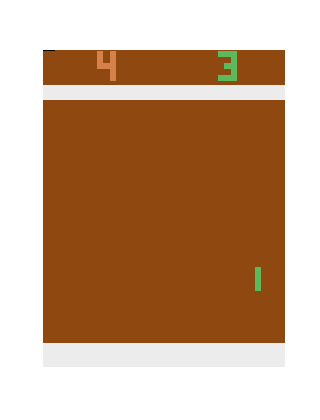
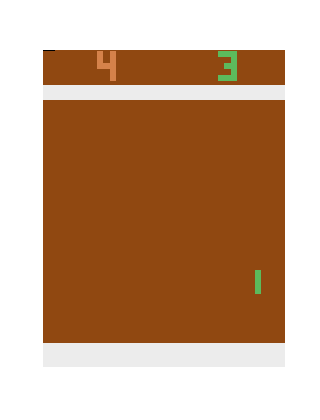
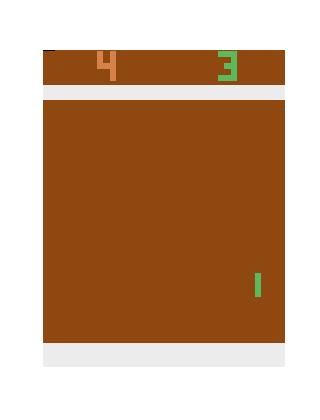
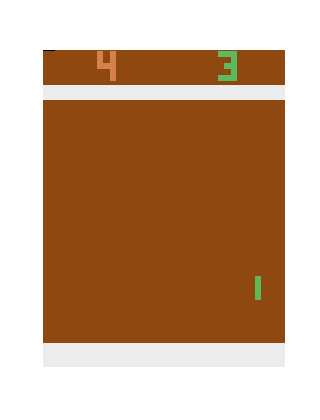
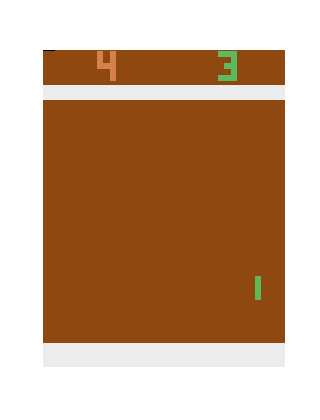
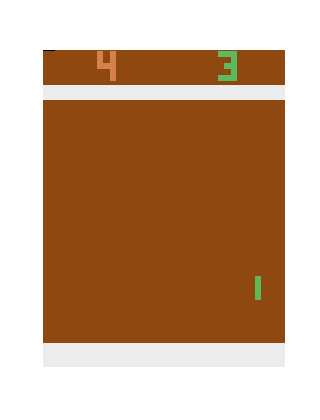
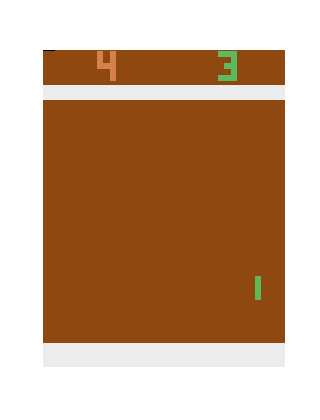
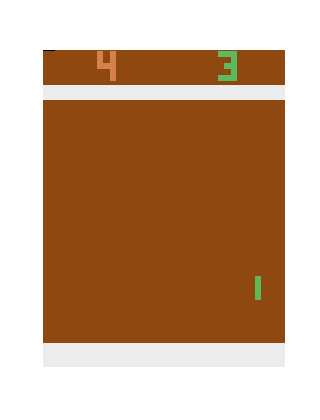
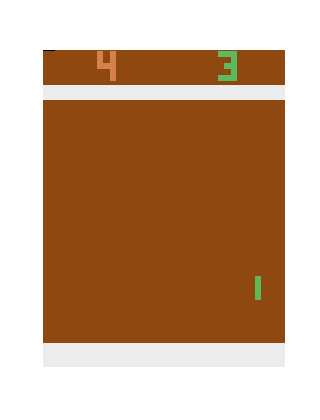

-8.0


In [11]:
# Play
frames, total_reward = agent.play(1)
display_frames_as_gif(frames[:1000])
print(total_reward)

In [10]:
agent.close_env()